# Programming for Deep Reinforcement Learning

Lab Course: Challenging Problems in Reinforcement Learning

In this notebook, we focus on two things that can be useful to your project work and that you will encounter a lot when programming for (Deep) Reinforcement Learning (RL) -- and also general Machine Learning.
1. Implementing a Deep RL algorithm in ```Pytorch```
2. Using Deep RL algorithms from the ```stable_baselines3``` library

Additionally, for those interested in safety in RL, we include
3. Safe RL training using ```omnisafe``` and ```safety_gymnasium```

Please fill out the code everywhere it says `# TODO: ...`.

## Installing the relevant libraries

Run the cell below if you don't have all necessary libraries installed.

In [3]:
!pip install torch -q
!pip install gymnasium -q
!pip install stable-baselines3 -q
!pip install omnisafe -q
!pip install safety-gymnasium -q

## Deep Q-Learning in Pytorch

In the first notebook, we used (standard, tabular) Q-learning on two gymnasium environments. When we combine Q-learning with neural networks to represent the policy, the resulting algorithm is called DQN (Deep Q-learning). DQN is one of the most fundamental and simple algorithms in DRL. Please check the original paper [here](https://arxiv.org/pdf/1312.5602) for details on how it works!

We can implement DQN (and in general, neural network based Machine Learning + RL algorithms) easily in ```pytorch```. ```pytorch``` is one of the major frameworks used for this task (there exist more e.g. Tensorflow, JAX), so understanding how to use it is a good skill to have if you like ML!

In this part of the notebook, we use ```pytorch``` to implement DQN. Disclaimer: DQN is a fundamental, well-known algorithm. There are many implementations available online. Therefore, we largely use code from [this](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html) pytorch tutorial here. The purpose is simply to introduce you to ML/RL coding in ```pytorch```.

Additionally, we include the pseudo-code of DQN, taken from the original paper (linked above), here. Take a look and compare it to the tabular Q-learning you used last week! The major differences here lie in the use of a replay memory to store observations in the form of tuples (state, action, next state, reward), that the model is trained on, and in the use of (two) neural networks to represent the policy, instead of a Q-table.

[<img src="DQN_algorithm.png" width="750"/>](DQN_algorithm.png)

In [4]:
# First, we import the necessary libraries
import gymnasium as gym
import math
import random
import matplotlib.pyplot as plt
from IPython import display
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.nn.functional as F

In [5]:
# Then, like last week, we create our gym environment.
# TODO: create an environment for the "CartPole-v1" task!
""" START COCE """
env = gym.make("CartPole-v1")
""" END CODE """

' END CODE '

In [6]:
# The replay memory (or replay buffer) stores transitions in the form of (state, action, next_state, reward)
# In every step, the current transition is added to the replay memory.
# During learning, batches of transition are sampled from the memory and used to update the policy
# The replay memory is not specific to DQN, but used in many DRL algorithms.
# We provide you with the data structure here.

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, state, action, next_state, reward):
        """Save a transition"""
        self.memory.append(Transition(state, action, next_state, reward))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [7]:
# This class is used for the neural network representation of the Q function.
# It is based on the pytorch class nn.Module - this class is the basis of all Pytorch neural network classes.
# It needs at least two main functions: __init__ is used to initialise the layers of the network,
# and forward "forwards" the input through the layers of the network:
# It takes the state of the RL environment as input, and predicts the next action the agent should take.

# Disclaimer: We renamed this class from the Pytorch Tutorial, from DQN to QNetwork, since it does not represent the entire algorithm, only the Q function!

class QNetwork(nn.Module):

    def __init__(self, n_observations, n_actions, n_hidden):
        super(QNetwork, self).__init__()
        self.layer1 = nn.Linear(n_observations, n_hidden)
        self.layer2 = nn.Linear(n_hidden, n_hidden)
        # TODO: add the third (output) layer using the right dimensions!
        """ START CODE """
        self.layer3 = nn.Linear(n_hidden, n_actions)
        """ END CODE """

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [8]:
# We use this function to plot the episode reward during and after training.
episode_rewards = []

def plot_rewards(show_result=False):
    plt.figure(1)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(episode_rewards)

    plt.pause(0.001)
    if not show_result:
        display.display(plt.gcf())
        display.clear_output(wait=True)
    else:
        display.display(plt.gcf())

In [9]:
# Now we will set some hyperparameters for training
# Feel free to change values and watch the observe the effect they have on training!

BATCH_SIZE = 128        # the number of transitions sampled from the replay buffer
GAMMA = 0.99            # the discount factor
EPS_START = 0.9         # the value of epsilon at the beginning of training
EPS_END = 0.05          # the final value of epsilon at the end of training
EPS_DECAY = 1000        # controls the rate of exponential decay of epsilon, higher means a slower decay
TAU = 0.005             # update rate of the target network
LR = 1e-4               # the learning rate
N_HIDDEN = 128          # number of neurons in the hidden layer -> check out the QNetwork class!
MEMORY_CAPACITY = 10000 # size of the replay memory

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

NUM_EPISODES = 500

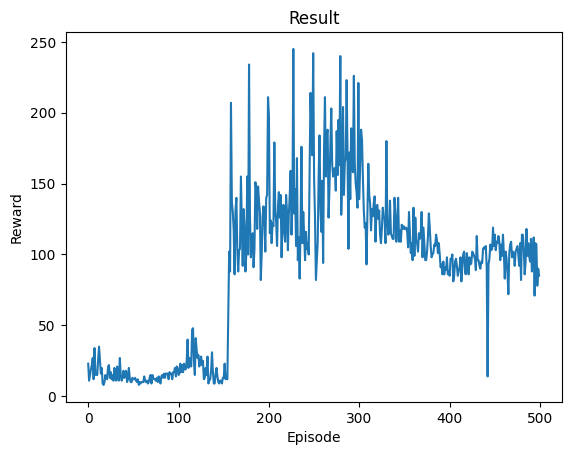

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [10]:
# Now, we implement the DQN algorithm itself, following the pseudo-code from the original paper.

## Algorithm 1 Deep Q-learning with Experience Replay

## Initialize replay memory D to capacity N
memory = ReplayMemory(MEMORY_CAPACITY)
## Initialize action-value function Q with random weights
q_network = QNetwork(n_observations, n_actions, N_HIDDEN)
# TODO: initialize a target network with the same dimensions as the q_network!
""" START CODE """
target_net = QNetwork(n_observations, n_actions, N_HIDDEN)
""" END CODE """
target_net.load_state_dict(q_network.state_dict())

optimizer = torch.optim.AdamW(q_network.parameters(), lr=LR, amsgrad=True)

steps_done = 0

## for episode 1, M do
for i_episode in range(NUM_EPISODES):
    episode_reward = 0
##   Initialise sequence s_1 = {x_1} and preprocessed sequenced phi_1 = phi(s_1)
    # TODO: get the initial state from the environment using the reset() function
    """ START CODE """
    state, info = env.reset()
    """ END CODE """
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
##   for t = 1, T do
    while True:
##       With probability epsilon select a random action a_t
##       otherwise select a_t = max_a Q*(phi(s_t), a; theta)
        sample = random.random()
        eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
        steps_done += 1
        # TODO: implement epsilon-greedy - remember from the previous notebook, or look at the pseudo-code!
        # For the random action, use this: torch.tensor([[env.action_space.sample()]], dtype=torch.long)
        # For the action based on the policy, use this: q_network(state).max(1).indices.view(1,1)
        """ START CODE """
        if sample <= eps_threshold:
            with torch.no_grad():
                action = torch.tensor([[env.action_space.sample()]], dtype=torch.long)
        else:
            action = q_network(state).max(1).indices.view(1,1)
        """ END CODE """
##       Execute action a_t in emulator and observe reward r_t and image x_{t+1}
##       Set s_{t+1} = s_t, a_t, x_{t+1} and preprocess phi_{t+1} = phi(s_{t+1})

        # TODO: using the action.item(), take a step in the environment and observe the observation, reward, terminated, truncated, _.
        observation, reward, terminated, truncated, _ = env.step(action.item())
        episode_reward += reward
        reward = torch.tensor([reward])
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32).unsqueeze(0)

##       Store transition (phi_t, a_t, r_t, phi_{t+1}) in D
        # TODO: add the relevant information to the replay buffer!
        """ START CODE """
        memory.push(state, action, next_state, reward)
        """ END CODE """
        state = next_state

        if len(memory) >= BATCH_SIZE:
##       Sample random minibatch of transitions (phi_j, a_j, r_j, phi_{j+1}) from D
            # TODO: sample a batch of transitions of size BATCH_SIZE from the memory
            """ START CODE """
            transitions = memory.sample(BATCH_SIZE)
            """ END CODE """
            batch = Transition(*zip(*transitions))
##       Set y_j =   {r_j, for terminal phi_{j+1}
##                   {r_j + gamma * max_a' Q(phi_{j+1}, a'; theta), for non-terminal phi_{j+1}
##       Perform a gradient descent step on (y_j - Q(phi_j, a_j; theta))**2 according to equation 3
            #optimize_model()

            # Compute a mask of non-final states and concatenate the batch elements
            non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                                batch.next_state)), dtype=torch.bool)
            non_final_next_states = torch.cat([s for s in batch.next_state
                                                        if s is not None])
            state_batch = torch.cat(batch.state)
            action_batch = torch.cat(batch.action)
            reward_batch = torch.cat(batch.reward)

            # Compute Q(s_t, a) - the model computes Q(s_t), then we select the columns of actions taken
            # That means that for each state in the batch, we receive the action that we would have taken according to the policy
            state_action_values = q_network(state_batch).gather(1, action_batch)

            # Here, we compute the next state values accordin gto the target network
            next_state_values = torch.zeros(BATCH_SIZE)
            with torch.no_grad():
                next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
            expected_state_action_values = (next_state_values * GAMMA) + reward_batch

            # Compute Huber loss
            criterion = nn.SmoothL1Loss()
            loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

            # Optimize the model
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_value_(q_network.parameters(), 100)
            optimizer.step()

            # Update the target network
            target_net_state_dict = target_net.state_dict()
            q_net_state_dict = q_network.state_dict()
            for key in q_net_state_dict:
                target_net_state_dict[key] = q_net_state_dict[key] * TAU + target_net_state_dict[key] * (1-TAU)
            target_net.load_state_dict(target_net_state_dict)

        if done:
            plot_rewards()
            episode_rewards.append(episode_reward)
            break

plot_rewards(show_result=True)
plt.ioff()
plt.show()

In [ ]:
# visualize the behavious of the agent
observation, info = env.reset()

for _ in range(1000):
    action = q_network(observation).max(1).indices.view(1,1)
    observation, reward, terminated, truncated, _ = env.step(action.item())

## DRL with stable_baselines3

Luckily, we don't have to implement all standard DRL algorithms ourselves when we want to use them. There are libraries, such as ```stable_baselines3```, that offer many different ready-to-use DRL algorithms, including DQN, which we just implemented.

In the following, we check out at how to train with the ```stable_baselines3``` implementation of DQN, and then use that knowledge to train an other commonly used DRL algorithm, called PPO. Please check out the ```stable_baselines3``` [DQN documentation](https://stable-baselines3.readthedocs.io/en/master/modules/dqn.html).

We will not go into the details of PPO here, but please feel free to read up on the ```stable_baselines3``` [PPO documentation](https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html) or take a look at the [original paper](https://arxiv.org/abs/1707.06347).

In [ ]:
# First, we import the libraries: gymnasium for the environment, stable_baselines3 for algorithms
import gymnasium as gym
from stable_baselines3 import DQN, PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.logger import configure, read_csv

In [ ]:
# Creating the environment + agent
env = gym.make("CartPole-v1", render_mode="human")
dqn_model = DQN("MlpPolicy", env, verbose=1)

# To get an easier access to evaluation data, configure the logger to write to a file
dqn_tmp_path = "tmp/sb3_log/dqn"
new_dqn_logger = configure(dqn_tmp_path, ["csv"])
dqn_model.set_logger(new_dqn_logger)

# Training and saving the agent
dqn_model.learn(total_timesteps=50000, log_interval=4)
dqn_model.save("dqn_cartpole")


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [ ]:
# Model loading and evaluation
dqn_model = DQN.load("dqn_cartpole")
dqn_mean_rew, dqn_std_rew = evaluate_policy(dqn_model, env, n_eval_episodes=10)
print(f"DQN evaluation results - mean reward: {dqn_mean_rew}, std. deviation: {dqn_std_rew}")

/Users/juleschmidt/miniconda3/envs/lab_env2/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


DQN evaluation results - mean reward: 212.8, std. deviation: 14.379151574414951


In [ ]:
# Now, let's look at the training development, by examining the logger data.
# read the logger output
dqn_train_log = read_csv("tmp/sb3_log/progress.csv")
# take a quick look at the data...
dqn_train_log

,rollout/ep_len_mean,train/learning_rate,time/episodes,train/n_updates,rollout/ep_rew_mean,time/total_timesteps,train/loss,time/time_elapsed,time/fps,rollout/exploration_rate
0,26.250000,0.0001,4,1,26.250000,105,0.559232,2,45,0.8005
1,21.625000,0.0001,8,18,21.625000,173,0.536165,3,45,0.6713
2,19.666667,0.0001,12,33,19.666667,236,0.462133,5,45,0.5516
3,17.937500,0.0001,16,46,17.937500,287,0.434235,6,44,0.4547
4,16.200000,0.0001,20,55,16.200000,324,0.408726,7,44,0.3844
...,...,...,...,...,...,...,...,...,...,...
113,11.190000,0.0001,456,1181,11.190000,4826,0.000475,112,43,0.0500
114,11.220000,0.0001,460,1192,11.220000,4869,0.000620,113,43,0.0500
115,11.230000,0.0001,464,1202,11.230000,4910,0.000533,114,43,0.0500
116,11.180000,0.0001,468,1212,11.180000,4951,0.001396,114,43,0.0500


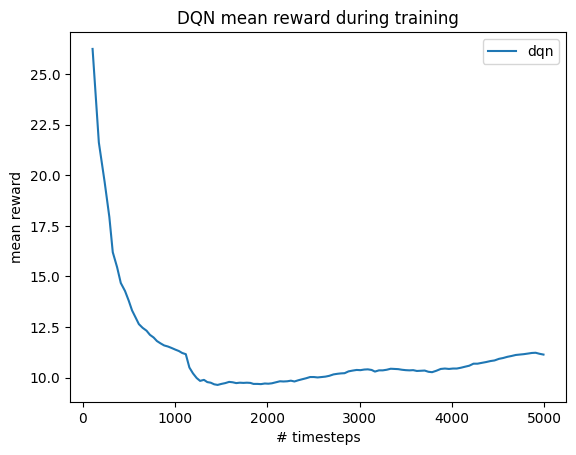

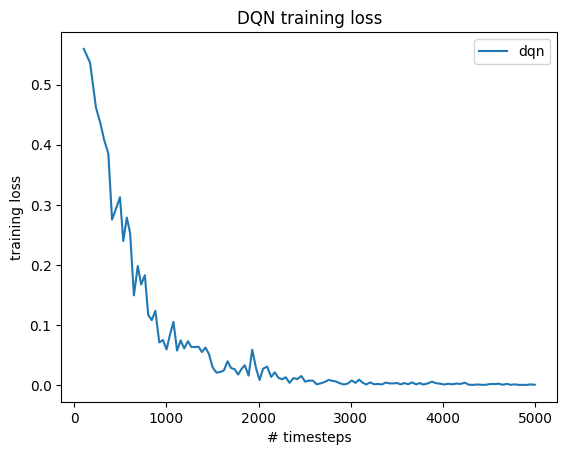

In [ ]:
# Let's plot some of the training evaluation!
import matplotlib.pyplot as plt

# First, we plot the reward development in training
plt.title("DQN mean reward during training")
plt.plot(dqn_train_log['time/total_timesteps'], dqn_train_log['rollout/ep_rew_mean'], label="dqn")
plt.legend()
plt.xlabel("# timesteps")
plt.ylabel("mean reward")
plt.show()

# Let's also look at the loss
plt.title("DQN training loss")
plt.plot(dqn_train_log['time/total_timesteps'], dqn_train_log['train/loss'], label="dqn")
plt.legend()
plt.xlabel("# timesteps")
plt.ylabel("training loss")
plt.show()

Now it is your turn! Fill in the code below to train, save, load, and evaluate a PPO model on the cartpole task.

In [ ]:
# TODO
""" START CODE """
# Create the CartPole environment
env = gym.make("CartPole-v1", render_mode="human")

# Create a PPO agent
ppo_model = PPO("MlpPolicy", env, verbose=1)

# As with DQN, we save the logger output to a file.
tmp_path_ppo = "tmp/sb3_log/ppo/"
new_ppo_logger = configure(tmp_path_ppo, ["csv"])
ppo_model.set_logger(new_ppo_logger)

# Train the PPO agent for 50000 timesteps (feel free to try more/less!)
ppo_model.learn(total_timesteps=50000, log_interval=4)

# Save the trained model to a file for later use!
ppo_model.save("ppo_cartpole")
""" END CODE """


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


' END CODE '

In [ ]:
# Now, we want to evaluate the trained model that we saved earlier!

# First, let's load the model
ppo_model = PPO.load("ppo_cartpole")

# Use evaluate_policy to receive the mean and standard reward of the trained policy over e.g. 10 episodes.
ppo_mean_rew, ppo_std_rew = evaluate_policy(ppo_model, env, n_eval_episodes=10)

# Print the results
print(f"PPO evaluation results - mean reward: {ppo_mean_rew}, std. deviation: {ppo_std_rew}")

/Users/juleschmidt/miniconda3/envs/lab_env2/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


PPO evaluation results - mean reward: 500.0, std. deviation: 0.0


In [ ]:
# TODO: Let's do some visualization again! For that, we consult the log file again.
# read the logger output
""" START CODE """
ppo_train_log = read_csv("tmp/sb3_log/ppo/progress.csv")
""" END CODE """
# take a quick look at the data...
""" START CODE """
ppo_train_log
""" END CODE """


' END CODE '

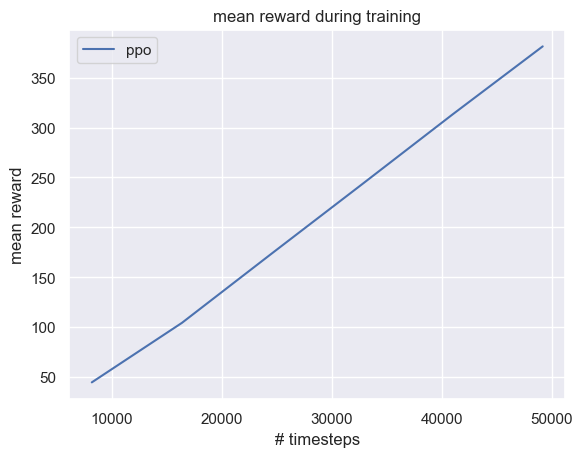

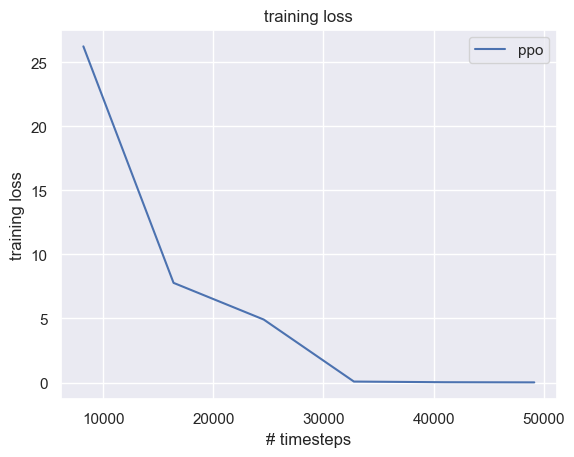

' END CODE '

In [ ]:
# TODO: Let's plot the PPO results like before!
# You can re-use the code from above here and add the PPO log data.
# First, we plot the reward development in training
""" START CODE """
plt.title("mean reward during training")
plt.plot(ppo_train_log['time/total_timesteps'], ppo_train_log['rollout/ep_rew_mean'], label="ppo")
plt.legend()
plt.xlabel("# timesteps")
plt.ylabel("mean reward")
plt.show()

# Let's also look at the loss
plt.title("training loss")
plt.plot(ppo_train_log['time/total_timesteps'], ppo_train_log['train/loss'], label="ppo")
plt.legend()
plt.xlabel("# timesteps")
plt.ylabel("training loss")
plt.show()
""" END CODE """

That's it!

Now you saw how easy it is to train DRL models with libraries like ```stable_baselines3```.

## Safe RL with omnisafe and safety_gymnasium

An important challenge (and a very wide topic) in RL research is safety. In this part of the notebook, we look at two libraries that allow us to easily train save RL agents on suitable environments.

[```safety_gymnasium```](https://safety-gymnasium.readthedocs.io/en/latest/index.html) provides environments that include notions of costs and constraints. In our task, we will use the ```SafetyCarCircle1-v0``` environment - that means a safety environment, with a Car agent, for the Circle Task, Level 1. Check out the documentation on the Circle task [here](https://safety-gymnasium.readthedocs.io/en/latest/environments/safe_navigation/circle.html#circle1)!

In this Circle task, the agent learns to drive in circles around the center of a circled area. Level 0 does not implement any constraints, so it is not interesting to us here, but level 1 does! In level one, boundaries are implemented on two sides of the circle, and the agent needs to avoid crossing these boundaries. If it does, it is punished by receiving a cost.

Additionally, the [```omnisafe```](https://www.omnisafe.ai/en/latest/index.html) library provides implementation of some DRL algorithms, like PPO, which we looked at in the previous section, as well as save versions of these algorithms. Here, we will use PPO, and the safe algorithm PPOLag, which implements Lagrangian constraints. Again, we do not need to understand this in detail for this notebook, but if you are interested, please read the omnisafe [documentation](https://www.omnisafe.ai/en/latest/benchmark/on-policy.html), and also consider the original papers of [PPO](https://arxiv.org/pdf/1707.06347) and the Lagrangian version [PPOLag](https://cdn.openai.com/safexp-short.pdf).

In [ ]:
# First, we import the necessary libraries
import omnisafe
import safety_gymnasium

In [ ]:
# create the environment
ENV_ID = 'SafetyCarCircle1-v0'
env = safety_gymnasium.make(ENV_ID,
                            render_mode='human')

# We set some configurations: how many steps we want to train for, and how many steps there are in an episode
# The number of steps per episode can be found in the Circle task documentation.
# The documentation on which configuration settings are relevant is unfortunately a bit unclear - these two seem to be the minimum.
# Feel free to figure out more!
cfg = {
    'train_cfgs': {
        'total_steps': 100000,
    },
    'algo_cfgs': {
        'steps_per_epoch': 500,
    }
}

### Collapse/view training log for PPO agent
Output log during training is very long. Collapse to not have to scroll down super far.

In [ ]:
# Now, we create an omnisafe Agent: We want to train the PPO algorithm, in the specified environment, with the specified configuration
agent = omnisafe.Agent('PPO', ENV_ID, custom_cfgs=cfg)
# The only thing we need to do to start training is call this function!
agent.learn()

Loading PPO.yaml from /Users/juleschmidt/miniconda3/envs/lab_env2/lib/python3.8/site-packages/omnisafe/utils/../configs/on-policy/PPO.yaml


Logging data to ./runs/PPO-{SafetyCarCircle1-v0}/seed-000-2024-10-21-11-29-11/progress.csv

Save with config in config.json

INFO: Start training

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 17 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ -0.8657189607620239    │
│ Metrics/EpCost                │ 0.0                    │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 0.0                    │
│ Train/Entropy                 │ 1.414169192314148      │
│ Train/KL                      │ 0.02073945850133896    │
│ Train/StopIter                │ 17.0                   │
│ Train/PolicyRatio/Mean        │ 0.9960047602653503     │
│ Train/PolicyRatio/Min         │ 0.9960047602653503     │
│ Train/PolicyRatio/Max         │ 0.9960047602653503     │
│ Train/PolicyRatio/Std         │ 0.01732473075389862    │
│ Train/LR                      │ 0.00029850000282749534 │
│ Train/PolicyStd               │ 0.9952470064163208     │
│ TotalEnvSteps                 │ 500.0                  │
│ Loss/Loss_pi                  │ -0.030582014471292496  │
│ Loss/Loss_pi/Delta            │ -0.030582014471292496  │
│ Value/Adv                     │ 0.13627608120441437    │
│ Loss/Loss_reward_critic       │ 0.04031236842274666    │
│ Loss/Loss_reward_critic/Delta │ 0.04031236842274666    │
│ Value/reward                  │ -0.04757261648774147   │
│ Time/Total                    │ 2.33925199508667       │
│ Time/Rollout                  │ 2.0257680416107178     │
│ Time/Update                   │ 0.31281304359436035    │
│ Time/Epoch                    │ 2.3386058807373047     │
│ Time/FPS                      │ 213.80259704589844     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 15 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ -0.525212287902832    │
│ Metrics/EpCost                │ 0.0                   │
│ Metrics/EpLen                 │ 500.0                 │
│ Train/Epoch                   │ 1.0                   │
│ Train/Entropy                 │ 1.4119104146957397    │
│ Train/KL                      │ 0.020073089748620987  │
│ Train/StopIter                │ 15.0                  │
│ Train/PolicyRatio/Mean        │ 0.9951603412628174    │
│ Train/PolicyRatio/Min         │ 0.9951603412628174    │
│ Train/PolicyRatio/Max         │ 0.9951603412628174    │
│ Train/PolicyRatio/Std         │ 0.015551852993667126  │
│ Train/LR                      │ 0.0002969999914057553 │
│ Train/PolicyStd               │ 0.9930073618888855    │
│ TotalEnvSteps                 │ 1000.0                │
│ Loss/Loss_pi                  │ -0.027293113991618156 │
│ Loss/Loss_pi/Delta            │ 0.0032889004796743393 │
│ Value/Adv                     │ -0.20041543245315552  │
│ Loss/Loss_reward_critic       │ 0.02866552211344242   │
│ Loss/Loss_reward_critic/Delta │ -0.011646846309304237 │
│ Value/reward                  │ -0.11588160693645477  │
│ Time/Total                    │ 4.64070987701416      │
│ Time/Rollout                  │ 2.050748825073242     │
│ Time/Update                   │ 0.24411392211914062   │
│ Time/Epoch                    │ 2.294883966445923     │
│ Time/FPS                      │ 217.8760528564453     │
└───────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 18 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ -0.23615093529224396  │
│ Metrics/EpCost                │ 0.0                   │
│ Metrics/EpLen                 │ 500.0                 │
│ Train/Epoch                   │ 2.0                   │
│ Train/Entropy                 │ 1.4070992469787598    │
│ Train/KL                      │ 0.02287217788398266   │
│ Train/StopIter                │ 18.0                  │
│ Train/PolicyRatio/Mean        │ 0.9951193928718567    │
│ Train/PolicyRatio/Min         │ 0.9951193928718567    │
│ Train/PolicyRatio/Max         │ 0.9951193928718567    │
│ Train/PolicyRatio/Std         │ 0.021975399926304817  │
│ Train/LR                      │ 0.0002955000090878457 │
│ Train/PolicyStd               │ 0.9882988333702087    │
│ TotalEnvSteps                 │ 1500.0                │
│ Loss/Loss_pi                  │ -0.033315639942884445 │
│ Loss/Loss_pi/Delta            │ -0.006022525951266289 │
│ Value/Adv                     │ 0.03315458074212074   │
│ Loss/Loss_reward_critic       │ 0.01913226954638958   │
│ Loss/Loss_reward_critic/Delta │ -0.009533252567052841 │
│ Value/reward                  │ -0.14518652856349945  │
│ Time/Total                    │ 7.031044006347656     │
│ Time/Rollout                  │ 2.0807390213012695    │
│ Time/Update                   │ 0.303466796875        │
│ Time/Epoch                    │ 2.38423228263855      │
│ Time/FPS                      │ 209.71119689941406    │
└───────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 12 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ -0.26505401730537415   │
│ Metrics/EpCost                │ 80.0                   │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 3.0                    │
│ Train/Entropy                 │ 1.3946393728256226     │
│ Train/KL                      │ 0.02030663751065731    │
│ Train/StopIter                │ 12.0                   │
│ Train/PolicyRatio/Mean        │ 0.9971687197685242     │
│ Train/PolicyRatio/Min         │ 0.9971687197685242     │
│ Train/PolicyRatio/Max         │ 0.9971687197685242     │
│ Train/PolicyRatio/Std         │ 0.018243666738271713   │
│ Train/LR                      │ 0.00029399999766610563 │
│ Train/PolicyStd               │ 0.9761468768119812     │
│ TotalEnvSteps                 │ 2000.0                 │
│ Loss/Loss_pi                  │ -0.030938180163502693  │
│ Loss/Loss_pi/Delta            │ 0.002377459779381752   │
│ Value/Adv                     │ -0.12490128725767136   │
│ Loss/Loss_reward_critic       │ 0.013671054504811764   │
│ Loss/Loss_reward_critic/Delta │ -0.005461215041577816  │
│ Value/reward                  │ -0.12519803643226624   │
│ Time/Total                    │ 9.417716979980469      │
│ Time/Rollout                  │ 2.182223081588745      │
│ Time/Update                   │ 0.19748973846435547    │
│ Time/Epoch                    │ 2.379737138748169      │
│ Time/FPS                      │ 210.10723876953125     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 2 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ -0.4311051368713379    │
│ Metrics/EpCost                │ 64.0                   │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 4.0                    │
│ Train/Entropy                 │ 1.3854594230651855     │
│ Train/KL                      │ 0.020834701135754585   │
│ Train/StopIter                │ 2.0                    │
│ Train/PolicyRatio/Mean        │ 1.0000004768371582     │
│ Train/PolicyRatio/Min         │ 1.0000004768371582     │
│ Train/PolicyRatio/Max         │ 1.0000004768371582     │
│ Train/PolicyRatio/Std         │ 0.020465722307562828   │
│ Train/LR                      │ 0.0002924999862443656  │
│ Train/PolicyStd               │ 0.9672859311103821     │
│ TotalEnvSteps                 │ 2500.0                 │
│ Loss/Loss_pi                  │ -0.004915772005915642  │
│ Loss/Loss_pi/Delta            │ 0.02602240815758705    │
│ Value/Adv                     │ -0.022951653227210045  │
│ Loss/Loss_reward_critic       │ 0.013160338625311852   │
│ Loss/Loss_reward_critic/Delta │ -0.0005107158794999123 │
│ Value/reward                  │ -0.1960829347372055    │
│ Time/Total                    │ 11.506548881530762     │
│ Time/Rollout                  │ 2.0408167839050293     │
│ Time/Update                   │ 0.04146289825439453    │
│ Time/Epoch                    │ 2.082303047180176      │
│ Time/FPS                      │ 240.11874389648438     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 16 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ -0.4346207082271576   │
│ Metrics/EpCost                │ 53.33333206176758     │
│ Metrics/EpLen                 │ 500.0                 │
│ Train/Epoch                   │ 5.0                   │
│ Train/Entropy                 │ 1.3847414255142212    │
│ Train/KL                      │ 0.020478975027799606  │
│ Train/StopIter                │ 16.0                  │
│ Train/PolicyRatio/Mean        │ 0.998768150806427     │
│ Train/PolicyRatio/Min         │ 0.998768150806427     │
│ Train/PolicyRatio/Max         │ 0.998768150806427     │
│ Train/PolicyRatio/Std         │ 0.01915978267788887   │
│ Train/LR                      │ 0.000291000003926456  │
│ Train/PolicyStd               │ 0.9664885997772217    │
│ TotalEnvSteps                 │ 3000.0                │
│ Loss/Loss_pi                  │ -0.036009274423122406 │
│ Loss/Loss_pi/Delta            │ -0.031093502417206764 │
│ Value/Adv                     │ -0.01105074118822813  │
│ Loss/Loss_reward_critic       │ 0.010001500137150288  │
│ Loss/Loss_reward_critic/Delta │ -0.003158838488161564 │
│ Value/reward                  │ -0.1126914918422699   │
│ Time/Total                    │ 13.859272956848145    │
│ Time/Rollout                  │ 2.0878851413726807    │
│ Time/Update                   │ 0.25878024101257324   │
│ Time/Epoch                    │ 2.3466849327087402    │
│ Time/FPS                      │ 213.0665283203125     │
└───────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 2 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ -0.34883835911750793   │
│ Metrics/EpCost                │ 45.71428680419922      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 6.0                    │
│ Train/Entropy                 │ 1.3860684633255005     │
│ Train/KL                      │ 0.020414579659700394   │
│ Train/StopIter                │ 2.0                    │
│ Train/PolicyRatio/Mean        │ 1.0066903829574585     │
│ Train/PolicyRatio/Min         │ 1.0066903829574585     │
│ Train/PolicyRatio/Max         │ 1.0066903829574585     │
│ Train/PolicyRatio/Std         │ 0.014269591309130192   │
│ Train/LR                      │ 0.0002894999925047159  │
│ Train/PolicyStd               │ 0.9677066802978516     │
│ TotalEnvSteps                 │ 3500.0                 │
│ Loss/Loss_pi                  │ -0.012468746863305569  │
│ Loss/Loss_pi/Delta            │ 0.023540527559816837   │
│ Value/Adv                     │ 0.05265665799379349    │
│ Loss/Loss_reward_critic       │ 0.008825486525893211   │
│ Loss/Loss_reward_critic/Delta │ -0.0011760136112570763 │
│ Value/reward                  │ -0.18174313008785248   │
│ Time/Total                    │ 15.9851713180542       │
│ Time/Rollout                  │ 2.0765841007232666     │
│ Time/Update                   │ 0.04300999641418457    │
│ Time/Epoch                    │ 2.1196160316467285     │
│ Time/FPS                      │ 235.8918914794922      │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 7 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ -0.2946997582912445    │
│ Metrics/EpCost                │ 40.0                   │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 7.0                    │
│ Train/Entropy                 │ 1.3865889310836792     │
│ Train/KL                      │ 0.020975079387426376   │
│ Train/StopIter                │ 7.0                    │
│ Train/PolicyRatio/Mean        │ 1.0102430582046509     │
│ Train/PolicyRatio/Min         │ 1.0102430582046509     │
│ Train/PolicyRatio/Max         │ 1.0102430582046509     │
│ Train/PolicyRatio/Std         │ 0.022059660404920578   │
│ Train/LR                      │ 0.0002880000101868063  │
│ Train/PolicyStd               │ 0.9681963920593262     │
│ TotalEnvSteps                 │ 4000.0                 │
│ Loss/Loss_pi                  │ -0.024478856474161148  │
│ Loss/Loss_pi/Delta            │ -0.01201010961085558   │
│ Value/Adv                     │ -0.2976609468460083    │
│ Loss/Loss_reward_critic       │ 0.007023514248430729   │
│ Loss/Loss_reward_critic/Delta │ -0.0018019722774624825 │
│ Value/reward                  │ -0.17224138975143433   │
│ Time/Total                    │ 18.139833450317383     │
│ Time/Rollout                  │ 2.026865243911743      │
│ Time/Update                   │ 0.12152385711669922    │
│ Time/Epoch                    │ 2.148416042327881      │
│ Time/FPS                      │ 232.72959899902344     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 21 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ -0.02437949739396572   │
│ Metrics/EpCost                │ 77.11111450195312      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 8.0                    │
│ Train/Entropy                 │ 1.380516529083252      │
│ Train/KL                      │ 0.020713092759251595   │
│ Train/StopIter                │ 21.0                   │
│ Train/PolicyRatio/Mean        │ 0.9866805076599121     │
│ Train/PolicyRatio/Min         │ 0.9866805076599121     │
│ Train/PolicyRatio/Max         │ 0.9866805076599121     │
│ Train/PolicyRatio/Std         │ 0.020307272672653198   │
│ Train/LR                      │ 0.00028649999876506627 │
│ Train/PolicyStd               │ 0.9623178839683533     │
│ TotalEnvSteps                 │ 4500.0                 │
│ Loss/Loss_pi                  │ -0.03259160369634628   │
│ Loss/Loss_pi/Delta            │ -0.008112747222185135  │
│ Value/Adv                     │ -0.16417153179645538   │
│ Loss/Loss_reward_critic       │ 0.005644860677421093   │
│ Loss/Loss_reward_critic/Delta │ -0.001378653571009636  │
│ Value/reward                  │ -0.046378232538700104  │
│ Time/Total                    │ 20.524063110351562     │
│ Time/Rollout                  │ 2.0420548915863037     │
│ Time/Update                   │ 0.33638906478881836    │
│ Time/Epoch                    │ 2.378464937210083      │
│ Time/FPS                      │ 210.21961975097656     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 24 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 0.2137034833431244     │
│ Metrics/EpCost                │ 101.5999984741211      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 9.0                    │
│ Train/Entropy                 │ 1.3584251403808594     │
│ Train/KL                      │ 0.020291892811655998   │
│ Train/StopIter                │ 24.0                   │
│ Train/PolicyRatio/Mean        │ 0.9900228977203369     │
│ Train/PolicyRatio/Min         │ 0.9900228977203369     │
│ Train/PolicyRatio/Max         │ 0.9900228977203369     │
│ Train/PolicyRatio/Std         │ 0.018064752221107483   │
│ Train/LR                      │ 0.0002849999873433262  │
│ Train/PolicyStd               │ 0.9413547515869141     │
│ TotalEnvSteps                 │ 5000.0                 │
│ Loss/Loss_pi                  │ -0.034712791442871094  │
│ Loss/Loss_pi/Delta            │ -0.002121187746524811  │
│ Value/Adv                     │ -0.024248477071523666  │
│ Loss/Loss_reward_critic       │ 0.0041265026666224     │
│ Loss/Loss_reward_critic/Delta │ -0.0015183580107986927 │
│ Value/reward                  │ 0.009105553850531578   │
│ Time/Total                    │ 22.95783233642578      │
│ Time/Rollout                  │ 2.0532748699188232     │
│ Time/Update                   │ 0.3743479251861572     │
│ Time/Epoch                    │ 2.427642822265625      │
│ Time/FPS                      │ 205.9611053466797      │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 13 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 0.39440134167671204     │
│ Metrics/EpCost                │ 92.36363983154297       │
│ Metrics/EpLen                 │ 500.0                   │
│ Train/Epoch                   │ 10.0                    │
│ Train/Entropy                 │ 1.3394907712936401      │
│ Train/KL                      │ 0.020062800496816635    │
│ Train/StopIter                │ 13.0                    │
│ Train/PolicyRatio/Mean        │ 0.9955642223358154      │
│ Train/PolicyRatio/Min         │ 0.9955642223358154      │
│ Train/PolicyRatio/Max         │ 0.9955642223358154      │
│ Train/PolicyRatio/Std         │ 0.02000710554420948     │
│ Train/LR                      │ 0.0002835000050254166   │
│ Train/PolicyStd               │ 0.9237067699432373      │
│ TotalEnvSteps                 │ 5500.0                  │
│ Loss/Loss_pi                  │ -0.030185045674443245   │
│ Loss/Loss_pi/Delta            │ 0.004527745768427849    │
│ Value/Adv                     │ -0.03369374945759773    │
│ Loss/Loss_reward_critic       │ 0.0038932275492697954   │
│ Loss/Loss_reward_critic/Delta │ -0.00023327511735260487 │
│ Value/reward                  │ -0.04210580140352249    │
│ Time/Total                    │ 25.19944190979004       │
│ Time/Rollout                  │ 2.03633189201355        │
│ Time/Update                   │ 0.19874978065490723     │
│ Time/Epoch                    │ 2.235105037689209       │
│ Time/FPS                      │ 223.70314025878906      │
└───────────────────────────────┴─────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 20 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 0.4539589583873749     │
│ Metrics/EpCost                │ 95.41666412353516      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 11.0                   │
│ Train/Entropy                 │ 1.335331678390503      │
│ Train/KL                      │ 0.020512565970420837   │
│ Train/StopIter                │ 20.0                   │
│ Train/PolicyRatio/Mean        │ 0.9928590059280396     │
│ Train/PolicyRatio/Min         │ 0.9928590059280396     │
│ Train/PolicyRatio/Max         │ 0.9928590059280396     │
│ Train/PolicyRatio/Std         │ 0.019059691578149796   │
│ Train/LR                      │ 0.00028199999360367656 │
│ Train/PolicyStd               │ 0.9198098182678223     │
│ TotalEnvSteps                 │ 6000.0                 │
│ Loss/Loss_pi                  │ -0.030612219125032425  │
│ Loss/Loss_pi/Delta            │ -0.00042717345058918   │
│ Value/Adv                     │ -0.26745927333831787   │
│ Loss/Loss_reward_critic       │ 0.002032120479270816   │
│ Loss/Loss_reward_critic/Delta │ -0.0018611070699989796 │
│ Value/reward                  │ 0.006031419616192579   │
│ Time/Total                    │ 27.57822608947754      │
│ Time/Rollout                  │ 2.0526041984558105     │
│ Time/Update                   │ 0.31948399543762207    │
│ Time/Epoch                    │ 2.372117042541504      │
│ Time/FPS                      │ 210.78228759765625     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 2 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 0.4561280906200409     │
│ Metrics/EpCost                │ 88.07691955566406      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 12.0                   │
│ Train/Entropy                 │ 1.333186149597168      │
│ Train/KL                      │ 0.020736385136842728   │
│ Train/StopIter                │ 2.0                    │
│ Train/PolicyRatio/Mean        │ 1.0009045600891113     │
│ Train/PolicyRatio/Min         │ 1.0009045600891113     │
│ Train/PolicyRatio/Max         │ 1.0009045600891113     │
│ Train/PolicyRatio/Std         │ 0.011376478709280491   │
│ Train/LR                      │ 0.00028050001128576696 │
│ Train/PolicyStd               │ 0.9178234934806824     │
│ TotalEnvSteps                 │ 6500.0                 │
│ Loss/Loss_pi                  │ -0.017502257600426674  │
│ Loss/Loss_pi/Delta            │ 0.013109961524605751   │
│ Value/Adv                     │ 0.09142705798149109    │
│ Loss/Loss_reward_critic       │ 0.002884632209315896   │
│ Loss/Loss_reward_critic/Delta │ 0.0008525117300450802  │
│ Value/reward                  │ -0.06688164919614792   │
│ Time/Total                    │ 29.682392120361328     │
│ Time/Rollout                  │ 2.053999900817871      │
│ Time/Update                   │ 0.04320383071899414    │
│ Time/Epoch                    │ 2.0972249507904053     │
│ Time/FPS                      │ 238.410400390625       │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 11 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 0.5560948848724365     │
│ Metrics/EpCost                │ 81.78571319580078      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 13.0                   │
│ Train/Entropy                 │ 1.3290616273880005     │
│ Train/KL                      │ 0.02147344872355461    │
│ Train/StopIter                │ 11.0                   │
│ Train/PolicyRatio/Mean        │ 0.9913171529769897     │
│ Train/PolicyRatio/Min         │ 0.9913171529769897     │
│ Train/PolicyRatio/Max         │ 0.9913171529769897     │
│ Train/PolicyRatio/Std         │ 0.01976863667368889    │
│ Train/LR                      │ 0.0002789999998640269  │
│ Train/PolicyStd               │ 0.9140458703041077     │
│ TotalEnvSteps                 │ 7000.0                 │
│ Loss/Loss_pi                  │ -0.030822718515992165  │
│ Loss/Loss_pi/Delta            │ -0.01332046091556549   │
│ Value/Adv                     │ 0.12952102720737457    │
│ Loss/Loss_reward_critic       │ 0.003286510705947876   │
│ Loss/Loss_reward_critic/Delta │ 0.00040187849663197994 │
│ Value/reward                  │ -0.03719332814216614   │
│ Time/Total                    │ 31.918548583984375     │
│ Time/Rollout                  │ 2.0515849590301514     │
│ Time/Update                   │ 0.17826604843139648    │
│ Time/Epoch                    │ 2.2298710346221924     │
│ Time/FPS                      │ 224.2283172607422      │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 29 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 0.7352331876754761     │
│ Metrics/EpCost                │ 76.33333587646484      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 14.0                   │
│ Train/Entropy                 │ 1.3211654424667358     │
│ Train/KL                      │ 0.020541973412036896   │
│ Train/StopIter                │ 29.0                   │
│ Train/PolicyRatio/Mean        │ 0.9879372119903564     │
│ Train/PolicyRatio/Min         │ 0.9879372119903564     │
│ Train/PolicyRatio/Max         │ 0.9879372119903564     │
│ Train/PolicyRatio/Std         │ 0.019766906276345253   │
│ Train/LR                      │ 0.00027749998844228685 │
│ Train/PolicyStd               │ 0.9068741798400879     │
│ TotalEnvSteps                 │ 7500.0                 │
│ Loss/Loss_pi                  │ -0.0348253957927227    │
│ Loss/Loss_pi/Delta            │ -0.004002677276730537  │
│ Value/Adv                     │ 0.07738104462623596    │
│ Loss/Loss_reward_critic       │ 0.002073321957141161   │
│ Loss/Loss_reward_critic/Delta │ -0.001213188748806715  │
│ Value/reward                  │ 0.05528077483177185    │
│ Time/Total                    │ 34.42122268676758      │
│ Time/Rollout                  │ 2.036881923675537      │
│ Time/Update                   │ 0.459381103515625      │
│ Time/Epoch                    │ 2.4962828159332275     │
│ Time/FPS                      │ 200.29782104492188     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 9 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 0.7488653063774109     │
│ Metrics/EpCost                │ 71.5625                │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 15.0                   │
│ Train/Entropy                 │ 1.3103954792022705     │
│ Train/KL                      │ 0.02103879489004612    │
│ Train/StopIter                │ 9.0                    │
│ Train/PolicyRatio/Mean        │ 0.9937124252319336     │
│ Train/PolicyRatio/Min         │ 0.9937124252319336     │
│ Train/PolicyRatio/Max         │ 0.9937124252319336     │
│ Train/PolicyRatio/Std         │ 0.015478960238397121   │
│ Train/LR                      │ 0.00027600000612437725 │
│ Train/PolicyStd               │ 0.8971819281578064     │
│ TotalEnvSteps                 │ 8000.0                 │
│ Loss/Loss_pi                  │ -0.02245047315955162   │
│ Loss/Loss_pi/Delta            │ 0.012374922633171082   │
│ Value/Adv                     │ -0.12843364477157593   │
│ Loss/Loss_reward_critic       │ 0.0024569511879235506  │
│ Loss/Loss_reward_critic/Delta │ 0.00038362923078238964 │
│ Value/reward                  │ -0.015012637712061405  │
│ Time/Total                    │ 36.62543487548828      │
│ Time/Rollout                  │ 2.0471160411834717     │
│ Time/Update                   │ 0.15086698532104492    │
│ Time/Epoch                    │ 2.198004961013794      │
│ Time/FPS                      │ 227.47901916503906     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 36 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 0.9187188148498535    │
│ Metrics/EpCost                │ 84.88235473632812     │
│ Metrics/EpLen                 │ 500.0                 │
│ Train/Epoch                   │ 16.0                  │
│ Train/Entropy                 │ 1.298237681388855     │
│ Train/KL                      │ 0.02021726965904236   │
│ Train/StopIter                │ 36.0                  │
│ Train/PolicyRatio/Mean        │ 1.006340503692627     │
│ Train/PolicyRatio/Min         │ 1.006340503692627     │
│ Train/PolicyRatio/Max         │ 1.006340503692627     │
│ Train/PolicyRatio/Std         │ 0.01957981288433075   │
│ Train/LR                      │ 0.0002744999947026372 │
│ Train/PolicyStd               │ 0.8863270282745361    │
│ TotalEnvSteps                 │ 8500.0                │
│ Loss/Loss_pi                  │ -0.030152827501296997 │
│ Loss/Loss_pi/Delta            │ -0.007702354341745377 │
│ Value/Adv                     │ 0.0480511449277401    │
│ Loss/Loss_reward_critic       │ 0.0046980734914541245 │
│ Loss/Loss_reward_critic/Delta │ 0.002241122303530574  │
│ Value/reward                  │ 0.08154485374689102   │
│ Time/Total                    │ 39.25436782836914     │
│ Time/Rollout                  │ 2.0437240600585938    │
│ Time/Update                   │ 0.5790603160858154    │
│ Time/Epoch                    │ 2.622807025909424     │
│ Time/FPS                      │ 190.63551330566406    │
└───────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 2 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 1.040758490562439     │
│ Metrics/EpCost                │ 97.72222137451172     │
│ Metrics/EpLen                 │ 500.0                 │
│ Train/Epoch                   │ 17.0                  │
│ Train/Entropy                 │ 1.29318368434906      │
│ Train/KL                      │ 0.02217668667435646   │
│ Train/StopIter                │ 2.0                   │
│ Train/PolicyRatio/Mean        │ 1.0029654502868652    │
│ Train/PolicyRatio/Min         │ 1.0029654502868652    │
│ Train/PolicyRatio/Max         │ 1.0029654502868652    │
│ Train/PolicyRatio/Std         │ 0.010745687410235405  │
│ Train/LR                      │ 0.0002730000123847276 │
│ Train/PolicyStd               │ 0.881914496421814     │
│ TotalEnvSteps                 │ 9000.0                │
│ Loss/Loss_pi                  │ -0.013368556275963783 │
│ Loss/Loss_pi/Delta            │ 0.016784271225333214  │
│ Value/Adv                     │ -0.057749949395656586 │
│ Loss/Loss_reward_critic       │ 0.00739175733178854   │
│ Loss/Loss_reward_critic/Delta │ 0.0026936838403344154 │
│ Value/reward                  │ 0.16984976828098297   │
│ Time/Total                    │ 41.34108352661133     │
│ Time/Rollout                  │ 2.037889003753662     │
│ Time/Update                   │ 0.041497230529785156  │
│ Time/Epoch                    │ 2.0794098377227783    │
│ Time/FPS                      │ 240.4528350830078     │
└───────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 12 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 1.2225059270858765     │
│ Metrics/EpCost                │ 109.89473724365234     │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 18.0                   │
│ Train/Entropy                 │ 1.2869737148284912     │
│ Train/KL                      │ 0.020586000755429268   │
│ Train/StopIter                │ 12.0                   │
│ Train/PolicyRatio/Mean        │ 0.997290849685669      │
│ Train/PolicyRatio/Min         │ 0.997290849685669      │
│ Train/PolicyRatio/Max         │ 0.997290849685669      │
│ Train/PolicyRatio/Std         │ 0.02273382619023323    │
│ Train/LR                      │ 0.00027150000096298754 │
│ Train/PolicyStd               │ 0.87648606300354       │
│ TotalEnvSteps                 │ 9500.0                 │
│ Loss/Loss_pi                  │ -0.0319824256002903    │
│ Loss/Loss_pi/Delta            │ -0.018613869324326515  │
│ Value/Adv                     │ -0.011383581906557083  │
│ Loss/Loss_reward_critic       │ 0.003668079851195216   │
│ Loss/Loss_reward_critic/Delta │ -0.0037236774805933237 │
│ Value/reward                  │ 0.2352580428123474     │
│ Time/Total                    │ 43.59571075439453      │
│ Time/Rollout                  │ 2.046187162399292      │
│ Time/Update                   │ 0.20194315910339355    │
│ Time/Epoch                    │ 2.2481510639190674     │
│ Time/FPS                      │ 222.4050750732422      │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 19 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 1.2601981163024902      │
│ Metrics/EpCost                │ 104.4000015258789       │
│ Metrics/EpLen                 │ 500.0                   │
│ Train/Epoch                   │ 19.0                    │
│ Train/Entropy                 │ 1.2735358476638794      │
│ Train/KL                      │ 0.02195647917687893     │
│ Train/StopIter                │ 19.0                    │
│ Train/PolicyRatio/Mean        │ 0.9957050681114197      │
│ Train/PolicyRatio/Min         │ 0.9957050681114197      │
│ Train/PolicyRatio/Max         │ 0.9957050681114197      │
│ Train/PolicyRatio/Std         │ 0.01853923685848713     │
│ Train/LR                      │ 0.0002699999895412475   │
│ Train/PolicyStd               │ 0.8647966980934143      │
│ TotalEnvSteps                 │ 10000.0                 │
│ Loss/Loss_pi                  │ -0.033115170896053314   │
│ Loss/Loss_pi/Delta            │ -0.0011327452957630157  │
│ Value/Adv                     │ -0.00013549740833695978 │
│ Loss/Loss_reward_critic       │ 0.004179796203970909    │
│ Loss/Loss_reward_critic/Delta │ 0.0005117163527756929   │
│ Value/reward                  │ 0.04002023860812187     │
│ Time/Total                    │ 46.43314743041992       │
│ Time/Rollout                  │ 2.2795157432556152      │
│ Time/Update                   │ 0.5512409210205078      │
│ Time/Epoch                    │ 2.8307888507843018      │
│ Time/FPS                      │ 176.62921142578125      │
└───────────────────────────────┴─────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 12 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 1.3624142408370972     │
│ Metrics/EpCost                │ 99.42857360839844      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 20.0                   │
│ Train/Entropy                 │ 1.2643988132476807     │
│ Train/KL                      │ 0.020177867263555527   │
│ Train/StopIter                │ 12.0                   │
│ Train/PolicyRatio/Mean        │ 0.9943897128105164     │
│ Train/PolicyRatio/Min         │ 0.9943897128105164     │
│ Train/PolicyRatio/Max         │ 0.9943897128105164     │
│ Train/PolicyRatio/Std         │ 0.017166759818792343   │
│ Train/LR                      │ 0.0002685000072233379  │
│ Train/PolicyStd               │ 0.8569315075874329     │
│ TotalEnvSteps                 │ 10500.0                │
│ Loss/Loss_pi                  │ -0.02225535549223423   │
│ Loss/Loss_pi/Delta            │ 0.010859815403819084   │
│ Value/Adv                     │ 0.0989338606595993     │
│ Loss/Loss_reward_critic       │ 0.004349752329289913   │
│ Loss/Loss_reward_critic/Delta │ 0.00016995612531900406 │
│ Value/reward                  │ 0.28572624921798706    │
│ Time/Total                    │ 48.762413024902344     │
│ Time/Rollout                  │ 2.12447190284729       │
│ Time/Update                   │ 0.19777679443359375    │
│ Time/Epoch                    │ 2.3222711086273193     │
│ Time/FPS                      │ 215.3064727783203      │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 1.4624089002609253     │
│ Metrics/EpCost                │ 108.59091186523438     │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 21.0                   │
│ Train/Entropy                 │ 1.2608585357666016     │
│ Train/KL                      │ 0.01707652024924755    │
│ Train/StopIter                │ 40.0                   │
│ Train/PolicyRatio/Mean        │ 0.9897125363349915     │
│ Train/PolicyRatio/Min         │ 0.9897125363349915     │
│ Train/PolicyRatio/Max         │ 0.9897125363349915     │
│ Train/PolicyRatio/Std         │ 0.017689768224954605   │
│ Train/LR                      │ 0.00026699999580159783 │
│ Train/PolicyStd               │ 0.8538585901260376     │
│ TotalEnvSteps                 │ 11000.0                │
│ Loss/Loss_pi                  │ -0.034101713448762894  │
│ Loss/Loss_pi/Delta            │ -0.011846357956528664  │
│ Value/Adv                     │ 0.14218305051326752    │
│ Loss/Loss_reward_critic       │ 0.002144258003681898   │
│ Loss/Loss_reward_critic/Delta │ -0.002205494325608015  │
│ Value/reward                  │ 0.3495839536190033     │
│ Time/Total                    │ 51.47852325439453      │
│ Time/Rollout                  │ 2.05462908744812       │
│ Time/Update                   │ 0.6555352210998535     │
│ Time/Epoch                    │ 2.7101850509643555     │
│ Time/FPS                      │ 184.48931884765625     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 12 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 1.6064931154251099     │
│ Metrics/EpCost                │ 104.91304016113281     │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 22.0                   │
│ Train/Entropy                 │ 1.2573729753494263     │
│ Train/KL                      │ 0.0207058135420084     │
│ Train/StopIter                │ 12.0                   │
│ Train/PolicyRatio/Mean        │ 0.9940042495727539     │
│ Train/PolicyRatio/Min         │ 0.9940042495727539     │
│ Train/PolicyRatio/Max         │ 0.9940042495727539     │
│ Train/PolicyRatio/Std         │ 0.01835494302213192    │
│ Train/LR                      │ 0.00026550001348368824 │
│ Train/PolicyStd               │ 0.8508903384208679     │
│ TotalEnvSteps                 │ 11500.0                │
│ Loss/Loss_pi                  │ -0.026667043566703796  │
│ Loss/Loss_pi/Delta            │ 0.007434669882059097   │
│ Value/Adv                     │ -0.04150138050317764   │
│ Loss/Loss_reward_critic       │ 0.00935177318751812    │
│ Loss/Loss_reward_critic/Delta │ 0.007207515183836222   │
│ Value/reward                  │ 0.3603692352771759     │
│ Time/Total                    │ 53.708595275878906     │
│ Time/Rollout                  │ 2.0382659435272217     │
│ Time/Update                   │ 0.18600702285766602    │
│ Time/Epoch                    │ 2.224294900894165      │
│ Time/FPS                      │ 224.79043579101562     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 15 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 1.7641040086746216    │
│ Metrics/EpCost                │ 106.70833587646484    │
│ Metrics/EpLen                 │ 500.0                 │
│ Train/Epoch                   │ 23.0                  │
│ Train/Entropy                 │ 1.248663067817688     │
│ Train/KL                      │ 0.02016625553369522   │
│ Train/StopIter                │ 15.0                  │
│ Train/PolicyRatio/Mean        │ 1.0076420307159424    │
│ Train/PolicyRatio/Min         │ 1.0076420307159424    │
│ Train/PolicyRatio/Max         │ 1.0076420307159424    │
│ Train/PolicyRatio/Std         │ 0.018822168931365013  │
│ Train/LR                      │ 0.0002640000020619482 │
│ Train/PolicyStd               │ 0.8435752987861633    │
│ TotalEnvSteps                 │ 12000.0               │
│ Loss/Loss_pi                  │ -0.025483394041657448 │
│ Loss/Loss_pi/Delta            │ 0.0011836495250463486 │
│ Value/Adv                     │ 0.006920787040144205  │
│ Loss/Loss_reward_critic       │ 0.013272259384393692  │
│ Loss/Loss_reward_critic/Delta │ 0.003920486196875572  │
│ Value/reward                  │ 0.34133026003837585   │
│ Time/Total                    │ 55.9764518737793      │
│ Time/Rollout                  │ 2.036048173904419     │
│ Time/Update                   │ 0.2258899211883545    │
│ Time/Epoch                    │ 2.261958122253418     │
│ Time/FPS                      │ 221.04751586914062    │
└───────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 2 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 1.884799838066101     │
│ Metrics/EpCost                │ 102.44000244140625    │
│ Metrics/EpLen                 │ 500.0                 │
│ Train/Epoch                   │ 24.0                  │
│ Train/Entropy                 │ 1.2439581155776978    │
│ Train/KL                      │ 0.020966786891222     │
│ Train/StopIter                │ 2.0                   │
│ Train/PolicyRatio/Mean        │ 0.9933837652206421    │
│ Train/PolicyRatio/Min         │ 0.9933837652206421    │
│ Train/PolicyRatio/Max         │ 0.9933837652206421    │
│ Train/PolicyRatio/Std         │ 0.014823957346379757  │
│ Train/LR                      │ 0.0002624999906402081 │
│ Train/PolicyStd               │ 0.8396309614181519    │
│ TotalEnvSteps                 │ 12500.0               │
│ Loss/Loss_pi                  │ -0.012018551118671894 │
│ Loss/Loss_pi/Delta            │ 0.013464842922985554  │
│ Value/Adv                     │ -0.01042817160487175  │
│ Loss/Loss_reward_critic       │ 0.01717127114534378   │
│ Loss/Loss_reward_critic/Delta │ 0.0038990117609500885 │
│ Value/reward                  │ 0.5661329030990601    │
│ Time/Total                    │ 58.05704879760742     │
│ Time/Rollout                  │ 2.0344557762145996    │
│ Time/Update                   │ 0.0402369499206543    │
│ Time/Epoch                    │ 2.074711799621582     │
│ Time/FPS                      │ 240.99740600585938    │
└───────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 22 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 2.087250232696533     │
│ Metrics/EpCost                │ 113.0                 │
│ Metrics/EpLen                 │ 500.0                 │
│ Train/Epoch                   │ 25.0                  │
│ Train/Entropy                 │ 1.243991732597351     │
│ Train/KL                      │ 0.02075880393385887   │
│ Train/StopIter                │ 22.0                  │
│ Train/PolicyRatio/Mean        │ 0.9812013506889343    │
│ Train/PolicyRatio/Min         │ 0.9812013506889343    │
│ Train/PolicyRatio/Max         │ 0.9812013506889343    │
│ Train/PolicyRatio/Std         │ 0.019918035715818405  │
│ Train/LR                      │ 0.0002610000083222985 │
│ Train/PolicyStd               │ 0.8396152257919312    │
│ TotalEnvSteps                 │ 13000.0               │
│ Loss/Loss_pi                  │ -0.03015526384115219  │
│ Loss/Loss_pi/Delta            │ -0.018136712722480297 │
│ Value/Adv                     │ -0.03966962546110153  │
│ Loss/Loss_reward_critic       │ 0.005978787317872047  │
│ Loss/Loss_reward_critic/Delta │ -0.011192483827471733 │
│ Value/reward                  │ 0.574770450592041     │
│ Time/Total                    │ 60.42877197265625     │
│ Time/Rollout                  │ 2.0264790058135986    │
│ Time/Update                   │ 0.3391549587249756    │
│ Time/Epoch                    │ 2.365651845932007     │
│ Time/FPS                      │ 211.3582305908203     │
└───────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 17 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 2.3253185749053955     │
│ Metrics/EpCost                │ 118.0                  │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 26.0                   │
│ Train/Entropy                 │ 1.2405246496200562     │
│ Train/KL                      │ 0.02077803760766983    │
│ Train/StopIter                │ 17.0                   │
│ Train/PolicyRatio/Mean        │ 0.9946571588516235     │
│ Train/PolicyRatio/Min         │ 0.9946571588516235     │
│ Train/PolicyRatio/Max         │ 0.9946571588516235     │
│ Train/PolicyRatio/Std         │ 0.01861114427447319    │
│ Train/LR                      │ 0.00025949999690055847 │
│ Train/PolicyStd               │ 0.836622953414917      │
│ TotalEnvSteps                 │ 13500.0                │
│ Loss/Loss_pi                  │ -0.028257127851247787  │
│ Loss/Loss_pi/Delta            │ 0.0018981359899044037  │
│ Value/Adv                     │ 0.046894267201423645   │
│ Loss/Loss_reward_critic       │ 0.00821870006620884    │
│ Loss/Loss_reward_critic/Delta │ 0.002239912748336792   │
│ Value/reward                  │ 0.7541919350624084     │
│ Time/Total                    │ 62.74068832397461      │
│ Time/Rollout                  │ 2.0299072265625        │
│ Time/Update                   │ 0.27643418312072754    │
│ Time/Epoch                    │ 2.3063600063323975     │
│ Time/FPS                      │ 216.7918243408203      │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 13 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 2.3851678371429443    │
│ Metrics/EpCost                │ 113.78571319580078    │
│ Metrics/EpLen                 │ 500.0                 │
│ Train/Epoch                   │ 27.0                  │
│ Train/Entropy                 │ 1.2329853773117065    │
│ Train/KL                      │ 0.020101312547922134  │
│ Train/StopIter                │ 13.0                  │
│ Train/PolicyRatio/Mean        │ 0.993109941482544     │
│ Train/PolicyRatio/Min         │ 0.993109941482544     │
│ Train/PolicyRatio/Max         │ 0.993109941482544     │
│ Train/PolicyRatio/Std         │ 0.020198717713356018  │
│ Train/LR                      │ 0.0002579999854788184 │
│ Train/PolicyStd               │ 0.8303140997886658    │
│ TotalEnvSteps                 │ 14000.0               │
│ Loss/Loss_pi                  │ -0.02589714154601097  │
│ Loss/Loss_pi/Delta            │ 0.0023599863052368164 │
│ Value/Adv                     │ -0.2638992667198181   │
│ Loss/Loss_reward_critic       │ 0.017919715493917465  │
│ Loss/Loss_reward_critic/Delta │ 0.009701015427708626  │
│ Value/reward                  │ 0.5801882743835449    │
│ Time/Total                    │ 64.99415588378906     │
│ Time/Rollout                  │ 2.035689115524292     │
│ Time/Update                   │ 0.21222400665283203   │
│ Time/Epoch                    │ 2.247932195663452     │
│ Time/FPS                      │ 222.4266357421875     │
└───────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 8 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 2.4886982440948486    │
│ Metrics/EpCost                │ 116.44827270507812    │
│ Metrics/EpLen                 │ 500.0                 │
│ Train/Epoch                   │ 28.0                  │
│ Train/Entropy                 │ 1.230602741241455     │
│ Train/KL                      │ 0.02086467854678631   │
│ Train/StopIter                │ 8.0                   │
│ Train/PolicyRatio/Mean        │ 0.9921137094497681    │
│ Train/PolicyRatio/Min         │ 0.9921137094497681    │
│ Train/PolicyRatio/Max         │ 0.9921137094497681    │
│ Train/PolicyRatio/Std         │ 0.016182970255613327  │
│ Train/LR                      │ 0.0002565000031609088 │
│ Train/PolicyStd               │ 0.8283373117446899    │
│ TotalEnvSteps                 │ 14500.0               │
│ Loss/Loss_pi                  │ -0.0360269658267498   │
│ Loss/Loss_pi/Delta            │ -0.01012982428073883  │
│ Value/Adv                     │ -0.10913055390119553  │
│ Loss/Loss_reward_critic       │ 0.008469169028103352  │
│ Loss/Loss_reward_critic/Delta │ -0.009450546465814114 │
│ Value/reward                  │ 0.5389520525932312    │
│ Time/Total                    │ 67.2091064453125      │
│ Time/Rollout                  │ 2.042958974838257     │
│ Time/Update                   │ 0.1660749912261963    │
│ Time/Epoch                    │ 2.209059953689575     │
│ Time/FPS                      │ 226.3406219482422     │
└───────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 2.459038257598877      │
│ Metrics/EpCost                │ 112.56666564941406     │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 29.0                   │
│ Train/Entropy                 │ 1.216115951538086      │
│ Train/KL                      │ 0.016226010397076607   │
│ Train/StopIter                │ 40.0                   │
│ Train/PolicyRatio/Mean        │ 1.0068422555923462     │
│ Train/PolicyRatio/Min         │ 1.0068422555923462     │
│ Train/PolicyRatio/Max         │ 1.0068422555923462     │
│ Train/PolicyRatio/Std         │ 0.023090336471796036   │
│ Train/LR                      │ 0.00025499999173916876 │
│ Train/PolicyStd               │ 0.8165370225906372     │
│ TotalEnvSteps                 │ 15000.0                │
│ Loss/Loss_pi                  │ -0.04263714700937271   │
│ Loss/Loss_pi/Delta            │ -0.0066101811826229095 │
│ Value/Adv                     │ 0.04818654805421829    │
│ Loss/Loss_reward_critic       │ 0.0035988674499094486  │
│ Loss/Loss_reward_critic/Delta │ -0.004870301578193903  │
│ Value/reward                  │ 0.30681225657463074    │
│ Time/Total                    │ 69.85697174072266      │
│ Time/Rollout                  │ 2.0329809188842773     │
│ Time/Update                   │ 0.6071810722351074     │
│ Time/Epoch                    │ 2.6401829719543457     │
│ Time/FPS                      │ 189.3808135986328      │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 19 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 2.5860531330108643     │
│ Metrics/EpCost                │ 118.19355010986328     │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 30.0                   │
│ Train/Entropy                 │ 1.197008490562439      │
│ Train/KL                      │ 0.020371204242110252   │
│ Train/StopIter                │ 19.0                   │
│ Train/PolicyRatio/Mean        │ 0.9982317090034485     │
│ Train/PolicyRatio/Min         │ 0.9982317090034485     │
│ Train/PolicyRatio/Max         │ 0.9982317090034485     │
│ Train/PolicyRatio/Std         │ 0.022140219807624817   │
│ Train/LR                      │ 0.00025350000942125916 │
│ Train/PolicyStd               │ 0.8010598421096802     │
│ TotalEnvSteps                 │ 15500.0                │
│ Loss/Loss_pi                  │ -0.03582846373319626   │
│ Loss/Loss_pi/Delta            │ 0.006808683276176453   │
│ Value/Adv                     │ -0.08565852046012878   │
│ Loss/Loss_reward_critic       │ 0.0080898217856884     │
│ Loss/Loss_reward_critic/Delta │ 0.004490954335778952   │
│ Value/reward                  │ 0.5235349535942078     │
│ Time/Total                    │ 72.17694854736328      │
│ Time/Rollout                  │ 2.0277490615844727     │
│ Time/Update                   │ 0.28648996353149414    │
│ Time/Epoch                    │ 2.314258098602295      │
│ Time/FPS                      │ 216.0519561767578      │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 5 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 2.7404091358184814    │
│ Metrics/EpCost                │ 124.65625             │
│ Metrics/EpLen                 │ 500.0                 │
│ Train/Epoch                   │ 31.0                  │
│ Train/Entropy                 │ 1.1908916234970093    │
│ Train/KL                      │ 0.020329458639025688  │
│ Train/StopIter                │ 5.0                   │
│ Train/PolicyRatio/Mean        │ 0.9931983947753906    │
│ Train/PolicyRatio/Min         │ 0.9931983947753906    │
│ Train/PolicyRatio/Max         │ 0.9931983947753906    │
│ Train/PolicyRatio/Std         │ 0.01796659454703331   │
│ Train/LR                      │ 0.0002519999979995191 │
│ Train/PolicyStd               │ 0.7961140275001526    │
│ TotalEnvSteps                 │ 16000.0               │
│ Loss/Loss_pi                  │ -0.013891485519707203 │
│ Loss/Loss_pi/Delta            │ 0.021936978213489056  │
│ Value/Adv                     │ 0.061991170048713684  │
│ Loss/Loss_reward_critic       │ 0.011438253335654736  │
│ Loss/Loss_reward_critic/Delta │ 0.0033484315499663353 │
│ Value/reward                  │ 0.626484215259552     │
│ Time/Total                    │ 74.36135864257812     │
│ Time/Rollout                  │ 2.077641010284424     │
│ Time/Update                   │ 0.10077190399169922   │
│ Time/Epoch                    │ 2.178433895111084     │
│ Time/FPS                      │ 229.52268981933594    │
└───────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 25 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 2.878277540206909      │
│ Metrics/EpCost                │ 132.6666717529297      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 32.0                   │
│ Train/Entropy                 │ 1.1862399578094482     │
│ Train/KL                      │ 0.021369148045778275   │
│ Train/StopIter                │ 25.0                   │
│ Train/PolicyRatio/Mean        │ 0.9948885440826416     │
│ Train/PolicyRatio/Min         │ 0.9948885440826416     │
│ Train/PolicyRatio/Max         │ 0.9948885440826416     │
│ Train/PolicyRatio/Std         │ 0.022273406386375427   │
│ Train/LR                      │ 0.00025049998657777905 │
│ Train/PolicyStd               │ 0.7924065589904785     │
│ TotalEnvSteps                 │ 16500.0                │
│ Loss/Loss_pi                  │ -0.035630758851766586  │
│ Loss/Loss_pi/Delta            │ -0.021739273332059383  │
│ Value/Adv                     │ -0.08265776187181473   │
│ Loss/Loss_reward_critic       │ 0.008039770647883415   │
│ Loss/Loss_reward_critic/Delta │ -0.0033984826877713203 │
│ Value/reward                  │ 0.860960841178894      │
│ Time/Total                    │ 76.85008239746094      │
│ Time/Rollout                  │ 2.0922601222991943     │
│ Time/Update                   │ 0.3905510902404785     │
│ Time/Epoch                    │ 2.482830047607422      │
│ Time/FPS                      │ 201.3831024169922      │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 23 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 2.9744162559509277     │
│ Metrics/EpCost                │ 139.7941131591797      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 33.0                   │
│ Train/Entropy                 │ 1.1787410974502563     │
│ Train/KL                      │ 0.022656813263893127   │
│ Train/StopIter                │ 23.0                   │
│ Train/PolicyRatio/Mean        │ 0.9876577258110046     │
│ Train/PolicyRatio/Min         │ 0.9876577258110046     │
│ Train/PolicyRatio/Max         │ 0.9876577258110046     │
│ Train/PolicyRatio/Std         │ 0.019976986572146416   │
│ Train/LR                      │ 0.00024900000425986946 │
│ Train/PolicyStd               │ 0.7865070104598999     │
│ TotalEnvSteps                 │ 17000.0                │
│ Loss/Loss_pi                  │ -0.03484673425555229   │
│ Loss/Loss_pi/Delta            │ 0.0007840245962142944  │
│ Value/Adv                     │ 0.19743427634239197    │
│ Loss/Loss_reward_critic       │ 0.014382591471076012   │
│ Loss/Loss_reward_critic/Delta │ 0.0063428208231925964  │
│ Value/reward                  │ 0.2686680555343628     │
│ Time/Total                    │ 79.36388397216797      │
│ Time/Rollout                  │ 2.100715160369873      │
│ Time/Update                   │ 0.4065537452697754     │
│ Time/Epoch                    │ 2.5072922706604004     │
│ Time/FPS                      │ 199.41839599609375     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 31 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 3.1218018531799316     │
│ Metrics/EpCost                │ 146.54286193847656     │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 34.0                   │
│ Train/Entropy                 │ 1.167731523513794      │
│ Train/KL                      │ 0.021691981703042984   │
│ Train/StopIter                │ 31.0                   │
│ Train/PolicyRatio/Mean        │ 0.9977044463157654     │
│ Train/PolicyRatio/Min         │ 0.9977044463157654     │
│ Train/PolicyRatio/Max         │ 0.9977044463157654     │
│ Train/PolicyRatio/Std         │ 0.021172700449824333   │
│ Train/LR                      │ 0.0002474999928381294  │
│ Train/PolicyStd               │ 0.7779269814491272     │
│ TotalEnvSteps                 │ 17500.0                │
│ Loss/Loss_pi                  │ -0.037978366017341614  │
│ Loss/Loss_pi/Delta            │ -0.003131631761789322  │
│ Value/Adv                     │ -0.04798157513141632   │
│ Loss/Loss_reward_critic       │ 0.010873058810830116   │
│ Loss/Loss_reward_critic/Delta │ -0.0035095326602458954 │
│ Value/reward                  │ 0.7970567941665649     │
│ Time/Total                    │ 81.94589233398438      │
│ Time/Rollout                  │ 2.090707778930664      │
│ Time/Update                   │ 0.4844479560852051     │
│ Time/Epoch                    │ 2.5751760005950928     │
│ Time/FPS                      │ 194.16148376464844     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 15 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 3.2020883560180664    │
│ Metrics/EpCost                │ 153.44444274902344    │
│ Metrics/EpLen                 │ 500.0                 │
│ Train/Epoch                   │ 35.0                  │
│ Train/Entropy                 │ 1.156189203262329     │
│ Train/KL                      │ 0.021472575142979622  │
│ Train/StopIter                │ 15.0                  │
│ Train/PolicyRatio/Mean        │ 0.9845908880233765    │
│ Train/PolicyRatio/Min         │ 0.9845908880233765    │
│ Train/PolicyRatio/Max         │ 0.9845908880233765    │
│ Train/PolicyRatio/Std         │ 0.019866254180669785  │
│ Train/LR                      │ 0.0002460000105202198 │
│ Train/PolicyStd               │ 0.7689552903175354    │
│ TotalEnvSteps                 │ 18000.0               │
│ Loss/Loss_pi                  │ -0.02259116806089878  │
│ Loss/Loss_pi/Delta            │ 0.015387197956442833  │
│ Value/Adv                     │ 0.07963275909423828   │
│ Loss/Loss_reward_critic       │ 0.013747718185186386  │
│ Loss/Loss_reward_critic/Delta │ 0.00287465937435627   │
│ Value/reward                  │ 0.8565106987953186    │
│ Time/Total                    │ 84.33012390136719     │
│ Time/Rollout                  │ 2.112596273422241     │
│ Time/Update                   │ 0.2657039165496826    │
│ Time/Epoch                    │ 2.378319025039673     │
│ Time/FPS                      │ 210.23260498046875    │
└───────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 8 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 3.247777223587036      │
│ Metrics/EpCost                │ 150.59458923339844     │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 36.0                   │
│ Train/Entropy                 │ 1.1493234634399414     │
│ Train/KL                      │ 0.02142769657075405    │
│ Train/StopIter                │ 8.0                    │
│ Train/PolicyRatio/Mean        │ 1.00880765914917       │
│ Train/PolicyRatio/Min         │ 1.00880765914917       │
│ Train/PolicyRatio/Max         │ 1.00880765914917       │
│ Train/PolicyRatio/Std         │ 0.017326587811112404   │
│ Train/LR                      │ 0.00024449999909847975 │
│ Train/PolicyStd               │ 0.7636811137199402     │
│ TotalEnvSteps                 │ 18500.0                │
│ Loss/Loss_pi                  │ -0.018560392782092094  │
│ Loss/Loss_pi/Delta            │ 0.004030775278806686   │
│ Value/Adv                     │ -0.08168191462755203   │
│ Loss/Loss_reward_critic       │ 0.0343967005610466     │
│ Loss/Loss_reward_critic/Delta │ 0.020648982375860214   │
│ Value/reward                  │ 0.8612799644470215     │
│ Time/Total                    │ 86.58890533447266      │
│ Time/Rollout                  │ 2.1176419258117676     │
│ Time/Update                   │ 0.13498997688293457    │
│ Time/Epoch                    │ 2.2526519298553467     │
│ Time/FPS                      │ 221.9606170654297      │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 26 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 3.348733901977539      │
│ Metrics/EpCost                │ 153.4736785888672      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 37.0                   │
│ Train/Entropy                 │ 1.14175546169281       │
│ Train/KL                      │ 0.02018025889992714    │
│ Train/StopIter                │ 26.0                   │
│ Train/PolicyRatio/Mean        │ 0.9858086705207825     │
│ Train/PolicyRatio/Min         │ 0.9858086705207825     │
│ Train/PolicyRatio/Max         │ 0.9858086705207825     │
│ Train/PolicyRatio/Std         │ 0.019619867205619812   │
│ Train/LR                      │ 0.00024300000222865492 │
│ Train/PolicyStd               │ 0.7579771876335144     │
│ TotalEnvSteps                 │ 19000.0                │
│ Loss/Loss_pi                  │ -0.03343062847852707   │
│ Loss/Loss_pi/Delta            │ -0.014870235696434975  │
│ Value/Adv                     │ -0.024006899446249008  │
│ Loss/Loss_reward_critic       │ 0.008025797083973885   │
│ Loss/Loss_reward_critic/Delta │ -0.026370903477072716  │
│ Value/reward                  │ 0.8899856209754944     │
│ Time/Total                    │ 89.15780639648438      │
│ Time/Rollout                  │ 2.107919931411743      │
│ Time/Update                   │ 0.4546177387237549     │
│ Time/Epoch                    │ 2.5625948905944824     │
│ Time/FPS                      │ 195.1148223876953      │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 12 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 3.4634196758270264    │
│ Metrics/EpCost                │ 156.7948760986328     │
│ Metrics/EpLen                 │ 500.0                 │
│ Train/Epoch                   │ 38.0                  │
│ Train/Entropy                 │ 1.1357325315475464    │
│ Train/KL                      │ 0.020222550258040428  │
│ Train/StopIter                │ 12.0                  │
│ Train/PolicyRatio/Mean        │ 0.9946799278259277    │
│ Train/PolicyRatio/Min         │ 0.9946799278259277    │
│ Train/PolicyRatio/Max         │ 0.9946799278259277    │
│ Train/PolicyRatio/Std         │ 0.019966483116149902  │
│ Train/LR                      │ 0.0002415000053588301 │
│ Train/PolicyStd               │ 0.7534653544425964    │
│ TotalEnvSteps                 │ 19500.0               │
│ Loss/Loss_pi                  │ -0.025268206372857094 │
│ Loss/Loss_pi/Delta            │ 0.008162422105669975  │
│ Value/Adv                     │ -0.16907182335853577  │
│ Loss/Loss_reward_critic       │ 0.009517980739474297  │
│ Loss/Loss_reward_critic/Delta │ 0.001492183655500412  │
│ Value/reward                  │ 1.102483868598938     │
│ Time/Total                    │ 91.5059585571289      │
│ Time/Rollout                  │ 2.1222317218780518    │
│ Time/Update                   │ 0.20762372016906738   │
│ Time/Epoch                    │ 2.3298776149749756    │
│ Time/FPS                      │ 214.60354614257812    │
└───────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 16 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 3.512798309326172      │
│ Metrics/EpCost                │ 163.1999969482422      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 39.0                   │
│ Train/Entropy                 │ 1.125669240951538      │
│ Train/KL                      │ 0.020578794181346893   │
│ Train/StopIter                │ 16.0                   │
│ Train/PolicyRatio/Mean        │ 0.9967085719108582     │
│ Train/PolicyRatio/Min         │ 0.9967085719108582     │
│ Train/PolicyRatio/Max         │ 0.9967085719108582     │
│ Train/PolicyRatio/Std         │ 0.01925767958164215    │
│ Train/LR                      │ 0.00023999999393709004 │
│ Train/PolicyStd               │ 0.7459315061569214     │
│ TotalEnvSteps                 │ 20000.0                │
│ Loss/Loss_pi                  │ -0.03009919449687004   │
│ Loss/Loss_pi/Delta            │ -0.004830988124012947  │
│ Value/Adv                     │ 0.12668393552303314    │
│ Loss/Loss_reward_critic       │ 0.007336676586419344   │
│ Loss/Loss_reward_critic/Delta │ -0.0021813041530549526 │
│ Value/reward                  │ 1.0625933408737183     │
│ Time/Total                    │ 93.87248229980469      │
│ Time/Rollout                  │ 2.1058475971221924     │
│ Time/Update                   │ 0.25493621826171875    │
│ Time/Epoch                    │ 2.3608038425445557     │
│ Time/FPS                      │ 211.79226684570312     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 25 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 3.583371877670288     │
│ Metrics/EpCost                │ 167.1219482421875     │
│ Metrics/EpLen                 │ 500.0                 │
│ Train/Epoch                   │ 40.0                  │
│ Train/Entropy                 │ 1.1203792095184326    │
│ Train/KL                      │ 0.020426563918590546  │
│ Train/StopIter                │ 25.0                  │
│ Train/PolicyRatio/Mean        │ 1.0077617168426514    │
│ Train/PolicyRatio/Min         │ 1.0077617168426514    │
│ Train/PolicyRatio/Max         │ 1.0077617168426514    │
│ Train/PolicyRatio/Std         │ 0.018963271751999855  │
│ Train/LR                      │ 0.0002384999970672652 │
│ Train/PolicyStd               │ 0.7420703172683716    │
│ TotalEnvSteps                 │ 20500.0               │
│ Loss/Loss_pi                  │ -0.02479548007249832  │
│ Loss/Loss_pi/Delta            │ 0.005303714424371719  │
│ Value/Adv                     │ 0.16095201671123505   │
│ Loss/Loss_reward_critic       │ 0.011125991120934486  │
│ Loss/Loss_reward_critic/Delta │ 0.0037893145345151424 │
│ Value/reward                  │ 1.0275856256484985    │
│ Time/Total                    │ 96.36149597167969     │
│ Time/Rollout                  │ 2.0908069610595703    │
│ Time/Update                   │ 0.39231419563293457   │
│ Time/Epoch                    │ 2.4831409454345703    │
│ Time/FPS                      │ 201.35797119140625    │
└───────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 30 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 3.691903591156006      │
│ Metrics/EpCost                │ 169.4761962890625      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 41.0                   │
│ Train/Entropy                 │ 1.1152186393737793     │
│ Train/KL                      │ 0.02049669623374939    │
│ Train/StopIter                │ 30.0                   │
│ Train/PolicyRatio/Mean        │ 0.9919038414955139     │
│ Train/PolicyRatio/Min         │ 0.9919038414955139     │
│ Train/PolicyRatio/Max         │ 0.9919038414955139     │
│ Train/PolicyRatio/Std         │ 0.01713455654680729    │
│ Train/LR                      │ 0.00023700000019744039 │
│ Train/PolicyStd               │ 0.7383239269256592     │
│ TotalEnvSteps                 │ 21000.0                │
│ Loss/Loss_pi                  │ -0.03429017588496208   │
│ Loss/Loss_pi/Delta            │ -0.00949469581246376   │
│ Value/Adv                     │ -0.020970197394490242  │
│ Loss/Loss_reward_critic       │ 0.009183337911963463   │
│ Loss/Loss_reward_critic/Delta │ -0.0019426532089710236 │
│ Value/reward                  │ 0.9944378733634949     │
│ Time/Total                    │ 98.93468475341797      │
│ Time/Rollout                  │ 2.0947189331054688     │
│ Time/Update                   │ 0.4723849296569824     │
│ Time/Epoch                    │ 2.567126989364624      │
│ Time/FPS                      │ 194.770263671875       │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 24 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 3.8378896713256836      │
│ Metrics/EpCost                │ 174.32557678222656      │
│ Metrics/EpLen                 │ 500.0                   │
│ Train/Epoch                   │ 42.0                    │
│ Train/Entropy                 │ 1.1052517890930176      │
│ Train/KL                      │ 0.020218946039676666    │
│ Train/StopIter                │ 24.0                    │
│ Train/PolicyRatio/Mean        │ 0.9836995005607605      │
│ Train/PolicyRatio/Min         │ 0.9836995005607605      │
│ Train/PolicyRatio/Max         │ 0.9836995005607605      │
│ Train/PolicyRatio/Std         │ 0.021390415728092194    │
│ Train/LR                      │ 0.00023550000332761556  │
│ Train/PolicyStd               │ 0.7309009432792664      │
│ TotalEnvSteps                 │ 21500.0                 │
│ Loss/Loss_pi                  │ -0.0344991572201252     │
│ Loss/Loss_pi/Delta            │ -0.00020898133516311646 │
│ Value/Adv                     │ -0.012700559571385384   │
│ Loss/Loss_reward_critic       │ 0.006709011737257242    │
│ Loss/Loss_reward_critic/Delta │ -0.0024743261747062206  │
│ Value/reward                  │ 0.8497328758239746      │
│ Time/Total                    │ 101.42799377441406      │
│ Time/Rollout                  │ 2.0789108276367188      │
│ Time/Update                   │ 0.4088478088378906      │
│ Time/Epoch                    │ 2.4877800941467285      │
│ Time/FPS                      │ 200.98239135742188      │
└───────────────────────────────┴─────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 11 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 3.8083319664001465     │
│ Metrics/EpCost                │ 179.68182373046875     │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 43.0                   │
│ Train/Entropy                 │ 1.100291132926941      │
│ Train/KL                      │ 0.020388873293995857   │
│ Train/StopIter                │ 11.0                   │
│ Train/PolicyRatio/Mean        │ 1.0020664930343628     │
│ Train/PolicyRatio/Min         │ 1.0020664930343628     │
│ Train/PolicyRatio/Max         │ 1.0020664930343628     │
│ Train/PolicyRatio/Std         │ 0.020312024280428886   │
│ Train/LR                      │ 0.00023400000645779073 │
│ Train/PolicyStd               │ 0.7271990776062012     │
│ TotalEnvSteps                 │ 22000.0                │
│ Loss/Loss_pi                  │ -0.028319837525486946  │
│ Loss/Loss_pi/Delta            │ 0.006179319694638252   │
│ Value/Adv                     │ -0.07367544621229172   │
│ Loss/Loss_reward_critic       │ 0.012023549526929855   │
│ Loss/Loss_reward_critic/Delta │ 0.005314537789672613   │
│ Value/reward                  │ 0.758367657661438      │
│ Time/Total                    │ 103.76207733154297     │
│ Time/Rollout                  │ 2.1408700942993164     │
│ Time/Update                   │ 0.1872546672821045     │
│ Time/Epoch                    │ 2.328144073486328      │
│ Time/FPS                      │ 214.763427734375       │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 9 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 3.8308143615722656     │
│ Metrics/EpCost                │ 179.2888946533203      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 44.0                   │
│ Train/Entropy                 │ 1.0995097160339355     │
│ Train/KL                      │ 0.02020428515970707    │
│ Train/StopIter                │ 9.0                    │
│ Train/PolicyRatio/Mean        │ 1.0001541376113892     │
│ Train/PolicyRatio/Min         │ 1.0001541376113892     │
│ Train/PolicyRatio/Max         │ 1.0001541376113892     │
│ Train/PolicyRatio/Std         │ 0.020035745576024055   │
│ Train/LR                      │ 0.00023249999503605068 │
│ Train/PolicyStd               │ 0.7266867756843567     │
│ TotalEnvSteps                 │ 22500.0                │
│ Loss/Loss_pi                  │ -0.020690493285655975  │
│ Loss/Loss_pi/Delta            │ 0.007629344239830971   │
│ Value/Adv                     │ -0.03363142907619476   │
│ Loss/Loss_reward_critic       │ 0.010847005993127823   │
│ Loss/Loss_reward_critic/Delta │ -0.0011765435338020325 │
│ Value/reward                  │ 0.8825913071632385     │
│ Time/Total                    │ 105.9972915649414      │
│ Time/Rollout                  │ 2.0803070068359375     │
│ Time/Update                   │ 0.1489427089691162     │
│ Time/Epoch                    │ 2.2292730808258057     │
│ Time/FPS                      │ 224.28836059570312     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 10 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 3.9463484287261963     │
│ Metrics/EpCost                │ 183.06521606445312     │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 45.0                   │
│ Train/Entropy                 │ 1.0946176052093506     │
│ Train/KL                      │ 0.020076366141438484   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9893499612808228     │
│ Train/PolicyRatio/Min         │ 0.9893499612808228     │
│ Train/PolicyRatio/Max         │ 0.9893499612808228     │
│ Train/PolicyRatio/Std         │ 0.020599812269210815   │
│ Train/LR                      │ 0.00023099999816622585 │
│ Train/PolicyStd               │ 0.7231365442276001     │
│ TotalEnvSteps                 │ 23000.0                │
│ Loss/Loss_pi                  │ -0.035248320549726486  │
│ Loss/Loss_pi/Delta            │ -0.01455782726407051   │
│ Value/Adv                     │ 0.19025656580924988    │
│ Loss/Loss_reward_critic       │ 0.02172100730240345    │
│ Loss/Loss_reward_critic/Delta │ 0.010874001309275627   │
│ Value/reward                  │ 0.48498302698135376    │
│ Time/Total                    │ 108.2411880493164      │
│ Time/Rollout                  │ 2.081566095352173      │
│ Time/Update                   │ 0.15630316734313965    │
│ Time/Epoch                    │ 2.237888813018799      │
│ Time/FPS                      │ 223.42486572265625     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 28 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 4.015139102935791      │
│ Metrics/EpCost                │ 183.4042510986328      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 46.0                   │
│ Train/Entropy                 │ 1.084485650062561      │
│ Train/KL                      │ 0.021362464874982834   │
│ Train/StopIter                │ 28.0                   │
│ Train/PolicyRatio/Mean        │ 0.999644935131073      │
│ Train/PolicyRatio/Min         │ 0.999644935131073      │
│ Train/PolicyRatio/Max         │ 0.999644935131073      │
│ Train/PolicyRatio/Std         │ 0.01856127381324768    │
│ Train/LR                      │ 0.00022950000129640102 │
│ Train/PolicyStd               │ 0.7157829403877258     │
│ TotalEnvSteps                 │ 23500.0                │
│ Loss/Loss_pi                  │ -0.032455913722515106  │
│ Loss/Loss_pi/Delta            │ 0.00279240682721138    │
│ Value/Adv                     │ -0.22642269730567932   │
│ Loss/Loss_reward_critic       │ 0.006264868658035994   │
│ Loss/Loss_reward_critic/Delta │ -0.015456138644367456  │
│ Value/reward                  │ 0.7526769042015076     │
│ Time/Total                    │ 110.75016021728516     │
│ Time/Rollout                  │ 2.060215950012207      │
│ Time/Update                   │ 0.4430830478668213     │
│ Time/Epoch                    │ 2.5033199787139893     │
│ Time/FPS                      │ 199.73475646972656     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 9 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 4.034947872161865     │
│ Metrics/EpCost                │ 189.0625              │
│ Metrics/EpLen                 │ 500.0                 │
│ Train/Epoch                   │ 47.0                  │
│ Train/Entropy                 │ 1.0786080360412598    │
│ Train/KL                      │ 0.020604023709893227  │
│ Train/StopIter                │ 9.0                   │
│ Train/PolicyRatio/Mean        │ 1.0054984092712402    │
│ Train/PolicyRatio/Min         │ 1.0054984092712402    │
│ Train/PolicyRatio/Max         │ 1.0054984092712402    │
│ Train/PolicyRatio/Std         │ 0.018477361649274826  │
│ Train/LR                      │ 0.0002280000044265762 │
│ Train/PolicyStd               │ 0.7115678191184998    │
│ TotalEnvSteps                 │ 24000.0               │
│ Loss/Loss_pi                  │ -0.02573532611131668  │
│ Loss/Loss_pi/Delta            │ 0.006720587611198425  │
│ Value/Adv                     │ 0.20012043416500092   │
│ Loss/Loss_reward_critic       │ 0.008662138134241104  │
│ Loss/Loss_reward_critic/Delta │ 0.0023972694762051105 │
│ Value/reward                  │ 0.6236723065376282    │
│ Time/Total                    │ 112.95274353027344    │
│ Time/Rollout                  │ 2.0561399459838867    │
│ Time/Update                   │ 0.14062786102294922   │
│ Time/Epoch                    │ 2.1967880725860596    │
│ Time/FPS                      │ 227.6051483154297     │
└───────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 9 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 4.174389839172363      │
│ Metrics/EpCost                │ 189.36734008789062     │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 48.0                   │
│ Train/Entropy                 │ 1.077111840248108      │
│ Train/KL                      │ 0.020310910418629646   │
│ Train/StopIter                │ 9.0                    │
│ Train/PolicyRatio/Mean        │ 0.9811844229698181     │
│ Train/PolicyRatio/Min         │ 0.9811844229698181     │
│ Train/PolicyRatio/Max         │ 0.9811844229698181     │
│ Train/PolicyRatio/Std         │ 0.019416170194745064   │
│ Train/LR                      │ 0.00022649999300483614 │
│ Train/PolicyStd               │ 0.7105053663253784     │
│ TotalEnvSteps                 │ 24500.0                │
│ Loss/Loss_pi                  │ -0.02855737693607807   │
│ Loss/Loss_pi/Delta            │ -0.0028220508247613907 │
│ Value/Adv                     │ 0.029259543865919113   │
│ Loss/Loss_reward_critic       │ 0.046752821654081345   │
│ Loss/Loss_reward_critic/Delta │ 0.03809068351984024    │
│ Value/reward                  │ 1.007344126701355      │
│ Time/Total                    │ 115.18809509277344     │
│ Time/Rollout                  │ 2.0590450763702393     │
│ Time/Update                   │ 0.17033028602600098    │
│ Time/Epoch                    │ 2.229400157928467      │
│ Time/FPS                      │ 224.27557373046875     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 35 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 4.226330757141113      │
│ Metrics/EpCost                │ 190.72000122070312     │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 49.0                   │
│ Train/Entropy                 │ 1.0684860944747925     │
│ Train/KL                      │ 0.020387958735227585   │
│ Train/StopIter                │ 35.0                   │
│ Train/PolicyRatio/Mean        │ 0.9963642954826355     │
│ Train/PolicyRatio/Min         │ 0.9963642954826355     │
│ Train/PolicyRatio/Max         │ 0.9963642954826355     │
│ Train/PolicyRatio/Std         │ 0.01803557015955448    │
│ Train/LR                      │ 0.00022499999613501132 │
│ Train/PolicyStd               │ 0.7045615315437317     │
│ TotalEnvSteps                 │ 25000.0                │
│ Loss/Loss_pi                  │ -0.03835887834429741   │
│ Loss/Loss_pi/Delta            │ -0.009801501408219337  │
│ Value/Adv                     │ 0.3302518129348755     │
│ Loss/Loss_reward_critic       │ 0.00829271413385868    │
│ Loss/Loss_reward_critic/Delta │ -0.038460107520222664  │
│ Value/reward                  │ 0.6525252461433411     │
│ Time/Total                    │ 117.79833984375        │
│ Time/Rollout                  │ 2.06387996673584       │
│ Time/Update                   │ 0.5393719673156738     │
│ Time/Epoch                    │ 2.6032700538635254     │
│ Time/FPS                      │ 192.06613159179688     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 8 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 4.404147148132324     │
│ Metrics/EpCost                │ 198.0800018310547     │
│ Metrics/EpLen                 │ 500.0                 │
│ Train/Epoch                   │ 50.0                  │
│ Train/Entropy                 │ 1.0622045993804932    │
│ Train/KL                      │ 0.02004292979836464   │
│ Train/StopIter                │ 8.0                   │
│ Train/PolicyRatio/Mean        │ 0.9963774085044861    │
│ Train/PolicyRatio/Min         │ 0.9963774085044861    │
│ Train/PolicyRatio/Max         │ 0.9963774085044861    │
│ Train/PolicyRatio/Std         │ 0.018024833872914314  │
│ Train/LR                      │ 0.0002234999992651865 │
│ Train/PolicyStd               │ 0.7003565430641174    │
│ TotalEnvSteps                 │ 25500.0               │
│ Loss/Loss_pi                  │ -0.02428617887198925  │
│ Loss/Loss_pi/Delta            │ 0.014072699472308159  │
│ Value/Adv                     │ -0.14843501150608063  │
│ Loss/Loss_reward_critic       │ 0.011522434651851654  │
│ Loss/Loss_reward_critic/Delta │ 0.0032297205179929733 │
│ Value/reward                  │ 0.6987019777297974    │
│ Time/Total                    │ 120.00120544433594    │
│ Time/Rollout                  │ 2.064119815826416     │
│ Time/Update                   │ 0.13259315490722656   │
│ Time/Epoch                    │ 2.196730852127075     │
│ Time/FPS                      │ 227.61105346679688    │
└───────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 40 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 4.601747989654541       │
│ Metrics/EpCost                │ 204.72000122070312      │
│ Metrics/EpLen                 │ 500.0                   │
│ Train/Epoch                   │ 51.0                    │
│ Train/Entropy                 │ 1.0557397603988647      │
│ Train/KL                      │ 0.020359305664896965    │
│ Train/StopIter                │ 40.0                    │
│ Train/PolicyRatio/Mean        │ 0.984226405620575       │
│ Train/PolicyRatio/Min         │ 0.984226405620575       │
│ Train/PolicyRatio/Max         │ 0.984226405620575       │
│ Train/PolicyRatio/Std         │ 0.021578317508101463    │
│ Train/LR                      │ 0.00022200000239536166  │
│ Train/PolicyStd               │ 0.695975661277771       │
│ TotalEnvSteps                 │ 26000.0                 │
│ Loss/Loss_pi                  │ -0.037887729704380035   │
│ Loss/Loss_pi/Delta            │ -0.013601550832390785   │
│ Value/Adv                     │ -0.27567189931869507    │
│ Loss/Loss_reward_critic       │ 0.011417018249630928    │
│ Loss/Loss_reward_critic/Delta │ -0.00010541640222072601 │
│ Value/reward                  │ 0.9004842042922974      │
│ Time/Total                    │ 122.68830871582031      │
│ Time/Rollout                  │ 2.0609400272369385      │
│ Time/Update                   │ 0.6198990345001221      │
│ Time/Epoch                    │ 2.680859088897705       │
│ Time/FPS                      │ 186.50738525390625      │
└───────────────────────────────┴─────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 26 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 4.762089729309082      │
│ Metrics/EpCost                │ 211.0399932861328      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 52.0                   │
│ Train/Entropy                 │ 1.050976276397705      │
│ Train/KL                      │ 0.020027760416269302   │
│ Train/StopIter                │ 26.0                   │
│ Train/PolicyRatio/Mean        │ 1.004750370979309      │
│ Train/PolicyRatio/Min         │ 1.004750370979309      │
│ Train/PolicyRatio/Max         │ 1.004750370979309      │
│ Train/PolicyRatio/Std         │ 0.018526336178183556   │
│ Train/LR                      │ 0.00022050000552553684 │
│ Train/PolicyStd               │ 0.6928702592849731     │
│ TotalEnvSteps                 │ 26500.0                │
│ Loss/Loss_pi                  │ -0.03183864429593086   │
│ Loss/Loss_pi/Delta            │ 0.006049085408449173   │
│ Value/Adv                     │ -0.027766259387135506  │
│ Loss/Loss_reward_critic       │ 0.011536008678376675   │
│ Loss/Loss_reward_critic/Delta │ 0.00011899042874574661 │
│ Value/reward                  │ 1.0576820373535156     │
│ Time/Total                    │ 125.2495346069336      │
│ Time/Rollout                  │ 2.083569049835205      │
│ Time/Update                   │ 0.4721059799194336     │
│ Time/Epoch                    │ 2.5556938648223877     │
│ Time/FPS                      │ 195.64166259765625     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 18 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 4.914258003234863      │
│ Metrics/EpCost                │ 208.05999755859375     │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 53.0                   │
│ Train/Entropy                 │ 1.045426368713379      │
│ Train/KL                      │ 0.021696943789720535   │
│ Train/StopIter                │ 18.0                   │
│ Train/PolicyRatio/Mean        │ 0.9948850274085999     │
│ Train/PolicyRatio/Min         │ 0.9948850274085999     │
│ Train/PolicyRatio/Max         │ 0.9948850274085999     │
│ Train/PolicyRatio/Std         │ 0.017623567953705788   │
│ Train/LR                      │ 0.00021899999410379678 │
│ Train/PolicyStd               │ 0.6891469955444336     │
│ TotalEnvSteps                 │ 27000.0                │
│ Loss/Loss_pi                  │ -0.028753012418746948  │
│ Loss/Loss_pi/Delta            │ 0.003085631877183914   │
│ Value/Adv                     │ -0.1414053738117218    │
│ Loss/Loss_reward_critic       │ 0.013180249370634556   │
│ Loss/Loss_reward_critic/Delta │ 0.0016442406922578812  │
│ Value/reward                  │ 0.9553154110908508     │
│ Time/Total                    │ 127.58869934082031     │
│ Time/Rollout                  │ 2.0638630390167236     │
│ Time/Update                   │ 0.26907920837402344    │
│ Time/Epoch                    │ 2.332961082458496      │
│ Time/FPS                      │ 214.3199005126953      │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 23 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 5.115129470825195      │
│ Metrics/EpCost                │ 214.9199981689453      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 54.0                   │
│ Train/Entropy                 │ 1.0397340059280396     │
│ Train/KL                      │ 0.02010350488126278    │
│ Train/StopIter                │ 23.0                   │
│ Train/PolicyRatio/Mean        │ 1.0156619548797607     │
│ Train/PolicyRatio/Min         │ 1.0156619548797607     │
│ Train/PolicyRatio/Max         │ 1.0156619548797607     │
│ Train/PolicyRatio/Std         │ 0.023680860176682472   │
│ Train/LR                      │ 0.00021749999723397195 │
│ Train/PolicyStd               │ 0.6851014494895935     │
│ TotalEnvSteps                 │ 27500.0                │
│ Loss/Loss_pi                  │ -0.024212287738919258  │
│ Loss/Loss_pi/Delta            │ 0.00454072467982769    │
│ Value/Adv                     │ -0.12533465027809143   │
│ Loss/Loss_reward_critic       │ 0.01587355136871338    │
│ Loss/Loss_reward_critic/Delta │ 0.002693301998078823   │
│ Value/reward                  │ 1.0929083824157715     │
│ Time/Total                    │ 130.2996368408203      │
│ Time/Rollout                  │ 2.0571188926696777     │
│ Time/Update                   │ 0.648158073425293      │
│ Time/Epoch                    │ 2.7053050994873047     │
│ Time/FPS                      │ 184.82211303710938     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 14 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 5.342304229736328      │
│ Metrics/EpCost                │ 222.22000122070312     │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 55.0                   │
│ Train/Entropy                 │ 1.0329833030700684     │
│ Train/KL                      │ 0.02160160057246685    │
│ Train/StopIter                │ 14.0                   │
│ Train/PolicyRatio/Mean        │ 0.9949172735214233     │
│ Train/PolicyRatio/Min         │ 0.9949172735214233     │
│ Train/PolicyRatio/Max         │ 0.9949172735214233     │
│ Train/PolicyRatio/Std         │ 0.018829191103577614   │
│ Train/LR                      │ 0.00021600000036414713 │
│ Train/PolicyStd               │ 0.6804651618003845     │
│ TotalEnvSteps                 │ 28000.0                │
│ Loss/Loss_pi                  │ -0.0301374364644289    │
│ Loss/Loss_pi/Delta            │ -0.0059251487255096436 │
│ Value/Adv                     │ 0.05639076605439186    │
│ Loss/Loss_reward_critic       │ 0.022343650460243225   │
│ Loss/Loss_reward_critic/Delta │ 0.006470099091529846   │
│ Value/reward                  │ 0.10910765826702118    │
│ Time/Total                    │ 132.63796997070312     │
│ Time/Rollout                  │ 2.09860897064209       │
│ Time/Update                   │ 0.22922492027282715    │
│ Time/Epoch                    │ 2.327854871749878      │
│ Time/FPS                      │ 214.7901153564453      │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 6 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 5.525012016296387      │
│ Metrics/EpCost                │ 225.66000366210938     │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 56.0                   │
│ Train/Entropy                 │ 1.0292912721633911     │
│ Train/KL                      │ 0.02177208662033081    │
│ Train/StopIter                │ 6.0                    │
│ Train/PolicyRatio/Mean        │ 0.9897649884223938     │
│ Train/PolicyRatio/Min         │ 0.9897649884223938     │
│ Train/PolicyRatio/Max         │ 0.9897649884223938     │
│ Train/PolicyRatio/Std         │ 0.022725526243448257   │
│ Train/LR                      │ 0.0002145000034943223  │
│ Train/PolicyStd               │ 0.6780468821525574     │
│ TotalEnvSteps                 │ 28500.0                │
│ Loss/Loss_pi                  │ -0.024438709020614624  │
│ Loss/Loss_pi/Delta            │ 0.005698727443814278   │
│ Value/Adv                     │ 0.08154077082872391    │
│ Loss/Loss_reward_critic       │ 0.01908392645418644    │
│ Loss/Loss_reward_critic/Delta │ -0.0032597240060567856 │
│ Value/reward                  │ 0.5778231024742126     │
│ Time/Total                    │ 134.93280029296875     │
│ Time/Rollout                  │ 2.192707061767578      │
│ Time/Update                   │ 0.0956428050994873     │
│ Time/Epoch                    │ 2.2883710861206055     │
│ Time/FPS                      │ 218.49612426757812     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 15 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 5.668100357055664      │
│ Metrics/EpCost                │ 233.02000427246094     │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 57.0                   │
│ Train/Entropy                 │ 1.0294806957244873     │
│ Train/KL                      │ 0.02133820578455925    │
│ Train/StopIter                │ 15.0                   │
│ Train/PolicyRatio/Mean        │ 0.9992250800132751     │
│ Train/PolicyRatio/Min         │ 0.9992250800132751     │
│ Train/PolicyRatio/Max         │ 0.9992250800132751     │
│ Train/PolicyRatio/Std         │ 0.019610118120908737   │
│ Train/LR                      │ 0.00021300000662449747 │
│ Train/PolicyStd               │ 0.6781684756278992     │
│ TotalEnvSteps                 │ 29000.0                │
│ Loss/Loss_pi                  │ -0.024493880569934845  │
│ Loss/Loss_pi/Delta            │ -5.517154932022095e-05 │
│ Value/Adv                     │ 0.08377280831336975    │
│ Loss/Loss_reward_critic       │ 0.013986131176352501   │
│ Loss/Loss_reward_critic/Delta │ -0.005097795277833939  │
│ Value/reward                  │ 0.7615296840667725     │
│ Time/Total                    │ 137.21290588378906     │
│ Time/Rollout                  │ 2.050823926925659      │
│ Time/Update                   │ 0.22205376625061035    │
│ Time/Epoch                    │ 2.2728967666625977     │
│ Time/FPS                      │ 219.98365783691406     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 5 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 5.793830394744873       │
│ Metrics/EpCost                │ 232.0399932861328       │
│ Metrics/EpLen                 │ 500.0                   │
│ Train/Epoch                   │ 58.0                    │
│ Train/Entropy                 │ 1.0267152786254883      │
│ Train/KL                      │ 0.020583806559443474    │
│ Train/StopIter                │ 5.0                     │
│ Train/PolicyRatio/Mean        │ 1.0006023645401         │
│ Train/PolicyRatio/Min         │ 1.0006023645401         │
│ Train/PolicyRatio/Max         │ 1.0006023645401         │
│ Train/PolicyRatio/Std         │ 0.014760669320821762    │
│ Train/LR                      │ 0.00021149999520275742  │
│ Train/PolicyStd               │ 0.676182746887207       │
│ TotalEnvSteps                 │ 29500.0                 │
│ Loss/Loss_pi                  │ -0.024673299863934517   │
│ Loss/Loss_pi/Delta            │ -0.00017941929399967194 │
│ Value/Adv                     │ -0.10794124007225037    │
│ Loss/Loss_reward_critic       │ 0.03597739338874817     │
│ Loss/Loss_reward_critic/Delta │ 0.021991262212395668    │
│ Value/reward                  │ 1.0378367900848389      │
│ Time/Total                    │ 139.36294555664062      │
│ Time/Rollout                  │ 2.062174081802368       │
│ Time/Update                   │ 0.08144593238830566     │
│ Time/Epoch                    │ 2.143641233444214       │
│ Time/FPS                      │ 233.24798583984375      │
└───────────────────────────────┴─────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 14 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 5.938370227813721     │
│ Metrics/EpCost                │ 229.6999969482422     │
│ Metrics/EpLen                 │ 500.0                 │
│ Train/Epoch                   │ 59.0                  │
│ Train/Entropy                 │ 1.0214502811431885    │
│ Train/KL                      │ 0.020534459501504898  │
│ Train/StopIter                │ 14.0                  │
│ Train/PolicyRatio/Mean        │ 0.9875871539115906    │
│ Train/PolicyRatio/Min         │ 0.9875871539115906    │
│ Train/PolicyRatio/Max         │ 0.9875871539115906    │
│ Train/PolicyRatio/Std         │ 0.01936107687652111   │
│ Train/LR                      │ 0.0002099999983329326 │
│ Train/PolicyStd               │ 0.6725308299064636    │
│ TotalEnvSteps                 │ 30000.0               │
│ Loss/Loss_pi                  │ -0.023612773045897484 │
│ Loss/Loss_pi/Delta            │ 0.001060526818037033  │
│ Value/Adv                     │ -0.008869240060448647 │
│ Loss/Loss_reward_critic       │ 0.016992177814245224  │
│ Loss/Loss_reward_critic/Delta │ -0.018985215574502945 │
│ Value/reward                  │ 1.1310150623321533    │
│ Time/Total                    │ 141.6322479248047     │
│ Time/Rollout                  │ 2.0514578819274902    │
│ Time/Update                   │ 0.21141982078552246   │
│ Time/Epoch                    │ 2.2628977298736572    │
│ Time/FPS                      │ 220.95571899414062    │
└───────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 6.087406158447266      │
│ Metrics/EpCost                │ 235.4199981689453      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 60.0                   │
│ Train/Entropy                 │ 0.9989078640937805     │
│ Train/KL                      │ 0.01726023107767105    │
│ Train/StopIter                │ 40.0                   │
│ Train/PolicyRatio/Mean        │ 0.9895000457763672     │
│ Train/PolicyRatio/Min         │ 0.9895000457763672     │
│ Train/PolicyRatio/Max         │ 0.9895000457763672     │
│ Train/PolicyRatio/Std         │ 0.021194912493228912   │
│ Train/LR                      │ 0.00020850000146310776 │
│ Train/PolicyStd               │ 0.6575803756713867     │
│ TotalEnvSteps                 │ 30500.0                │
│ Loss/Loss_pi                  │ -0.03903452306985855   │
│ Loss/Loss_pi/Delta            │ -0.015421750023961067  │
│ Value/Adv                     │ -0.25212982296943665   │
│ Loss/Loss_reward_critic       │ 0.01230719406157732    │
│ Loss/Loss_reward_critic/Delta │ -0.004684983752667904  │
│ Value/reward                  │ 1.2073144912719727     │
│ Time/Total                    │ 144.25953674316406     │
│ Time/Rollout                  │ 2.050323009490967      │
│ Time/Update                   │ 0.5698947906494141     │
│ Time/Epoch                    │ 2.6202380657196045     │
│ Time/FPS                      │ 190.82241821289062     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 16 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 6.194667339324951      │
│ Metrics/EpCost                │ 239.8800048828125      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 61.0                   │
│ Train/Entropy                 │ 0.9822210073471069     │
│ Train/KL                      │ 0.020437365397810936   │
│ Train/StopIter                │ 16.0                   │
│ Train/PolicyRatio/Mean        │ 0.9931104779243469     │
│ Train/PolicyRatio/Min         │ 0.9931104779243469     │
│ Train/PolicyRatio/Max         │ 0.9931104779243469     │
│ Train/PolicyRatio/Std         │ 0.019474118947982788   │
│ Train/LR                      │ 0.00020700000459328294 │
│ Train/PolicyStd               │ 0.6465807557106018     │
│ TotalEnvSteps                 │ 31000.0                │
│ Loss/Loss_pi                  │ -0.025879308581352234  │
│ Loss/Loss_pi/Delta            │ 0.013155214488506317   │
│ Value/Adv                     │ 0.09673457592725754    │
│ Loss/Loss_reward_critic       │ 0.012595636770129204   │
│ Loss/Loss_reward_critic/Delta │ 0.0002884427085518837  │
│ Value/reward                  │ 0.3020389974117279     │
│ Time/Total                    │ 146.54664611816406     │
│ Time/Rollout                  │ 2.037523031234741      │
│ Time/Update                   │ 0.24345111846923828    │
│ Time/Epoch                    │ 2.2809958457946777     │
│ Time/FPS                      │ 219.2025909423828      │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 14 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 6.402449131011963      │
│ Metrics/EpCost                │ 245.4199981689453      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 62.0                   │
│ Train/Entropy                 │ 0.9795125722885132     │
│ Train/KL                      │ 0.020917505025863647   │
│ Train/StopIter                │ 14.0                   │
│ Train/PolicyRatio/Mean        │ 0.9991533160209656     │
│ Train/PolicyRatio/Min         │ 0.9991533160209656     │
│ Train/PolicyRatio/Max         │ 0.9991533160209656     │
│ Train/PolicyRatio/Std         │ 0.01761028543114662    │
│ Train/LR                      │ 0.00020549999317154288 │
│ Train/PolicyStd               │ 0.6447427868843079     │
│ TotalEnvSteps                 │ 31500.0                │
│ Loss/Loss_pi                  │ -0.030248774215579033  │
│ Loss/Loss_pi/Delta            │ -0.004369465634226799  │
│ Value/Adv                     │ -0.1882743090391159    │
│ Loss/Loss_reward_critic       │ 0.01220242865383625    │
│ Loss/Loss_reward_critic/Delta │ -0.0003932081162929535 │
│ Value/reward                  │ 0.6976519227027893     │
│ Time/Total                    │ 148.8019256591797      │
│ Time/Rollout                  │ 2.044919967651367      │
│ Time/Update                   │ 0.20408201217651367    │
│ Time/Epoch                    │ 2.249023914337158      │
│ Time/FPS                      │ 222.31866455078125     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 6 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 6.553930282592773      │
│ Metrics/EpCost                │ 251.3800048828125      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 63.0                   │
│ Train/Entropy                 │ 0.9771909117698669     │
│ Train/KL                      │ 0.020581301301717758   │
│ Train/StopIter                │ 6.0                    │
│ Train/PolicyRatio/Mean        │ 0.9927359223365784     │
│ Train/PolicyRatio/Min         │ 0.9927359223365784     │
│ Train/PolicyRatio/Max         │ 0.9927359223365784     │
│ Train/PolicyRatio/Std         │ 0.021878769621253014   │
│ Train/LR                      │ 0.00020399999630171806 │
│ Train/PolicyStd               │ 0.6432450413703918     │
│ TotalEnvSteps                 │ 32000.0                │
│ Loss/Loss_pi                  │ -0.02605602890253067   │
│ Loss/Loss_pi/Delta            │ 0.004192745313048363   │
│ Value/Adv                     │ -0.0628499984741211    │
│ Loss/Loss_reward_critic       │ 0.013478855602443218   │
│ Loss/Loss_reward_critic/Delta │ 0.001276426948606968   │
│ Value/reward                  │ 0.9594040513038635     │
│ Time/Total                    │ 150.9359893798828      │
│ Time/Rollout                  │ 2.0293450355529785     │
│ Time/Update                   │ 0.09859776496887207    │
│ Time/Epoch                    │ 2.127963066101074      │
│ Time/FPS                      │ 234.96661376953125     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 23 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 6.637209415435791      │
│ Metrics/EpCost                │ 259.3399963378906      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 64.0                   │
│ Train/Entropy                 │ 0.9721072912216187     │
│ Train/KL                      │ 0.02080645225942135    │
│ Train/StopIter                │ 23.0                   │
│ Train/PolicyRatio/Mean        │ 0.9925689101219177     │
│ Train/PolicyRatio/Min         │ 0.9925689101219177     │
│ Train/PolicyRatio/Max         │ 0.9925689101219177     │
│ Train/PolicyRatio/Std         │ 0.018178973346948624   │
│ Train/LR                      │ 0.00020249999943189323 │
│ Train/PolicyStd               │ 0.6399794220924377     │
│ TotalEnvSteps                 │ 32500.0                │
│ Loss/Loss_pi                  │ -0.035318031907081604  │
│ Loss/Loss_pi/Delta            │ -0.009262003004550934  │
│ Value/Adv                     │ -0.14725472033023834   │
│ Loss/Loss_reward_critic       │ 0.009134630672633648   │
│ Loss/Loss_reward_critic/Delta │ -0.00434422492980957   │
│ Value/reward                  │ 1.027374267578125      │
│ Time/Total                    │ 153.32257080078125     │
│ Time/Rollout                  │ 2.040782928466797      │
│ Time/Update                   │ 0.3394780158996582     │
│ Time/Epoch                    │ 2.380286931991577      │
│ Time/FPS                      │ 210.0587921142578      │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 15 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 6.7734785079956055    │
│ Metrics/EpCost                │ 266.55999755859375    │
│ Metrics/EpLen                 │ 500.0                 │
│ Train/Epoch                   │ 65.0                  │
│ Train/Entropy                 │ 0.9648405313491821    │
│ Train/KL                      │ 0.021023232489824295  │
│ Train/StopIter                │ 15.0                  │
│ Train/PolicyRatio/Mean        │ 1.0039987564086914    │
│ Train/PolicyRatio/Min         │ 1.0039987564086914    │
│ Train/PolicyRatio/Max         │ 1.0039987564086914    │
│ Train/PolicyRatio/Std         │ 0.020532026886940002  │
│ Train/LR                      │ 0.0002010000025620684 │
│ Train/PolicyStd               │ 0.635360062122345     │
│ TotalEnvSteps                 │ 33000.0               │
│ Loss/Loss_pi                  │ -0.024469507858157158 │
│ Loss/Loss_pi/Delta            │ 0.010848524048924446  │
│ Value/Adv                     │ -0.002981537254527211 │
│ Loss/Loss_reward_critic       │ 0.01671709679067135   │
│ Loss/Loss_reward_critic/Delta │ 0.007582466118037701  │
│ Value/reward                  │ 1.169729232788086     │
│ Time/Total                    │ 155.60250854492188    │
│ Time/Rollout                  │ 2.038954019546509     │
│ Time/Update                   │ 0.23494815826416016   │
│ Time/Epoch                    │ 2.27392315864563      │
│ Time/FPS                      │ 219.88438415527344    │
└───────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 26 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 6.823534965515137      │
│ Metrics/EpCost                │ 267.8999938964844      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 66.0                   │
│ Train/Entropy                 │ 0.954940915107727      │
│ Train/KL                      │ 0.020117230713367462   │
│ Train/StopIter                │ 26.0                   │
│ Train/PolicyRatio/Mean        │ 0.9899190664291382     │
│ Train/PolicyRatio/Min         │ 0.9899190664291382     │
│ Train/PolicyRatio/Max         │ 0.9899190664291382     │
│ Train/PolicyRatio/Std         │ 0.02151063084602356    │
│ Train/LR                      │ 0.00019950000569224358 │
│ Train/PolicyStd               │ 0.6291695833206177     │
│ TotalEnvSteps                 │ 33500.0                │
│ Loss/Loss_pi                  │ -0.033376339823007584  │
│ Loss/Loss_pi/Delta            │ -0.008906831964850426  │
│ Value/Adv                     │ -0.21226204931735992   │
│ Loss/Loss_reward_critic       │ 0.015325342305004597   │
│ Loss/Loss_reward_critic/Delta │ -0.0013917544856667519 │
│ Value/reward                  │ 0.5960204005241394     │
│ Time/Total                    │ 158.02761840820312     │
│ Time/Rollout                  │ 2.036111831665039      │
│ Time/Update                   │ 0.3826889991760254     │
│ Time/Epoch                    │ 2.418820858001709      │
│ Time/FPS                      │ 206.71229553222656     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 10 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 6.936178207397461      │
│ Metrics/EpCost                │ 267.5                  │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 67.0                   │
│ Train/Entropy                 │ 0.9503434300422668     │
│ Train/KL                      │ 0.020591791719198227   │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9990683794021606     │
│ Train/PolicyRatio/Min         │ 0.9990683794021606     │
│ Train/PolicyRatio/Max         │ 0.9990683794021606     │
│ Train/PolicyRatio/Std         │ 0.021191507577896118   │
│ Train/LR                      │ 0.00019799999427050352 │
│ Train/PolicyStd               │ 0.6263002753257751     │
│ TotalEnvSteps                 │ 34000.0                │
│ Loss/Loss_pi                  │ -0.03173469752073288   │
│ Loss/Loss_pi/Delta            │ 0.001641642302274704   │
│ Value/Adv                     │ 0.1622328907251358     │
│ Loss/Loss_reward_critic       │ 0.021012606099247932   │
│ Loss/Loss_reward_critic/Delta │ 0.005687263794243336   │
│ Value/reward                  │ 0.90565025806427       │
│ Time/Total                    │ 160.22647094726562     │
│ Time/Rollout                  │ 2.040175199508667      │
│ Time/Update                   │ 0.1523447036743164     │
│ Time/Epoch                    │ 2.192542314529419      │
│ Time/FPS                      │ 228.0458984375         │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 11 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 7.062851428985596     │
│ Metrics/EpCost                │ 268.2799987792969     │
│ Metrics/EpLen                 │ 500.0                 │
│ Train/Epoch                   │ 68.0                  │
│ Train/Entropy                 │ 0.9455636739730835    │
│ Train/KL                      │ 0.020811744034290314  │
│ Train/StopIter                │ 11.0                  │
│ Train/PolicyRatio/Mean        │ 0.9846578240394592    │
│ Train/PolicyRatio/Min         │ 0.9846578240394592    │
│ Train/PolicyRatio/Max         │ 0.9846578240394592    │
│ Train/PolicyRatio/Std         │ 0.019344571977853775  │
│ Train/LR                      │ 0.0001964999974006787 │
│ Train/PolicyStd               │ 0.6232286691665649    │
│ TotalEnvSteps                 │ 34500.0               │
│ Loss/Loss_pi                  │ -0.023801619186997414 │
│ Loss/Loss_pi/Delta            │ 0.007933078333735466  │
│ Value/Adv                     │ -0.02912430837750435  │
│ Loss/Loss_reward_critic       │ 0.012219896540045738  │
│ Loss/Loss_reward_critic/Delta │ -0.008792709559202194 │
│ Value/reward                  │ 1.16388738155365      │
│ Time/Total                    │ 162.45370483398438    │
│ Time/Rollout                  │ 2.056788206100464     │
│ Time/Update                   │ 0.1638190746307373    │
│ Time/Epoch                    │ 2.2206294536590576    │
│ Time/FPS                      │ 225.161376953125      │
└───────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 30 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 7.217854022979736      │
│ Metrics/EpCost                │ 274.8399963378906      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 69.0                   │
│ Train/Entropy                 │ 0.9384704232215881     │
│ Train/KL                      │ 0.021427247673273087   │
│ Train/StopIter                │ 30.0                   │
│ Train/PolicyRatio/Mean        │ 0.9921939373016357     │
│ Train/PolicyRatio/Min         │ 0.9921939373016357     │
│ Train/PolicyRatio/Max         │ 0.9921939373016357     │
│ Train/PolicyRatio/Std         │ 0.018912432715296745   │
│ Train/LR                      │ 0.00019500000053085387 │
│ Train/PolicyStd               │ 0.6188051700592041     │
│ TotalEnvSteps                 │ 35000.0                │
│ Loss/Loss_pi                  │ -0.034848928451538086  │
│ Loss/Loss_pi/Delta            │ -0.011047309264540672  │
│ Value/Adv                     │ -0.07185976952314377   │
│ Loss/Loss_reward_critic       │ 0.012690737843513489   │
│ Loss/Loss_reward_critic/Delta │ 0.00047084130346775055 │
│ Value/reward                  │ 0.9281842112541199     │
│ Time/Total                    │ 164.92710876464844     │
│ Time/Rollout                  │ 2.040756940841675      │
│ Time/Update                   │ 0.42659711837768555    │
│ Time/Epoch                    │ 2.467374801635742      │
│ Time/FPS                      │ 202.64453125           │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 15 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 7.333248138427734      │
│ Metrics/EpCost                │ 281.5199890136719      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 70.0                   │
│ Train/Entropy                 │ 0.9334651827812195     │
│ Train/KL                      │ 0.0202487725764513     │
│ Train/StopIter                │ 15.0                   │
│ Train/PolicyRatio/Mean        │ 0.9918693900108337     │
│ Train/PolicyRatio/Min         │ 0.9918693900108337     │
│ Train/PolicyRatio/Max         │ 0.9918693900108337     │
│ Train/PolicyRatio/Std         │ 0.019561026245355606   │
│ Train/LR                      │ 0.00019350000366102904 │
│ Train/PolicyStd               │ 0.6157805323600769     │
│ TotalEnvSteps                 │ 35500.0                │
│ Loss/Loss_pi                  │ -0.03065047599375248   │
│ Loss/Loss_pi/Delta            │ 0.004198452457785606   │
│ Value/Adv                     │ -0.06702352315187454   │
│ Loss/Loss_reward_critic       │ 0.008387597277760506   │
│ Loss/Loss_reward_critic/Delta │ -0.004303140565752983  │
│ Value/reward                  │ 1.0904498100280762     │
│ Time/Total                    │ 167.17808532714844     │
│ Time/Rollout                  │ 2.0246970653533936     │
│ Time/Update                   │ 0.21959590911865234    │
│ Time/Epoch                    │ 2.244312047958374      │
│ Time/FPS                      │ 222.78541564941406     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 11 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 7.414150238037109      │
│ Metrics/EpCost                │ 281.9599914550781      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 71.0                   │
│ Train/Entropy                 │ 0.9317335486412048     │
│ Train/KL                      │ 0.020182892680168152   │
│ Train/StopIter                │ 11.0                   │
│ Train/PolicyRatio/Mean        │ 0.9961157441139221     │
│ Train/PolicyRatio/Min         │ 0.9961157441139221     │
│ Train/PolicyRatio/Max         │ 0.9961157441139221     │
│ Train/PolicyRatio/Std         │ 0.0174154881387949     │
│ Train/LR                      │ 0.00019200000679120421 │
│ Train/PolicyStd               │ 0.6147571802139282     │
│ TotalEnvSteps                 │ 36000.0                │
│ Loss/Loss_pi                  │ -0.027192961424589157  │
│ Loss/Loss_pi/Delta            │ 0.0034575145691633224  │
│ Value/Adv                     │ 0.2204713523387909     │
│ Loss/Loss_reward_critic       │ 0.014817454852163792   │
│ Loss/Loss_reward_critic/Delta │ 0.006429857574403286   │
│ Value/reward                  │ 1.1773602962493896     │
│ Time/Total                    │ 169.37921142578125     │
│ Time/Rollout                  │ 2.034205913543701      │
│ Time/Update                   │ 0.16071295738220215    │
│ Time/Epoch                    │ 2.1949408054351807     │
│ Time/FPS                      │ 227.79656982421875     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 29 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 7.446894645690918      │
│ Metrics/EpCost                │ 287.9200134277344      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 72.0                   │
│ Train/Entropy                 │ 0.9244450330734253     │
│ Train/KL                      │ 0.020304076373577118   │
│ Train/StopIter                │ 29.0                   │
│ Train/PolicyRatio/Mean        │ 0.9916479587554932     │
│ Train/PolicyRatio/Min         │ 0.9916479587554932     │
│ Train/PolicyRatio/Max         │ 0.9916479587554932     │
│ Train/PolicyRatio/Std         │ 0.018547354266047478   │
│ Train/LR                      │ 0.00019049999536946416 │
│ Train/PolicyStd               │ 0.6102089881896973     │
│ TotalEnvSteps                 │ 36500.0                │
│ Loss/Loss_pi                  │ -0.0390959270298481    │
│ Loss/Loss_pi/Delta            │ -0.011902965605258942  │
│ Value/Adv                     │ -0.11841530352830887   │
│ Loss/Loss_reward_critic       │ 0.008196092210710049   │
│ Loss/Loss_reward_critic/Delta │ -0.006621362641453743  │
│ Value/reward                  │ 1.1674164533615112     │
│ Time/Total                    │ 171.81202697753906     │
│ Time/Rollout                  │ 2.022224187850952      │
│ Time/Update                   │ 0.4042322635650635     │
│ Time/Epoch                    │ 2.4264769554138184     │
│ Time/FPS                      │ 206.06015014648438     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 7 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 7.542849063873291      │
│ Metrics/EpCost                │ 291.2799987792969      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 73.0                   │
│ Train/Entropy                 │ 0.9167894721031189     │
│ Train/KL                      │ 0.02054416388273239    │
│ Train/StopIter                │ 7.0                    │
│ Train/PolicyRatio/Mean        │ 0.9956275224685669     │
│ Train/PolicyRatio/Min         │ 0.9956275224685669     │
│ Train/PolicyRatio/Max         │ 0.9956275224685669     │
│ Train/PolicyRatio/Std         │ 0.020848287269473076   │
│ Train/LR                      │ 0.00018899999849963933 │
│ Train/PolicyStd               │ 0.6054863333702087     │
│ TotalEnvSteps                 │ 37000.0                │
│ Loss/Loss_pi                  │ -0.026786131784319878  │
│ Loss/Loss_pi/Delta            │ 0.012309795245528221   │
│ Value/Adv                     │ 0.025225430727005005   │
│ Loss/Loss_reward_critic       │ 0.011950242333114147   │
│ Loss/Loss_reward_critic/Delta │ 0.0037541501224040985  │
│ Value/reward                  │ 1.1163206100463867     │
│ Time/Total                    │ 173.95822143554688     │
│ Time/Rollout                  │ 2.0359408855438232     │
│ Time/Update                   │ 0.10393810272216797    │
│ Time/Epoch                    │ 2.1398980617523193     │
│ Time/FPS                      │ 233.65599060058594     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 9 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 7.629421234130859     │
│ Metrics/EpCost                │ 299.1400146484375     │
│ Metrics/EpLen                 │ 500.0                 │
│ Train/Epoch                   │ 74.0                  │
│ Train/Entropy                 │ 0.9107957482337952    │
│ Train/KL                      │ 0.02147274650633335   │
│ Train/StopIter                │ 9.0                   │
│ Train/PolicyRatio/Mean        │ 0.998789370059967     │
│ Train/PolicyRatio/Min         │ 0.998789370059967     │
│ Train/PolicyRatio/Max         │ 0.998789370059967     │
│ Train/PolicyRatio/Std         │ 0.01801704615354538   │
│ Train/LR                      │ 0.0001875000016298145 │
│ Train/PolicyStd               │ 0.6018462777137756    │
│ TotalEnvSteps                 │ 37500.0               │
│ Loss/Loss_pi                  │ -0.03077729232609272  │
│ Loss/Loss_pi/Delta            │ -0.003991160541772842 │
│ Value/Adv                     │ -0.02828705497086048  │
│ Loss/Loss_reward_critic       │ 0.01587454229593277   │
│ Loss/Loss_reward_critic/Delta │ 0.003924299962818623  │
│ Value/reward                  │ 1.3306747674942017    │
│ Time/Total                    │ 176.1417999267578     │
│ Time/Rollout                  │ 2.0316343307495117    │
│ Time/Update                   │ 0.1455378532409668    │
│ Time/Epoch                    │ 2.177192211151123     │
│ Time/FPS                      │ 229.65357971191406    │
└───────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 7 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 7.591662406921387      │
│ Metrics/EpCost                │ 298.94000244140625     │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 75.0                   │
│ Train/Entropy                 │ 0.90913325548172       │
│ Train/KL                      │ 0.02423175610601902    │
│ Train/StopIter                │ 7.0                    │
│ Train/PolicyRatio/Mean        │ 0.9954657554626465     │
│ Train/PolicyRatio/Min         │ 0.9954657554626465     │
│ Train/PolicyRatio/Max         │ 0.9954657554626465     │
│ Train/PolicyRatio/Std         │ 0.0159585140645504     │
│ Train/LR                      │ 0.00018600000475998968 │
│ Train/PolicyStd               │ 0.6008692383766174     │
│ TotalEnvSteps                 │ 38000.0                │
│ Loss/Loss_pi                  │ -0.020223567262291908  │
│ Loss/Loss_pi/Delta            │ 0.010553725063800812   │
│ Value/Adv                     │ 0.12206728756427765    │
│ Loss/Loss_reward_critic       │ 0.0196148119866848     │
│ Loss/Loss_reward_critic/Delta │ 0.0037402696907520294  │
│ Value/reward                  │ 1.1137882471084595     │
│ Time/Total                    │ 178.29263305664062     │
│ Time/Rollout                  │ 2.03045392036438       │
│ Time/Update                   │ 0.11414122581481934    │
│ Time/Epoch                    │ 2.1446139812469482     │
│ Time/FPS                      │ 233.14219665527344     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 19 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 7.584559440612793      │
│ Metrics/EpCost                │ 300.7200012207031      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 76.0                   │
│ Train/Entropy                 │ 0.9073627591133118     │
│ Train/KL                      │ 0.02072622999548912    │
│ Train/StopIter                │ 19.0                   │
│ Train/PolicyRatio/Mean        │ 1.001753330230713      │
│ Train/PolicyRatio/Min         │ 1.001753330230713      │
│ Train/PolicyRatio/Max         │ 1.001753330230713      │
│ Train/PolicyRatio/Std         │ 0.01794016733765602    │
│ Train/LR                      │ 0.00018449999333824962 │
│ Train/PolicyStd               │ 0.5999086499214172     │
│ TotalEnvSteps                 │ 38500.0                │
│ Loss/Loss_pi                  │ -0.02996222861111164   │
│ Loss/Loss_pi/Delta            │ -0.009738661348819733  │
│ Value/Adv                     │ -0.15029862523078918   │
│ Loss/Loss_reward_critic       │ 0.016378838568925858   │
│ Loss/Loss_reward_critic/Delta │ -0.0032359734177589417 │
│ Value/reward                  │ 1.4392861127853394     │
│ Time/Total                    │ 180.61488342285156     │
│ Time/Rollout                  │ 2.0359318256378174     │
│ Time/Update                   │ 0.28009915351867676    │
│ Time/Epoch                    │ 2.3160510063171387     │
│ Time/FPS                      │ 215.88470458984375     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 7.676481246948242     │
│ Metrics/EpCost                │ 307.20001220703125    │
│ Metrics/EpLen                 │ 500.0                 │
│ Train/Epoch                   │ 77.0                  │
│ Train/Entropy                 │ 0.9070783853530884    │
│ Train/KL                      │ 0.015283327549695969  │
│ Train/StopIter                │ 40.0                  │
│ Train/PolicyRatio/Mean        │ 0.9996515512466431    │
│ Train/PolicyRatio/Min         │ 0.9996515512466431    │
│ Train/PolicyRatio/Max         │ 0.9996515512466431    │
│ Train/PolicyRatio/Std         │ 0.018063915893435478  │
│ Train/LR                      │ 0.0001829999964684248 │
│ Train/PolicyStd               │ 0.6000897884368896    │
│ TotalEnvSteps                 │ 39000.0               │
│ Loss/Loss_pi                  │ -0.03684204816818237  │
│ Loss/Loss_pi/Delta            │ -0.006879819557070732 │
│ Value/Adv                     │ 0.05218738317489624   │
│ Loss/Loss_reward_critic       │ 0.010587377473711967  │
│ Loss/Loss_reward_critic/Delta │ -0.00579146109521389  │
│ Value/reward                  │ 1.4429898262023926    │
│ Time/Total                    │ 183.2303009033203     │
│ Time/Rollout                  │ 2.0298640727996826    │
│ Time/Update                   │ 0.5794100761413574    │
│ Time/Epoch                    │ 2.609292984008789     │
│ Time/FPS                      │ 191.62278747558594    │
└───────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 10 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 7.77973747253418       │
│ Metrics/EpCost                │ 309.6600036621094      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 78.0                   │
│ Train/Entropy                 │ 0.906652569770813      │
│ Train/KL                      │ 0.02093992568552494    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9988744854927063     │
│ Train/PolicyRatio/Min         │ 0.9988744854927063     │
│ Train/PolicyRatio/Max         │ 0.9988744854927063     │
│ Train/PolicyRatio/Std         │ 0.021183697506785393   │
│ Train/LR                      │ 0.00018149999959859997 │
│ Train/PolicyStd               │ 0.6001216769218445     │
│ TotalEnvSteps                 │ 39500.0                │
│ Loss/Loss_pi                  │ -0.02801157534122467   │
│ Loss/Loss_pi/Delta            │ 0.008830472826957703   │
│ Value/Adv                     │ 0.23408007621765137    │
│ Loss/Loss_reward_critic       │ 0.01210454199463129    │
│ Loss/Loss_reward_critic/Delta │ 0.001517164520919323   │
│ Value/reward                  │ 1.6508159637451172     │
│ Time/Total                    │ 185.41860961914062     │
│ Time/Rollout                  │ 2.029777765274048      │
│ Time/Update                   │ 0.1521930694580078     │
│ Time/Epoch                    │ 2.181993007659912      │
│ Time/FPS                      │ 229.14830017089844     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 20 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 7.950152397155762      │
│ Metrics/EpCost                │ 315.6400146484375      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 79.0                   │
│ Train/Entropy                 │ 0.9038468599319458     │
│ Train/KL                      │ 0.02087540179491043    │
│ Train/StopIter                │ 20.0                   │
│ Train/PolicyRatio/Mean        │ 0.990365207195282      │
│ Train/PolicyRatio/Min         │ 0.990365207195282      │
│ Train/PolicyRatio/Max         │ 0.990365207195282      │
│ Train/PolicyRatio/Std         │ 0.018255596980452538   │
│ Train/LR                      │ 0.00018000000272877514 │
│ Train/PolicyStd               │ 0.5983884334564209     │
│ TotalEnvSteps                 │ 40000.0                │
│ Loss/Loss_pi                  │ -0.030763909220695496  │
│ Loss/Loss_pi/Delta            │ -0.002752333879470825  │
│ Value/Adv                     │ 0.05235395208001137    │
│ Loss/Loss_reward_critic       │ 0.010162124410271645   │
│ Loss/Loss_reward_critic/Delta │ -0.0019424175843596458 │
│ Value/reward                  │ 1.686694622039795      │
│ Time/Total                    │ 187.74606323242188     │
│ Time/Rollout                  │ 2.0337820053100586     │
│ Time/Update                   │ 0.28743696212768555    │
│ Time/Epoch                    │ 2.321239948272705      │
│ Time/FPS                      │ 215.40211486816406     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 20 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 8.035920143127441      │
│ Metrics/EpCost                │ 317.1000061035156      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 80.0                   │
│ Train/Entropy                 │ 0.9077832102775574     │
│ Train/KL                      │ 0.021185778081417084   │
│ Train/StopIter                │ 20.0                   │
│ Train/PolicyRatio/Mean        │ 0.9836422204971313     │
│ Train/PolicyRatio/Min         │ 0.9836422204971313     │
│ Train/PolicyRatio/Max         │ 0.9836422204971313     │
│ Train/PolicyRatio/Std         │ 0.018655581399798393   │
│ Train/LR                      │ 0.00017850000585895032 │
│ Train/PolicyStd               │ 0.6007207632064819     │
│ TotalEnvSteps                 │ 40500.0                │
│ Loss/Loss_pi                  │ -0.0320899561047554    │
│ Loss/Loss_pi/Delta            │ -0.001326046884059906  │
│ Value/Adv                     │ -0.016127895563840866  │
│ Loss/Loss_reward_critic       │ 0.023240884765982628   │
│ Loss/Loss_reward_critic/Delta │ 0.013078760355710983   │
│ Value/reward                  │ 0.22385412454605103    │
│ Time/Total                    │ 190.08209228515625     │
│ Time/Rollout                  │ 2.040914297103882      │
│ Time/Update                   │ 0.2885270118713379     │
│ Time/Epoch                    │ 2.329463243484497      │
│ Time/FPS                      │ 214.64183044433594     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 8.083172798156738      │
│ Metrics/EpCost                │ 318.3399963378906      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 81.0                   │
│ Train/Entropy                 │ 0.9084078073501587     │
│ Train/KL                      │ 0.014430359937250614   │
│ Train/StopIter                │ 40.0                   │
│ Train/PolicyRatio/Mean        │ 1.0055568218231201     │
│ Train/PolicyRatio/Min         │ 1.0055568218231201     │
│ Train/PolicyRatio/Max         │ 1.0055568218231201     │
│ Train/PolicyRatio/Std         │ 0.017328450456261635   │
│ Train/LR                      │ 0.00017699999443721026 │
│ Train/PolicyStd               │ 0.6009527444839478     │
│ TotalEnvSteps                 │ 41000.0                │
│ Loss/Loss_pi                  │ -0.031092751771211624  │
│ Loss/Loss_pi/Delta            │ 0.0009972043335437775  │
│ Value/Adv                     │ -0.05112353712320328   │
│ Loss/Loss_reward_critic       │ 0.010423311963677406   │
│ Loss/Loss_reward_critic/Delta │ -0.012817572802305222  │
│ Value/reward                  │ 1.5336461067199707     │
│ Time/Total                    │ 192.67919921875        │
│ Time/Rollout                  │ 2.0240607261657715     │
│ Time/Update                   │ 0.5663151741027832     │
│ Time/Epoch                    │ 2.5903968811035156     │
│ Time/FPS                      │ 193.0207061767578      │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 17 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 8.105308532714844      │
│ Metrics/EpCost                │ 315.8599853515625      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 82.0                   │
│ Train/Entropy                 │ 0.9010668992996216     │
│ Train/KL                      │ 0.020813552662730217   │
│ Train/StopIter                │ 17.0                   │
│ Train/PolicyRatio/Mean        │ 0.9884501099586487     │
│ Train/PolicyRatio/Min         │ 0.9884501099586487     │
│ Train/PolicyRatio/Max         │ 0.9884501099586487     │
│ Train/PolicyRatio/Std         │ 0.01929004117846489    │
│ Train/LR                      │ 0.00017549999756738544 │
│ Train/PolicyStd               │ 0.5966358184814453     │
│ TotalEnvSteps                 │ 41500.0                │
│ Loss/Loss_pi                  │ -0.02852790802717209   │
│ Loss/Loss_pi/Delta            │ 0.0025648437440395355  │
│ Value/Adv                     │ -0.24912229180335999   │
│ Loss/Loss_reward_critic       │ 0.0127308564260602     │
│ Loss/Loss_reward_critic/Delta │ 0.0023075444623827934  │
│ Value/reward                  │ 1.5664547681808472     │
│ Time/Total                    │ 194.96629333496094     │
│ Time/Rollout                  │ 2.034385919570923      │
│ Time/Update                   │ 0.24656009674072266    │
│ Time/Epoch                    │ 2.28096604347229       │
│ Time/FPS                      │ 219.20547485351562     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 25 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 8.178168296813965     │
│ Metrics/EpCost                │ 315.32000732421875    │
│ Metrics/EpLen                 │ 500.0                 │
│ Train/Epoch                   │ 83.0                  │
│ Train/Entropy                 │ 0.8941929340362549    │
│ Train/KL                      │ 0.020386923104524612  │
│ Train/StopIter                │ 25.0                  │
│ Train/PolicyRatio/Mean        │ 0.9884381294250488    │
│ Train/PolicyRatio/Min         │ 0.9884381294250488    │
│ Train/PolicyRatio/Max         │ 0.9884381294250488    │
│ Train/PolicyRatio/Std         │ 0.01970250904560089   │
│ Train/LR                      │ 0.0001740000006975606 │
│ Train/PolicyStd               │ 0.59263014793396      │
│ TotalEnvSteps                 │ 42000.0               │
│ Loss/Loss_pi                  │ -0.025850575417280197 │
│ Loss/Loss_pi/Delta            │ 0.0026773326098918915 │
│ Value/Adv                     │ -0.0759352594614029   │
│ Loss/Loss_reward_critic       │ 0.02365540713071823   │
│ Loss/Loss_reward_critic/Delta │ 0.010924550704658031  │
│ Value/reward                  │ 1.5066659450531006    │
│ Time/Total                    │ 197.36380004882812    │
│ Time/Rollout                  │ 2.0301339626312256    │
│ Time/Update                   │ 0.3612978458404541    │
│ Time/Epoch                    │ 2.3914568424224854    │
│ Time/FPS                      │ 209.07765197753906    │
└───────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 9 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 8.197142601013184      │
│ Metrics/EpCost                │ 314.0400085449219      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 84.0                   │
│ Train/Entropy                 │ 0.8909552693367004     │
│ Train/KL                      │ 0.021479647606611252   │
│ Train/StopIter                │ 9.0                    │
│ Train/PolicyRatio/Mean        │ 0.9999711513519287     │
│ Train/PolicyRatio/Min         │ 0.9999711513519287     │
│ Train/PolicyRatio/Max         │ 0.9999711513519287     │
│ Train/PolicyRatio/Std         │ 0.022192874923348427   │
│ Train/LR                      │ 0.00017250000382773578 │
│ Train/PolicyStd               │ 0.5906749963760376     │
│ TotalEnvSteps                 │ 42500.0                │
│ Loss/Loss_pi                  │ -0.030193980783224106  │
│ Loss/Loss_pi/Delta            │ -0.004343405365943909  │
│ Value/Adv                     │ 0.21699212491512299    │
│ Loss/Loss_reward_critic       │ 0.011076096445322037   │
│ Loss/Loss_reward_critic/Delta │ -0.012579310685396194  │
│ Value/reward                  │ 1.6013480424880981     │
│ Time/Total                    │ 199.55319213867188     │
│ Time/Rollout                  │ 2.0327651500701904     │
│ Time/Update                   │ 0.15004301071166992    │
│ Time/Epoch                    │ 2.182831048965454      │
│ Time/FPS                      │ 229.06033325195312     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 17 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 8.26318359375          │
│ Metrics/EpCost                │ 312.1000061035156      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 85.0                   │
│ Train/Entropy                 │ 0.8876684308052063     │
│ Train/KL                      │ 0.02061292715370655    │
│ Train/StopIter                │ 17.0                   │
│ Train/PolicyRatio/Mean        │ 0.9881818294525146     │
│ Train/PolicyRatio/Min         │ 0.9881818294525146     │
│ Train/PolicyRatio/Max         │ 0.9881818294525146     │
│ Train/PolicyRatio/Std         │ 0.019611133262515068   │
│ Train/LR                      │ 0.00017100000695791095 │
│ Train/PolicyStd               │ 0.5887643694877625     │
│ TotalEnvSteps                 │ 43000.0                │
│ Loss/Loss_pi                  │ -0.0257941335439682    │
│ Loss/Loss_pi/Delta            │ 0.004399847239255905   │
│ Value/Adv                     │ 0.22923336923122406    │
│ Loss/Loss_reward_critic       │ 0.014413596130907536   │
│ Loss/Loss_reward_critic/Delta │ 0.003337499685585499   │
│ Value/reward                  │ 1.7665901184082031     │
│ Time/Total                    │ 201.84091186523438     │
│ Time/Rollout                  │ 2.029132604598999      │
│ Time/Update                   │ 0.2524569034576416     │
│ Time/Epoch                    │ 2.281611204147339      │
│ Time/FPS                      │ 219.1433868408203      │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 10 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 8.367334365844727      │
│ Metrics/EpCost                │ 318.32000732421875     │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 86.0                   │
│ Train/Entropy                 │ 0.882979691028595      │
│ Train/KL                      │ 0.02004394493997097    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.985159695148468      │
│ Train/PolicyRatio/Min         │ 0.985159695148468      │
│ Train/PolicyRatio/Max         │ 0.985159695148468      │
│ Train/PolicyRatio/Std         │ 0.0216841958463192     │
│ Train/LR                      │ 0.0001694999955361709  │
│ Train/PolicyStd               │ 0.5859906673431396     │
│ TotalEnvSteps                 │ 43500.0                │
│ Loss/Loss_pi                  │ -0.02588706836104393   │
│ Loss/Loss_pi/Delta            │ -9.293481707572937e-05 │
│ Value/Adv                     │ -0.3430452048778534    │
│ Loss/Loss_reward_critic       │ 0.031985700130462646   │
│ Loss/Loss_reward_critic/Delta │ 0.01757210399955511    │
│ Value/reward                  │ 0.4710480868816376     │
│ Time/Total                    │ 204.03939819335938     │
│ Time/Rollout                  │ 2.038909912109375      │
│ Time/Update                   │ 0.15334510803222656    │
│ Time/Epoch                    │ 2.192276954650879      │
│ Time/FPS                      │ 228.07347106933594     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 35 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 8.42343521118164       │
│ Metrics/EpCost                │ 319.5799865722656      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 87.0                   │
│ Train/Entropy                 │ 0.8720355033874512     │
│ Train/KL                      │ 0.02013934962451458    │
│ Train/StopIter                │ 35.0                   │
│ Train/PolicyRatio/Mean        │ 0.98725825548172       │
│ Train/PolicyRatio/Min         │ 0.98725825548172       │
│ Train/PolicyRatio/Max         │ 0.98725825548172       │
│ Train/PolicyRatio/Std         │ 0.0184004008769989     │
│ Train/LR                      │ 0.00016799999866634607 │
│ Train/PolicyStd               │ 0.5796189904212952     │
│ TotalEnvSteps                 │ 44000.0                │
│ Loss/Loss_pi                  │ -0.035350997000932693  │
│ Loss/Loss_pi/Delta            │ -0.009463928639888763  │
│ Value/Adv                     │ -0.07865972071886063   │
│ Loss/Loss_reward_critic       │ 0.012426464818418026   │
│ Loss/Loss_reward_critic/Delta │ -0.01955923531204462   │
│ Value/reward                  │ 1.6346169710159302     │
│ Time/Total                    │ 206.57911682128906     │
│ Time/Rollout                  │ 2.032728910446167      │
│ Time/Update                   │ 0.5008928775787354     │
│ Time/Epoch                    │ 2.533644914627075      │
│ Time/FPS                      │ 197.34414672851562     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 31 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 8.464592933654785      │
│ Metrics/EpCost                │ 318.7799987792969      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 88.0                   │
│ Train/Entropy                 │ 0.8619853854179382     │
│ Train/KL                      │ 0.020252905786037445   │
│ Train/StopIter                │ 31.0                   │
│ Train/PolicyRatio/Mean        │ 1.0150011777877808     │
│ Train/PolicyRatio/Min         │ 1.0150011777877808     │
│ Train/PolicyRatio/Max         │ 1.0150011777877808     │
│ Train/PolicyRatio/Std         │ 0.024498755112290382   │
│ Train/LR                      │ 0.00016650000179652125 │
│ Train/PolicyStd               │ 0.5739778876304626     │
│ TotalEnvSteps                 │ 44500.0                │
│ Loss/Loss_pi                  │ -0.042445018887519836  │
│ Loss/Loss_pi/Delta            │ -0.007094021886587143  │
│ Value/Adv                     │ 0.14691263437271118    │
│ Loss/Loss_reward_critic       │ 0.008558408357203007   │
│ Loss/Loss_reward_critic/Delta │ -0.0038680564612150192 │
│ Value/reward                  │ 1.4620060920715332     │
│ Time/Total                    │ 209.0644073486328      │
│ Time/Rollout                  │ 2.0248022079467773     │
│ Time/Update                   │ 0.4541778564453125     │
│ Time/Epoch                    │ 2.478999137878418      │
│ Time/FPS                      │ 201.69430541992188     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 35 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 8.49356460571289       │
│ Metrics/EpCost                │ 319.4200134277344      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 89.0                   │
│ Train/Entropy                 │ 0.8572506904602051     │
│ Train/KL                      │ 0.020591577515006065   │
│ Train/StopIter                │ 35.0                   │
│ Train/PolicyRatio/Mean        │ 0.9938473105430603     │
│ Train/PolicyRatio/Min         │ 0.9938473105430603     │
│ Train/PolicyRatio/Max         │ 0.9938473105430603     │
│ Train/PolicyRatio/Std         │ 0.020719150081276894   │
│ Train/LR                      │ 0.00016500000492669642 │
│ Train/PolicyStd               │ 0.5715674757957458     │
│ TotalEnvSteps                 │ 45000.0                │
│ Loss/Loss_pi                  │ -0.03562237694859505   │
│ Loss/Loss_pi/Delta            │ 0.006822641938924789   │
│ Value/Adv                     │ -0.07183834165334702   │
│ Loss/Loss_reward_critic       │ 0.006528906524181366   │
│ Loss/Loss_reward_critic/Delta │ -0.0020295018330216408 │
│ Value/reward                  │ 0.9018871188163757     │
│ Time/Total                    │ 211.6189727783203      │
│ Time/Rollout                  │ 2.0422511100769043     │
│ Time/Update                   │ 0.5058839321136475     │
│ Time/Epoch                    │ 2.548156261444092      │
│ Time/FPS                      │ 196.22039794921875     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 13 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 8.504398345947266      │
│ Metrics/EpCost                │ 320.8599853515625      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 90.0                   │
│ Train/Entropy                 │ 0.8531566858291626     │
│ Train/KL                      │ 0.020408153533935547   │
│ Train/StopIter                │ 13.0                   │
│ Train/PolicyRatio/Mean        │ 0.9941214323043823     │
│ Train/PolicyRatio/Min         │ 0.9941214323043823     │
│ Train/PolicyRatio/Max         │ 0.9941214323043823     │
│ Train/PolicyRatio/Std         │ 0.020209675654768944   │
│ Train/LR                      │ 0.00016349999350495636 │
│ Train/PolicyStd               │ 0.5693914890289307     │
│ TotalEnvSteps                 │ 45500.0                │
│ Loss/Loss_pi                  │ -0.029392775148153305  │
│ Loss/Loss_pi/Delta            │ 0.006229601800441742   │
│ Value/Adv                     │ -0.20710930228233337   │
│ Loss/Loss_reward_critic       │ 0.008848653174936771   │
│ Loss/Loss_reward_critic/Delta │ 0.0023197466507554054  │
│ Value/reward                  │ 1.3985728025436401     │
│ Time/Total                    │ 213.84425354003906     │
│ Time/Rollout                  │ 2.030876874923706      │
│ Time/Update                   │ 0.18808507919311523    │
│ Time/Epoch                    │ 2.2189838886260986     │
│ Time/FPS                      │ 225.32846069335938     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 19 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 8.479833602905273       │
│ Metrics/EpCost                │ 322.67999267578125      │
│ Metrics/EpLen                 │ 500.0                   │
│ Train/Epoch                   │ 91.0                    │
│ Train/Entropy                 │ 0.8503002524375916      │
│ Train/KL                      │ 0.02126298099756241     │
│ Train/StopIter                │ 19.0                    │
│ Train/PolicyRatio/Mean        │ 1.000335693359375       │
│ Train/PolicyRatio/Min         │ 1.000335693359375       │
│ Train/PolicyRatio/Max         │ 1.000335693359375       │
│ Train/PolicyRatio/Std         │ 0.021387143060564995    │
│ Train/LR                      │ 0.00016199999663513154  │
│ Train/PolicyStd               │ 0.5676518678665161      │
│ TotalEnvSteps                 │ 46000.0                 │
│ Loss/Loss_pi                  │ -0.029866691678762436   │
│ Loss/Loss_pi/Delta            │ -0.00047391653060913086 │
│ Value/Adv                     │ -0.10605157166719437    │
│ Loss/Loss_reward_critic       │ 0.010964818298816681    │
│ Loss/Loss_reward_critic/Delta │ 0.0021161651238799095   │
│ Value/reward                  │ 1.0367741584777832      │
│ Time/Total                    │ 216.16510009765625      │
│ Time/Rollout                  │ 2.035109281539917       │
│ Time/Update                   │ 0.2793548107147217      │
│ Time/Epoch                    │ 2.314486026763916       │
│ Time/FPS                      │ 216.0306854248047       │
└───────────────────────────────┴─────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 10 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 8.362523078918457      │
│ Metrics/EpCost                │ 316.3800048828125      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 92.0                   │
│ Train/Entropy                 │ 0.8491925001144409     │
│ Train/KL                      │ 0.02139965444803238    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9852868914604187     │
│ Train/PolicyRatio/Min         │ 0.9852868914604187     │
│ Train/PolicyRatio/Max         │ 0.9852868914604187     │
│ Train/PolicyRatio/Std         │ 0.01834418810904026    │
│ Train/LR                      │ 0.0001604999997653067  │
│ Train/PolicyStd               │ 0.5669713616371155     │
│ TotalEnvSteps                 │ 46500.0                │
│ Loss/Loss_pi                  │ -0.029422199353575706  │
│ Loss/Loss_pi/Delta            │ 0.00044449232518672943 │
│ Value/Adv                     │ 0.18532834947109222    │
│ Loss/Loss_reward_critic       │ 0.01639525592327118    │
│ Loss/Loss_reward_critic/Delta │ 0.005430437624454498   │
│ Value/reward                  │ 1.0481584072113037     │
│ Time/Total                    │ 218.3547821044922      │
│ Time/Rollout                  │ 2.03665828704834       │
│ Time/Update                   │ 0.1465919017791748     │
│ Time/Epoch                    │ 2.183272361755371      │
│ Time/FPS                      │ 229.01402282714844     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 27 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 8.515080451965332      │
│ Metrics/EpCost                │ 314.9599914550781      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 93.0                   │
│ Train/Entropy                 │ 0.8523136377334595     │
│ Train/KL                      │ 0.020690565928816795   │
│ Train/StopIter                │ 27.0                   │
│ Train/PolicyRatio/Mean        │ 0.993349552154541      │
│ Train/PolicyRatio/Min         │ 0.993349552154541      │
│ Train/PolicyRatio/Max         │ 0.993349552154541      │
│ Train/PolicyRatio/Std         │ 0.018779730424284935   │
│ Train/LR                      │ 0.00015900000289548188 │
│ Train/PolicyStd               │ 0.5685984492301941     │
│ TotalEnvSteps                 │ 47000.0                │
│ Loss/Loss_pi                  │ -0.033692266792058945  │
│ Loss/Loss_pi/Delta            │ -0.004270067438483238  │
│ Value/Adv                     │ 0.08517355471849442    │
│ Loss/Loss_reward_critic       │ 0.008689438924193382   │
│ Loss/Loss_reward_critic/Delta │ -0.007705816999077797  │
│ Value/reward                  │ 1.4347748756408691     │
│ Time/Total                    │ 220.76991271972656     │
│ Time/Rollout                  │ 2.0309739112854004     │
│ Time/Update                   │ 0.37787795066833496    │
│ Time/Epoch                    │ 2.408874034881592      │
│ Time/FPS                      │ 207.56593322753906     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 22 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 8.64785385131836        │
│ Metrics/EpCost                │ 316.94000244140625      │
│ Metrics/EpLen                 │ 500.0                   │
│ Train/Epoch                   │ 94.0                    │
│ Train/Entropy                 │ 0.8441436886787415      │
│ Train/KL                      │ 0.021873364225029945    │
│ Train/StopIter                │ 22.0                    │
│ Train/PolicyRatio/Mean        │ 0.9987936019897461      │
│ Train/PolicyRatio/Min         │ 0.9987936019897461      │
│ Train/PolicyRatio/Max         │ 0.9987936019897461      │
│ Train/PolicyRatio/Std         │ 0.018420929089188576    │
│ Train/LR                      │ 0.00015750000602565706  │
│ Train/PolicyStd               │ 0.5637384057044983      │
│ TotalEnvSteps                 │ 47500.0                 │
│ Loss/Loss_pi                  │ -0.03384016454219818    │
│ Loss/Loss_pi/Delta            │ -0.00014789775013923645 │
│ Value/Adv                     │ -0.2986418902873993     │
│ Loss/Loss_reward_critic       │ 0.009923920966684818    │
│ Loss/Loss_reward_critic/Delta │ 0.001234482042491436    │
│ Value/reward                  │ 0.9592060446739197      │
│ Time/Total                    │ 223.13668823242188      │
│ Time/Rollout                  │ 2.036379098892212       │
│ Time/Update                   │ 0.3240647315979004      │
│ Time/Epoch                    │ 2.3604650497436523      │
│ Time/FPS                      │ 211.82266235351562      │
└───────────────────────────────┴─────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 20 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 8.656599998474121     │
│ Metrics/EpCost                │ 317.6000061035156     │
│ Metrics/EpLen                 │ 500.0                 │
│ Train/Epoch                   │ 95.0                  │
│ Train/Entropy                 │ 0.8342189788818359    │
│ Train/KL                      │ 0.02040628343820572   │
│ Train/StopIter                │ 20.0                  │
│ Train/PolicyRatio/Mean        │ 0.9983269572257996    │
│ Train/PolicyRatio/Min         │ 0.9983269572257996    │
│ Train/PolicyRatio/Max         │ 0.9983269572257996    │
│ Train/PolicyRatio/Std         │ 0.02180594950914383   │
│ Train/LR                      │ 0.000155999994603917  │
│ Train/PolicyStd               │ 0.558099627494812     │
│ TotalEnvSteps                 │ 48000.0               │
│ Loss/Loss_pi                  │ -0.02782958745956421  │
│ Loss/Loss_pi/Delta            │ 0.006010577082633972  │
│ Value/Adv                     │ -0.01149827428162098  │
│ Loss/Loss_reward_critic       │ 0.010561848059296608  │
│ Loss/Loss_reward_critic/Delta │ 0.0006379270926117897 │
│ Value/reward                  │ 0.9894338250160217    │
│ Time/Total                    │ 225.466796875         │
│ Time/Rollout                  │ 2.033543825149536     │
│ Time/Update                   │ 0.2902538776397705    │
│ Time/Epoch                    │ 2.3238210678100586    │
│ Time/FPS                      │ 215.16287231445312    │
└───────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 22 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 8.673859596252441      │
│ Metrics/EpCost                │ 320.0400085449219      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 96.0                   │
│ Train/Entropy                 │ 0.8319503664970398     │
│ Train/KL                      │ 0.02296428009867668    │
│ Train/StopIter                │ 22.0                   │
│ Train/PolicyRatio/Mean        │ 0.9971502423286438     │
│ Train/PolicyRatio/Min         │ 0.9971502423286438     │
│ Train/PolicyRatio/Max         │ 0.9971502423286438     │
│ Train/PolicyRatio/Std         │ 0.020117497071623802   │
│ Train/LR                      │ 0.00015449999773409218 │
│ Train/PolicyStd               │ 0.5567649006843567     │
│ TotalEnvSteps                 │ 48500.0                │
│ Loss/Loss_pi                  │ -0.03014693409204483   │
│ Loss/Loss_pi/Delta            │ -0.0023173466324806213 │
│ Value/Adv                     │ -0.0124336713925004    │
│ Loss/Loss_reward_critic       │ 0.028654497116804123   │
│ Loss/Loss_reward_critic/Delta │ 0.018092649057507515   │
│ Value/reward                  │ 1.255278468132019      │
│ Time/Total                    │ 227.81961059570312     │
│ Time/Rollout                  │ 2.036734104156494      │
│ Time/Update                   │ 0.30970287322998047    │
│ Time/Epoch                    │ 2.346456289291382      │
│ Time/FPS                      │ 213.0872802734375      │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 6 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 8.75430965423584       │
│ Metrics/EpCost                │ 317.0199890136719      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 97.0                   │
│ Train/Entropy                 │ 0.8304662108421326     │
│ Train/KL                      │ 0.02069227024912834    │
│ Train/StopIter                │ 6.0                    │
│ Train/PolicyRatio/Mean        │ 0.9966573715209961     │
│ Train/PolicyRatio/Min         │ 0.9966573715209961     │
│ Train/PolicyRatio/Max         │ 0.9966573715209961     │
│ Train/PolicyRatio/Std         │ 0.020016280934214592   │
│ Train/LR                      │ 0.00015300000086426735 │
│ Train/PolicyStd               │ 0.5559394359588623     │
│ TotalEnvSteps                 │ 49000.0                │
│ Loss/Loss_pi                  │ -0.027174631133675575  │
│ Loss/Loss_pi/Delta            │ 0.002972302958369255   │
│ Value/Adv                     │ -0.11011331528425217   │
│ Loss/Loss_reward_critic       │ 0.02042541094124317    │
│ Loss/Loss_reward_critic/Delta │ -0.008229086175560951  │
│ Value/reward                  │ 1.7450151443481445     │
│ Time/Total                    │ 229.95558166503906     │
│ Time/Rollout                  │ 2.0334818363189697     │
│ Time/Update                   │ 0.09602999687194824    │
│ Time/Epoch                    │ 2.1295337677001953     │
│ Time/FPS                      │ 234.79318237304688     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 8.698124885559082      │
│ Metrics/EpCost                │ 318.79998779296875     │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 98.0                   │
│ Train/Entropy                 │ 0.8291743993759155     │
│ Train/KL                      │ 0.017189737409353256   │
│ Train/StopIter                │ 40.0                   │
│ Train/PolicyRatio/Mean        │ 0.9893430471420288     │
│ Train/PolicyRatio/Min         │ 0.9893430471420288     │
│ Train/PolicyRatio/Max         │ 0.9893430471420288     │
│ Train/PolicyRatio/Std         │ 0.019142920151352882   │
│ Train/LR                      │ 0.00015150000399444252 │
│ Train/PolicyStd               │ 0.5551725029945374     │
│ TotalEnvSteps                 │ 49500.0                │
│ Loss/Loss_pi                  │ -0.039753593504428864  │
│ Loss/Loss_pi/Delta            │ -0.012578962370753288  │
│ Value/Adv                     │ 0.030628878623247147   │
│ Loss/Loss_reward_critic       │ 0.014142477884888649   │
│ Loss/Loss_reward_critic/Delta │ -0.006282933056354523  │
│ Value/reward                  │ 1.2995388507843018     │
│ Time/Total                    │ 232.60079956054688     │
│ Time/Rollout                  │ 2.0346829891204834     │
│ Time/Update                   │ 0.6045219898223877     │
│ Time/Epoch                    │ 2.6392219066619873     │
│ Time/FPS                      │ 189.4497833251953      │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 32 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 8.728068351745605      │
│ Metrics/EpCost                │ 319.32000732421875     │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 99.0                   │
│ Train/Entropy                 │ 0.8200317025184631     │
│ Train/KL                      │ 0.02021118998527527    │
│ Train/StopIter                │ 32.0                   │
│ Train/PolicyRatio/Mean        │ 0.9906403422355652     │
│ Train/PolicyRatio/Min         │ 0.9906403422355652     │
│ Train/PolicyRatio/Max         │ 0.9906403422355652     │
│ Train/PolicyRatio/Std         │ 0.01979593187570572    │
│ Train/LR                      │ 0.0001500000071246177  │
│ Train/PolicyStd               │ 0.5501781702041626     │
│ TotalEnvSteps                 │ 50000.0                │
│ Loss/Loss_pi                  │ -0.03596949577331543   │
│ Loss/Loss_pi/Delta            │ 0.003784097731113434   │
│ Value/Adv                     │ 0.04084509238600731    │
│ Loss/Loss_reward_critic       │ 0.008312366902828217   │
│ Loss/Loss_reward_critic/Delta │ -0.0058301109820604324 │
│ Value/reward                  │ 1.3480316400527954     │
│ Time/Total                    │ 235.10414123535156     │
│ Time/Rollout                  │ 2.0313491821289062     │
│ Time/Update                   │ 0.46561479568481445    │
│ Time/Epoch                    │ 2.4969842433929443     │
│ Time/FPS                      │ 200.24154663085938     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 10 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 8.738563537597656      │
│ Metrics/EpCost                │ 320.5799865722656      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 100.0                  │
│ Train/Entropy                 │ 0.8135573267936707     │
│ Train/KL                      │ 0.02014583721756935    │
│ Train/StopIter                │ 10.0                   │
│ Train/PolicyRatio/Mean        │ 0.9986831545829773     │
│ Train/PolicyRatio/Min         │ 0.9986831545829773     │
│ Train/PolicyRatio/Max         │ 0.9986831545829773     │
│ Train/PolicyRatio/Std         │ 0.018707269802689552   │
│ Train/LR                      │ 0.00014849999570287764 │
│ Train/PolicyStd               │ 0.546700119972229      │
│ TotalEnvSteps                 │ 50500.0                │
│ Loss/Loss_pi                  │ -0.0240936242043972    │
│ Loss/Loss_pi/Delta            │ 0.011875871568918228   │
│ Value/Adv                     │ 0.016223272308707237   │
│ Loss/Loss_reward_critic       │ 0.01740638166666031    │
│ Loss/Loss_reward_critic/Delta │ 0.009094014763832092   │
│ Value/reward                  │ 2.0817155838012695     │
│ Time/Total                    │ 237.29212951660156     │
│ Time/Rollout                  │ 2.0248193740844727     │
│ Time/Update                   │ 0.15570521354675293    │
│ Time/Epoch                    │ 2.180544137954712      │
│ Time/FPS                      │ 229.3006591796875      │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 5 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 8.677704811096191      │
│ Metrics/EpCost                │ 320.3599853515625      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 101.0                  │
│ Train/Entropy                 │ 0.8140217065811157     │
│ Train/KL                      │ 0.02069135382771492    │
│ Train/StopIter                │ 5.0                    │
│ Train/PolicyRatio/Mean        │ 0.9883883595466614     │
│ Train/PolicyRatio/Min         │ 0.9883883595466614     │
│ Train/PolicyRatio/Max         │ 0.9883883595466614     │
│ Train/PolicyRatio/Std         │ 0.01681665889918804    │
│ Train/LR                      │ 0.00014699999883305281 │
│ Train/PolicyStd               │ 0.5469710826873779     │
│ TotalEnvSteps                 │ 51000.0                │
│ Loss/Loss_pi                  │ -0.02154216729104519   │
│ Loss/Loss_pi/Delta            │ 0.0025514569133520126  │
│ Value/Adv                     │ 0.21567080914974213    │
│ Loss/Loss_reward_critic       │ 0.02509387396275997    │
│ Loss/Loss_reward_critic/Delta │ 0.007687492296099663   │
│ Value/reward                  │ 0.7244345545768738     │
│ Time/Total                    │ 239.419189453125       │
│ Time/Rollout                  │ 2.0389249324798584     │
│ Time/Update                   │ 0.08175110816955566    │
│ Time/Epoch                    │ 2.120697021484375      │
│ Time/FPS                      │ 235.77154541015625     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 24 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 8.667896270751953     │
│ Metrics/EpCost                │ 321.9800109863281     │
│ Metrics/EpLen                 │ 500.0                 │
│ Train/Epoch                   │ 102.0                 │
│ Train/Entropy                 │ 0.8136026859283447    │
│ Train/KL                      │ 0.020443784072995186  │
│ Train/StopIter                │ 24.0                  │
│ Train/PolicyRatio/Mean        │ 0.996025800704956     │
│ Train/PolicyRatio/Min         │ 0.996025800704956     │
│ Train/PolicyRatio/Max         │ 0.996025800704956     │
│ Train/PolicyRatio/Std         │ 0.01722080260515213   │
│ Train/LR                      │ 0.000145500001963228  │
│ Train/PolicyStd               │ 0.5467008352279663    │
│ TotalEnvSteps                 │ 51500.0               │
│ Loss/Loss_pi                  │ -0.02820233255624771  │
│ Loss/Loss_pi/Delta            │ -0.006660165265202522 │
│ Value/Adv                     │ 0.33943459391593933   │
│ Loss/Loss_reward_critic       │ 0.00788133218884468   │
│ Loss/Loss_reward_critic/Delta │ -0.01721254177391529  │
│ Value/reward                  │ 0.8273862600326538    │
│ Time/Total                    │ 241.81011962890625    │
│ Time/Rollout                  │ 2.042433023452759     │
│ Time/Update                   │ 0.34211301803588867   │
│ Time/Epoch                    │ 2.3845653533935547    │
│ Time/FPS                      │ 209.68182373046875    │
└───────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 14 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 8.609604835510254      │
│ Metrics/EpCost                │ 321.1400146484375      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 103.0                  │
│ Train/Entropy                 │ 0.8104482293128967     │
│ Train/KL                      │ 0.020697573199868202   │
│ Train/StopIter                │ 14.0                   │
│ Train/PolicyRatio/Mean        │ 0.9974227547645569     │
│ Train/PolicyRatio/Min         │ 0.9974227547645569     │
│ Train/PolicyRatio/Max         │ 0.9974227547645569     │
│ Train/PolicyRatio/Std         │ 0.021871566772460938   │
│ Train/LR                      │ 0.00014400000509340316 │
│ Train/PolicyStd               │ 0.5449182391166687     │
│ TotalEnvSteps                 │ 52000.0                │
│ Loss/Loss_pi                  │ -0.029235752299427986  │
│ Loss/Loss_pi/Delta            │ -0.001033419743180275  │
│ Value/Adv                     │ 0.13354822993278503    │
│ Loss/Loss_reward_critic       │ 0.01569519378244877    │
│ Loss/Loss_reward_critic/Delta │ 0.007813861593604088   │
│ Value/reward                  │ 1.0894283056259155     │
│ Time/Total                    │ 244.05523681640625     │
│ Time/Rollout                  │ 2.038057327270508      │
│ Time/Update                   │ 0.20091795921325684    │
│ Time/Epoch                    │ 2.2389962673187256     │
│ Time/FPS                      │ 223.31434631347656     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 6 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 8.568467140197754     │
│ Metrics/EpCost                │ 319.6400146484375     │
│ Metrics/EpLen                 │ 500.0                 │
│ Train/Epoch                   │ 104.0                 │
│ Train/Entropy                 │ 0.8085830211639404    │
│ Train/KL                      │ 0.02205280214548111   │
│ Train/StopIter                │ 6.0                   │
│ Train/PolicyRatio/Mean        │ 0.997286319732666     │
│ Train/PolicyRatio/Min         │ 0.997286319732666     │
│ Train/PolicyRatio/Max         │ 0.997286319732666     │
│ Train/PolicyRatio/Std         │ 0.022549903020262718  │
│ Train/LR                      │ 0.0001424999936716631 │
│ Train/PolicyStd               │ 0.5438623428344727    │
│ TotalEnvSteps                 │ 52500.0               │
│ Loss/Loss_pi                  │ -0.0274805948138237   │
│ Loss/Loss_pi/Delta            │ 0.0017551574856042862 │
│ Value/Adv                     │ -0.05270904302597046  │
│ Loss/Loss_reward_critic       │ 0.026094764471054077  │
│ Loss/Loss_reward_critic/Delta │ 0.010399570688605309  │
│ Value/reward                  │ 1.3716274499893188    │
│ Time/Total                    │ 246.18553161621094    │
│ Time/Rollout                  │ 2.0304460525512695    │
│ Time/Update                   │ 0.09343385696411133   │
│ Time/Epoch                    │ 2.1239001750946045    │
│ Time/FPS                      │ 235.41595458984375    │
└───────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 22 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 8.547660827636719      │
│ Metrics/EpCost                │ 318.6199951171875      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 105.0                  │
│ Train/Entropy                 │ 0.8058015704154968     │
│ Train/KL                      │ 0.02014525607228279    │
│ Train/StopIter                │ 22.0                   │
│ Train/PolicyRatio/Mean        │ 0.993313729763031      │
│ Train/PolicyRatio/Min         │ 0.993313729763031      │
│ Train/PolicyRatio/Max         │ 0.993313729763031      │
│ Train/PolicyRatio/Std         │ 0.017099466174840927   │
│ Train/LR                      │ 0.00014099999680183828 │
│ Train/PolicyStd               │ 0.5422964096069336     │
│ TotalEnvSteps                 │ 53000.0                │
│ Loss/Loss_pi                  │ -0.031006915494799614  │
│ Loss/Loss_pi/Delta            │ -0.003526320680975914  │
│ Value/Adv                     │ -0.07703372836112976   │
│ Loss/Loss_reward_critic       │ 0.02946525812149048    │
│ Loss/Loss_reward_critic/Delta │ 0.0033704936504364014  │
│ Value/reward                  │ 1.5088269710540771     │
│ Time/Total                    │ 248.5549774169922      │
│ Time/Rollout                  │ 2.0250749588012695     │
│ Time/Update                   │ 0.33780717849731445    │
│ Time/Epoch                    │ 2.3629047870635986     │
│ Time/FPS                      │ 211.6039581298828      │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 8.581547737121582      │
│ Metrics/EpCost                │ 322.0199890136719      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 106.0                  │
│ Train/Entropy                 │ 0.8005277514457703     │
│ Train/KL                      │ 0.018439507111907005   │
│ Train/StopIter                │ 40.0                   │
│ Train/PolicyRatio/Mean        │ 0.9902381896972656     │
│ Train/PolicyRatio/Min         │ 0.9902381896972656     │
│ Train/PolicyRatio/Max         │ 0.9902381896972656     │
│ Train/PolicyRatio/Std         │ 0.019153693690896034   │
│ Train/LR                      │ 0.00013949999993201345 │
│ Train/PolicyStd               │ 0.5393157005310059     │
│ TotalEnvSteps                 │ 53500.0                │
│ Loss/Loss_pi                  │ -0.03159940987825394   │
│ Loss/Loss_pi/Delta            │ -0.0005924943834543228 │
│ Value/Adv                     │ -0.03419217839837074   │
│ Loss/Loss_reward_critic       │ 0.011463693343102932   │
│ Loss/Loss_reward_critic/Delta │ -0.018001564778387547  │
│ Value/reward                  │ 1.2187209129333496     │
│ Time/Total                    │ 251.1732635498047      │
│ Time/Rollout                  │ 2.0366382598876953     │
│ Time/Update                   │ 0.5752968788146973     │
│ Time/Epoch                    │ 2.6119561195373535     │
│ Time/FPS                      │ 191.4274139404297      │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 7 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 8.586136817932129      │
│ Metrics/EpCost                │ 321.260009765625       │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 107.0                  │
│ Train/Entropy                 │ 0.7984546422958374     │
│ Train/KL                      │ 0.020348496735095978   │
│ Train/StopIter                │ 7.0                    │
│ Train/PolicyRatio/Mean        │ 0.9987717866897583     │
│ Train/PolicyRatio/Min         │ 0.9987717866897583     │
│ Train/PolicyRatio/Max         │ 0.9987717866897583     │
│ Train/PolicyRatio/Std         │ 0.01710669696331024    │
│ Train/LR                      │ 0.00013800000306218863 │
│ Train/PolicyStd               │ 0.5380745530128479     │
│ TotalEnvSteps                 │ 54000.0                │
│ Loss/Loss_pi                  │ -0.02003292925655842   │
│ Loss/Loss_pi/Delta            │ 0.011566480621695518   │
│ Value/Adv                     │ 0.12337938696146011    │
│ Loss/Loss_reward_critic       │ 0.012610255740582943   │
│ Loss/Loss_reward_critic/Delta │ 0.001146562397480011   │
│ Value/reward                  │ 1.4061412811279297     │
│ Time/Total                    │ 253.32061767578125     │
│ Time/Rollout                  │ 2.0282819271087646     │
│ Time/Update                   │ 0.10764479637145996    │
│ Time/Epoch                    │ 2.135952949523926      │
│ Time/FPS                      │ 234.08767700195312     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 18 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 8.535058975219727     │
│ Metrics/EpCost                │ 322.0199890136719     │
│ Metrics/EpLen                 │ 500.0                 │
│ Train/Epoch                   │ 108.0                 │
│ Train/Entropy                 │ 0.8019812107086182    │
│ Train/KL                      │ 0.02060888335108757   │
│ Train/StopIter                │ 18.0                  │
│ Train/PolicyRatio/Mean        │ 0.9888706207275391    │
│ Train/PolicyRatio/Min         │ 0.9888706207275391    │
│ Train/PolicyRatio/Max         │ 0.9888706207275391    │
│ Train/PolicyRatio/Std         │ 0.01982922852039337   │
│ Train/LR                      │ 0.0001365000061923638 │
│ Train/PolicyStd               │ 0.5400136113166809    │
│ TotalEnvSteps                 │ 54500.0               │
│ Loss/Loss_pi                  │ -0.03084658645093441  │
│ Loss/Loss_pi/Delta            │ -0.010813657194375992 │
│ Value/Adv                     │ 0.18392883241176605   │
│ Loss/Loss_reward_critic       │ 0.016607962548732758  │
│ Loss/Loss_reward_critic/Delta │ 0.003997706808149815  │
│ Value/reward                  │ 1.5883491039276123    │
│ Time/Total                    │ 255.61480712890625    │
│ Time/Rollout                  │ 2.029980182647705     │
│ Time/Update                   │ 0.2573871612548828    │
│ Time/Epoch                    │ 2.2873871326446533    │
│ Time/FPS                      │ 218.59002685546875    │
└───────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 8.577877044677734      │
│ Metrics/EpCost                │ 324.05999755859375     │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 109.0                  │
│ Train/Entropy                 │ 0.7975600957870483     │
│ Train/KL                      │ 0.0165413785725832     │
│ Train/StopIter                │ 40.0                   │
│ Train/PolicyRatio/Mean        │ 0.9908720254898071     │
│ Train/PolicyRatio/Min         │ 0.9908720254898071     │
│ Train/PolicyRatio/Max         │ 0.9908720254898071     │
│ Train/PolicyRatio/Std         │ 0.016420334577560425   │
│ Train/LR                      │ 0.00013499999477062374 │
│ Train/PolicyStd               │ 0.5376447439193726     │
│ TotalEnvSteps                 │ 55000.0                │
│ Loss/Loss_pi                  │ -0.030771518126130104  │
│ Loss/Loss_pi/Delta            │ 7.506832480430603e-05  │
│ Value/Adv                     │ -0.2401849329471588    │
│ Loss/Loss_reward_critic       │ 0.011923370882868767   │
│ Loss/Loss_reward_critic/Delta │ -0.004684591665863991  │
│ Value/reward                  │ 1.6416579484939575     │
│ Time/Total                    │ 258.22967529296875     │
│ Time/Rollout                  │ 2.037627935409546      │
│ Time/Update                   │ 0.5706417560577393     │
│ Time/Epoch                    │ 2.608289957046509      │
│ Time/FPS                      │ 191.69654846191406     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 17 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 8.523255348205566       │
│ Metrics/EpCost                │ 324.3399963378906       │
│ Metrics/EpLen                 │ 500.0                   │
│ Train/Epoch                   │ 110.0                   │
│ Train/Entropy                 │ 0.7885308265686035      │
│ Train/KL                      │ 0.02013850398361683     │
│ Train/StopIter                │ 17.0                    │
│ Train/PolicyRatio/Mean        │ 1.0034362077713013      │
│ Train/PolicyRatio/Min         │ 1.0034362077713013      │
│ Train/PolicyRatio/Max         │ 1.0034362077713013      │
│ Train/PolicyRatio/Std         │ 0.017845887690782547    │
│ Train/LR                      │ 0.00013349999790079892  │
│ Train/PolicyStd               │ 0.5329219102859497      │
│ TotalEnvSteps                 │ 55500.0                 │
│ Loss/Loss_pi                  │ -0.03540339693427086    │
│ Loss/Loss_pi/Delta            │ -0.004631878808140755   │
│ Value/Adv                     │ 0.22382572293281555     │
│ Loss/Loss_reward_critic       │ 0.011738077737390995    │
│ Loss/Loss_reward_critic/Delta │ -0.00018529314547777176 │
│ Value/reward                  │ 1.5310724973678589      │
│ Time/Total                    │ 260.51470947265625      │
│ Time/Rollout                  │ 2.0330111980438232      │
│ Time/Update                   │ 0.24567127227783203     │
│ Time/Epoch                    │ 2.2787022590637207      │
│ Time/FPS                      │ 219.4231414794922       │
└───────────────────────────────┴─────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 31 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 8.62079906463623      │
│ Metrics/EpCost                │ 323.260009765625      │
│ Metrics/EpLen                 │ 500.0                 │
│ Train/Epoch                   │ 111.0                 │
│ Train/Entropy                 │ 0.7831612229347229    │
│ Train/KL                      │ 0.02006538026034832   │
│ Train/StopIter                │ 31.0                  │
│ Train/PolicyRatio/Mean        │ 1.0014030933380127    │
│ Train/PolicyRatio/Min         │ 1.0014030933380127    │
│ Train/PolicyRatio/Max         │ 1.0014030933380127    │
│ Train/PolicyRatio/Std         │ 0.018465127795934677  │
│ Train/LR                      │ 0.0001320000010309741 │
│ Train/PolicyStd               │ 0.5302518010139465    │
│ TotalEnvSteps                 │ 56000.0               │
│ Loss/Loss_pi                  │ -0.04041587933897972  │
│ Loss/Loss_pi/Delta            │ -0.005012482404708862 │
│ Value/Adv                     │ 0.2153961956501007    │
│ Loss/Loss_reward_critic       │ 0.00701884413138032   │
│ Loss/Loss_reward_critic/Delta │ -0.004719233606010675 │
│ Value/reward                  │ 1.7520169019699097    │
│ Time/Total                    │ 263.00439453125       │
│ Time/Rollout                  │ 2.0340638160705566    │
│ Time/Update                   │ 0.4492309093475342    │
│ Time/Epoch                    │ 2.483313798904419     │
│ Time/FPS                      │ 201.3438720703125     │
└───────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 25 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 8.57735538482666       │
│ Metrics/EpCost                │ 323.5400085449219      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 112.0                  │
│ Train/Entropy                 │ 0.7787235975265503     │
│ Train/KL                      │ 0.02017534337937832    │
│ Train/StopIter                │ 25.0                   │
│ Train/PolicyRatio/Mean        │ 0.9968520998954773     │
│ Train/PolicyRatio/Min         │ 0.9968520998954773     │
│ Train/PolicyRatio/Max         │ 0.9968520998954773     │
│ Train/PolicyRatio/Std         │ 0.01773013360798359    │
│ Train/LR                      │ 0.00013050000416114926 │
│ Train/PolicyStd               │ 0.5279532074928284     │
│ TotalEnvSteps                 │ 56500.0                │
│ Loss/Loss_pi                  │ -0.03666802868247032   │
│ Loss/Loss_pi/Delta            │ 0.0037478506565093994  │
│ Value/Adv                     │ 0.092412069439888      │
│ Loss/Loss_reward_critic       │ 0.006592246703803539   │
│ Loss/Loss_reward_critic/Delta │ -0.0004265974275767803 │
│ Value/reward                  │ 1.528150200843811      │
│ Time/Total                    │ 265.4202880859375      │
│ Time/Rollout                  │ 2.0321919918060303     │
│ Time/Update                   │ 0.37723803520202637    │
│ Time/Epoch                    │ 2.4094491004943848     │
│ Time/FPS                      │ 207.5163116455078      │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 21 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 8.57494831085205      │
│ Metrics/EpCost                │ 323.8800048828125     │
│ Metrics/EpLen                 │ 500.0                 │
│ Train/Epoch                   │ 113.0                 │
│ Train/Entropy                 │ 0.7740572690963745    │
│ Train/KL                      │ 0.02024834416806698   │
│ Train/StopIter                │ 21.0                  │
│ Train/PolicyRatio/Mean        │ 0.9862368702888489    │
│ Train/PolicyRatio/Min         │ 0.9862368702888489    │
│ Train/PolicyRatio/Max         │ 0.9862368702888489    │
│ Train/PolicyRatio/Std         │ 0.020708119496703148  │
│ Train/LR                      │ 0.0001289999927394092 │
│ Train/PolicyStd               │ 0.5254665017127991    │
│ TotalEnvSteps                 │ 57000.0               │
│ Loss/Loss_pi                  │ -0.03422877565026283  │
│ Loss/Loss_pi/Delta            │ 0.002439253032207489  │
│ Value/Adv                     │ -0.02062658593058586  │
│ Loss/Loss_reward_critic       │ 0.01198630128055811   │
│ Loss/Loss_reward_critic/Delta │ 0.00539405457675457   │
│ Value/reward                  │ 1.8730531930923462    │
│ Time/Total                    │ 267.75970458984375    │
│ Time/Rollout                  │ 2.0322811603546143    │
│ Time/Update                   │ 0.3008599281311035    │
│ Time/Epoch                    │ 2.333165168762207     │
│ Time/FPS                      │ 214.30126953125       │
└───────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 8.605234146118164      │
│ Metrics/EpCost                │ 321.7200012207031      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 114.0                  │
│ Train/Entropy                 │ 0.7708247900009155     │
│ Train/KL                      │ 0.019412066787481308   │
│ Train/StopIter                │ 40.0                   │
│ Train/PolicyRatio/Mean        │ 0.9942550659179688     │
│ Train/PolicyRatio/Min         │ 0.9942550659179688     │
│ Train/PolicyRatio/Max         │ 0.9942550659179688     │
│ Train/PolicyRatio/Std         │ 0.021991631016135216   │
│ Train/LR                      │ 0.00012749999586958438 │
│ Train/PolicyStd               │ 0.5236697196960449     │
│ TotalEnvSteps                 │ 57500.0                │
│ Loss/Loss_pi                  │ -0.03392261266708374   │
│ Loss/Loss_pi/Delta            │ 0.0003061629831790924  │
│ Value/Adv                     │ -0.017935166135430336  │
│ Loss/Loss_reward_critic       │ 0.008618558757007122   │
│ Loss/Loss_reward_critic/Delta │ -0.0033677425235509872 │
│ Value/reward                  │ 1.5976674556732178     │
│ Time/Total                    │ 270.36798095703125     │
│ Time/Rollout                  │ 2.0294477939605713     │
│ Time/Update                   │ 0.5724501609802246     │
│ Time/Epoch                    │ 2.6019177436828613     │
│ Time/FPS                      │ 192.16595458984375     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 23 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 8.649832725524902      │
│ Metrics/EpCost                │ 321.70001220703125     │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 115.0                  │
│ Train/Entropy                 │ 0.7642940282821655     │
│ Train/KL                      │ 0.020396724343299866   │
│ Train/StopIter                │ 23.0                   │
│ Train/PolicyRatio/Mean        │ 1.0108004808425903     │
│ Train/PolicyRatio/Min         │ 1.0108004808425903     │
│ Train/PolicyRatio/Max         │ 1.0108004808425903     │
│ Train/PolicyRatio/Std         │ 0.01855946145951748    │
│ Train/LR                      │ 0.00012599999899975955 │
│ Train/PolicyStd               │ 0.5201840996742249     │
│ TotalEnvSteps                 │ 58000.0                │
│ Loss/Loss_pi                  │ -0.03465301916003227   │
│ Loss/Loss_pi/Delta            │ -0.0007304064929485321 │
│ Value/Adv                     │ 0.06336130201816559    │
│ Loss/Loss_reward_critic       │ 0.008097314275801182   │
│ Loss/Loss_reward_critic/Delta │ -0.0005212444812059402 │
│ Value/reward                  │ 1.7306005954742432     │
│ Time/Total                    │ 272.7415466308594      │
│ Time/Rollout                  │ 2.0275821685791016     │
│ Time/Update                   │ 0.3398311138153076     │
│ Time/Epoch                    │ 2.367433786392212      │
│ Time/FPS                      │ 211.1991424560547      │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 32 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 8.727225303649902      │
│ Metrics/EpCost                │ 318.4599914550781      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 116.0                  │
│ Train/Entropy                 │ 0.759280800819397      │
│ Train/KL                      │ 0.020093221217393875   │
│ Train/StopIter                │ 32.0                   │
│ Train/PolicyRatio/Mean        │ 0.9889407753944397     │
│ Train/PolicyRatio/Min         │ 0.9889407753944397     │
│ Train/PolicyRatio/Max         │ 0.9889407753944397     │
│ Train/PolicyRatio/Std         │ 0.018341530114412308   │
│ Train/LR                      │ 0.00012450000212993473 │
│ Train/PolicyStd               │ 0.5175796747207642     │
│ TotalEnvSteps                 │ 58500.0                │
│ Loss/Loss_pi                  │ -0.029477844014763832  │
│ Loss/Loss_pi/Delta            │ 0.00517517514526844    │
│ Value/Adv                     │ -0.028927575796842575  │
│ Loss/Loss_reward_critic       │ 0.006179584190249443   │
│ Loss/Loss_reward_critic/Delta │ -0.0019177300855517387 │
│ Value/reward                  │ 2.088106870651245      │
│ Time/Total                    │ 275.2364501953125      │
│ Time/Rollout                  │ 2.0286591053009033     │
│ Time/Update                   │ 0.46024084091186523    │
│ Time/Epoch                    │ 2.488920211791992      │
│ Time/FPS                      │ 200.8903350830078      │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 27 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 8.658432006835938     │
│ Metrics/EpCost                │ 321.1600036621094     │
│ Metrics/EpLen                 │ 500.0                 │
│ Train/Epoch                   │ 117.0                 │
│ Train/Entropy                 │ 0.7577866315841675    │
│ Train/KL                      │ 0.02104427106678486   │
│ Train/StopIter                │ 27.0                  │
│ Train/PolicyRatio/Mean        │ 0.9893374443054199    │
│ Train/PolicyRatio/Min         │ 0.9893374443054199    │
│ Train/PolicyRatio/Max         │ 0.9893374443054199    │
│ Train/PolicyRatio/Std         │ 0.019453605636954308  │
│ Train/LR                      │ 0.0001230000052601099 │
│ Train/PolicyStd               │ 0.5167677998542786    │
│ TotalEnvSteps                 │ 59000.0               │
│ Loss/Loss_pi                  │ -0.03445205092430115  │
│ Loss/Loss_pi/Delta            │ -0.004974206909537315 │
│ Value/Adv                     │ 0.06395327299833298   │
│ Loss/Loss_reward_critic       │ 0.013129247352480888  │
│ Loss/Loss_reward_critic/Delta │ 0.006949663162231445  │
│ Value/reward                  │ 0.6181381940841675    │
│ Time/Total                    │ 277.6636047363281     │
│ Time/Rollout                  │ 2.028749942779541     │
│ Time/Update                   │ 0.3915109634399414    │
│ Time/Epoch                    │ 2.420283079147339     │
│ Time/FPS                      │ 206.58740234375       │
└───────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 23 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 8.614453315734863      │
│ Metrics/EpCost                │ 319.4200134277344      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 118.0                  │
│ Train/Entropy                 │ 0.7566047310829163     │
│ Train/KL                      │ 0.020987536758184433   │
│ Train/StopIter                │ 23.0                   │
│ Train/PolicyRatio/Mean        │ 0.9997569918632507     │
│ Train/PolicyRatio/Min         │ 0.9997569918632507     │
│ Train/PolicyRatio/Max         │ 0.9997569918632507     │
│ Train/PolicyRatio/Std         │ 0.019675085321068764   │
│ Train/LR                      │ 0.00012150000111432746 │
│ Train/PolicyStd               │ 0.5160831212997437     │
│ TotalEnvSteps                 │ 59500.0                │
│ Loss/Loss_pi                  │ -0.03969144821166992   │
│ Loss/Loss_pi/Delta            │ -0.005239397287368774  │
│ Value/Adv                     │ -0.2803104817867279    │
│ Loss/Loss_reward_critic       │ 0.01026711892336607    │
│ Loss/Loss_reward_critic/Delta │ -0.0028621284291148186 │
│ Value/reward                  │ 1.3077088594436646     │
│ Time/Total                    │ 280.0399169921875      │
│ Time/Rollout                  │ 2.030364990234375      │
│ Time/Update                   │ 0.3390467166900635     │
│ Time/Epoch                    │ 2.3694300651550293     │
│ Time/FPS                      │ 211.02120971679688     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 24 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 8.5172700881958        │
│ Metrics/EpCost                │ 321.44000244140625     │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 119.0                  │
│ Train/Entropy                 │ 0.7516099810600281     │
│ Train/KL                      │ 0.0208720825612545     │
│ Train/StopIter                │ 24.0                   │
│ Train/PolicyRatio/Mean        │ 0.9771302342414856     │
│ Train/PolicyRatio/Min         │ 0.9771302342414856     │
│ Train/PolicyRatio/Max         │ 0.9771302342414856     │
│ Train/PolicyRatio/Std         │ 0.02059069089591503    │
│ Train/LR                      │ 0.00011999999696854502 │
│ Train/PolicyStd               │ 0.5136483311653137     │
│ TotalEnvSteps                 │ 60000.0                │
│ Loss/Loss_pi                  │ -0.02730097621679306   │
│ Loss/Loss_pi/Delta            │ 0.012390471994876862   │
│ Value/Adv                     │ -0.08125291764736176   │
│ Loss/Loss_reward_critic       │ 0.022068331018090248   │
│ Loss/Loss_reward_critic/Delta │ 0.011801212094724178   │
│ Value/reward                  │ 1.4101550579071045     │
│ Time/Total                    │ 282.4283447265625      │
│ Time/Rollout                  │ 2.0327937602996826     │
│ Time/Update                   │ 0.3495502471923828     │
│ Time/Epoch                    │ 2.382366895675659      │
│ Time/FPS                      │ 209.8753204345703      │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 8.503108978271484      │
│ Metrics/EpCost                │ 320.5                  │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 120.0                  │
│ Train/Entropy                 │ 0.751793622970581      │
│ Train/KL                      │ 0.018341710790991783   │
│ Train/StopIter                │ 40.0                   │
│ Train/PolicyRatio/Mean        │ 0.9917545318603516     │
│ Train/PolicyRatio/Min         │ 0.9917545318603516     │
│ Train/PolicyRatio/Max         │ 0.9917545318603516     │
│ Train/PolicyRatio/Std         │ 0.02006952464580536    │
│ Train/LR                      │ 0.00011850000009872019 │
│ Train/PolicyStd               │ 0.5138393640518188     │
│ TotalEnvSteps                 │ 60500.0                │
│ Loss/Loss_pi                  │ -0.037145450711250305  │
│ Loss/Loss_pi/Delta            │ -0.009844474494457245  │
│ Value/Adv                     │ 0.29070332646369934    │
│ Loss/Loss_reward_critic       │ 0.013612678274512291   │
│ Loss/Loss_reward_critic/Delta │ -0.008455652743577957  │
│ Value/reward                  │ 1.3546569347381592     │
│ Time/Total                    │ 285.0382385253906      │
│ Time/Rollout                  │ 2.034313917160034      │
│ Time/Update                   │ 0.5699090957641602     │
│ Time/Epoch                    │ 2.6042418479919434     │
│ Time/FPS                      │ 191.99452209472656     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 7 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 8.484245300292969      │
│ Metrics/EpCost                │ 321.760009765625       │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 121.0                  │
│ Train/Entropy                 │ 0.7526056170463562     │
│ Train/KL                      │ 0.02067696303129196    │
│ Train/StopIter                │ 7.0                    │
│ Train/PolicyRatio/Mean        │ 0.9942415952682495     │
│ Train/PolicyRatio/Min         │ 0.9942415952682495     │
│ Train/PolicyRatio/Max         │ 0.9942415952682495     │
│ Train/PolicyRatio/Std         │ 0.02026231586933136    │
│ Train/LR                      │ 0.00011700000322889537 │
│ Train/PolicyStd               │ 0.5142491459846497     │
│ TotalEnvSteps                 │ 61000.0                │
│ Loss/Loss_pi                  │ -0.02544417977333069   │
│ Loss/Loss_pi/Delta            │ 0.011701270937919617   │
│ Value/Adv                     │ 0.15049977600574493    │
│ Loss/Loss_reward_critic       │ 0.021729419007897377   │
│ Loss/Loss_reward_critic/Delta │ 0.008116740733385086   │
│ Value/reward                  │ 1.4939078092575073     │
│ Time/Total                    │ 287.1995849609375      │
│ Time/Rollout                  │ 2.039318084716797      │
│ Time/Update                   │ 0.11562609672546387    │
│ Time/Epoch                    │ 2.1549649238586426     │
│ Time/FPS                      │ 232.0223388671875      │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 13 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 8.548765182495117      │
│ Metrics/EpCost                │ 323.0799865722656      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 122.0                  │
│ Train/Entropy                 │ 0.749148964881897      │
│ Train/KL                      │ 0.020095044746994972   │
│ Train/StopIter                │ 13.0                   │
│ Train/PolicyRatio/Mean        │ 0.9976434111595154     │
│ Train/PolicyRatio/Min         │ 0.9976434111595154     │
│ Train/PolicyRatio/Max         │ 0.9976434111595154     │
│ Train/PolicyRatio/Std         │ 0.01638416200876236    │
│ Train/LR                      │ 0.00011549999908311293 │
│ Train/PolicyStd               │ 0.5124421715736389     │
│ TotalEnvSteps                 │ 61500.0                │
│ Loss/Loss_pi                  │ -0.03019515424966812   │
│ Loss/Loss_pi/Delta            │ -0.004750974476337433  │
│ Value/Adv                     │ 0.291189968585968      │
│ Loss/Loss_reward_critic       │ 0.013824409805238247   │
│ Loss/Loss_reward_critic/Delta │ -0.00790500920265913   │
│ Value/reward                  │ 1.383864402770996      │
│ Time/Total                    │ 289.4493408203125      │
│ Time/Rollout                  │ 2.0446131229400635     │
│ Time/Update                   │ 0.19911432266235352    │
│ Time/Epoch                    │ 2.2437472343444824     │
│ Time/FPS                      │ 222.8415069580078      │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 12 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 8.588397026062012      │
│ Metrics/EpCost                │ 323.8800048828125      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 123.0                  │
│ Train/Entropy                 │ 0.7467748522758484     │
│ Train/KL                      │ 0.020297393202781677   │
│ Train/StopIter                │ 12.0                   │
│ Train/PolicyRatio/Mean        │ 1.0115967988967896     │
│ Train/PolicyRatio/Min         │ 1.0115967988967896     │
│ Train/PolicyRatio/Max         │ 1.0115967988967896     │
│ Train/PolicyRatio/Std         │ 0.01975882053375244    │
│ Train/LR                      │ 0.0001140000022132881  │
│ Train/PolicyStd               │ 0.5111928582191467     │
│ TotalEnvSteps                 │ 62000.0                │
│ Loss/Loss_pi                  │ -0.02802656590938568   │
│ Loss/Loss_pi/Delta            │ 0.00216858834028244    │
│ Value/Adv                     │ 0.029348056763410568   │
│ Loss/Loss_reward_critic       │ 0.011444625444710255   │
│ Loss/Loss_reward_critic/Delta │ -0.0023797843605279922 │
│ Value/reward                  │ 1.587844967842102      │
│ Time/Total                    │ 291.6726379394531      │
│ Time/Rollout                  │ 2.0364022254943848     │
│ Time/Update                   │ 0.18054413795471191    │
│ Time/Epoch                    │ 2.2169671058654785     │
│ Time/FPS                      │ 225.53334045410156     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 38 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 8.632994651794434      │
│ Metrics/EpCost                │ 322.05999755859375     │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 124.0                  │
│ Train/Entropy                 │ 0.7390528321266174     │
│ Train/KL                      │ 0.020026862621307373   │
│ Train/StopIter                │ 38.0                   │
│ Train/PolicyRatio/Mean        │ 1.012550950050354      │
│ Train/PolicyRatio/Min         │ 1.012550950050354      │
│ Train/PolicyRatio/Max         │ 1.012550950050354      │
│ Train/PolicyRatio/Std         │ 0.021935293450951576   │
│ Train/LR                      │ 0.00011249999806750566 │
│ Train/PolicyStd               │ 0.5073359608650208     │
│ TotalEnvSteps                 │ 62500.0                │
│ Loss/Loss_pi                  │ -0.03034057654440403   │
│ Loss/Loss_pi/Delta            │ -0.0023140106350183487 │
│ Value/Adv                     │ -0.03414883464574814   │
│ Loss/Loss_reward_critic       │ 0.030255213379859924   │
│ Loss/Loss_reward_critic/Delta │ 0.01881058793514967    │
│ Value/reward                  │ 1.7727243900299072     │
│ Time/Total                    │ 294.2455139160156      │
│ Time/Rollout                  │ 2.030780792236328      │
│ Time/Update                   │ 0.5360348224639893     │
│ Time/Epoch                    │ 2.5668368339538574     │
│ Time/FPS                      │ 194.7923583984375      │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 33 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 8.662397384643555      │
│ Metrics/EpCost                │ 322.6600036621094      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 125.0                  │
│ Train/Entropy                 │ 0.7309862375259399     │
│ Train/KL                      │ 0.020210636779665947   │
│ Train/StopIter                │ 33.0                   │
│ Train/PolicyRatio/Mean        │ 1.0053220987319946     │
│ Train/PolicyRatio/Min         │ 1.0053220987319946     │
│ Train/PolicyRatio/Max         │ 1.0053220987319946     │
│ Train/PolicyRatio/Std         │ 0.019369179382920265   │
│ Train/LR                      │ 0.00011100000119768083 │
│ Train/PolicyStd               │ 0.5034006237983704     │
│ TotalEnvSteps                 │ 63000.0                │
│ Loss/Loss_pi                  │ -0.03506955876946449   │
│ Loss/Loss_pi/Delta            │ -0.004728982225060463  │
│ Value/Adv                     │ -0.16099850833415985   │
│ Loss/Loss_reward_critic       │ 0.033676303923130035   │
│ Loss/Loss_reward_critic/Delta │ 0.003421090543270111   │
│ Value/reward                  │ 1.6325451135635376     │
│ Time/Total                    │ 296.7707214355469      │
│ Time/Rollout                  │ 2.034454107284546      │
│ Time/Update                   │ 0.484360933303833      │
│ Time/Epoch                    │ 2.5188369750976562     │
│ Time/FPS                      │ 198.5043182373047      │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 8.6190824508667        │
│ Metrics/EpCost                │ 322.55999755859375     │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 126.0                  │
│ Train/Entropy                 │ 0.7269808650016785     │
│ Train/KL                      │ 0.01862073689699173    │
│ Train/StopIter                │ 40.0                   │
│ Train/PolicyRatio/Mean        │ 0.9987152814865112     │
│ Train/PolicyRatio/Min         │ 0.9987152814865112     │
│ Train/PolicyRatio/Max         │ 0.9987152814865112     │
│ Train/PolicyRatio/Std         │ 0.021765021607279778   │
│ Train/LR                      │ 0.00010949999705189839 │
│ Train/PolicyStd               │ 0.5013000965118408     │
│ TotalEnvSteps                 │ 63500.0                │
│ Loss/Loss_pi                  │ -0.04208371415734291   │
│ Loss/Loss_pi/Delta            │ -0.007014155387878418  │
│ Value/Adv                     │ -0.06715916097164154   │
│ Loss/Loss_reward_critic       │ 0.01404869556427002    │
│ Loss/Loss_reward_critic/Delta │ -0.019627608358860016  │
│ Value/reward                  │ 1.177329659461975      │
│ Time/Total                    │ 299.3699645996094      │
│ Time/Rollout                  │ 2.0309178829193115     │
│ Time/Update                   │ 0.5617630481719971     │
│ Time/Epoch                    │ 2.592703104019165      │
│ Time/FPS                      │ 192.8489227294922      │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 22 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 8.536654472351074      │
│ Metrics/EpCost                │ 325.260009765625       │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 127.0                  │
│ Train/Entropy                 │ 0.7240108847618103     │
│ Train/KL                      │ 0.02033909223973751    │
│ Train/StopIter                │ 22.0                   │
│ Train/PolicyRatio/Mean        │ 0.9934198260307312     │
│ Train/PolicyRatio/Min         │ 0.9934198260307312     │
│ Train/PolicyRatio/Max         │ 0.9934198260307312     │
│ Train/PolicyRatio/Std         │ 0.018127817660570145   │
│ Train/LR                      │ 0.00010800000018207356 │
│ Train/PolicyStd               │ 0.4997379183769226     │
│ TotalEnvSteps                 │ 64000.0                │
│ Loss/Loss_pi                  │ -0.03350049629807472   │
│ Loss/Loss_pi/Delta            │ 0.008583217859268188   │
│ Value/Adv                     │ 0.06958810985088348    │
│ Loss/Loss_reward_critic       │ 0.011776852421462536   │
│ Loss/Loss_reward_critic/Delta │ -0.0022718431428074837 │
│ Value/reward                  │ 1.1856942176818848     │
│ Time/Total                    │ 301.7461242675781      │
│ Time/Rollout                  │ 2.0434200763702393     │
│ Time/Update                   │ 0.3258538246154785     │
│ Time/Epoch                    │ 2.369292974472046      │
│ Time/FPS                      │ 211.03341674804688     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 12 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 8.386537551879883      │
│ Metrics/EpCost                │ 327.94000244140625     │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 128.0                  │
│ Train/Entropy                 │ 0.724684476852417      │
│ Train/KL                      │ 0.02033792808651924    │
│ Train/StopIter                │ 12.0                   │
│ Train/PolicyRatio/Mean        │ 0.9806639552116394     │
│ Train/PolicyRatio/Min         │ 0.9806639552116394     │
│ Train/PolicyRatio/Max         │ 0.9806639552116394     │
│ Train/PolicyRatio/Std         │ 0.020449936389923096   │
│ Train/LR                      │ 0.00010650000331224874 │
│ Train/PolicyStd               │ 0.5000700354576111     │
│ TotalEnvSteps                 │ 64500.0                │
│ Loss/Loss_pi                  │ -0.02452666126191616   │
│ Loss/Loss_pi/Delta            │ 0.008973835036158562   │
│ Value/Adv                     │ -0.18631523847579956   │
│ Loss/Loss_reward_critic       │ 0.014703817665576935   │
│ Loss/Loss_reward_critic/Delta │ 0.002926965244114399   │
│ Value/reward                  │ 0.28438079357147217    │
│ Time/Total                    │ 303.97064208984375     │
│ Time/Rollout                  │ 2.0333948135375977     │
│ Time/Update                   │ 0.18509387969970703    │
│ Time/Epoch                    │ 2.218508005142212      │
│ Time/FPS                      │ 225.3767852783203      │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 17 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 8.391095161437988      │
│ Metrics/EpCost                │ 327.760009765625       │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 129.0                  │
│ Train/Entropy                 │ 0.7255852818489075     │
│ Train/KL                      │ 0.020322544500231743   │
│ Train/StopIter                │ 17.0                   │
│ Train/PolicyRatio/Mean        │ 0.9952481389045715     │
│ Train/PolicyRatio/Min         │ 0.9952481389045715     │
│ Train/PolicyRatio/Max         │ 0.9952481389045715     │
│ Train/PolicyRatio/Std         │ 0.018055668100714684   │
│ Train/LR                      │ 0.0001049999991664663  │
│ Train/PolicyStd               │ 0.5005669593811035     │
│ TotalEnvSteps                 │ 65000.0                │
│ Loss/Loss_pi                  │ -0.025612756609916687  │
│ Loss/Loss_pi/Delta            │ -0.0010860953480005264 │
│ Value/Adv                     │ 0.04758123308420181    │
│ Loss/Loss_reward_critic       │ 0.011891665868461132   │
│ Loss/Loss_reward_critic/Delta │ -0.0028121517971158028 │
│ Value/reward                  │ 0.7647716403007507     │
│ Time/Total                    │ 306.26495361328125     │
│ Time/Rollout                  │ 2.0303549766540527     │
│ Time/Update                   │ 0.2573740482330322     │
│ Time/Epoch                    │ 2.287749767303467      │
│ Time/FPS                      │ 218.5553741455078      │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 8.376252174377441      │
│ Metrics/EpCost                │ 327.67999267578125     │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 130.0                  │
│ Train/Entropy                 │ 0.7211755514144897     │
│ Train/KL                      │ 0.019167320802807808   │
│ Train/StopIter                │ 40.0                   │
│ Train/PolicyRatio/Mean        │ 0.9925724864006042     │
│ Train/PolicyRatio/Min         │ 0.9925724864006042     │
│ Train/PolicyRatio/Max         │ 0.9925724864006042     │
│ Train/PolicyRatio/Std         │ 0.02144792303442955    │
│ Train/LR                      │ 0.00010350000229664147 │
│ Train/PolicyStd               │ 0.4982977509498596     │
│ TotalEnvSteps                 │ 65500.0                │
│ Loss/Loss_pi                  │ -0.030750012025237083  │
│ Loss/Loss_pi/Delta            │ -0.005137255415320396  │
│ Value/Adv                     │ -0.01077253744006157   │
│ Loss/Loss_reward_critic       │ 0.010059544816613197   │
│ Loss/Loss_reward_critic/Delta │ -0.0018321210518479347 │
│ Value/reward                  │ 1.1018317937850952     │
│ Time/Total                    │ 308.8723449707031      │
│ Time/Rollout                  │ 2.033700704574585      │
│ Time/Update                   │ 0.5673530101776123     │
│ Time/Epoch                    │ 2.601073741912842      │
│ Time/FPS                      │ 192.22830200195312     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 23 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 8.344511985778809      │
│ Metrics/EpCost                │ 325.7200012207031      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 131.0                  │
│ Train/Entropy                 │ 0.7137510180473328     │
│ Train/KL                      │ 0.02039615623652935    │
│ Train/StopIter                │ 23.0                   │
│ Train/PolicyRatio/Mean        │ 0.9861360788345337     │
│ Train/PolicyRatio/Min         │ 0.9861360788345337     │
│ Train/PolicyRatio/Max         │ 0.9861360788345337     │
│ Train/PolicyRatio/Std         │ 0.0199696347117424     │
│ Train/LR                      │ 0.00010199999815085903 │
│ Train/PolicyStd               │ 0.4944934844970703     │
│ TotalEnvSteps                 │ 66000.0                │
│ Loss/Loss_pi                  │ -0.03289493918418884   │
│ Loss/Loss_pi/Delta            │ -0.0021449271589517593 │
│ Value/Adv                     │ 0.2609991431236267     │
│ Loss/Loss_reward_critic       │ 0.008082576096057892   │
│ Loss/Loss_reward_critic/Delta │ -0.0019769687205553055 │
│ Value/reward                  │ 1.0303689241409302     │
│ Time/Total                    │ 311.2554931640625      │
│ Time/Rollout                  │ 2.03092098236084       │
│ Time/Update                   │ 0.34583616256713867    │
│ Time/Epoch                    │ 2.3767788410186768     │
│ Time/FPS                      │ 210.36875915527344     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 27 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 8.29007625579834      │
│ Metrics/EpCost                │ 327.5                 │
│ Metrics/EpLen                 │ 500.0                 │
│ Train/Epoch                   │ 132.0                 │
│ Train/Entropy                 │ 0.7130080461502075    │
│ Train/KL                      │ 0.021283339709043503  │
│ Train/StopIter                │ 27.0                  │
│ Train/PolicyRatio/Mean        │ 1.0004253387451172    │
│ Train/PolicyRatio/Min         │ 1.0004253387451172    │
│ Train/PolicyRatio/Max         │ 1.0004253387451172    │
│ Train/PolicyRatio/Std         │ 0.01924167014658451   │
│ Train/LR                      │ 0.0001005000012810342 │
│ Train/PolicyStd               │ 0.49396347999572754   │
│ TotalEnvSteps                 │ 66500.0               │
│ Loss/Loss_pi                  │ -0.035743825137615204 │
│ Loss/Loss_pi/Delta            │ -0.002848885953426361 │
│ Value/Adv                     │ -0.02788195200264454  │
│ Loss/Loss_reward_critic       │ 0.008755529299378395  │
│ Loss/Loss_reward_critic/Delta │ 0.0006729532033205032 │
│ Value/reward                  │ 0.46530482172966003   │
│ Time/Total                    │ 313.6937255859375     │
│ Time/Rollout                  │ 2.0455081462860107    │
│ Time/Update                   │ 0.386491060256958     │
│ Time/Epoch                    │ 2.432018995285034     │
│ Time/FPS                      │ 205.5904998779297     │
└───────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 23 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 8.251201629638672     │
│ Metrics/EpCost                │ 324.6199951171875     │
│ Metrics/EpLen                 │ 500.0                 │
│ Train/Epoch                   │ 133.0                 │
│ Train/Entropy                 │ 0.714375376701355     │
│ Train/KL                      │ 0.020083218812942505  │
│ Train/StopIter                │ 23.0                  │
│ Train/PolicyRatio/Mean        │ 0.9942376613616943    │
│ Train/PolicyRatio/Min         │ 0.9942376613616943    │
│ Train/PolicyRatio/Max         │ 0.9942376613616943    │
│ Train/PolicyRatio/Std         │ 0.015467766672372818  │
│ Train/LR                      │ 9.899999713525176e-05 │
│ Train/PolicyStd               │ 0.4945109784603119    │
│ TotalEnvSteps                 │ 67000.0               │
│ Loss/Loss_pi                  │ -0.03350527957081795  │
│ Loss/Loss_pi/Delta            │ 0.0022385455667972565 │
│ Value/Adv                     │ 0.21905957162380219   │
│ Loss/Loss_reward_critic       │ 0.011752528138458729  │
│ Loss/Loss_reward_critic/Delta │ 0.0029969988390803337 │
│ Value/reward                  │ 1.0887216329574585    │
│ Time/Total                    │ 316.0679016113281     │
│ Time/Rollout                  │ 2.0311777591705322    │
│ Time/Update                   │ 0.33666014671325684   │
│ Time/Epoch                    │ 2.3678576946258545    │
│ Time/FPS                      │ 211.1613311767578     │
└───────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 29 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 8.234355926513672     │
│ Metrics/EpCost                │ 324.4599914550781     │
│ Metrics/EpLen                 │ 500.0                 │
│ Train/Epoch                   │ 134.0                 │
│ Train/Entropy                 │ 0.713822603225708     │
│ Train/KL                      │ 0.020345134660601616  │
│ Train/StopIter                │ 29.0                  │
│ Train/PolicyRatio/Mean        │ 0.9945988655090332    │
│ Train/PolicyRatio/Min         │ 0.9945988655090332    │
│ Train/PolicyRatio/Max         │ 0.9945988655090332    │
│ Train/PolicyRatio/Std         │ 0.02005646377801895   │
│ Train/LR                      │ 9.750000026542693e-05 │
│ Train/PolicyStd               │ 0.49419105052948      │
│ TotalEnvSteps                 │ 67500.0               │
│ Loss/Loss_pi                  │ -0.02784082107245922  │
│ Loss/Loss_pi/Delta            │ 0.0056644584983587265 │
│ Value/Adv                     │ 0.09831765294075012   │
│ Loss/Loss_reward_critic       │ 0.007559990044683218  │
│ Loss/Loss_reward_critic/Delta │ -0.004192538093775511 │
│ Value/reward                  │ 1.1061452627182007    │
│ Time/Total                    │ 318.53131103515625    │
│ Time/Rollout                  │ 2.029811143875122     │
│ Time/Update                   │ 0.42730116844177246   │
│ Time/Epoch                    │ 2.4571330547332764    │
│ Time/FPS                      │ 203.48928833007812    │
└───────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 35 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 8.28223991394043      │
│ Metrics/EpCost                │ 323.82000732421875    │
│ Metrics/EpLen                 │ 500.0                 │
│ Train/Epoch                   │ 135.0                 │
│ Train/Entropy                 │ 0.710048496723175     │
│ Train/KL                      │ 0.02072504721581936   │
│ Train/StopIter                │ 35.0                  │
│ Train/PolicyRatio/Mean        │ 0.9904184341430664    │
│ Train/PolicyRatio/Min         │ 0.9904184341430664    │
│ Train/PolicyRatio/Max         │ 0.9904184341430664    │
│ Train/PolicyRatio/Std         │ 0.020089166238904     │
│ Train/LR                      │ 9.600000339560211e-05 │
│ Train/PolicyStd               │ 0.49226364493370056   │
│ TotalEnvSteps                 │ 68000.0               │
│ Loss/Loss_pi                  │ -0.03065326251089573  │
│ Loss/Loss_pi/Delta            │ -0.002812441438436508 │
│ Value/Adv                     │ 0.004050117451697588  │
│ Loss/Loss_reward_critic       │ 0.022140055894851685  │
│ Loss/Loss_reward_critic/Delta │ 0.014580065850168467  │
│ Value/reward                  │ 1.5200992822647095    │
│ Time/Total                    │ 321.12237548828125    │
│ Time/Rollout                  │ 2.060641050338745     │
│ Time/Update                   │ 0.5243492126464844    │
│ Time/Epoch                    │ 2.5850107669830322    │
│ Time/FPS                      │ 193.42286682128906    │
└───────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 30 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 8.2731294631958        │
│ Metrics/EpCost                │ 321.760009765625       │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 136.0                  │
│ Train/Entropy                 │ 0.7017874121665955     │
│ Train/KL                      │ 0.02029787190258503    │
│ Train/StopIter                │ 30.0                   │
│ Train/PolicyRatio/Mean        │ 0.9955983757972717     │
│ Train/PolicyRatio/Min         │ 0.9955983757972717     │
│ Train/PolicyRatio/Max         │ 0.9955983757972717     │
│ Train/PolicyRatio/Std         │ 0.01735617034137249    │
│ Train/LR                      │ 9.449999924981967e-05  │
│ Train/PolicyStd               │ 0.48819592595100403    │
│ TotalEnvSteps                 │ 68500.0                │
│ Loss/Loss_pi                  │ -0.0317358523607254    │
│ Loss/Loss_pi/Delta            │ -0.0010825898498296738 │
│ Value/Adv                     │ 0.06801453232765198    │
│ Loss/Loss_reward_critic       │ 0.010651098564267159   │
│ Loss/Loss_reward_critic/Delta │ -0.011488957330584526  │
│ Value/reward                  │ 1.604556918144226      │
│ Time/Total                    │ 323.64349365234375     │
│ Time/Rollout                  │ 2.0520131587982178     │
│ Time/Update                   │ 0.4632387161254883     │
│ Time/Epoch                    │ 2.5152740478515625     │
│ Time/FPS                      │ 198.7855682373047      │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 24 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 8.214777946472168     │
│ Metrics/EpCost                │ 323.1199951171875     │
│ Metrics/EpLen                 │ 500.0                 │
│ Train/Epoch                   │ 137.0                 │
│ Train/Entropy                 │ 0.6928935050964355    │
│ Train/KL                      │ 0.02014194428920746   │
│ Train/StopIter                │ 24.0                  │
│ Train/PolicyRatio/Mean        │ 0.9880374073982239    │
│ Train/PolicyRatio/Min         │ 0.9880374073982239    │
│ Train/PolicyRatio/Max         │ 0.9880374073982239    │
│ Train/PolicyRatio/Std         │ 0.01787705533206463   │
│ Train/LR                      │ 9.300000237999484e-05 │
│ Train/PolicyStd               │ 0.4838479459285736    │
│ TotalEnvSteps                 │ 69000.0               │
│ Loss/Loss_pi                  │ -0.02499692142009735  │
│ Loss/Loss_pi/Delta            │ 0.006738930940628052  │
│ Value/Adv                     │ -0.14754129946231842  │
│ Loss/Loss_reward_critic       │ 0.012112428434193134  │
│ Loss/Loss_reward_critic/Delta │ 0.0014613298699259758 │
│ Value/reward                  │ 1.7329167127609253    │
│ Time/Total                    │ 326.03472900390625    │
│ Time/Rollout                  │ 2.0241851806640625    │
│ Time/Update                   │ 0.36133909225463867   │
│ Time/Epoch                    │ 2.3855440616607666    │
│ Time/FPS                      │ 209.59579467773438    │
└───────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 11 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 8.272130966186523      │
│ Metrics/EpCost                │ 323.9800109863281      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 138.0                  │
│ Train/Entropy                 │ 0.6878232359886169     │
│ Train/KL                      │ 0.020830979570746422   │
│ Train/StopIter                │ 11.0                   │
│ Train/PolicyRatio/Mean        │ 1.007966160774231      │
│ Train/PolicyRatio/Min         │ 1.007966160774231      │
│ Train/PolicyRatio/Max         │ 1.007966160774231      │
│ Train/PolicyRatio/Std         │ 0.023580189794301987   │
│ Train/LR                      │ 9.14999982342124e-05   │
│ Train/PolicyStd               │ 0.4813864529132843     │
│ TotalEnvSteps                 │ 69500.0                │
│ Loss/Loss_pi                  │ -0.026147566735744476  │
│ Loss/Loss_pi/Delta            │ -0.0011506453156471252 │
│ Value/Adv                     │ 0.04402521625161171    │
│ Loss/Loss_reward_critic       │ 0.03696220740675926    │
│ Loss/Loss_reward_critic/Delta │ 0.024849778972566128   │
│ Value/reward                  │ 2.0576207637786865     │
│ Time/Total                    │ 328.3192138671875      │
│ Time/Rollout                  │ 2.0579581260681152     │
│ Time/Update                   │ 0.22062993049621582    │
│ Time/Epoch                    │ 2.2786061763763428     │
│ Time/FPS                      │ 219.43238830566406     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 25 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 8.269454956054688     │
│ Metrics/EpCost                │ 323.1000061035156     │
│ Metrics/EpLen                 │ 500.0                 │
│ Train/Epoch                   │ 139.0                 │
│ Train/Entropy                 │ 0.6857553124427795    │
│ Train/KL                      │ 0.02013571932911873   │
│ Train/StopIter                │ 25.0                  │
│ Train/PolicyRatio/Mean        │ 0.9944681525230408    │
│ Train/PolicyRatio/Min         │ 0.9944681525230408    │
│ Train/PolicyRatio/Max         │ 0.9944681525230408    │
│ Train/PolicyRatio/Std         │ 0.017601996660232544  │
│ Train/LR                      │ 9.000000136438757e-05 │
│ Train/PolicyStd               │ 0.4803834557533264    │
│ TotalEnvSteps                 │ 70000.0               │
│ Loss/Loss_pi                  │ -0.03741762787103653  │
│ Loss/Loss_pi/Delta            │ -0.011270061135292053 │
│ Value/Adv                     │ 0.1312643587589264    │
│ Loss/Loss_reward_critic       │ 0.02218901552259922   │
│ Loss/Loss_reward_critic/Delta │ -0.014773191884160042 │
│ Value/reward                  │ 1.341941237449646     │
│ Time/Total                    │ 330.7336730957031     │
│ Time/Rollout                  │ 2.0227208137512207    │
│ Time/Update                   │ 0.3859429359436035    │
│ Time/Epoch                    │ 2.408681869506836     │
│ Time/FPS                      │ 207.58241271972656    │
└───────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 8.201629638671875     │
│ Metrics/EpCost                │ 315.17999267578125    │
│ Metrics/EpLen                 │ 500.0                 │
│ Train/Epoch                   │ 140.0                 │
│ Train/Entropy                 │ 0.6833884119987488    │
│ Train/KL                      │ 0.017336037009954453  │
│ Train/StopIter                │ 40.0                  │
│ Train/PolicyRatio/Mean        │ 0.9892765283584595    │
│ Train/PolicyRatio/Min         │ 0.9892765283584595    │
│ Train/PolicyRatio/Max         │ 0.9892765283584595    │
│ Train/PolicyRatio/Std         │ 0.018039003014564514  │
│ Train/LR                      │ 8.849999721860513e-05 │
│ Train/PolicyStd               │ 0.47924304008483887   │
│ TotalEnvSteps                 │ 70500.0               │
│ Loss/Loss_pi                  │ -0.031905949115753174 │
│ Loss/Loss_pi/Delta            │ 0.005511678755283356  │
│ Value/Adv                     │ 0.10507667064666748   │
│ Loss/Loss_reward_critic       │ 0.015055408701300621  │
│ Loss/Loss_reward_critic/Delta │ -0.007133606821298599 │
│ Value/reward                  │ 0.7379590272903442    │
│ Time/Total                    │ 333.4003601074219     │
│ Time/Rollout                  │ 2.0627248287200928    │
│ Time/Update                   │ 0.5980217456817627    │
│ Time/Epoch                    │ 2.660766839981079     │
│ Time/FPS                      │ 187.91575622558594    │
└───────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 20 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 8.150568008422852     │
│ Metrics/EpCost                │ 315.4200134277344     │
│ Metrics/EpLen                 │ 500.0                 │
│ Train/Epoch                   │ 141.0                 │
│ Train/Entropy                 │ 0.6825865507125854    │
│ Train/KL                      │ 0.02012520842254162   │
│ Train/StopIter                │ 20.0                  │
│ Train/PolicyRatio/Mean        │ 0.9834933280944824    │
│ Train/PolicyRatio/Min         │ 0.9834933280944824    │
│ Train/PolicyRatio/Max         │ 0.9834933280944824    │
│ Train/PolicyRatio/Std         │ 0.016270440071821213  │
│ Train/LR                      │ 8.70000003487803e-05  │
│ Train/PolicyStd               │ 0.47885942459106445   │
│ TotalEnvSteps                 │ 71000.0               │
│ Loss/Loss_pi                  │ -0.02642163075506687  │
│ Loss/Loss_pi/Delta            │ 0.005484318360686302  │
│ Value/Adv                     │ -0.02648153156042099  │
│ Loss/Loss_reward_critic       │ 0.007712404243648052  │
│ Loss/Loss_reward_critic/Delta │ -0.007343004457652569 │
│ Value/reward                  │ 0.6085930466651917    │
│ Time/Total                    │ 335.724853515625      │
│ Time/Rollout                  │ 2.0219719409942627    │
│ Time/Update                   │ 0.2966310977935791    │
│ Time/Epoch                    │ 2.318620204925537     │
│ Time/FPS                      │ 215.64549255371094    │
└───────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 13 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 8.126407623291016     │
│ Metrics/EpCost                │ 316.4800109863281     │
│ Metrics/EpLen                 │ 500.0                 │
│ Train/Epoch                   │ 142.0                 │
│ Train/Entropy                 │ 0.6821798086166382    │
│ Train/KL                      │ 0.020290201529860497  │
│ Train/StopIter                │ 13.0                  │
│ Train/PolicyRatio/Mean        │ 0.989287793636322     │
│ Train/PolicyRatio/Min         │ 0.989287793636322     │
│ Train/PolicyRatio/Max         │ 0.989287793636322     │
│ Train/PolicyRatio/Std         │ 0.01359791960567236   │
│ Train/LR                      │ 8.550000347895548e-05 │
│ Train/PolicyStd               │ 0.47866344451904297   │
│ TotalEnvSteps                 │ 71500.0               │
│ Loss/Loss_pi                  │ -0.018808137625455856 │
│ Loss/Loss_pi/Delta            │ 0.007613493129611015  │
│ Value/Adv                     │ -0.020338717848062515 │
│ Loss/Loss_reward_critic       │ 0.016204863786697388  │
│ Loss/Loss_reward_critic/Delta │ 0.008492459543049335  │
│ Value/reward                  │ 0.7986260652542114    │
│ Time/Total                    │ 337.9687805175781     │
│ Time/Rollout                  │ 2.0413198471069336    │
│ Time/Update                   │ 0.19661402702331543   │
│ Time/Epoch                    │ 2.2379539012908936    │
│ Time/FPS                      │ 223.41845703125       │
└───────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 16 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 8.118779182434082      │
│ Metrics/EpCost                │ 316.6199951171875      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 143.0                  │
│ Train/Entropy                 │ 0.6833544373512268     │
│ Train/KL                      │ 0.020324403420090675   │
│ Train/StopIter                │ 16.0                   │
│ Train/PolicyRatio/Mean        │ 0.9922957420349121     │
│ Train/PolicyRatio/Min         │ 0.9922957420349121     │
│ Train/PolicyRatio/Max         │ 0.9922957420349121     │
│ Train/PolicyRatio/Std         │ 0.020983830094337463   │
│ Train/LR                      │ 8.399999933317304e-05  │
│ Train/PolicyStd               │ 0.479225754737854      │
│ TotalEnvSteps                 │ 72000.0                │
│ Loss/Loss_pi                  │ -0.030048109591007233  │
│ Loss/Loss_pi/Delta            │ -0.011239971965551376  │
│ Value/Adv                     │ -0.09927088767290115   │
│ Loss/Loss_reward_critic       │ 0.012622687965631485   │
│ Loss/Loss_reward_critic/Delta │ -0.0035821758210659027 │
│ Value/reward                  │ 0.9173867106437683     │
│ Time/Total                    │ 340.24920654296875     │
│ Time/Rollout                  │ 2.0000922679901123     │
│ Time/Update                   │ 0.2744572162628174     │
│ Time/Epoch                    │ 2.2745721340179443     │
│ Time/FPS                      │ 219.8216552734375      │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 33 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 8.005949020385742      │
│ Metrics/EpCost                │ 320.2799987792969      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 144.0                  │
│ Train/Entropy                 │ 0.6817071437835693     │
│ Train/KL                      │ 0.020032405853271484   │
│ Train/StopIter                │ 33.0                   │
│ Train/PolicyRatio/Mean        │ 0.985329806804657      │
│ Train/PolicyRatio/Min         │ 0.985329806804657      │
│ Train/PolicyRatio/Max         │ 0.985329806804657      │
│ Train/PolicyRatio/Std         │ 0.017981059849262238   │
│ Train/LR                      │ 8.250000246334821e-05  │
│ Train/PolicyStd               │ 0.4784376621246338     │
│ TotalEnvSteps                 │ 72500.0                │
│ Loss/Loss_pi                  │ -0.036817241460084915  │
│ Loss/Loss_pi/Delta            │ -0.0067691318690776825 │
│ Value/Adv                     │ 0.22008119523525238    │
│ Loss/Loss_reward_critic       │ 0.013460981659591198   │
│ Loss/Loss_reward_critic/Delta │ 0.000838293693959713   │
│ Value/reward                  │ 0.5373164415359497     │
│ Time/Total                    │ 342.72393798828125     │
│ Time/Rollout                  │ 2.0070881843566895     │
│ Time/Update                   │ 0.46111512184143066    │
│ Time/Epoch                    │ 2.4682209491729736     │
│ Time/FPS                      │ 202.57505798339844     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 30 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 7.875050067901611     │
│ Metrics/EpCost                │ 321.17999267578125    │
│ Metrics/EpLen                 │ 500.0                 │
│ Train/Epoch                   │ 145.0                 │
│ Train/Entropy                 │ 0.6783280968666077    │
│ Train/KL                      │ 0.021392790600657463  │
│ Train/StopIter                │ 30.0                  │
│ Train/PolicyRatio/Mean        │ 0.9849755167961121    │
│ Train/PolicyRatio/Min         │ 0.9849755167961121    │
│ Train/PolicyRatio/Max         │ 0.9849755167961121    │
│ Train/PolicyRatio/Std         │ 0.02005719766020775   │
│ Train/LR                      │ 8.099999831756577e-05 │
│ Train/PolicyStd               │ 0.4768230617046356    │
│ TotalEnvSteps                 │ 73000.0               │
│ Loss/Loss_pi                  │ -0.030372928828001022 │
│ Loss/Loss_pi/Delta            │ 0.006444312632083893  │
│ Value/Adv                     │ 0.12675419449806213   │
│ Loss/Loss_reward_critic       │ 0.01517241820693016   │
│ Loss/Loss_reward_critic/Delta │ 0.0017114365473389626 │
│ Value/reward                  │ 0.7404429912567139    │
│ Time/Total                    │ 345.1356506347656     │
│ Time/Rollout                  │ 1.9966709613800049    │
│ Time/Update                   │ 0.4093160629272461    │
│ Time/Epoch                    │ 2.4060049057006836    │
│ Time/FPS                      │ 207.81336975097656    │
└───────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 10 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 7.918386459350586     │
│ Metrics/EpCost                │ 321.05999755859375    │
│ Metrics/EpLen                 │ 500.0                 │
│ Train/Epoch                   │ 146.0                 │
│ Train/Entropy                 │ 0.6779329776763916    │
│ Train/KL                      │ 0.02125340700149536   │
│ Train/StopIter                │ 10.0                  │
│ Train/PolicyRatio/Mean        │ 0.9911115765571594    │
│ Train/PolicyRatio/Min         │ 0.9911115765571594    │
│ Train/PolicyRatio/Max         │ 0.9911115765571594    │
│ Train/PolicyRatio/Std         │ 0.015593230724334717  │
│ Train/LR                      │ 7.950000144774094e-05 │
│ Train/PolicyStd               │ 0.4766349196434021    │
│ TotalEnvSteps                 │ 73500.0               │
│ Loss/Loss_pi                  │ -0.028454696759581566 │
│ Loss/Loss_pi/Delta            │ 0.0019182320684194565 │
│ Value/Adv                     │ 0.06902240961790085   │
│ Loss/Loss_reward_critic       │ 0.020077168941497803  │
│ Loss/Loss_reward_critic/Delta │ 0.004904750734567642  │
│ Value/reward                  │ 0.6557822823524475    │
│ Time/Total                    │ 347.26470947265625    │
│ Time/Rollout                  │ 1.9802861213684082    │
│ Time/Update                   │ 0.14314007759094238   │
│ Time/Epoch                    │ 2.123444080352783     │
│ Time/FPS                      │ 235.46652221679688    │
└───────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 7.921931743621826      │
│ Metrics/EpCost                │ 318.760009765625       │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 147.0                  │
│ Train/Entropy                 │ 0.6715205907821655     │
│ Train/KL                      │ 0.019253745675086975   │
│ Train/StopIter                │ 40.0                   │
│ Train/PolicyRatio/Mean        │ 0.9933696985244751     │
│ Train/PolicyRatio/Min         │ 0.9933696985244751     │
│ Train/PolicyRatio/Max         │ 0.9933696985244751     │
│ Train/PolicyRatio/Std         │ 0.019012046977877617   │
│ Train/LR                      │ 7.79999973019585e-05   │
│ Train/PolicyStd               │ 0.47359102964401245    │
│ TotalEnvSteps                 │ 74000.0                │
│ Loss/Loss_pi                  │ -0.02969316579401493   │
│ Loss/Loss_pi/Delta            │ -0.0012384690344333649 │
│ Value/Adv                     │ 0.0972704142332077     │
│ Loss/Loss_reward_critic       │ 0.00850682146847248    │
│ Loss/Loss_reward_critic/Delta │ -0.011570347473025322  │
│ Value/reward                  │ 0.890738844871521      │
│ Time/Total                    │ 349.80877685546875     │
│ Time/Rollout                  │ 1.99766206741333       │
│ Time/Update                   │ 0.5406057834625244     │
│ Time/Epoch                    │ 2.5382871627807617     │
│ Time/FPS                      │ 196.9832305908203      │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 32 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 7.872030258178711       │
│ Metrics/EpCost                │ 315.9200134277344       │
│ Metrics/EpLen                 │ 500.0                   │
│ Train/Epoch                   │ 148.0                   │
│ Train/Entropy                 │ 0.6664281487464905      │
│ Train/KL                      │ 0.020762329921126366    │
│ Train/StopIter                │ 32.0                    │
│ Train/PolicyRatio/Mean        │ 0.9864946603775024      │
│ Train/PolicyRatio/Min         │ 0.9864946603775024      │
│ Train/PolicyRatio/Max         │ 0.9864946603775024      │
│ Train/PolicyRatio/Std         │ 0.01997307315468788     │
│ Train/LR                      │ 7.650000043213367e-05   │
│ Train/PolicyStd               │ 0.47118404507637024     │
│ TotalEnvSteps                 │ 74500.0                 │
│ Loss/Loss_pi                  │ -0.0314970538020134     │
│ Loss/Loss_pi/Delta            │ -0.0018038880079984665  │
│ Value/Adv                     │ 0.006297709885984659    │
│ Loss/Loss_reward_critic       │ 0.008385191671550274    │
│ Loss/Loss_reward_critic/Delta │ -0.00012162979692220688 │
│ Value/reward                  │ 0.5190749168395996      │
│ Time/Total                    │ 352.3096008300781       │
│ Time/Rollout                  │ 2.004700183868408       │
│ Time/Update                   │ 0.4903390407562256      │
│ Time/Epoch                    │ 2.4950578212738037      │
│ Time/FPS                      │ 200.3961639404297       │
└───────────────────────────────┴─────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 7.858026027679443     │
│ Metrics/EpCost                │ 312.94000244140625    │
│ Metrics/EpLen                 │ 500.0                 │
│ Train/Epoch                   │ 149.0                 │
│ Train/Entropy                 │ 0.6638291478157043    │
│ Train/KL                      │ 0.014264639467000961  │
│ Train/StopIter                │ 40.0                  │
│ Train/PolicyRatio/Mean        │ 1.00003182888031      │
│ Train/PolicyRatio/Min         │ 1.00003182888031      │
│ Train/PolicyRatio/Max         │ 1.00003182888031      │
│ Train/PolicyRatio/Std         │ 0.01649465411901474   │
│ Train/LR                      │ 7.500000356230885e-05 │
│ Train/PolicyStd               │ 0.4699672758579254    │
│ TotalEnvSteps                 │ 75000.0               │
│ Loss/Loss_pi                  │ -0.03282418102025986  │
│ Loss/Loss_pi/Delta            │ -0.00132712721824646  │
│ Value/Adv                     │ -0.2690221071243286   │
│ Loss/Loss_reward_critic       │ 0.01711372658610344   │
│ Loss/Loss_reward_critic/Delta │ 0.008728534914553165  │
│ Value/reward                  │ 1.1149448156356812    │
│ Time/Total                    │ 354.8595886230469     │
│ Time/Rollout                  │ 1.9942431449890137    │
│ Time/Update                   │ 0.5499167442321777    │
│ Time/Epoch                    │ 2.5441782474517822    │
│ Time/FPS                      │ 196.52711486816406    │
└───────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 34 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 7.885227203369141      │
│ Metrics/EpCost                │ 311.5                  │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 150.0                  │
│ Train/Entropy                 │ 0.6584111452102661     │
│ Train/KL                      │ 0.020655397325754166   │
│ Train/StopIter                │ 34.0                   │
│ Train/PolicyRatio/Mean        │ 1.0005935430526733     │
│ Train/PolicyRatio/Min         │ 1.0005935430526733     │
│ Train/PolicyRatio/Max         │ 1.0005935430526733     │
│ Train/PolicyRatio/Std         │ 0.019211582839488983   │
│ Train/LR                      │ 7.349999941652641e-05  │
│ Train/PolicyStd               │ 0.4674340486526489     │
│ TotalEnvSteps                 │ 75500.0                │
│ Loss/Loss_pi                  │ -0.03454839065670967   │
│ Loss/Loss_pi/Delta            │ -0.0017242096364498138 │
│ Value/Adv                     │ -0.0978776067495346    │
│ Loss/Loss_reward_critic       │ 0.009857079945504665   │
│ Loss/Loss_reward_critic/Delta │ -0.007256646640598774  │
│ Value/reward                  │ 0.8277602195739746     │
│ Time/Total                    │ 357.33563232421875     │
│ Time/Rollout                  │ 2.0057458877563477     │
│ Time/Update                   │ 0.4644050598144531     │
│ Time/Epoch                    │ 2.470170021057129      │
│ Time/FPS                      │ 202.41531372070312     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 28 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 7.900135517120361     │
│ Metrics/EpCost                │ 310.4200134277344     │
│ Metrics/EpLen                 │ 500.0                 │
│ Train/Epoch                   │ 151.0                 │
│ Train/Entropy                 │ 0.6573619842529297    │
│ Train/KL                      │ 0.020103011280298233  │
│ Train/StopIter                │ 28.0                  │
│ Train/PolicyRatio/Mean        │ 0.9913730025291443    │
│ Train/PolicyRatio/Min         │ 0.9913730025291443    │
│ Train/PolicyRatio/Max         │ 0.9913730025291443    │
│ Train/PolicyRatio/Std         │ 0.01831168681383133   │
│ Train/LR                      │ 7.200000254670158e-05 │
│ Train/PolicyStd               │ 0.4669509828090668    │
│ TotalEnvSteps                 │ 76000.0               │
│ Loss/Loss_pi                  │ -0.036959681659936905 │
│ Loss/Loss_pi/Delta            │ -0.002411291003227234 │
│ Value/Adv                     │ 0.13152338564395905   │
│ Loss/Loss_reward_critic       │ 0.00995252002030611   │
│ Loss/Loss_reward_critic/Delta │ 9.544007480144501e-05 │
│ Value/reward                  │ 0.8406004905700684    │
│ Time/Total                    │ 359.7097473144531     │
│ Time/Rollout                  │ 1.9944138526916504    │
│ Time/Update                   │ 0.3740081787109375    │
│ Time/Epoch                    │ 2.368438720703125     │
│ Time/FPS                      │ 211.1095428466797     │
└───────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 40 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 7.8694000244140625     │
│ Metrics/EpCost                │ 311.3800048828125      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 152.0                  │
│ Train/Entropy                 │ 0.6533679962158203     │
│ Train/KL                      │ 0.020201198756694794   │
│ Train/StopIter                │ 40.0                   │
│ Train/PolicyRatio/Mean        │ 0.9911167025566101     │
│ Train/PolicyRatio/Min         │ 0.9911167025566101     │
│ Train/PolicyRatio/Max         │ 0.9911167025566101     │
│ Train/PolicyRatio/Std         │ 0.018171053379774094   │
│ Train/LR                      │ 7.049999840091914e-05  │
│ Train/PolicyStd               │ 0.46510186791419983    │
│ TotalEnvSteps                 │ 76500.0                │
│ Loss/Loss_pi                  │ -0.04482705146074295   │
│ Loss/Loss_pi/Delta            │ -0.007867369800806046  │
│ Value/Adv                     │ -0.02510196901857853   │
│ Loss/Loss_reward_critic       │ 0.007625167723745108   │
│ Loss/Loss_reward_critic/Delta │ -0.0023273522965610027 │
│ Value/reward                  │ 0.9283320903778076     │
│ Time/Total                    │ 362.29766845703125     │
│ Time/Rollout                  │ 1.9930651187896729     │
│ Time/Update                   │ 0.5888922214508057     │
│ Time/Epoch                    │ 2.5819737911224365     │
│ Time/FPS                      │ 193.65029907226562     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 19 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 8.008519172668457     │
│ Metrics/EpCost                │ 315.1400146484375     │
│ Metrics/EpLen                 │ 500.0                 │
│ Train/Epoch                   │ 153.0                 │
│ Train/Entropy                 │ 0.6515134572982788    │
│ Train/KL                      │ 0.020182427018880844  │
│ Train/StopIter                │ 19.0                  │
│ Train/PolicyRatio/Mean        │ 0.9934218525886536    │
│ Train/PolicyRatio/Min         │ 0.9934218525886536    │
│ Train/PolicyRatio/Max         │ 0.9934218525886536    │
│ Train/PolicyRatio/Std         │ 0.015803195536136627  │
│ Train/LR                      │ 6.900000153109431e-05 │
│ Train/PolicyStd               │ 0.46425238251686096   │
│ TotalEnvSteps                 │ 77000.0               │
│ Loss/Loss_pi                  │ -0.027196448296308517 │
│ Loss/Loss_pi/Delta            │ 0.017630603164434433  │
│ Value/Adv                     │ 0.02860088460147381   │
│ Loss/Loss_reward_critic       │ 0.011745241470634937  │
│ Loss/Loss_reward_critic/Delta │ 0.00412007374688983   │
│ Value/reward                  │ 0.9669113755226135    │
│ Time/Total                    │ 364.5584716796875     │
│ Time/Rollout                  │ 1.9974126815795898    │
│ Time/Update                   │ 0.25766801834106445   │
│ Time/Epoch                    │ 2.2550976276397705    │
│ Time/FPS                      │ 221.71995544433594    │
└───────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 7.9767746925354       │
│ Metrics/EpCost                │ 316.0799865722656     │
│ Metrics/EpLen                 │ 500.0                 │
│ Train/Epoch                   │ 154.0                 │
│ Train/Entropy                 │ 0.6520516276359558    │
│ Train/KL                      │ 0.016285410150885582  │
│ Train/StopIter                │ 40.0                  │
│ Train/PolicyRatio/Mean        │ 0.9964572191238403    │
│ Train/PolicyRatio/Min         │ 0.9964572191238403    │
│ Train/PolicyRatio/Max         │ 0.9964572191238403    │
│ Train/PolicyRatio/Std         │ 0.019537722691893578  │
│ Train/LR                      │ 6.749999738531187e-05 │
│ Train/PolicyStd               │ 0.46448343992233276   │
│ TotalEnvSteps                 │ 77500.0               │
│ Loss/Loss_pi                  │ -0.03748568892478943  │
│ Loss/Loss_pi/Delta            │ -0.010289240628480911 │
│ Value/Adv                     │ 0.19771501421928406   │
│ Loss/Loss_reward_critic       │ 0.012614769861102104  │
│ Loss/Loss_reward_critic/Delta │ 0.0008695283904671669 │
│ Value/reward                  │ 0.8737571835517883    │
│ Time/Total                    │ 367.0875244140625     │
│ Time/Rollout                  │ 1.9880499839782715    │
│ Time/Update                   │ 0.5349528789520264    │
│ Time/Epoch                    │ 2.523019790649414     │
│ Time/FPS                      │ 198.1752166748047     │
└───────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 32 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 7.870986461639404      │
│ Metrics/EpCost                │ 318.8599853515625      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 155.0                  │
│ Train/Entropy                 │ 0.6468614935874939     │
│ Train/KL                      │ 0.020250855013728142   │
│ Train/StopIter                │ 32.0                   │
│ Train/PolicyRatio/Mean        │ 0.9845181107521057     │
│ Train/PolicyRatio/Min         │ 0.9845181107521057     │
│ Train/PolicyRatio/Max         │ 0.9845181107521057     │
│ Train/PolicyRatio/Std         │ 0.018076172098517418   │
│ Train/LR                      │ 6.600000051548705e-05  │
│ Train/PolicyStd               │ 0.4620736837387085     │
│ TotalEnvSteps                 │ 78000.0                │
│ Loss/Loss_pi                  │ -0.0386868454515934    │
│ Loss/Loss_pi/Delta            │ -0.0012011565268039703 │
│ Value/Adv                     │ 0.0655376985669136     │
│ Loss/Loss_reward_critic       │ 0.011216106824576855   │
│ Loss/Loss_reward_critic/Delta │ -0.0013986630365252495 │
│ Value/reward                  │ 0.49014824628829956    │
│ Time/Total                    │ 369.5369873046875      │
│ Time/Rollout                  │ 1.9994471073150635     │
│ Time/Update                   │ 0.4441690444946289     │
│ Time/Epoch                    │ 2.4436347484588623     │
│ Time/FPS                      │ 204.61331176757812     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 7.757081508636475     │
│ Metrics/EpCost                │ 321.1400146484375     │
│ Metrics/EpLen                 │ 500.0                 │
│ Train/Epoch                   │ 156.0                 │
│ Train/Entropy                 │ 0.6424432992935181    │
│ Train/KL                      │ 0.0196186825633049    │
│ Train/StopIter                │ 40.0                  │
│ Train/PolicyRatio/Mean        │ 0.9927545785903931    │
│ Train/PolicyRatio/Min         │ 0.9927545785903931    │
│ Train/PolicyRatio/Max         │ 0.9927545785903931    │
│ Train/PolicyRatio/Std         │ 0.018462467938661575  │
│ Train/LR                      │ 6.44999963697046e-05  │
│ Train/PolicyStd               │ 0.4600283205509186    │
│ TotalEnvSteps                 │ 78500.0               │
│ Loss/Loss_pi                  │ -0.03260617330670357  │
│ Loss/Loss_pi/Delta            │ 0.0060806721448898315 │
│ Value/Adv                     │ -0.08474956452846527  │
│ Loss/Loss_reward_critic       │ 0.006746335420757532  │
│ Loss/Loss_reward_critic/Delta │ -0.004469771403819323 │
│ Value/reward                  │ 0.7182366251945496    │
│ Time/Total                    │ 372.0835876464844     │
│ Time/Rollout                  │ 2.002941846847534     │
│ Time/Update                   │ 0.5376908779144287    │
│ Time/Epoch                    │ 2.54065203666687      │
│ Time/FPS                      │ 196.7999725341797     │
└───────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 23 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 7.699730396270752      │
│ Metrics/EpCost                │ 323.8599853515625      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 157.0                  │
│ Train/Entropy                 │ 0.642702043056488      │
│ Train/KL                      │ 0.020114270970225334   │
│ Train/StopIter                │ 23.0                   │
│ Train/PolicyRatio/Mean        │ 0.9816052913665771     │
│ Train/PolicyRatio/Min         │ 0.9816052913665771     │
│ Train/PolicyRatio/Max         │ 0.9816052913665771     │
│ Train/PolicyRatio/Std         │ 0.01986616477370262    │
│ Train/LR                      │ 6.299999949987978e-05  │
│ Train/PolicyStd               │ 0.4601413905620575     │
│ TotalEnvSteps                 │ 79000.0                │
│ Loss/Loss_pi                  │ -0.035150639712810516  │
│ Loss/Loss_pi/Delta            │ -0.002544466406106949  │
│ Value/Adv                     │ -0.19693423807621002   │
│ Loss/Loss_reward_critic       │ 0.006857085041701794   │
│ Loss/Loss_reward_critic/Delta │ 0.00011074962094426155 │
│ Value/reward                  │ 0.3578547239303589     │
│ Time/Total                    │ 374.4500732421875      │
│ Time/Rollout                  │ 1.9956653118133545     │
│ Time/Update                   │ 0.3647947311401367     │
│ Time/Epoch                    │ 2.3604793548583984     │
│ Time/FPS                      │ 211.82138061523438     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 20 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 7.8183674812316895    │
│ Metrics/EpCost                │ 321.67999267578125    │
│ Metrics/EpLen                 │ 500.0                 │
│ Train/Epoch                   │ 158.0                 │
│ Train/Entropy                 │ 0.6461582183837891    │
│ Train/KL                      │ 0.020155824720859528  │
│ Train/StopIter                │ 20.0                  │
│ Train/PolicyRatio/Mean        │ 0.9950936436653137    │
│ Train/PolicyRatio/Min         │ 0.9950936436653137    │
│ Train/PolicyRatio/Max         │ 0.9950936436653137    │
│ Train/PolicyRatio/Std         │ 0.015308715403079987  │
│ Train/LR                      │ 6.150000263005495e-05 │
│ Train/PolicyStd               │ 0.46173185110092163   │
│ TotalEnvSteps                 │ 79500.0               │
│ Loss/Loss_pi                  │ -0.024914221838116646 │
│ Loss/Loss_pi/Delta            │ 0.01023641787469387   │
│ Value/Adv                     │ 0.10374288260936737   │
│ Loss/Loss_reward_critic       │ 0.008436043746769428  │
│ Loss/Loss_reward_critic/Delta │ 0.0015789587050676346 │
│ Value/reward                  │ 0.8141319155693054    │
│ Time/Total                    │ 376.7272644042969     │
│ Time/Rollout                  │ 1.9950008392333984    │
│ Time/Update                   │ 0.27651000022888184   │
│ Time/Epoch                    │ 2.2715301513671875    │
│ Time/FPS                      │ 220.11593627929688    │
└───────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 7 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 7.7084503173828125    │
│ Metrics/EpCost                │ 319.9599914550781     │
│ Metrics/EpLen                 │ 500.0                 │
│ Train/Epoch                   │ 159.0                 │
│ Train/Entropy                 │ 0.6500605344772339    │
│ Train/KL                      │ 0.020517362281680107  │
│ Train/StopIter                │ 7.0                   │
│ Train/PolicyRatio/Mean        │ 0.9884257316589355    │
│ Train/PolicyRatio/Min         │ 0.9884257316589355    │
│ Train/PolicyRatio/Max         │ 0.9884257316589355    │
│ Train/PolicyRatio/Std         │ 0.018395837396383286  │
│ Train/LR                      │ 5.999999848427251e-05 │
│ Train/PolicyStd               │ 0.4635339677333832    │
│ TotalEnvSteps                 │ 80000.0               │
│ Loss/Loss_pi                  │ -0.01906171441078186  │
│ Loss/Loss_pi/Delta            │ 0.0058525074273347855 │
│ Value/Adv                     │ -0.020196767523884773 │
│ Loss/Loss_reward_critic       │ 0.012731249444186687  │
│ Loss/Loss_reward_critic/Delta │ 0.004295205697417259  │
│ Value/reward                  │ 1.0100877285003662    │
│ Time/Total                    │ 378.8330993652344     │
│ Time/Rollout                  │ 1.9952318668365479    │
│ Time/Update                   │ 0.10480904579162598   │
│ Time/Epoch                    │ 2.100059747695923     │
│ Time/FPS                      │ 238.08847045898438    │
└───────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 29 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 7.6668524742126465     │
│ Metrics/EpCost                │ 318.32000732421875     │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 160.0                  │
│ Train/Entropy                 │ 0.6490623354911804     │
│ Train/KL                      │ 0.02048681490123272    │
│ Train/StopIter                │ 29.0                   │
│ Train/PolicyRatio/Mean        │ 0.9923263192176819     │
│ Train/PolicyRatio/Min         │ 0.9923263192176819     │
│ Train/PolicyRatio/Max         │ 0.9923263192176819     │
│ Train/PolicyRatio/Std         │ 0.01998808979988098    │
│ Train/LR                      │ 5.850000161444768e-05  │
│ Train/PolicyStd               │ 0.4630712866783142     │
│ TotalEnvSteps                 │ 80500.0                │
│ Loss/Loss_pi                  │ -0.037927113473415375  │
│ Loss/Loss_pi/Delta            │ -0.018865399062633514  │
│ Value/Adv                     │ -0.13597583770751953   │
│ Loss/Loss_reward_critic       │ 0.01085733249783516    │
│ Loss/Loss_reward_critic/Delta │ -0.0018739169463515282 │
│ Value/reward                  │ 0.6348636150360107     │
│ Time/Total                    │ 381.2360534667969      │
│ Time/Rollout                  │ 1.995924949645996      │
│ Time/Update                   │ 0.4012570381164551     │
│ Time/Epoch                    │ 2.3971989154815674     │
│ Time/FPS                      │ 208.57676696777344     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 7.55030632019043      │
│ Metrics/EpCost                │ 320.79998779296875    │
│ Metrics/EpLen                 │ 500.0                 │
│ Train/Epoch                   │ 161.0                 │
│ Train/Entropy                 │ 0.6489478349685669    │
│ Train/KL                      │ 0.014033462852239609  │
│ Train/StopIter                │ 40.0                  │
│ Train/PolicyRatio/Mean        │ 0.9942672848701477    │
│ Train/PolicyRatio/Min         │ 0.9942672848701477    │
│ Train/PolicyRatio/Max         │ 0.9942672848701477    │
│ Train/PolicyRatio/Std         │ 0.016594987362623215  │
│ Train/LR                      │ 5.700000110664405e-05 │
│ Train/PolicyStd               │ 0.46302247047424316   │
│ TotalEnvSteps                 │ 81000.0               │
│ Loss/Loss_pi                  │ -0.028358018025755882 │
│ Loss/Loss_pi/Delta            │ 0.009569095447659492  │
│ Value/Adv                     │ -0.14912530779838562  │
│ Loss/Loss_reward_critic       │ 0.006356121506541967  │
│ Loss/Loss_reward_critic/Delta │ -0.004501210991293192 │
│ Value/reward                  │ 0.6546815633773804    │
│ Time/Total                    │ 383.7721862792969     │
│ Time/Rollout                  │ 1.987109899520874     │
│ Time/Update                   │ 0.54305100440979      │
│ Time/Epoch                    │ 2.5301780700683594    │
│ Time/FPS                      │ 197.6145477294922     │
└───────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 7.597811698913574      │
│ Metrics/EpCost                │ 320.3999938964844      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 162.0                  │
│ Train/Entropy                 │ 0.6495240330696106     │
│ Train/KL                      │ 0.015353097580373287   │
│ Train/StopIter                │ 40.0                   │
│ Train/PolicyRatio/Mean        │ 0.9976538419723511     │
│ Train/PolicyRatio/Min         │ 0.9976538419723511     │
│ Train/PolicyRatio/Max         │ 0.9976538419723511     │
│ Train/PolicyRatio/Std         │ 0.017003601416945457   │
│ Train/LR                      │ 5.5500000598840415e-05 │
│ Train/PolicyStd               │ 0.463296502828598      │
│ TotalEnvSteps                 │ 81500.0                │
│ Loss/Loss_pi                  │ -0.03214140236377716   │
│ Loss/Loss_pi/Delta            │ -0.0037833843380212784 │
│ Value/Adv                     │ -0.04582788422703743   │
│ Loss/Loss_reward_critic       │ 0.007253243122249842   │
│ Loss/Loss_reward_critic/Delta │ 0.0008971216157078743  │
│ Value/reward                  │ 0.9127905964851379     │
│ Time/Total                    │ 386.4743347167969      │
│ Time/Rollout                  │ 2.110029697418213      │
│ Time/Update                   │ 0.5861399173736572     │
│ Time/Epoch                    │ 2.696187973022461      │
│ Time/FPS                      │ 185.44700622558594     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 38 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 7.566511631011963      │
│ Metrics/EpCost                │ 322.260009765625       │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 163.0                  │
│ Train/Entropy                 │ 0.6472076773643494     │
│ Train/KL                      │ 0.020514676347374916   │
│ Train/StopIter                │ 38.0                   │
│ Train/PolicyRatio/Mean        │ 0.9915477633476257     │
│ Train/PolicyRatio/Min         │ 0.9915477633476257     │
│ Train/PolicyRatio/Max         │ 0.9915477633476257     │
│ Train/PolicyRatio/Std         │ 0.01992257870733738    │
│ Train/LR                      │ 5.400000009103678e-05  │
│ Train/PolicyStd               │ 0.4622229039669037     │
│ TotalEnvSteps                 │ 82000.0                │
│ Loss/Loss_pi                  │ -0.03274678438901901   │
│ Loss/Loss_pi/Delta            │ -0.0006053820252418518 │
│ Value/Adv                     │ 0.23042526841163635    │
│ Loss/Loss_reward_critic       │ 0.004775413312017918   │
│ Loss/Loss_reward_critic/Delta │ -0.002477829810231924  │
│ Value/reward                  │ 0.5477331876754761     │
│ Time/Total                    │ 389.0058288574219      │
│ Time/Rollout                  │ 2.0107340812683105     │
│ Time/Update                   │ 0.5149991512298584     │
│ Time/Epoch                    │ 2.525749921798706      │
│ Time/FPS                      │ 197.9610137939453      │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 7.554755687713623      │
│ Metrics/EpCost                │ 322.70001220703125     │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 164.0                  │
│ Train/Entropy                 │ 0.6429502964019775     │
│ Train/KL                      │ 0.0117947431281209     │
│ Train/StopIter                │ 40.0                   │
│ Train/PolicyRatio/Mean        │ 1.0004504919052124     │
│ Train/PolicyRatio/Min         │ 1.0004504919052124     │
│ Train/PolicyRatio/Max         │ 1.0004504919052124     │
│ Train/PolicyRatio/Std         │ 0.016974329948425293   │
│ Train/LR                      │ 5.249999958323315e-05  │
│ Train/PolicyStd               │ 0.46026676893234253    │
│ TotalEnvSteps                 │ 82500.0                │
│ Loss/Loss_pi                  │ -0.03372269868850708   │
│ Loss/Loss_pi/Delta            │ -0.0009759142994880676 │
│ Value/Adv                     │ -0.32485535740852356   │
│ Loss/Loss_reward_critic       │ 0.006147509440779686   │
│ Loss/Loss_reward_critic/Delta │ 0.0013720961287617683  │
│ Value/reward                  │ 0.6834098100662231     │
│ Time/Total                    │ 391.5716247558594      │
│ Time/Rollout                  │ 2.011927843093872      │
│ Time/Update                   │ 0.5479271411895752     │
│ Time/Epoch                    │ 2.55987286567688       │
│ Time/FPS                      │ 195.32220458984375     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 25 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 7.514031887054443      │
│ Metrics/EpCost                │ 323.4599914550781      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 165.0                  │
│ Train/Entropy                 │ 0.6380758881568909     │
│ Train/KL                      │ 0.020407691597938538   │
│ Train/StopIter                │ 25.0                   │
│ Train/PolicyRatio/Mean        │ 0.996258556842804      │
│ Train/PolicyRatio/Min         │ 0.996258556842804      │
│ Train/PolicyRatio/Max         │ 0.996258556842804      │
│ Train/PolicyRatio/Std         │ 0.018416941165924072   │
│ Train/LR                      │ 5.0999999075429514e-05 │
│ Train/PolicyStd               │ 0.4580387473106384     │
│ TotalEnvSteps                 │ 83000.0                │
│ Loss/Loss_pi                  │ -0.034429214894771576  │
│ Loss/Loss_pi/Delta            │ -0.0007065162062644958 │
│ Value/Adv                     │ 0.0761084035038948     │
│ Loss/Loss_reward_critic       │ 0.010234731249511242   │
│ Loss/Loss_reward_critic/Delta │ 0.004087221808731556   │
│ Value/reward                  │ 0.8620258569717407     │
│ Time/Total                    │ 393.9410400390625      │
│ Time/Rollout                  │ 2.0178449153900146     │
│ Time/Update                   │ 0.345660924911499      │
│ Time/Epoch                    │ 2.363525152206421      │
│ Time/FPS                      │ 211.54852294921875     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 20 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 7.510654926300049     │
│ Metrics/EpCost                │ 325.7799987792969     │
│ Metrics/EpLen                 │ 500.0                 │
│ Train/Epoch                   │ 166.0                 │
│ Train/Entropy                 │ 0.6370440125465393    │
│ Train/KL                      │ 0.020654449239373207  │
│ Train/StopIter                │ 20.0                  │
│ Train/PolicyRatio/Mean        │ 0.9844919443130493    │
│ Train/PolicyRatio/Min         │ 0.9844919443130493    │
│ Train/PolicyRatio/Max         │ 0.9844919443130493    │
│ Train/PolicyRatio/Std         │ 0.01939193531870842   │
│ Train/LR                      │ 4.949999856762588e-05 │
│ Train/PolicyStd               │ 0.45755940675735474   │
│ TotalEnvSteps                 │ 83500.0               │
│ Loss/Loss_pi                  │ -0.03014199063181877  │
│ Loss/Loss_pi/Delta            │ 0.0042872242629528046 │
│ Value/Adv                     │ 0.07680373638868332   │
│ Loss/Loss_reward_critic       │ 0.016937430948019028  │
│ Loss/Loss_reward_critic/Delta │ 0.006702699698507786  │
│ Value/reward                  │ 0.8491842746734619    │
│ Time/Total                    │ 396.2716064453125     │
│ Time/Rollout                  │ 2.0038328170776367    │
│ Time/Update                   │ 0.3209559917449951    │
│ Time/Epoch                    │ 2.324810028076172     │
│ Time/FPS                      │ 215.07142639160156    │
└───────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 23 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 7.473686695098877      │
│ Metrics/EpCost                │ 325.9800109863281      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 167.0                  │
│ Train/Entropy                 │ 0.6375889182090759     │
│ Train/KL                      │ 0.0203640665858984     │
│ Train/StopIter                │ 23.0                   │
│ Train/PolicyRatio/Mean        │ 1.0028079748153687     │
│ Train/PolicyRatio/Min         │ 1.0028079748153687     │
│ Train/PolicyRatio/Max         │ 1.0028079748153687     │
│ Train/PolicyRatio/Std         │ 0.018556419759988785   │
│ Train/LR                      │ 4.8000001697801054e-05 │
│ Train/PolicyStd               │ 0.4578065574169159     │
│ TotalEnvSteps                 │ 84000.0                │
│ Loss/Loss_pi                  │ -0.02479131519794464   │
│ Loss/Loss_pi/Delta            │ 0.00535067543387413    │
│ Value/Adv                     │ 0.0021967256907373667  │
│ Loss/Loss_reward_critic       │ 0.006793789099901915   │
│ Loss/Loss_reward_critic/Delta │ -0.010143641848117113  │
│ Value/reward                  │ 0.9867886900901794     │
│ Time/Total                    │ 398.58843994140625     │
│ Time/Rollout                  │ 1.9889380931854248     │
│ Time/Update                   │ 0.3216819763183594     │
│ Time/Epoch                    │ 2.310638189315796      │
│ Time/FPS                      │ 216.3904266357422      │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 7.493880748748779     │
│ Metrics/EpCost                │ 326.32000732421875    │
│ Metrics/EpLen                 │ 500.0                 │
│ Train/Epoch                   │ 168.0                 │
│ Train/Entropy                 │ 0.6368094682693481    │
│ Train/KL                      │ 0.01973945088684559   │
│ Train/StopIter                │ 40.0                  │
│ Train/PolicyRatio/Mean        │ 1.0001156330108643    │
│ Train/PolicyRatio/Min         │ 1.0001156330108643    │
│ Train/PolicyRatio/Max         │ 1.0001156330108643    │
│ Train/PolicyRatio/Std         │ 0.020765669643878937  │
│ Train/LR                      │ 4.650000118999742e-05 │
│ Train/PolicyStd               │ 0.45744651556015015   │
│ TotalEnvSteps                 │ 84500.0               │
│ Loss/Loss_pi                  │ -0.03895651176571846  │
│ Loss/Loss_pi/Delta            │ -0.014165196567773819 │
│ Value/Adv                     │ -0.08882589638233185  │
│ Loss/Loss_reward_critic       │ 0.01366113405674696   │
│ Loss/Loss_reward_critic/Delta │ 0.006867344956845045  │
│ Value/reward                  │ 0.9703816175460815    │
│ Time/Total                    │ 401.14495849609375    │
│ Time/Rollout                  │ 2.0052638053894043    │
│ Time/Update                   │ 0.5455532073974609    │
│ Time/Epoch                    │ 2.5508358478546143    │
│ Time/FPS                      │ 196.01425170898438    │
└───────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 7.505777359008789      │
│ Metrics/EpCost                │ 323.55999755859375     │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 169.0                  │
│ Train/Entropy                 │ 0.6362848281860352     │
│ Train/KL                      │ 0.018289588391780853   │
│ Train/StopIter                │ 40.0                   │
│ Train/PolicyRatio/Mean        │ 0.986956775188446      │
│ Train/PolicyRatio/Min         │ 0.986956775188446      │
│ Train/PolicyRatio/Max         │ 0.986956775188446      │
│ Train/PolicyRatio/Std         │ 0.018403220921754837   │
│ Train/LR                      │ 4.5000000682193786e-05 │
│ Train/PolicyStd               │ 0.45720261335372925    │
│ TotalEnvSteps                 │ 85000.0                │
│ Loss/Loss_pi                  │ -0.03582131117582321   │
│ Loss/Loss_pi/Delta            │ 0.0031352005898952484  │
│ Value/Adv                     │ -0.050845541059970856  │
│ Loss/Loss_reward_critic       │ 0.008457602001726627   │
│ Loss/Loss_reward_critic/Delta │ -0.005203532055020332  │
│ Value/reward                  │ 0.8372107744216919     │
│ Time/Total                    │ 403.6914978027344      │
│ Time/Rollout                  │ 1.999481201171875      │
│ Time/Update                   │ 0.541236162185669      │
│ Time/Epoch                    │ 2.5407350063323975     │
│ Time/FPS                      │ 196.79344177246094     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 27 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 7.524248123168945      │
│ Metrics/EpCost                │ 322.5199890136719      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 170.0                  │
│ Train/Entropy                 │ 0.636925220489502      │
│ Train/KL                      │ 0.0201384499669075     │
│ Train/StopIter                │ 27.0                   │
│ Train/PolicyRatio/Mean        │ 0.9990770816802979     │
│ Train/PolicyRatio/Min         │ 0.9990770816802979     │
│ Train/PolicyRatio/Max         │ 0.9990770816802979     │
│ Train/PolicyRatio/Std         │ 0.01685868389904499    │
│ Train/LR                      │ 4.350000017439015e-05  │
│ Train/PolicyStd               │ 0.4574935734272003     │
│ TotalEnvSteps                 │ 85500.0                │
│ Loss/Loss_pi                  │ -0.03684122860431671   │
│ Loss/Loss_pi/Delta            │ -0.0010199174284934998 │
│ Value/Adv                     │ -0.21549056470394135   │
│ Loss/Loss_reward_critic       │ 0.008103827945888042   │
│ Loss/Loss_reward_critic/Delta │ -0.0003537740558385849 │
│ Value/reward                  │ 1.102302074432373      │
│ Time/Total                    │ 406.0633544921875      │
│ Time/Rollout                  │ 1.9991230964660645     │
│ Time/Update                   │ 0.36710405349731445    │
│ Time/Epoch                    │ 2.3662450313568115     │
│ Time/FPS                      │ 211.3053436279297      │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 7.484199047088623     │
│ Metrics/EpCost                │ 322.8399963378906     │
│ Metrics/EpLen                 │ 500.0                 │
│ Train/Epoch                   │ 171.0                 │
│ Train/Entropy                 │ 0.6316612958908081    │
│ Train/KL                      │ 0.016576312482357025  │
│ Train/StopIter                │ 40.0                  │
│ Train/PolicyRatio/Mean        │ 0.9892177581787109    │
│ Train/PolicyRatio/Min         │ 0.9892177581787109    │
│ Train/PolicyRatio/Max         │ 0.9892177581787109    │
│ Train/PolicyRatio/Std         │ 0.018005266785621643  │
│ Train/LR                      │ 4.199999966658652e-05 │
│ Train/PolicyStd               │ 0.45508843660354614   │
│ TotalEnvSteps                 │ 86000.0               │
│ Loss/Loss_pi                  │ -0.026665765792131424 │
│ Loss/Loss_pi/Delta            │ 0.010175462812185287  │
│ Value/Adv                     │ 0.012018407694995403  │
│ Loss/Loss_reward_critic       │ 0.005173166282474995  │
│ Loss/Loss_reward_critic/Delta │ -0.002930661663413048 │
│ Value/reward                  │ 1.1148000955581665    │
│ Time/Total                    │ 408.6810302734375     │
│ Time/Rollout                  │ 1.9910171031951904    │
│ Time/Update                   │ 0.6207931041717529    │
│ Time/Epoch                    │ 2.6118271350860596    │
│ Time/FPS                      │ 191.43685913085938    │
└───────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 7.469638824462891      │
│ Metrics/EpCost                │ 321.20001220703125     │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 172.0                  │
│ Train/Entropy                 │ 0.6287223100662231     │
│ Train/KL                      │ 0.01648963987827301    │
│ Train/StopIter                │ 40.0                   │
│ Train/PolicyRatio/Mean        │ 1.0035722255706787     │
│ Train/PolicyRatio/Min         │ 1.0035722255706787     │
│ Train/PolicyRatio/Max         │ 1.0035722255706787     │
│ Train/PolicyRatio/Std         │ 0.01741740107536316    │
│ Train/LR                      │ 4.0499999158782884e-05 │
│ Train/PolicyStd               │ 0.45374736189842224    │
│ TotalEnvSteps                 │ 86500.0                │
│ Loss/Loss_pi                  │ -0.036440409719944     │
│ Loss/Loss_pi/Delta            │ -0.009774643927812576  │
│ Value/Adv                     │ 0.17187383770942688    │
│ Loss/Loss_reward_critic       │ 0.007044548634439707   │
│ Loss/Loss_reward_critic/Delta │ 0.0018713823519647121  │
│ Value/reward                  │ 0.9508566856384277     │
│ Time/Total                    │ 411.2401428222656      │
│ Time/Rollout                  │ 2.0084168910980225     │
│ Time/Update                   │ 0.5449349880218506     │
│ Time/Epoch                    │ 2.553370952606201      │
│ Time/FPS                      │ 195.81956481933594     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 7.397059440612793      │
│ Metrics/EpCost                │ 320.6199951171875      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 173.0                  │
│ Train/Entropy                 │ 0.6279054284095764     │
│ Train/KL                      │ 0.016872476786375046   │
│ Train/StopIter                │ 40.0                   │
│ Train/PolicyRatio/Mean        │ 1.0013824701309204     │
│ Train/PolicyRatio/Min         │ 1.0013824701309204     │
│ Train/PolicyRatio/Max         │ 1.0013824701309204     │
│ Train/PolicyRatio/Std         │ 0.019741160795092583   │
│ Train/LR                      │ 3.899999865097925e-05  │
│ Train/PolicyStd               │ 0.4533776640892029     │
│ TotalEnvSteps                 │ 87000.0                │
│ Loss/Loss_pi                  │ -0.038490623235702515  │
│ Loss/Loss_pi/Delta            │ -0.0020502135157585144 │
│ Value/Adv                     │ 0.12722525000572205    │
│ Loss/Loss_reward_critic       │ 0.005909510888159275   │
│ Loss/Loss_reward_critic/Delta │ -0.0011350377462804317 │
│ Value/reward                  │ 1.1272355318069458     │
│ Time/Total                    │ 413.79217529296875     │
│ Time/Rollout                  │ 1.9983978271484375     │
│ Time/Update                   │ 0.5479207038879395     │
│ Time/Epoch                    │ 2.5463368892669678     │
│ Time/FPS                      │ 196.36050415039062     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 39 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 7.306525230407715       │
│ Metrics/EpCost                │ 321.8800048828125       │
│ Metrics/EpLen                 │ 500.0                   │
│ Train/Epoch                   │ 174.0                   │
│ Train/Entropy                 │ 0.6221191883087158      │
│ Train/KL                      │ 0.02093234658241272     │
│ Train/StopIter                │ 39.0                    │
│ Train/PolicyRatio/Mean        │ 0.989168107509613       │
│ Train/PolicyRatio/Min         │ 0.989168107509613       │
│ Train/PolicyRatio/Max         │ 0.989168107509613       │
│ Train/PolicyRatio/Std         │ 0.017760906368494034    │
│ Train/LR                      │ 3.7500001781154424e-05  │
│ Train/PolicyStd               │ 0.4507687985897064      │
│ TotalEnvSteps                 │ 87500.0                 │
│ Loss/Loss_pi                  │ -0.031436577439308167   │
│ Loss/Loss_pi/Delta            │ 0.007054045796394348    │
│ Value/Adv                     │ -0.031056853011250496   │
│ Loss/Loss_reward_critic       │ 0.005720726680010557    │
│ Loss/Loss_reward_critic/Delta │ -0.00018878420814871788 │
│ Value/reward                  │ 0.7034233212471008      │
│ Time/Total                    │ 416.387939453125        │
│ Time/Rollout                  │ 2.0160717964172363      │
│ Time/Update                   │ 0.5738608837127686      │
│ Time/Epoch                    │ 2.5899510383605957      │
│ Time/FPS                      │ 193.05384826660156      │
└───────────────────────────────┴─────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 38 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 7.285264492034912      │
│ Metrics/EpCost                │ 321.6000061035156      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 175.0                  │
│ Train/Entropy                 │ 0.6186379194259644     │
│ Train/KL                      │ 0.020098760724067688   │
│ Train/StopIter                │ 38.0                   │
│ Train/PolicyRatio/Mean        │ 0.9954071044921875     │
│ Train/PolicyRatio/Min         │ 0.9954071044921875     │
│ Train/PolicyRatio/Max         │ 0.9954071044921875     │
│ Train/PolicyRatio/Std         │ 0.01681237295269966    │
│ Train/LR                      │ 3.600000127335079e-05  │
│ Train/PolicyStd               │ 0.44920384883880615    │
│ TotalEnvSteps                 │ 88000.0                │
│ Loss/Loss_pi                  │ -0.03519516438245773   │
│ Loss/Loss_pi/Delta            │ -0.0037585869431495667 │
│ Value/Adv                     │ 0.011861364357173443   │
│ Loss/Loss_reward_critic       │ 0.009785535745322704   │
│ Loss/Loss_reward_critic/Delta │ 0.004064809065312147   │
│ Value/reward                  │ 1.1473287343978882     │
│ Time/Total                    │ 418.9163513183594      │
│ Time/Rollout                  │ 2.008692979812622      │
│ Time/Update                   │ 0.5141820907592773     │
│ Time/Epoch                    │ 2.522893190383911      │
│ Time/FPS                      │ 198.18516540527344     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 7.342764854431152      │
│ Metrics/EpCost                │ 321.5199890136719      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 176.0                  │
│ Train/Entropy                 │ 0.6195668578147888     │
│ Train/KL                      │ 0.013446723110973835   │
│ Train/StopIter                │ 40.0                   │
│ Train/PolicyRatio/Mean        │ 0.9949895143508911     │
│ Train/PolicyRatio/Min         │ 0.9949895143508911     │
│ Train/PolicyRatio/Max         │ 0.9949895143508911     │
│ Train/PolicyRatio/Std         │ 0.015871061012148857   │
│ Train/LR                      │ 3.4500000765547156e-05 │
│ Train/PolicyStd               │ 0.4496167302131653     │
│ TotalEnvSteps                 │ 88500.0                │
│ Loss/Loss_pi                  │ -0.02657194435596466   │
│ Loss/Loss_pi/Delta            │ 0.008623220026493073   │
│ Value/Adv                     │ -0.29534006118774414   │
│ Loss/Loss_reward_critic       │ 0.0081180389970541     │
│ Loss/Loss_reward_critic/Delta │ -0.0016674967482686043 │
│ Value/reward                  │ 1.587589144706726      │
│ Time/Total                    │ 421.4922790527344      │
│ Time/Rollout                  │ 2.0010058879852295     │
│ Time/Update                   │ 0.5687720775604248     │
│ Time/Epoch                    │ 2.5697948932647705     │
│ Time/FPS                      │ 194.56805419921875     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 7.424121856689453     │
│ Metrics/EpCost                │ 317.8599853515625     │
│ Metrics/EpLen                 │ 500.0                 │
│ Train/Epoch                   │ 177.0                 │
│ Train/Entropy                 │ 0.6198568344116211    │
│ Train/KL                      │ 0.018408969044685364  │
│ Train/StopIter                │ 40.0                  │
│ Train/PolicyRatio/Mean        │ 0.9943642616271973    │
│ Train/PolicyRatio/Min         │ 0.9943642616271973    │
│ Train/PolicyRatio/Max         │ 0.9943642616271973    │
│ Train/PolicyRatio/Std         │ 0.02058372274041176   │
│ Train/LR                      │ 3.300000025774352e-05 │
│ Train/PolicyStd               │ 0.4497436583042145    │
│ TotalEnvSteps                 │ 89000.0               │
│ Loss/Loss_pi                  │ -0.03723851591348648  │
│ Loss/Loss_pi/Delta            │ -0.01066657155752182  │
│ Value/Adv                     │ -0.06487918645143509  │
│ Loss/Loss_reward_critic       │ 0.007299861405044794  │
│ Loss/Loss_reward_critic/Delta │ -0.000818177592009306 │
│ Value/reward                  │ 1.3141154050827026    │
│ Time/Total                    │ 424.044677734375      │
│ Time/Rollout                  │ 2.0079150199890137    │
│ Time/Update                   │ 0.538628101348877     │
│ Time/Epoch                    │ 2.5465610027313232    │
│ Time/FPS                      │ 196.34323120117188    │
└───────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 7.50193977355957      │
│ Metrics/EpCost                │ 314.55999755859375    │
│ Metrics/EpLen                 │ 500.0                 │
│ Train/Epoch                   │ 178.0                 │
│ Train/Entropy                 │ 0.6181523203849792    │
│ Train/KL                      │ 0.010296852327883244  │
│ Train/StopIter                │ 40.0                  │
│ Train/PolicyRatio/Mean        │ 0.9909034967422485    │
│ Train/PolicyRatio/Min         │ 0.9909034967422485    │
│ Train/PolicyRatio/Max         │ 0.9909034967422485    │
│ Train/PolicyRatio/Std         │ 0.014261754229664803  │
│ Train/LR                      │ 3.149999974993989e-05 │
│ Train/PolicyStd               │ 0.4489760398864746    │
│ TotalEnvSteps                 │ 89500.0               │
│ Loss/Loss_pi                  │ -0.021838266402482986 │
│ Loss/Loss_pi/Delta            │ 0.015400249511003494  │
│ Value/Adv                     │ 0.0928393304347992    │
│ Loss/Loss_reward_critic       │ 0.008902409113943577  │
│ Loss/Loss_reward_critic/Delta │ 0.0016025477088987827 │
│ Value/reward                  │ 1.2679821252822876    │
│ Time/Total                    │ 426.6432189941406     │
│ Time/Rollout                  │ 1.9852468967437744    │
│ Time/Update                   │ 0.6075129508972168    │
│ Time/Epoch                    │ 2.5927789211273193    │
│ Time/FPS                      │ 192.84327697753906    │
└───────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 7.427140712738037      │
│ Metrics/EpCost                │ 315.1000061035156      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 179.0                  │
│ Train/Entropy                 │ 0.6167000532150269     │
│ Train/KL                      │ 0.01134356576949358    │
│ Train/StopIter                │ 40.0                   │
│ Train/PolicyRatio/Mean        │ 0.9899480938911438     │
│ Train/PolicyRatio/Min         │ 0.9899480938911438     │
│ Train/PolicyRatio/Max         │ 0.9899480938911438     │
│ Train/PolicyRatio/Std         │ 0.01352208387106657    │
│ Train/LR                      │ 2.9999999242136255e-05 │
│ Train/PolicyStd               │ 0.4483250081539154     │
│ TotalEnvSteps                 │ 90000.0                │
│ Loss/Loss_pi                  │ -0.02504623495042324   │
│ Loss/Loss_pi/Delta            │ -0.003207968547940254  │
│ Value/Adv                     │ -0.17329144477844238   │
│ Loss/Loss_reward_critic       │ 0.011903359554708004   │
│ Loss/Loss_reward_critic/Delta │ 0.003000950440764427   │
│ Value/reward                  │ 1.6720744371414185     │
│ Time/Total                    │ 429.18963623046875     │
│ Time/Rollout                  │ 2.0037219524383545     │
│ Time/Update                   │ 0.5370321273803711     │
│ Time/Epoch                    │ 2.5407729148864746     │
│ Time/FPS                      │ 196.79051208496094     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 7.4147047996521        │
│ Metrics/EpCost                │ 312.2200012207031      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 180.0                  │
│ Train/Entropy                 │ 0.6133933067321777     │
│ Train/KL                      │ 0.012091046199202538   │
│ Train/StopIter                │ 40.0                   │
│ Train/PolicyRatio/Mean        │ 0.9953838586807251     │
│ Train/PolicyRatio/Min         │ 0.9953838586807251     │
│ Train/PolicyRatio/Max         │ 0.9953838586807251     │
│ Train/PolicyRatio/Std         │ 0.0175317469984293     │
│ Train/LR                      │ 2.8500000553322025e-05 │
│ Train/PolicyStd               │ 0.4468457102775574     │
│ TotalEnvSteps                 │ 90500.0                │
│ Loss/Loss_pi                  │ -0.02513979934155941   │
│ Loss/Loss_pi/Delta            │ -9.356439113616943e-05 │
│ Value/Adv                     │ 0.09407559782266617    │
│ Loss/Loss_reward_critic       │ 0.01669667474925518    │
│ Loss/Loss_reward_critic/Delta │ 0.004793315194547176   │
│ Value/reward                  │ 1.287985920906067      │
│ Time/Total                    │ 431.7406921386719      │
│ Time/Rollout                  │ 2.0008440017700195     │
│ Time/Update                   │ 0.5444719791412354     │
│ Time/Epoch                    │ 2.545335054397583      │
│ Time/FPS                      │ 196.4377899169922      │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 7.436771869659424     │
│ Metrics/EpCost                │ 312.70001220703125    │
│ Metrics/EpLen                 │ 500.0                 │
│ Train/Epoch                   │ 181.0                 │
│ Train/Entropy                 │ 0.6099547147750854    │
│ Train/KL                      │ 0.013916784897446632  │
│ Train/StopIter                │ 40.0                  │
│ Train/PolicyRatio/Mean        │ 1.0156463384628296    │
│ Train/PolicyRatio/Min         │ 1.0156463384628296    │
│ Train/PolicyRatio/Max         │ 1.0156463384628296    │
│ Train/PolicyRatio/Std         │ 0.01598602719604969   │
│ Train/LR                      │ 2.700000004551839e-05 │
│ Train/PolicyStd               │ 0.4453142583370209    │
│ TotalEnvSteps                 │ 91000.0               │
│ Loss/Loss_pi                  │ -0.0232387762516737   │
│ Loss/Loss_pi/Delta            │ 0.0019010230898857117 │
│ Value/Adv                     │ -0.0743960440158844   │
│ Loss/Loss_reward_critic       │ 0.023072853684425354  │
│ Loss/Loss_reward_critic/Delta │ 0.006376178935170174  │
│ Value/reward                  │ 1.7801631689071655    │
│ Time/Total                    │ 434.33221435546875    │
│ Time/Rollout                  │ 2.0048539638519287    │
│ Time/Update                   │ 0.5809097290039062    │
│ Time/Epoch                    │ 2.585782051086426     │
│ Time/FPS                      │ 193.36517333984375    │
└───────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 7.3948073387146        │
│ Metrics/EpCost                │ 312.0799865722656      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 182.0                  │
│ Train/Entropy                 │ 0.6086649298667908     │
│ Train/KL                      │ 0.012780288234353065   │
│ Train/StopIter                │ 40.0                   │
│ Train/PolicyRatio/Mean        │ 0.9987213015556335     │
│ Train/PolicyRatio/Min         │ 0.9987213015556335     │
│ Train/PolicyRatio/Max         │ 0.9987213015556335     │
│ Train/PolicyRatio/Std         │ 0.014936581254005432   │
│ Train/LR                      │ 2.5499999537714757e-05 │
│ Train/PolicyStd               │ 0.4447401165962219     │
│ TotalEnvSteps                 │ 91500.0                │
│ Loss/Loss_pi                  │ -0.03176320344209671   │
│ Loss/Loss_pi/Delta            │ -0.008524427190423012  │
│ Value/Adv                     │ 0.052855364978313446   │
│ Loss/Loss_reward_critic       │ 0.005626402795314789   │
│ Loss/Loss_reward_critic/Delta │ -0.017446450889110565  │
│ Value/reward                  │ 0.9493198990821838     │
│ Time/Total                    │ 436.8920593261719      │
│ Time/Rollout                  │ 2.0149807929992676     │
│ Time/Update                   │ 0.5389969348907471     │
│ Time/Epoch                    │ 2.5539968013763428     │
│ Time/FPS                      │ 195.77159118652344     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 7.375542163848877      │
│ Metrics/EpCost                │ 311.260009765625       │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 183.0                  │
│ Train/Entropy                 │ 0.6103031039237976     │
│ Train/KL                      │ 0.014397654682397842   │
│ Train/StopIter                │ 40.0                   │
│ Train/PolicyRatio/Mean        │ 0.9895126223564148     │
│ Train/PolicyRatio/Min         │ 0.9895126223564148     │
│ Train/PolicyRatio/Max         │ 0.9895126223564148     │
│ Train/PolicyRatio/Std         │ 0.015925489366054535   │
│ Train/LR                      │ 2.4000000848900527e-05 │
│ Train/PolicyStd               │ 0.4454669952392578     │
│ TotalEnvSteps                 │ 92000.0                │
│ Loss/Loss_pi                  │ -0.02889571711421013   │
│ Loss/Loss_pi/Delta            │ 0.0028674863278865814  │
│ Value/Adv                     │ 0.13285186886787415    │
│ Loss/Loss_reward_critic       │ 0.005935103632509708   │
│ Loss/Loss_reward_critic/Delta │ 0.0003087008371949196  │
│ Value/reward                  │ 1.1634453535079956     │
│ Time/Total                    │ 439.4408874511719      │
│ Time/Rollout                  │ 2.002979040145874      │
│ Time/Update                   │ 0.5401310920715332     │
│ Time/Epoch                    │ 2.54312801361084       │
│ Time/FPS                      │ 196.60833740234375     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 7.3198018074035645     │
│ Metrics/EpCost                │ 312.4599914550781      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 184.0                  │
│ Train/Entropy                 │ 0.6111356019973755     │
│ Train/KL                      │ 0.010639023035764694   │
│ Train/StopIter                │ 40.0                   │
│ Train/PolicyRatio/Mean        │ 1.0033358335494995     │
│ Train/PolicyRatio/Min         │ 1.0033358335494995     │
│ Train/PolicyRatio/Max         │ 1.0033358335494995     │
│ Train/PolicyRatio/Std         │ 0.013945703394711018   │
│ Train/LR                      │ 2.2500000341096893e-05 │
│ Train/PolicyStd               │ 0.44583791494369507    │
│ TotalEnvSteps                 │ 92500.0                │
│ Loss/Loss_pi                  │ -0.023070035502314568  │
│ Loss/Loss_pi/Delta            │ 0.005825681611895561   │
│ Value/Adv                     │ -0.14759305119514465   │
│ Loss/Loss_reward_critic       │ 0.009631206281483173   │
│ Loss/Loss_reward_critic/Delta │ 0.003696102648973465   │
│ Value/reward                  │ 1.2478549480438232     │
│ Time/Total                    │ 441.9786376953125      │
│ Time/Rollout                  │ 1.9991960525512695     │
│ Time/Update                   │ 0.5326719284057617     │
│ Time/Epoch                    │ 2.5318868160247803     │
│ Time/FPS                      │ 197.48126220703125     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 7.220731735229492     │
│ Metrics/EpCost                │ 312.7799987792969     │
│ Metrics/EpLen                 │ 500.0                 │
│ Train/Epoch                   │ 185.0                 │
│ Train/Entropy                 │ 0.60849529504776      │
│ Train/KL                      │ 0.0162440687417984    │
│ Train/StopIter                │ 40.0                  │
│ Train/PolicyRatio/Mean        │ 0.9924284219741821    │
│ Train/PolicyRatio/Min         │ 0.9924284219741821    │
│ Train/PolicyRatio/Max         │ 0.9924284219741821    │
│ Train/PolicyRatio/Std         │ 0.016670512035489082  │
│ Train/LR                      │ 2.099999983329326e-05 │
│ Train/PolicyStd               │ 0.44466280937194824   │
│ TotalEnvSteps                 │ 93000.0               │
│ Loss/Loss_pi                  │ -0.02699195221066475  │
│ Loss/Loss_pi/Delta            │ -0.003921916708350182 │
│ Value/Adv                     │ -0.017190130427479744 │
│ Loss/Loss_reward_critic       │ 0.011345705017447472  │
│ Loss/Loss_reward_critic/Delta │ 0.0017144987359642982 │
│ Value/reward                  │ 1.1892704963684082    │
│ Time/Total                    │ 444.5971984863281     │
│ Time/Rollout                  │ 2.009443998336792     │
│ Time/Update                   │ 0.6033129692077637    │
│ Time/Epoch                    │ 2.6127750873565674    │
│ Time/FPS                      │ 191.36741638183594    │
└───────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 7.124011039733887      │
│ Metrics/EpCost                │ 314.4599914550781      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 186.0                  │
│ Train/Entropy                 │ 0.6068147420883179     │
│ Train/KL                      │ 0.01296809408813715    │
│ Train/StopIter                │ 40.0                   │
│ Train/PolicyRatio/Mean        │ 1.0082430839538574     │
│ Train/PolicyRatio/Min         │ 1.0082430839538574     │
│ Train/PolicyRatio/Max         │ 1.0082430839538574     │
│ Train/PolicyRatio/Std         │ 0.016204576939344406   │
│ Train/LR                      │ 1.9499999325489625e-05 │
│ Train/PolicyStd               │ 0.44391536712646484    │
│ TotalEnvSteps                 │ 93500.0                │
│ Loss/Loss_pi                  │ -0.0284164696931839    │
│ Loss/Loss_pi/Delta            │ -0.0014245174825191498 │
│ Value/Adv                     │ 0.04525121673941612    │
│ Loss/Loss_reward_critic       │ 0.006929364986717701   │
│ Loss/Loss_reward_critic/Delta │ -0.004416340030729771  │
│ Value/reward                  │ 1.10844087600708       │
│ Time/Total                    │ 447.1568908691406      │
│ Time/Rollout                  │ 1.9966747760772705     │
│ Time/Update                   │ 0.55735182762146       │
│ Time/Epoch                    │ 2.554044008255005      │
│ Time/FPS                      │ 195.76795959472656     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 7.086453437805176      │
│ Metrics/EpCost                │ 313.6000061035156      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 187.0                  │
│ Train/Entropy                 │ 0.6053329110145569     │
│ Train/KL                      │ 0.010348178446292877   │
│ Train/StopIter                │ 40.0                   │
│ Train/PolicyRatio/Mean        │ 0.9907920956611633     │
│ Train/PolicyRatio/Min         │ 0.9907920956611633     │
│ Train/PolicyRatio/Max         │ 0.9907920956611633     │
│ Train/PolicyRatio/Std         │ 0.014243110083043575   │
│ Train/LR                      │ 1.8000000636675395e-05 │
│ Train/PolicyStd               │ 0.4432578980922699     │
│ TotalEnvSteps                 │ 94000.0                │
│ Loss/Loss_pi                  │ -0.0247613824903965    │
│ Loss/Loss_pi/Delta            │ 0.0036550872027873993  │
│ Value/Adv                     │ 0.010554123669862747   │
│ Loss/Loss_reward_critic       │ 0.006851656828075647   │
│ Loss/Loss_reward_critic/Delta │ -7.77081586420536e-05  │
│ Value/reward                  │ 1.4998998641967773     │
│ Time/Total                    │ 449.71051025390625     │
│ Time/Rollout                  │ 2.0027172565460205     │
│ Time/Update                   │ 0.5448811054229736     │
│ Time/Epoch                    │ 2.547614336013794      │
│ Time/FPS                      │ 196.2620391845703      │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 6.965069770812988     │
│ Metrics/EpCost                │ 314.760009765625      │
│ Metrics/EpLen                 │ 500.0                 │
│ Train/Epoch                   │ 188.0                 │
│ Train/Entropy                 │ 0.6037247180938721    │
│ Train/KL                      │ 0.011779184453189373  │
│ Train/StopIter                │ 40.0                  │
│ Train/PolicyRatio/Mean        │ 0.991838276386261     │
│ Train/PolicyRatio/Min         │ 0.991838276386261     │
│ Train/PolicyRatio/Max         │ 0.991838276386261     │
│ Train/PolicyRatio/Std         │ 0.017127476632595062  │
│ Train/LR                      │ 1.650000012887176e-05 │
│ Train/PolicyStd               │ 0.44254493713378906   │
│ TotalEnvSteps                 │ 94500.0               │
│ Loss/Loss_pi                  │ -0.03371737524867058  │
│ Loss/Loss_pi/Delta            │ -0.008955992758274078 │
│ Value/Adv                     │ 0.03082400932908058   │
│ Loss/Loss_reward_critic       │ 0.016409635543823242  │
│ Loss/Loss_reward_critic/Delta │ 0.009557978715747595  │
│ Value/reward                  │ 1.1970709562301636    │
│ Time/Total                    │ 452.299072265625      │
│ Time/Rollout                  │ 2.0078840255737305    │
│ Time/Update                   │ 0.5747578144073486    │
│ Time/Epoch                    │ 2.582659959793091     │
│ Time/FPS                      │ 193.59884643554688    │
└───────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 6.886408805847168      │
│ Metrics/EpCost                │ 313.739990234375       │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 189.0                  │
│ Train/Entropy                 │ 0.6021093726158142     │
│ Train/KL                      │ 0.01725400611758232    │
│ Train/StopIter                │ 40.0                   │
│ Train/PolicyRatio/Mean        │ 0.9882639050483704     │
│ Train/PolicyRatio/Min         │ 0.9882639050483704     │
│ Train/PolicyRatio/Max         │ 0.9882639050483704     │
│ Train/PolicyRatio/Std         │ 0.016868814826011658   │
│ Train/LR                      │ 1.4999999621068127e-05 │
│ Train/PolicyStd               │ 0.44183069467544556    │
│ TotalEnvSteps                 │ 95000.0                │
│ Loss/Loss_pi                  │ -0.032872047275304794  │
│ Loss/Loss_pi/Delta            │ 0.0008453279733657837  │
│ Value/Adv                     │ -0.1235947534441948    │
│ Loss/Loss_reward_critic       │ 0.008931722491979599   │
│ Loss/Loss_reward_critic/Delta │ -0.007477913051843643  │
│ Value/reward                  │ 1.1370582580566406     │
│ Time/Total                    │ 454.84375              │
│ Time/Rollout                  │ 1.9987781047821045     │
│ Time/Update                   │ 0.5397989749908447     │
│ Time/Epoch                    │ 2.5385971069335938     │
│ Time/FPS                      │ 196.95925903320312     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 6.8998494148254395     │
│ Metrics/EpCost                │ 322.0799865722656      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 190.0                  │
│ Train/Entropy                 │ 0.6010717153549194     │
│ Train/KL                      │ 0.01352502778172493    │
│ Train/StopIter                │ 40.0                   │
│ Train/PolicyRatio/Mean        │ 0.9880673289299011     │
│ Train/PolicyRatio/Min         │ 0.9880673289299011     │
│ Train/PolicyRatio/Max         │ 0.9880673289299011     │
│ Train/PolicyRatio/Std         │ 0.01580183580517769    │
│ Train/LR                      │ 1.3500000022759195e-05 │
│ Train/PolicyStd               │ 0.44137248396873474    │
│ TotalEnvSteps                 │ 95500.0                │
│ Loss/Loss_pi                  │ -0.026166165247559547  │
│ Loss/Loss_pi/Delta            │ 0.006705882027745247   │
│ Value/Adv                     │ 0.027268406003713608   │
│ Loss/Loss_reward_critic       │ 0.005924387834966183   │
│ Loss/Loss_reward_critic/Delta │ -0.0030073346570134163 │
│ Value/reward                  │ 1.156683087348938      │
│ Time/Total                    │ 457.39208984375        │
│ Time/Rollout                  │ 1.997915267944336      │
│ Time/Update                   │ 0.5446112155914307     │
│ Time/Epoch                    │ 2.54254412651062       │
│ Time/FPS                      │ 196.6534881591797      │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 6.894762992858887      │
│ Metrics/EpCost                │ 321.5199890136719      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 191.0                  │
│ Train/Entropy                 │ 0.6019784212112427     │
│ Train/KL                      │ 0.011861254461109638   │
│ Train/StopIter                │ 40.0                   │
│ Train/PolicyRatio/Mean        │ 0.9923269152641296     │
│ Train/PolicyRatio/Min         │ 0.9923269152641296     │
│ Train/PolicyRatio/Max         │ 0.9923269152641296     │
│ Train/PolicyRatio/Std         │ 0.016779007390141487   │
│ Train/LR                      │ 1.2000000424450263e-05 │
│ Train/PolicyStd               │ 0.4417726397514343     │
│ TotalEnvSteps                 │ 96000.0                │
│ Loss/Loss_pi                  │ -0.023987000808119774  │
│ Loss/Loss_pi/Delta            │ 0.0021791644394397736  │
│ Value/Adv                     │ 0.07682400196790695    │
│ Loss/Loss_reward_critic       │ 0.012789296917617321   │
│ Loss/Loss_reward_critic/Delta │ 0.006864909082651138   │
│ Value/reward                  │ 0.9472025632858276     │
│ Time/Total                    │ 459.9412536621094      │
│ Time/Rollout                  │ 2.0074880123138428     │
│ Time/Update                   │ 0.5358529090881348     │
│ Time/Epoch                    │ 2.5433590412139893     │
│ Time/FPS                      │ 196.5904083251953      │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 7.014362812042236     │
│ Metrics/EpCost                │ 324.70001220703125    │
│ Metrics/EpLen                 │ 500.0                 │
│ Train/Epoch                   │ 192.0                 │
│ Train/Entropy                 │ 0.6020029783248901    │
│ Train/KL                      │ 0.008549143560230732  │
│ Train/StopIter                │ 40.0                  │
│ Train/PolicyRatio/Mean        │ 0.9928233027458191    │
│ Train/PolicyRatio/Min         │ 0.9928233027458191    │
│ Train/PolicyRatio/Max         │ 0.9928233027458191    │
│ Train/PolicyRatio/Std         │ 0.011215070262551308  │
│ Train/LR                      │ 1.049999991664663e-05 │
│ Train/PolicyStd               │ 0.44178342819213867   │
│ TotalEnvSteps                 │ 96500.0               │
│ Loss/Loss_pi                  │ -0.016511760652065277 │
│ Loss/Loss_pi/Delta            │ 0.007475240156054497  │
│ Value/Adv                     │ 0.07283420860767365   │
│ Loss/Loss_reward_critic       │ 0.005180292297154665  │
│ Loss/Loss_reward_critic/Delta │ -0.007609004620462656 │
│ Value/reward                  │ 0.8879095911979675    │
│ Time/Total                    │ 462.5400390625        │
│ Time/Rollout                  │ 2.0104129314422607    │
│ Time/Update                   │ 0.582395076751709     │
│ Time/Epoch                    │ 2.5928258895874023    │
│ Time/FPS                      │ 192.83978271484375    │
└───────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 6.8829803466796875     │
│ Metrics/EpCost                │ 326.739990234375       │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 193.0                  │
│ Train/Entropy                 │ 0.6023938059806824     │
│ Train/KL                      │ 0.008726204745471478   │
│ Train/StopIter                │ 40.0                   │
│ Train/PolicyRatio/Mean        │ 0.9888156056404114     │
│ Train/PolicyRatio/Min         │ 0.9888156056404114     │
│ Train/PolicyRatio/Max         │ 0.9888156056404114     │
│ Train/PolicyRatio/Std         │ 0.012726685032248497   │
│ Train/LR                      │ 9.000000318337698e-06  │
│ Train/PolicyStd               │ 0.44195637106895447    │
│ TotalEnvSteps                 │ 97000.0                │
│ Loss/Loss_pi                  │ -0.020095620304346085  │
│ Loss/Loss_pi/Delta            │ -0.0035838596522808075 │
│ Value/Adv                     │ -0.17729124426841736   │
│ Loss/Loss_reward_critic       │ 0.006005415227264166   │
│ Loss/Loss_reward_critic/Delta │ 0.0008251229301095009  │
│ Value/reward                  │ 0.8677973747253418     │
│ Time/Total                    │ 465.089111328125       │
│ Time/Rollout                  │ 2.006502866744995      │
│ Time/Update                   │ 0.5366809368133545     │
│ Time/Epoch                    │ 2.543203115463257      │
│ Time/FPS                      │ 196.60255432128906     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 6.971965789794922      │
│ Metrics/EpCost                │ 324.9599914550781      │
│ Metrics/EpLen                 │ 500.0                  │
│ Train/Epoch                   │ 194.0                  │
│ Train/Entropy                 │ 0.6027604341506958     │
│ Train/KL                      │ 0.007746729999780655   │
│ Train/StopIter                │ 40.0                   │
│ Train/PolicyRatio/Mean        │ 1.0035299062728882     │
│ Train/PolicyRatio/Min         │ 1.0035299062728882     │
│ Train/PolicyRatio/Max         │ 1.0035299062728882     │
│ Train/PolicyRatio/Std         │ 0.011350652202963829   │
│ Train/LR                      │ 7.499999810534064e-06  │
│ Train/PolicyStd               │ 0.44211840629577637    │
│ TotalEnvSteps                 │ 97500.0                │
│ Loss/Loss_pi                  │ -0.013159734196960926  │
│ Loss/Loss_pi/Delta            │ 0.0069358861073851585  │
│ Value/Adv                     │ 0.09270516037940979    │
│ Loss/Loss_reward_critic       │ 0.005376491695642471   │
│ Loss/Loss_reward_critic/Delta │ -0.0006289235316216946 │
│ Value/reward                  │ 0.9990606307983398     │
│ Time/Total                    │ 467.640869140625       │
│ Time/Rollout                  │ 2.009110927581787      │
│ Time/Update                   │ 0.5367791652679443     │
│ Time/Epoch                    │ 2.545907974243164      │
│ Time/FPS                      │ 196.39358520507812     │
└───────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 7.078217029571533     │
│ Metrics/EpCost                │ 321.0799865722656     │
│ Metrics/EpLen                 │ 500.0                 │
│ Train/Epoch                   │ 195.0                 │
│ Train/Entropy                 │ 0.6027370691299438    │
│ Train/KL                      │ 0.004885705187916756  │
│ Train/StopIter                │ 40.0                  │
│ Train/PolicyRatio/Mean        │ 0.9998897314071655    │
│ Train/PolicyRatio/Min         │ 0.9998897314071655    │
│ Train/PolicyRatio/Max         │ 0.9998897314071655    │
│ Train/PolicyRatio/Std         │ 0.007742945570498705  │
│ Train/LR                      │ 6.000000212225132e-06 │
│ Train/PolicyStd               │ 0.4421082139015198    │
│ TotalEnvSteps                 │ 98000.0               │
│ Loss/Loss_pi                  │ -0.01444406621158123  │
│ Loss/Loss_pi/Delta            │ -0.001284332014620304 │
│ Value/Adv                     │ -0.035216715186834335 │
│ Loss/Loss_reward_critic       │ 0.008271193131804466  │
│ Loss/Loss_reward_critic/Delta │ 0.002894701436161995  │
│ Value/reward                  │ 1.2732644081115723    │
│ Time/Total                    │ 470.23486328125       │
│ Time/Rollout                  │ 2.0013461112976074    │
│ Time/Update                   │ 0.5869197845458984    │
│ Time/Epoch                    │ 2.5882859230041504    │
│ Time/FPS                      │ 193.17808532714844    │
└───────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 6.9998321533203125    │
│ Metrics/EpCost                │ 322.7200012207031     │
│ Metrics/EpLen                 │ 500.0                 │
│ Train/Epoch                   │ 196.0                 │
│ Train/Entropy                 │ 0.6026526093482971    │
│ Train/KL                      │ 0.006978663615882397  │
│ Train/StopIter                │ 40.0                  │
│ Train/PolicyRatio/Mean        │ 0.9966620206832886    │
│ Train/PolicyRatio/Min         │ 0.9966620206832886    │
│ Train/PolicyRatio/Max         │ 0.9966620206832886    │
│ Train/PolicyRatio/Std         │ 0.012430534698069096  │
│ Train/LR                      │ 4.500000159168849e-06 │
│ Train/PolicyStd               │ 0.4420708119869232    │
│ TotalEnvSteps                 │ 98500.0               │
│ Loss/Loss_pi                  │ -0.019774699583649635 │
│ Loss/Loss_pi/Delta            │ -0.005330633372068405 │
│ Value/Adv                     │ -0.1425975263118744   │
│ Loss/Loss_reward_critic       │ 0.014347280375659466  │
│ Loss/Loss_reward_critic/Delta │ 0.0060760872438549995 │
│ Value/reward                  │ 1.3436411619186401    │
│ Time/Total                    │ 472.7850036621094     │
│ Time/Rollout                  │ 2.002817153930664     │
│ Time/Update                   │ 0.5419540405273438    │
│ Time/Epoch                    │ 2.5447890758514404    │
│ Time/FPS                      │ 196.4799346923828     │
└───────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 6.9627885818481445    │
│ Metrics/EpCost                │ 326.6600036621094     │
│ Metrics/EpLen                 │ 500.0                 │
│ Train/Epoch                   │ 197.0                 │
│ Train/Entropy                 │ 0.6026122570037842    │
│ Train/KL                      │ 0.005887807812541723  │
│ Train/StopIter                │ 40.0                  │
│ Train/PolicyRatio/Mean        │ 0.9971693158149719    │
│ Train/PolicyRatio/Min         │ 0.9971693158149719    │
│ Train/PolicyRatio/Max         │ 0.9971693158149719    │
│ Train/PolicyRatio/Std         │ 0.00855076964944601   │
│ Train/LR                      │ 3.000000106112566e-06 │
│ Train/PolicyStd               │ 0.44205284118652344   │
│ TotalEnvSteps                 │ 99000.0               │
│ Loss/Loss_pi                  │ -0.013653280213475227 │
│ Loss/Loss_pi/Delta            │ 0.006121419370174408  │
│ Value/Adv                     │ -0.1606477051973343   │
│ Loss/Loss_reward_critic       │ 0.014941288158297539  │
│ Loss/Loss_reward_critic/Delta │ 0.000594007782638073  │
│ Value/reward                  │ 1.3024957180023193    │
│ Time/Total                    │ 475.3497619628906     │
│ Time/Rollout                  │ 2.0016257762908936    │
│ Time/Update                   │ 0.5573692321777344    │
│ Time/Epoch                    │ 2.5590128898620605    │
│ Time/FPS                      │ 195.38783264160156    │
└───────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 6.9625630378723145    │
│ Metrics/EpCost                │ 330.0199890136719     │
│ Metrics/EpLen                 │ 500.0                 │
│ Train/Epoch                   │ 198.0                 │
│ Train/Entropy                 │ 0.6027852296829224    │
│ Train/KL                      │ 0.004544749855995178  │
│ Train/StopIter                │ 40.0                  │
│ Train/PolicyRatio/Mean        │ 0.996045708656311     │
│ Train/PolicyRatio/Min         │ 0.996045708656311     │
│ Train/PolicyRatio/Max         │ 0.996045708656311     │
│ Train/PolicyRatio/Std         │ 0.007481421809643507  │
│ Train/LR                      │ 1.500000053056283e-06 │
│ Train/PolicyStd               │ 0.4421292245388031    │
│ TotalEnvSteps                 │ 99500.0               │
│ Loss/Loss_pi                  │ -0.008883809670805931 │
│ Loss/Loss_pi/Delta            │ 0.004769470542669296  │
│ Value/Adv                     │ -0.08033069968223572  │
│ Loss/Loss_reward_critic       │ 0.00525079807266593   │
│ Loss/Loss_reward_critic/Delta │ -0.009690490085631609 │
│ Value/reward                  │ 1.1301929950714111    │
│ Time/Total                    │ 477.89697265625       │
│ Time/Rollout                  │ 2.0045650005340576    │
│ Time/Update                   │ 0.5367460250854492    │
│ Time/Epoch                    │ 2.5413291454315186    │
│ Time/FPS                      │ 196.7474365234375     │
└───────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                       ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                 │ 7.012115001678467     │
│ Metrics/EpCost                │ 334.9599914550781     │
│ Metrics/EpLen                 │ 500.0                 │
│ Train/Epoch                   │ 199.0                 │
│ Train/Entropy                 │ 0.6029989123344421    │
│ Train/KL                      │ 0.0013175347121432424 │
│ Train/StopIter                │ 40.0                  │
│ Train/PolicyRatio/Mean        │ 0.9983242154121399    │
│ Train/PolicyRatio/Min         │ 0.9983242154121399    │
│ Train/PolicyRatio/Max         │ 0.9983242154121399    │
│ Train/PolicyRatio/Std         │ 0.0038148052990436554 │
│ Train/LR                      │ 0.0                   │
│ Train/PolicyStd               │ 0.44222384691238403   │
│ TotalEnvSteps                 │ 100000.0              │
│ Loss/Loss_pi                  │ -0.004320634063333273 │
│ Loss/Loss_pi/Delta            │ 0.004563175607472658  │
│ Value/Adv                     │ 0.06204473599791527   │
│ Loss/Loss_reward_critic       │ 0.006002039648592472  │
│ Loss/Loss_reward_critic/Delta │ 0.0007512415759265423 │
│ Value/reward                  │ 1.069303035736084     │
│ Time/Total                    │ 480.50115966796875    │
│ Time/Rollout                  │ 2.0050721168518066    │
│ Time/Update                   │ 0.5932390689849854    │
│ Time/Epoch                    │ 2.598327875137329     │
│ Time/FPS                      │ 192.4314422607422     │
└───────────────────────────────┴───────────────────────┘

(7.012115001678467, 334.9599914550781, 500.0)

### Collapse/view training log for PPOLag agent

In [ ]:
# Now you get to do the same thing, but for Safe RL training!
# TODO: Create a safe RL agent that trains the PPOLag algorithm in the specified environment, with the same configuration data
# Then, run the training!
""" START CODE """
safe_agent = omnisafe.Agent('PPOLag', ENV_ID, custom_cfgs=cfg)
safe_agent.learn()
""" END CODE """

Loading PPOLag.yaml from /Users/juleschmidt/miniconda3/envs/lab_env2/lib/python3.8/site-packages/omnisafe/utils/../configs/on-policy/PPOLag.yaml


Logging data to ./runs/PPOLag-{SafetyCarCircle1-v0}/seed-000-2024-10-21-11-38-51/progress.csv

Save with config in config.json

INFO: Start training

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 17 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ -0.8657189607620239    │
│ Metrics/EpCost                 │ 0.0                    │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 0.0                    │
│ Train/Entropy                  │ 1.414169192314148      │
│ Train/KL                       │ 0.02073945850133896    │
│ Train/StopIter                 │ 17.0                   │
│ Train/PolicyRatio/Mean         │ 0.9960047602653503     │
│ Train/PolicyRatio/Min          │ 0.9960047602653503     │
│ Train/PolicyRatio/Max          │ 0.9960047602653503     │
│ Train/PolicyRatio/Std          │ 0.01732473075389862    │
│ Train/LR                       │ 0.00029850000282749534 │
│ Train/PolicyStd                │ 0.9952470064163208     │
│ TotalEnvSteps                  │ 500.0                  │
│ Loss/Loss_pi                   │ -0.030582014471292496  │
│ Loss/Loss_pi/Delta             │ -0.030582014471292496  │
│ Value/Adv                      │ 0.13627608120441437    │
│ Loss/Loss_reward_critic        │ 0.04031236842274666    │
│ Loss/Loss_reward_critic/Delta  │ 0.04031236842274666    │
│ Value/reward                   │ -0.04757261648774147   │
│ Loss/Loss_cost_critic          │ 0.037565916776657104   │
│ Loss/Loss_cost_critic/Delta    │ 0.037565916776657104   │
│ Value/cost                     │ -0.12911587953567505   │
│ Time/Total                     │ 2.272213935852051      │
│ Time/Rollout                   │ 1.9065008163452148     │
│ Time/Update                    │ 0.36507606506347656    │
│ Time/Epoch                     │ 2.271595001220703      │
│ Time/FPS                       │ 220.1096649169922      │
│ Metrics/LagrangeMultiplier/Mea │ 0.0                    │
│ Metrics/LagrangeMultiplier/Min │ 0.0                    │
│ Metrics/LagrangeMultiplier/Max │ 0.0                    │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 15 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ -0.525212287902832    │
│ Metrics/EpCost                 │ 0.0                   │
│ Metrics/EpLen                  │ 500.0                 │
│ Train/Epoch                    │ 1.0                   │
│ Train/Entropy                  │ 1.4119104146957397    │
│ Train/KL                       │ 0.020073089748620987  │
│ Train/StopIter                 │ 15.0                  │
│ Train/PolicyRatio/Mean         │ 0.9951603412628174    │
│ Train/PolicyRatio/Min          │ 0.9951603412628174    │
│ Train/PolicyRatio/Max          │ 0.9951603412628174    │
│ Train/PolicyRatio/Std          │ 0.015551852993667126  │
│ Train/LR                       │ 0.0002969999914057553 │
│ Train/PolicyStd                │ 0.9930073618888855    │
│ TotalEnvSteps                  │ 1000.0                │
│ Loss/Loss_pi                   │ -0.027293113991618156 │
│ Loss/Loss_pi/Delta             │ 0.0032889004796743393 │
│ Value/Adv                      │ -0.20041543245315552  │
│ Loss/Loss_reward_critic        │ 0.02866552211344242   │
│ Loss/Loss_reward_critic/Delta  │ -0.011646846309304237 │
│ Value/reward                   │ -0.11588160693645477  │
│ Loss/Loss_cost_critic          │ 0.022630702704191208  │
│ Loss/Loss_cost_critic/Delta    │ -0.014935214072465897 │
│ Value/cost                     │ -0.13577885925769806  │
│ Time/Total                     │ 4.547195911407471     │
│ Time/Rollout                   │ 1.9790689945220947    │
│ Time/Update                    │ 0.28917407989501953   │
│ Time/Epoch                     │ 2.2682600021362305    │
│ Time/FPS                       │ 220.43328857421875    │
│ Metrics/LagrangeMultiplier/Mea │ 0.0                   │
│ Metrics/LagrangeMultiplier/Min │ 0.0                   │
│ Metrics/LagrangeMultiplier/Max │ 0.0                   │
│ Metrics/LagrangeMultiplier/Std │ 0.0                   │
└────────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 18 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ -0.23615093529224396  │
│ Metrics/EpCost                 │ 0.0                   │
│ Metrics/EpLen                  │ 500.0                 │
│ Train/Epoch                    │ 2.0                   │
│ Train/Entropy                  │ 1.4070992469787598    │
│ Train/KL                       │ 0.02287217788398266   │
│ Train/StopIter                 │ 18.0                  │
│ Train/PolicyRatio/Mean         │ 0.9951193928718567    │
│ Train/PolicyRatio/Min          │ 0.9951193928718567    │
│ Train/PolicyRatio/Max          │ 0.9951193928718567    │
│ Train/PolicyRatio/Std          │ 0.021975399926304817  │
│ Train/LR                       │ 0.0002955000090878457 │
│ Train/PolicyStd                │ 0.9882988333702087    │
│ TotalEnvSteps                  │ 1500.0                │
│ Loss/Loss_pi                   │ -0.033315639942884445 │
│ Loss/Loss_pi/Delta             │ -0.006022525951266289 │
│ Value/Adv                      │ 0.03315458074212074   │
│ Loss/Loss_reward_critic        │ 0.01913226954638958   │
│ Loss/Loss_reward_critic/Delta  │ -0.009533252567052841 │
│ Value/reward                   │ -0.14518652856349945  │
│ Loss/Loss_cost_critic          │ 0.013178542256355286  │
│ Loss/Loss_cost_critic/Delta    │ -0.009452160447835922 │
│ Value/cost                     │ -0.11764497309923172  │
│ Time/Total                     │ 6.867127895355225     │
│ Time/Rollout                   │ 1.978760004043579     │
│ Time/Update                    │ 0.3342559337615967    │
│ Time/Epoch                     │ 2.3130369186401367    │
│ Time/FPS                       │ 216.16603088378906    │
│ Metrics/LagrangeMultiplier/Mea │ 0.0                   │
│ Metrics/LagrangeMultiplier/Min │ 0.0                   │
│ Metrics/LagrangeMultiplier/Max │ 0.0                   │
│ Metrics/LagrangeMultiplier/Std │ 0.0                   │
└────────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 12 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ -0.26505401730537415   │
│ Metrics/EpCost                 │ 80.0                   │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 3.0                    │
│ Train/Entropy                  │ 1.3946393728256226     │
│ Train/KL                       │ 0.02030663751065731    │
│ Train/StopIter                 │ 12.0                   │
│ Train/PolicyRatio/Mean         │ 0.9971687197685242     │
│ Train/PolicyRatio/Min          │ 0.9971687197685242     │
│ Train/PolicyRatio/Max          │ 0.9971687197685242     │
│ Train/PolicyRatio/Std          │ 0.018243666738271713   │
│ Train/LR                       │ 0.00029399999766610563 │
│ Train/PolicyStd                │ 0.9761468768119812     │
│ TotalEnvSteps                  │ 2000.0                 │
│ Loss/Loss_pi                   │ -0.030938180163502693  │
│ Loss/Loss_pi/Delta             │ 0.002377459779381752   │
│ Value/Adv                      │ -0.12490128725767136   │
│ Loss/Loss_reward_critic        │ 0.013671054504811764   │
│ Loss/Loss_reward_critic/Delta  │ -0.005461215041577816  │
│ Value/reward                   │ -0.12519803643226624   │
│ Loss/Loss_cost_critic          │ 98.19903564453125      │
│ Loss/Loss_cost_critic/Delta    │ 98.1858571022749       │
│ Value/cost                     │ -0.11797834187746048   │
│ Time/Total                     │ 9.078995704650879      │
│ Time/Rollout                   │ 1.9730749130249023     │
│ Time/Update                    │ 0.23169589042663574    │
│ Time/Epoch                     │ 2.2047879695892334     │
│ Time/FPS                       │ 226.77928161621094     │
│ Metrics/LagrangeMultiplier/Mea │ 0.0                    │
│ Metrics/LagrangeMultiplier/Min │ 0.0                    │
│ Metrics/LagrangeMultiplier/Max │ 0.0                    │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 2 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ -0.4311051368713379    │
│ Metrics/EpCost                 │ 64.0                   │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 4.0                    │
│ Train/Entropy                  │ 1.385455846786499      │
│ Train/KL                       │ 0.02073475532233715    │
│ Train/StopIter                 │ 2.0                    │
│ Train/PolicyRatio/Mean         │ 1.0000337362289429     │
│ Train/PolicyRatio/Min          │ 1.0000337362289429     │
│ Train/PolicyRatio/Max          │ 1.0000337362289429     │
│ Train/PolicyRatio/Std          │ 0.020430758595466614   │
│ Train/LR                       │ 0.0002924999862443656  │
│ Train/PolicyStd                │ 0.967282235622406      │
│ TotalEnvSteps                  │ 2500.0                 │
│ Loss/Loss_pi                   │ -0.0048735011368989944 │
│ Loss/Loss_pi/Delta             │ 0.0260646790266037     │
│ Value/Adv                      │ -0.022951653227210045  │
│ Loss/Loss_reward_critic        │ 0.013160338625311852   │
│ Loss/Loss_reward_critic/Delta  │ -0.0005107158794999123 │
│ Value/reward                   │ -0.1960829347372055    │
│ Loss/Loss_cost_critic          │ 6.917768955230713      │
│ Loss/Loss_cost_critic/Delta    │ -91.28126668930054     │
│ Value/cost                     │ -6.506185531616211     │
│ Time/Total                     │ 11.104392051696777     │
│ Time/Rollout                   │ 1.9696500301361084     │
│ Time/Update                    │ 0.0488128662109375     │
│ Time/Epoch                     │ 2.0184788703918457     │
│ Time/FPS                       │ 247.71141052246094     │
│ Metrics/LagrangeMultiplier/Mea │ 0.008016328327357769   │
│ Metrics/LagrangeMultiplier/Min │ 0.008016328327357769   │
│ Metrics/LagrangeMultiplier/Max │ 0.008016328327357769   │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 38 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ -0.4610562026500702   │
│ Metrics/EpCost                 │ 53.33333206176758     │
│ Metrics/EpLen                  │ 500.0                 │
│ Train/Epoch                    │ 5.0                   │
│ Train/Entropy                  │ 1.3945077657699585    │
│ Train/KL                       │ 0.020488716661930084  │
│ Train/StopIter                 │ 38.0                  │
│ Train/PolicyRatio/Mean         │ 0.9924560189247131    │
│ Train/PolicyRatio/Min          │ 0.9924560189247131    │
│ Train/PolicyRatio/Max          │ 0.9924560189247131    │
│ Train/PolicyRatio/Std          │ 0.01877521723508835   │
│ Train/LR                       │ 0.000291000003926456  │
│ Train/PolicyStd                │ 0.9759549498558044    │
│ TotalEnvSteps                  │ 3000.0                │
│ Loss/Loss_pi                   │ -0.03853197023272514  │
│ Loss/Loss_pi/Delta             │ -0.03365846909582615  │
│ Value/Adv                      │ -0.010384300723671913 │
│ Loss/Loss_reward_critic        │ 0.007144457194954157  │
│ Loss/Loss_reward_critic/Delta  │ -0.006015881430357695 │
│ Value/reward                   │ -0.13851585984230042  │
│ Loss/Loss_cost_critic          │ 1.4396175146102905    │
│ Loss/Loss_cost_critic/Delta    │ -5.478151440620422    │
│ Value/cost                     │ -0.9148633480072021   │
│ Time/Total                     │ 13.782474517822266    │
│ Time/Rollout                   │ 1.9674630165100098    │
│ Time/Update                    │ 0.70353102684021      │
│ Time/Epoch                     │ 2.671011209487915     │
│ Time/FPS                       │ 187.1950225830078     │
│ Metrics/LagrangeMultiplier/Mea │ 0.02062755823135376   │
│ Metrics/LagrangeMultiplier/Min │ 0.02062755823135376   │
│ Metrics/LagrangeMultiplier/Max │ 0.02062755823135376   │
│ Metrics/LagrangeMultiplier/Std │ 0.0                   │
└────────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 2 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ -0.44508737325668335   │
│ Metrics/EpCost                 │ 45.71428680419922      │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 6.0                    │
│ Train/Entropy                  │ 1.4011917114257812     │
│ Train/KL                       │ 0.029913827776908875   │
│ Train/StopIter                 │ 2.0                    │
│ Train/PolicyRatio/Mean         │ 1.008149266242981      │
│ Train/PolicyRatio/Min          │ 1.008149266242981      │
│ Train/PolicyRatio/Max          │ 1.008149266242981      │
│ Train/PolicyRatio/Std          │ 0.028258375823497772   │
│ Train/LR                       │ 0.0002894999925047159  │
│ Train/PolicyStd                │ 0.9824192523956299     │
│ TotalEnvSteps                  │ 3500.0                 │
│ Loss/Loss_pi                   │ -0.014576897025108337  │
│ Loss/Loss_pi/Delta             │ 0.023955073207616806   │
│ Value/Adv                      │ 0.054770734161138535   │
│ Loss/Loss_reward_critic        │ 0.006014329846948385   │
│ Loss/Loss_reward_critic/Delta  │ -0.0011301273480057716 │
│ Value/reward                   │ -0.11992141604423523   │
│ Loss/Loss_cost_critic          │ 2.0776515007019043     │
│ Loss/Loss_cost_critic/Delta    │ 0.6380339860916138     │
│ Value/cost                     │ 3.157682180404663      │
│ Time/Total                     │ 15.829948425292969     │
│ Time/Rollout                   │ 1.9914088249206543     │
│ Time/Update                    │ 0.04873394966125488    │
│ Time/Epoch                     │ 2.0401599407196045     │
│ Time/FPS                       │ 245.07882690429688     │
│ Metrics/LagrangeMultiplier/Mea │ 0.03552960976958275    │
│ Metrics/LagrangeMultiplier/Min │ 0.03552960976958275    │
│ Metrics/LagrangeMultiplier/Max │ 0.03552960976958275    │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 2 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ -0.38508981466293335   │
│ Metrics/EpCost                 │ 40.0                   │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 7.0                    │
│ Train/Entropy                  │ 1.4014880657196045     │
│ Train/KL                       │ 0.020546618849039078   │
│ Train/StopIter                 │ 2.0                    │
│ Train/PolicyRatio/Mean         │ 1.0052330493927002     │
│ Train/PolicyRatio/Min          │ 1.0052330493927002     │
│ Train/PolicyRatio/Max          │ 1.0052330493927002     │
│ Train/PolicyRatio/Std          │ 0.018015732988715172   │
│ Train/LR                       │ 0.0002880000101868063  │
│ Train/PolicyStd                │ 0.9827134609222412     │
│ TotalEnvSteps                  │ 4000.0                 │
│ Loss/Loss_pi                   │ -0.011412834748625755  │
│ Loss/Loss_pi/Delta             │ 0.003164062276482582   │
│ Value/Adv                      │ 0.14097289741039276    │
│ Loss/Loss_reward_critic        │ 0.005006938241422176   │
│ Loss/Loss_reward_critic/Delta  │ -0.0010073916055262089 │
│ Value/reward                   │ -0.18589700758457184   │
│ Loss/Loss_cost_critic          │ 0.9422180652618408     │
│ Loss/Loss_cost_critic/Delta    │ -1.1354334354400635    │
│ Value/cost                     │ -3.1404082775115967    │
│ Time/Total                     │ 17.857891082763672     │
│ Time/Rollout                   │ 1.9768528938293457     │
│ Time/Update                    │ 0.0439450740814209     │
│ Time/Epoch                     │ 2.0208137035369873     │
│ Time/FPS                       │ 247.42507934570312     │
│ Metrics/LagrangeMultiplier/Mea │ 0.05141494423151016    │
│ Metrics/LagrangeMultiplier/Min │ 0.05141494423151016    │
│ Metrics/LagrangeMultiplier/Max │ 0.05141494423151016    │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 21 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ -0.10420840233564377    │
│ Metrics/EpCost                 │ 76.0                    │
│ Metrics/EpLen                  │ 500.0                   │
│ Train/Epoch                    │ 8.0                     │
│ Train/Entropy                  │ 1.392853021621704       │
│ Train/KL                       │ 0.02165592834353447     │
│ Train/StopIter                 │ 21.0                    │
│ Train/PolicyRatio/Mean         │ 0.9890996813774109      │
│ Train/PolicyRatio/Min          │ 0.9890996813774109      │
│ Train/PolicyRatio/Max          │ 0.9890996813774109      │
│ Train/PolicyRatio/Std          │ 0.019332392141222954    │
│ Train/LR                       │ 0.00028649999876506627  │
│ Train/PolicyStd                │ 0.9742882251739502      │
│ TotalEnvSteps                  │ 4500.0                  │
│ Loss/Loss_pi                   │ -0.03501100465655327    │
│ Loss/Loss_pi/Delta             │ -0.023598169907927513   │
│ Value/Adv                      │ 0.0949094295501709      │
│ Loss/Loss_reward_critic        │ 0.0045993938110768795   │
│ Loss/Loss_reward_critic/Delta  │ -0.00040754443034529686 │
│ Value/reward                   │ -0.09867553412914276    │
│ Loss/Loss_cost_critic          │ 92.2018814086914        │
│ Loss/Loss_cost_critic/Delta    │ 91.25966334342957       │
│ Value/cost                     │ 5.47724723815918        │
│ Time/Total                     │ 20.282930374145508      │
│ Time/Rollout                   │ 1.970344066619873       │
│ Time/Update                    │ 0.4475390911102295      │
│ Time/Epoch                     │ 2.4179000854492188      │
│ Time/FPS                       │ 206.791015625           │
│ Metrics/LagrangeMultiplier/Mea │ 0.07217283546924591     │
│ Metrics/LagrangeMultiplier/Min │ 0.07217283546924591     │
│ Metrics/LagrangeMultiplier/Max │ 0.07217283546924591     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                     │
└────────────────────────────────┴─────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 35 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 0.29030641913414        │
│ Metrics/EpCost                 │ 97.4000015258789        │
│ Metrics/EpLen                  │ 500.0                   │
│ Train/Epoch                    │ 9.0                     │
│ Train/Entropy                  │ 1.3656375408172607      │
│ Train/KL                       │ 0.020138170570135117    │
│ Train/StopIter                 │ 35.0                    │
│ Train/PolicyRatio/Mean         │ 1.00215482711792        │
│ Train/PolicyRatio/Min          │ 1.00215482711792        │
│ Train/PolicyRatio/Max          │ 1.00215482711792        │
│ Train/PolicyRatio/Std          │ 0.01639695279300213     │
│ Train/LR                       │ 0.0002849999873433262   │
│ Train/PolicyStd                │ 0.9481585025787354      │
│ TotalEnvSteps                  │ 5000.0                  │
│ Loss/Loss_pi                   │ -0.04078413546085358    │
│ Loss/Loss_pi/Delta             │ -0.005773130804300308   │
│ Value/Adv                      │ -0.03783682361245155    │
│ Loss/Loss_reward_critic        │ 0.0045688278041779995   │
│ Loss/Loss_reward_critic/Delta  │ -3.0566006898880005e-05 │
│ Value/reward                   │ -0.020033126696944237   │
│ Loss/Loss_cost_critic          │ 75.17040252685547       │
│ Loss/Loss_cost_critic/Delta    │ -17.031478881835938     │
│ Value/cost                     │ 14.281790733337402      │
│ Time/Total                     │ 22.935171127319336      │
│ Time/Rollout                   │ 1.9793009757995605      │
│ Time/Update                    │ 0.6659698486328125      │
│ Time/Epoch                     │ 2.6452889442443848      │
│ Time/FPS                       │ 189.01527404785156      │
│ Metrics/LagrangeMultiplier/Mea │ 0.09709186851978302     │
│ Metrics/LagrangeMultiplier/Min │ 0.09709186851978302     │
│ Metrics/LagrangeMultiplier/Max │ 0.09709186851978302     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                     │
└────────────────────────────────┴─────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 7 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 0.4623247981071472     │
│ Metrics/EpCost                 │ 88.54545593261719      │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 10.0                   │
│ Train/Entropy                  │ 1.3488296270370483     │
│ Train/KL                       │ 0.02035515569150448    │
│ Train/StopIter                 │ 7.0                    │
│ Train/PolicyRatio/Mean         │ 1.0027482509613037     │
│ Train/PolicyRatio/Min          │ 1.0027482509613037     │
│ Train/PolicyRatio/Max          │ 1.0027482509613037     │
│ Train/PolicyRatio/Std          │ 0.018279865384101868   │
│ Train/LR                       │ 0.0002835000050254166  │
│ Train/PolicyStd                │ 0.9323061108589172     │
│ TotalEnvSteps                  │ 5500.0                 │
│ Loss/Loss_pi                   │ -0.019087666645646095  │
│ Loss/Loss_pi/Delta             │ 0.02169646881520748    │
│ Value/Adv                      │ -0.18407370150089264   │
│ Loss/Loss_reward_critic        │ 0.0030456283129751682  │
│ Loss/Loss_reward_critic/Delta  │ -0.0015231994912028313 │
│ Value/reward                   │ -0.062248241156339645  │
│ Loss/Loss_cost_critic          │ 6.706157207489014      │
│ Loss/Loss_cost_critic/Delta    │ -68.46424531936646     │
│ Value/cost                     │ 20.72026824951172      │
│ Time/Total                     │ 25.057445526123047     │
│ Time/Rollout                   │ 1.9763000011444092     │
│ Time/Update                    │ 0.13877010345458984    │
│ Time/Epoch                     │ 2.1150877475738525     │
│ Time/FPS                       │ 236.39691162109375     │
│ Metrics/LagrangeMultiplier/Mea │ 0.12464433908462524    │
│ Metrics/LagrangeMultiplier/Min │ 0.12464433908462524    │
│ Metrics/LagrangeMultiplier/Max │ 0.12464433908462524    │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 8 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 0.6868841648101807     │
│ Metrics/EpCost                 │ 101.08333587646484     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 11.0                   │
│ Train/Entropy                  │ 1.347826361656189      │
│ Train/KL                       │ 0.021504756063222885   │
│ Train/StopIter                 │ 8.0                    │
│ Train/PolicyRatio/Mean         │ 0.9981696605682373     │
│ Train/PolicyRatio/Min          │ 0.9981696605682373     │
│ Train/PolicyRatio/Max          │ 0.9981696605682373     │
│ Train/PolicyRatio/Std          │ 0.01865069381892681    │
│ Train/LR                       │ 0.00028199999360367656 │
│ Train/PolicyStd                │ 0.9313700199127197     │
│ TotalEnvSteps                  │ 6000.0                 │
│ Loss/Loss_pi                   │ -0.044340476393699646  │
│ Loss/Loss_pi/Delta             │ -0.02525280974805355   │
│ Value/Adv                      │ 0.0636335164308548     │
│ Loss/Loss_reward_critic        │ 0.00491418456658721    │
│ Loss/Loss_reward_critic/Delta  │ 0.0018685562536120415  │
│ Value/reward                   │ 0.016104748472571373   │
│ Loss/Loss_cost_critic          │ 62.715850830078125     │
│ Loss/Loss_cost_critic/Delta    │ 56.00969362258911      │
│ Value/cost                     │ 17.013452529907227     │
│ Time/Total                     │ 27.217185974121094     │
│ Time/Rollout                   │ 1.9947972297668457     │
│ Time/Update                    │ 0.1578969955444336     │
│ Time/Epoch                     │ 2.1527132987976074     │
│ Time/FPS                       │ 232.26512145996094     │
│ Metrics/LagrangeMultiplier/Mea │ 0.15445451438426971    │
│ Metrics/LagrangeMultiplier/Min │ 0.15445451438426971    │
│ Metrics/LagrangeMultiplier/Max │ 0.15445451438426971    │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 26 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 1.0061850547790527     │
│ Metrics/EpCost                 │ 94.92308044433594      │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 12.0                   │
│ Train/Entropy                  │ 1.3437682390213013     │
│ Train/KL                       │ 0.020380230620503426   │
│ Train/StopIter                 │ 26.0                   │
│ Train/PolicyRatio/Mean         │ 0.9942449331283569     │
│ Train/PolicyRatio/Min          │ 0.9942449331283569     │
│ Train/PolicyRatio/Max          │ 0.9942449331283569     │
│ Train/PolicyRatio/Std          │ 0.01863635703921318    │
│ Train/LR                       │ 0.00028050001128576696 │
│ Train/PolicyStd                │ 0.9275863170623779     │
│ TotalEnvSteps                  │ 6500.0                 │
│ Loss/Loss_pi                   │ -0.04079151153564453   │
│ Loss/Loss_pi/Delta             │ 0.0035489648580551147  │
│ Value/Adv                      │ -0.06236904487013817   │
│ Loss/Loss_reward_critic        │ 0.005135596729815006   │
│ Loss/Loss_reward_critic/Delta  │ 0.00022141216322779655 │
│ Value/reward                   │ 0.08835995197296143    │
│ Loss/Loss_cost_critic          │ 7.38161039352417       │
│ Loss/Loss_cost_critic/Delta    │ -55.334240436553955    │
│ Value/cost                     │ 13.743514060974121     │
│ Time/Total                     │ 29.708145141601562     │
│ Time/Rollout                   │ 1.996013879776001      │
│ Time/Update                    │ 0.48795390129089355    │
│ Time/Epoch                     │ 2.4839839935302734     │
│ Time/FPS                       │ 201.28953552246094     │
│ Metrics/LagrangeMultiplier/Mea │ 0.18584051728248596    │
│ Metrics/LagrangeMultiplier/Min │ 0.18584051728248596    │
│ Metrics/LagrangeMultiplier/Max │ 0.18584051728248596    │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 19 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 0.9765813946723938    │
│ Metrics/EpCost                 │ 90.07142639160156     │
│ Metrics/EpLen                  │ 500.0                 │
│ Train/Epoch                    │ 13.0                  │
│ Train/Entropy                  │ 1.3382604122161865    │
│ Train/KL                       │ 0.020672058686614037  │
│ Train/StopIter                 │ 19.0                  │
│ Train/PolicyRatio/Mean         │ 1.01059091091156      │
│ Train/PolicyRatio/Min          │ 1.01059091091156      │
│ Train/PolicyRatio/Max          │ 1.01059091091156      │
│ Train/PolicyRatio/Std          │ 0.020428257063031197  │
│ Train/LR                       │ 0.0002789999998640269 │
│ Train/PolicyStd                │ 0.9225001931190491    │
│ TotalEnvSteps                  │ 7000.0                │
│ Loss/Loss_pi                   │ -0.024561231955885887 │
│ Loss/Loss_pi/Delta             │ 0.016230279579758644  │
│ Value/Adv                      │ -0.027598770335316658 │
│ Loss/Loss_reward_critic        │ 0.0033262772485613823 │
│ Loss/Loss_reward_critic/Delta  │ -0.001809319481253624 │
│ Value/reward                   │ -0.030822526663541794 │
│ Loss/Loss_cost_critic          │ 10.196711540222168    │
│ Loss/Loss_cost_critic/Delta    │ 2.815101146697998     │
│ Value/cost                     │ 0.07890424877405167   │
│ Time/Total                     │ 32.09034729003906     │
│ Time/Rollout                   │ 1.9911532402038574    │
│ Time/Update                    │ 0.38388586044311523   │
│ Time/Epoch                     │ 2.3750572204589844    │
│ Time/FPS                       │ 210.521240234375      │
│ Metrics/LagrangeMultiplier/Mea │ 0.21832671761512756   │
│ Metrics/LagrangeMultiplier/Min │ 0.21832671761512756   │
│ Metrics/LagrangeMultiplier/Max │ 0.21832671761512756   │
│ Metrics/LagrangeMultiplier/Std │ 0.0                   │
└────────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 25 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 1.2661291360855103     │
│ Metrics/EpCost                 │ 85.86666870117188      │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 14.0                   │
│ Train/Entropy                  │ 1.3314292430877686     │
│ Train/KL                       │ 0.021024325862526894   │
│ Train/StopIter                 │ 25.0                   │
│ Train/PolicyRatio/Mean         │ 1.0082902908325195     │
│ Train/PolicyRatio/Min          │ 1.0082902908325195     │
│ Train/PolicyRatio/Max          │ 1.0082902908325195     │
│ Train/PolicyRatio/Std          │ 0.01922343671321869    │
│ Train/LR                       │ 0.00027749998844228685 │
│ Train/PolicyStd                │ 0.9162207841873169     │
│ TotalEnvSteps                  │ 7500.0                 │
│ Loss/Loss_pi                   │ -0.028461003676056862  │
│ Loss/Loss_pi/Delta             │ -0.0038997717201709747 │
│ Value/Adv                      │ -0.1756259649991989    │
│ Loss/Loss_reward_critic        │ 0.004305346868932247   │
│ Loss/Loss_reward_critic/Delta  │ 0.0009790696203708649  │
│ Value/reward                   │ 0.18512879312038422    │
│ Loss/Loss_cost_critic          │ 5.011088848114014      │
│ Loss/Loss_cost_critic/Delta    │ -5.185622692108154     │
│ Value/cost                     │ 15.201632499694824     │
│ Time/Total                     │ 34.54933547973633      │
│ Time/Rollout                   │ 1.9834320545196533     │
│ Time/Update                    │ 0.46880292892456055    │
│ Time/Epoch                     │ 2.4522531032562256     │
│ Time/FPS                       │ 203.89422607421875     │
│ Metrics/LagrangeMultiplier/Mea │ 0.25156140327453613    │
│ Metrics/LagrangeMultiplier/Min │ 0.25156140327453613    │
│ Metrics/LagrangeMultiplier/Max │ 0.25156140327453613    │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 16 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 1.34134840965271       │
│ Metrics/EpCost                 │ 108.75                 │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 15.0                   │
│ Train/Entropy                  │ 1.3227953910827637     │
│ Train/KL                       │ 0.021533304825425148   │
│ Train/StopIter                 │ 16.0                   │
│ Train/PolicyRatio/Mean         │ 1.0086373090744019     │
│ Train/PolicyRatio/Min          │ 1.0086373090744019     │
│ Train/PolicyRatio/Max          │ 1.0086373090744019     │
│ Train/PolicyRatio/Std          │ 0.022021755576133728   │
│ Train/LR                       │ 0.00027600000612437725 │
│ Train/PolicyStd                │ 0.9083502292633057     │
│ TotalEnvSteps                  │ 8000.0                 │
│ Loss/Loss_pi                   │ -0.02515455335378647   │
│ Loss/Loss_pi/Delta             │ 0.0033064503222703934  │
│ Value/Adv                      │ 0.16442696750164032    │
│ Loss/Loss_reward_critic        │ 0.0022915147710591555  │
│ Loss/Loss_reward_critic/Delta  │ -0.0020138320978730917 │
│ Value/reward                   │ 0.28792962431907654    │
│ Loss/Loss_cost_critic          │ 43.23622512817383      │
│ Loss/Loss_cost_critic/Delta    │ 38.225136280059814     │
│ Value/cost                     │ 10.422262191772461     │
│ Time/Total                     │ 36.83478927612305      │
│ Time/Rollout                   │ 1.9768378734588623     │
│ Time/Update                    │ 0.30127525329589844    │
│ Time/Epoch                     │ 2.278129816055298      │
│ Time/FPS                       │ 219.478271484375       │
│ Metrics/LagrangeMultiplier/Mea │ 0.2859894931316376     │
│ Metrics/LagrangeMultiplier/Min │ 0.2859894931316376     │
│ Metrics/LagrangeMultiplier/Max │ 0.2859894931316376     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 6 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 1.5574171543121338    │
│ Metrics/EpCost                 │ 113.17646789550781    │
│ Metrics/EpLen                  │ 500.0                 │
│ Train/Epoch                    │ 16.0                  │
│ Train/Entropy                  │ 1.3150672912597656    │
│ Train/KL                       │ 0.02030155062675476   │
│ Train/StopIter                 │ 6.0                   │
│ Train/PolicyRatio/Mean         │ 1.0007871389389038    │
│ Train/PolicyRatio/Min          │ 1.0007871389389038    │
│ Train/PolicyRatio/Max          │ 1.0007871389389038    │
│ Train/PolicyRatio/Std          │ 0.016594503074884415  │
│ Train/LR                       │ 0.0002744999947026372 │
│ Train/PolicyStd                │ 0.9013421535491943    │
│ TotalEnvSteps                  │ 8500.0                │
│ Loss/Loss_pi                   │ -0.029660969972610474 │
│ Loss/Loss_pi/Delta             │ -0.004506416618824005 │
│ Value/Adv                      │ -0.14368167519569397  │
│ Loss/Loss_reward_critic        │ 0.009427383542060852  │
│ Loss/Loss_reward_critic/Delta  │ 0.007135868771001697  │
│ Value/reward                   │ 0.24116331338882446   │
│ Loss/Loss_cost_critic          │ 72.01482391357422     │
│ Loss/Loss_cost_critic/Delta    │ 28.77859878540039     │
│ Value/cost                     │ 17.04820442199707     │
│ Time/Total                     │ 38.94352722167969     │
│ Time/Rollout                   │ 1.9837710857391357    │
│ Time/Update                    │ 0.11782503128051758   │
│ Time/Epoch                     │ 2.1016151905059814    │
│ Time/FPS                       │ 237.91224670410156    │
│ Metrics/LagrangeMultiplier/Mea │ 0.32145240902900696   │
│ Metrics/LagrangeMultiplier/Min │ 0.32145240902900696   │
│ Metrics/LagrangeMultiplier/Max │ 0.32145240902900696   │
│ Metrics/LagrangeMultiplier/Std │ 0.0                   │
└────────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 9 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 1.5857033729553223    │
│ Metrics/EpCost                 │ 106.88888549804688    │
│ Metrics/EpLen                  │ 500.0                 │
│ Train/Epoch                    │ 17.0                  │
│ Train/Entropy                  │ 1.3157200813293457    │
│ Train/KL                       │ 0.020950525999069214  │
│ Train/StopIter                 │ 9.0                   │
│ Train/PolicyRatio/Mean         │ 0.9931222200393677    │
│ Train/PolicyRatio/Min          │ 0.9931222200393677    │
│ Train/PolicyRatio/Max          │ 0.9931222200393677    │
│ Train/PolicyRatio/Std          │ 0.017947224900126457  │
│ Train/LR                       │ 0.0002730000123847276 │
│ Train/PolicyStd                │ 0.9019418358802795    │
│ TotalEnvSteps                  │ 9000.0                │
│ Loss/Loss_pi                   │ -0.0406205877661705   │
│ Loss/Loss_pi/Delta             │ -0.010959617793560028 │
│ Value/Adv                      │ 0.0668046772480011    │
│ Loss/Loss_reward_critic        │ 0.004410738591104746  │
│ Loss/Loss_reward_critic/Delta  │ -0.005016644950956106 │
│ Value/reward                   │ 0.18550530076026917   │
│ Loss/Loss_cost_critic          │ 19.780893325805664    │
│ Loss/Loss_cost_critic/Delta    │ -52.233930587768555   │
│ Value/cost                     │ 8.180950164794922     │
│ Time/Total                     │ 41.12587356567383     │
│ Time/Rollout                   │ 2.002352237701416     │
│ Time/Update                    │ 0.17291688919067383   │
│ Time/Epoch                     │ 2.1752870082855225    │
│ Time/FPS                       │ 229.85482788085938    │
│ Metrics/LagrangeMultiplier/Mea │ 0.3576284945011139    │
│ Metrics/LagrangeMultiplier/Min │ 0.3576284945011139    │
│ Metrics/LagrangeMultiplier/Max │ 0.3576284945011139    │
│ Metrics/LagrangeMultiplier/Std │ 0.0                   │
└────────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 12 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 1.5484381914138794     │
│ Metrics/EpCost                 │ 101.2631607055664      │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 18.0                   │
│ Train/Entropy                  │ 1.315456509590149      │
│ Train/KL                       │ 0.021362429484725      │
│ Train/StopIter                 │ 12.0                   │
│ Train/PolicyRatio/Mean         │ 0.9928849339485168     │
│ Train/PolicyRatio/Min          │ 0.9928849339485168     │
│ Train/PolicyRatio/Max          │ 0.9928849339485168     │
│ Train/PolicyRatio/Std          │ 0.015506165102124214   │
│ Train/LR                       │ 0.00027150000096298754 │
│ Train/PolicyStd                │ 0.9017046093940735     │
│ TotalEnvSteps                  │ 9500.0                 │
│ Loss/Loss_pi                   │ -0.03532017394900322   │
│ Loss/Loss_pi/Delta             │ 0.005300413817167282   │
│ Value/Adv                      │ -0.1127542108297348    │
│ Loss/Loss_reward_critic        │ 0.0035956951323896646  │
│ Loss/Loss_reward_critic/Delta  │ -0.0008150434587150812 │
│ Value/reward                   │ 0.13101860880851746    │
│ Loss/Loss_cost_critic          │ 5.954517364501953      │
│ Loss/Loss_cost_critic/Delta    │ -13.826375961303711    │
│ Value/cost                     │ -5.210766315460205     │
│ Time/Total                     │ 43.36408233642578      │
│ Time/Rollout                   │ 2.0038609504699707     │
│ Time/Update                    │ 0.22722983360290527    │
│ Time/Epoch                     │ 2.2311081886291504     │
│ Time/FPS                       │ 224.1038818359375      │
│ Metrics/LagrangeMultiplier/Mea │ 0.3942488729953766     │
│ Metrics/LagrangeMultiplier/Min │ 0.3942488729953766     │
│ Metrics/LagrangeMultiplier/Max │ 0.3942488729953766     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 12 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 1.5814690589904785    │
│ Metrics/EpCost                 │ 96.19999694824219     │
│ Metrics/EpLen                  │ 500.0                 │
│ Train/Epoch                    │ 19.0                  │
│ Train/Entropy                  │ 1.3166961669921875    │
│ Train/KL                       │ 0.020919248461723328  │
│ Train/StopIter                 │ 12.0                  │
│ Train/PolicyRatio/Mean         │ 1.0053268671035767    │
│ Train/PolicyRatio/Min          │ 1.0053268671035767    │
│ Train/PolicyRatio/Max          │ 1.0053268671035767    │
│ Train/PolicyRatio/Std          │ 0.01950656622648239   │
│ Train/LR                       │ 0.0002699999895412475 │
│ Train/PolicyStd                │ 0.9028120636940002    │
│ TotalEnvSteps                  │ 10000.0               │
│ Loss/Loss_pi                   │ -0.04483337700366974  │
│ Loss/Loss_pi/Delta             │ -0.00951320305466652  │
│ Value/Adv                      │ -0.11925042420625687  │
│ Loss/Loss_reward_critic        │ 0.0024297686759382486 │
│ Loss/Loss_reward_critic/Delta  │ -0.001165926456451416 │
│ Value/reward                   │ 0.23341992497444153   │
│ Loss/Loss_cost_critic          │ 2.9535129070281982    │
│ Loss/Loss_cost_critic/Delta    │ -3.001004457473755    │
│ Value/cost                     │ 9.295464515686035     │
│ Time/Total                     │ 45.60621643066406     │
│ Time/Rollout                   │ 2.002358913421631     │
│ Time/Update                    │ 0.2326068878173828    │
│ Time/Epoch                     │ 2.2349820137023926    │
│ Time/FPS                       │ 223.71554565429688    │
│ Metrics/LagrangeMultiplier/Mea │ 0.4310905337333679    │
│ Metrics/LagrangeMultiplier/Min │ 0.4310905337333679    │
│ Metrics/LagrangeMultiplier/Max │ 0.4310905337333679    │
│ Metrics/LagrangeMultiplier/Std │ 0.0                   │
└────────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 23 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 1.6599290370941162     │
│ Metrics/EpCost                 │ 91.61904907226562      │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 20.0                   │
│ Train/Entropy                  │ 1.3213790655136108     │
│ Train/KL                       │ 0.02031654119491577    │
│ Train/StopIter                 │ 23.0                   │
│ Train/PolicyRatio/Mean         │ 0.9912667274475098     │
│ Train/PolicyRatio/Min          │ 0.9912667274475098     │
│ Train/PolicyRatio/Max          │ 0.9912667274475098     │
│ Train/PolicyRatio/Std          │ 0.019313307479023933   │
│ Train/LR                       │ 0.0002685000072233379  │
│ Train/PolicyStd                │ 0.9070512652397156     │
│ TotalEnvSteps                  │ 10500.0                │
│ Loss/Loss_pi                   │ -0.02267417684197426   │
│ Loss/Loss_pi/Delta             │ 0.02215920016169548    │
│ Value/Adv                      │ -0.028003374114632607  │
│ Loss/Loss_reward_critic        │ 0.0026677565183490515  │
│ Loss/Loss_reward_critic/Delta  │ 0.00023798784241080284 │
│ Value/reward                   │ 0.23722179234027863    │
│ Loss/Loss_cost_critic          │ 1.1775118112564087     │
│ Loss/Loss_cost_critic/Delta    │ -1.7760010957717896    │
│ Value/cost                     │ 8.949556350708008      │
│ Time/Total                     │ 48.06502151489258      │
│ Time/Rollout                   │ 1.9818851947784424     │
│ Time/Update                    │ 0.46999597549438477    │
│ Time/Epoch                     │ 2.451897144317627      │
│ Time/FPS                       │ 203.92372131347656     │
│ Metrics/LagrangeMultiplier/Mea │ 0.46796852350234985    │
│ Metrics/LagrangeMultiplier/Min │ 0.46796852350234985    │
│ Metrics/LagrangeMultiplier/Max │ 0.46796852350234985    │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 31 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 1.9277526140213013     │
│ Metrics/EpCost                 │ 102.81818389892578     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 21.0                   │
│ Train/Entropy                  │ 1.308972716331482      │
│ Train/KL                       │ 0.021584708243608475   │
│ Train/StopIter                 │ 31.0                   │
│ Train/PolicyRatio/Mean         │ 1.0004379749298096     │
│ Train/PolicyRatio/Min          │ 1.0004379749298096     │
│ Train/PolicyRatio/Max          │ 1.0004379749298096     │
│ Train/PolicyRatio/Std          │ 0.018180370330810547   │
│ Train/LR                       │ 0.00026699999580159783 │
│ Train/PolicyStd                │ 0.895973265171051      │
│ TotalEnvSteps                  │ 11000.0                │
│ Loss/Loss_pi                   │ -0.0883999690413475    │
│ Loss/Loss_pi/Delta             │ -0.06572579219937325   │
│ Value/Adv                      │ -0.0672907903790474    │
│ Loss/Loss_reward_critic        │ 0.007668975740671158   │
│ Loss/Loss_reward_critic/Delta  │ 0.005001219222322106   │
│ Value/reward                   │ 0.4275468587875366     │
│ Loss/Loss_cost_critic          │ 25.21150016784668      │
│ Loss/Loss_cost_critic/Delta    │ 24.03398835659027      │
│ Value/cost                     │ 10.326282501220703     │
│ Time/Total                     │ 50.67061233520508      │
│ Time/Rollout                   │ 2.007232904434204      │
│ Time/Update                    │ 0.5915851593017578     │
│ Time/Epoch                     │ 2.5988411903381348     │
│ Time/FPS                       │ 192.39344787597656     │
│ Metrics/LagrangeMultiplier/Mea │ 0.5052144527435303     │
│ Metrics/LagrangeMultiplier/Min │ 0.5052144527435303     │
│ Metrics/LagrangeMultiplier/Max │ 0.5052144527435303     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 20 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 1.92922842502594       │
│ Metrics/EpCost                 │ 98.34782409667969      │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 22.0                   │
│ Train/Entropy                  │ 1.295146107673645      │
│ Train/KL                       │ 0.020103391259908676   │
│ Train/StopIter                 │ 20.0                   │
│ Train/PolicyRatio/Mean         │ 1.0031486749649048     │
│ Train/PolicyRatio/Min          │ 1.0031486749649048     │
│ Train/PolicyRatio/Max          │ 1.0031486749649048     │
│ Train/PolicyRatio/Std          │ 0.018507275730371475   │
│ Train/LR                       │ 0.00026550001348368824 │
│ Train/PolicyStd                │ 0.883638858795166      │
│ TotalEnvSteps                  │ 11500.0                │
│ Loss/Loss_pi                   │ -0.05165727809071541   │
│ Loss/Loss_pi/Delta             │ 0.036742690950632095   │
│ Value/Adv                      │ -0.01612165756523609   │
│ Loss/Loss_reward_critic        │ 0.003280301345512271   │
│ Loss/Loss_reward_critic/Delta  │ -0.004388674395158887  │
│ Value/reward                   │ 0.06542804837226868    │
│ Loss/Loss_cost_critic          │ 7.2788848876953125     │
│ Loss/Loss_cost_critic/Delta    │ -17.932615280151367    │
│ Value/cost                     │ -4.64477014541626      │
│ Time/Total                     │ 53.04719924926758      │
│ Time/Rollout                   │ 1.9887919425964355     │
│ Time/Update                    │ 0.38069987297058105    │
│ Time/Epoch                     │ 2.369508981704712      │
│ Time/FPS                       │ 211.01426696777344     │
│ Metrics/LagrangeMultiplier/Mea │ 0.542631208896637      │
│ Metrics/LagrangeMultiplier/Min │ 0.542631208896637      │
│ Metrics/LagrangeMultiplier/Max │ 0.542631208896637      │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 24 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.0042030811309814    │
│ Metrics/EpCost                 │ 94.25                 │
│ Metrics/EpLen                  │ 500.0                 │
│ Train/Epoch                    │ 23.0                  │
│ Train/Entropy                  │ 1.2851983308792114    │
│ Train/KL                       │ 0.021181698888540268  │
│ Train/StopIter                 │ 24.0                  │
│ Train/PolicyRatio/Mean         │ 0.9880967736244202    │
│ Train/PolicyRatio/Min          │ 0.9880967736244202    │
│ Train/PolicyRatio/Max          │ 0.9880967736244202    │
│ Train/PolicyRatio/Std          │ 0.0195762999355793    │
│ Train/LR                       │ 0.0002640000020619482 │
│ Train/PolicyStd                │ 0.8748419284820557    │
│ TotalEnvSteps                  │ 12000.0               │
│ Loss/Loss_pi                   │ -0.0394723005592823   │
│ Loss/Loss_pi/Delta             │ 0.012184977531433105  │
│ Value/Adv                      │ -0.04065938666462898  │
│ Loss/Loss_reward_critic        │ 0.004141738172620535  │
│ Loss/Loss_reward_critic/Delta  │ 0.000861436827108264  │
│ Value/reward                   │ 0.13959363102912903   │
│ Loss/Loss_cost_critic          │ 2.154928207397461     │
│ Loss/Loss_cost_critic/Delta    │ -5.123956680297852    │
│ Value/cost                     │ 2.7095754146575928    │
│ Time/Total                     │ 55.521846771240234    │
│ Time/Rollout                   │ 2.0088131427764893    │
│ Time/Update                    │ 0.4589560031890869    │
│ Time/Epoch                     │ 2.467787027359009     │
│ Time/FPS                       │ 202.61073303222656    │
│ Metrics/LagrangeMultiplier/Mea │ 0.5800548791885376    │
│ Metrics/LagrangeMultiplier/Min │ 0.5800548791885376    │
│ Metrics/LagrangeMultiplier/Max │ 0.5800548791885376    │
│ Metrics/LagrangeMultiplier/Std │ 0.0                   │
└────────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 16 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.0033915042877197    │
│ Metrics/EpCost                 │ 90.4800033569336      │
│ Metrics/EpLen                  │ 500.0                 │
│ Train/Epoch                    │ 24.0                  │
│ Train/Entropy                  │ 1.2782914638519287    │
│ Train/KL                       │ 0.020929936319589615  │
│ Train/StopIter                 │ 16.0                  │
│ Train/PolicyRatio/Mean         │ 0.9843056201934814    │
│ Train/PolicyRatio/Min          │ 0.9843056201934814    │
│ Train/PolicyRatio/Max          │ 0.9843056201934814    │
│ Train/PolicyRatio/Std          │ 0.019376656040549278  │
│ Train/LR                       │ 0.0002624999906402081 │
│ Train/PolicyStd                │ 0.8688133955001831    │
│ TotalEnvSteps                  │ 12500.0               │
│ Loss/Loss_pi                   │ -0.03105079010128975  │
│ Loss/Loss_pi/Delta             │ 0.008421510457992554  │
│ Value/Adv                      │ 0.23037391901016235   │
│ Loss/Loss_reward_critic        │ 0.004281990695744753  │
│ Loss/Loss_reward_critic/Delta  │ 0.000140252523124218  │
│ Value/reward                   │ 0.23129600286483765   │
│ Loss/Loss_cost_critic          │ 0.9177003502845764    │
│ Loss/Loss_cost_critic/Delta    │ -1.2372278571128845   │
│ Value/cost                     │ 4.000481128692627     │
│ Time/Total                     │ 57.82987594604492     │
│ Time/Rollout                   │ 2.001908302307129     │
│ Time/Update                    │ 0.29888105392456055   │
│ Time/Epoch                     │ 2.3008079528808594    │
│ Time/FPS                       │ 217.31497192382812    │
│ Metrics/LagrangeMultiplier/Mea │ 0.6173487305641174    │
│ Metrics/LagrangeMultiplier/Min │ 0.6173487305641174    │
│ Metrics/LagrangeMultiplier/Max │ 0.6173487305641174    │
│ Metrics/LagrangeMultiplier/Std │ 0.0                   │
└────────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 14 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.015796184539795      │
│ Metrics/EpCost                 │ 103.88461303710938     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 25.0                   │
│ Train/Entropy                  │ 1.2749910354614258     │
│ Train/KL                       │ 0.021666545420885086   │
│ Train/StopIter                 │ 14.0                   │
│ Train/PolicyRatio/Mean         │ 0.9826712012290955     │
│ Train/PolicyRatio/Min          │ 0.9826712012290955     │
│ Train/PolicyRatio/Max          │ 0.9826712012290955     │
│ Train/PolicyRatio/Std          │ 0.017364520579576492   │
│ Train/LR                       │ 0.0002610000083222985  │
│ Train/PolicyStd                │ 0.865967869758606      │
│ TotalEnvSteps                  │ 13000.0                │
│ Loss/Loss_pi                   │ -0.054476238787174225  │
│ Loss/Loss_pi/Delta             │ -0.023425448685884476  │
│ Value/Adv                      │ 0.05198618024587631    │
│ Loss/Loss_reward_critic        │ 0.0023425614926964045  │
│ Loss/Loss_reward_critic/Delta  │ -0.0019394292030483484 │
│ Value/reward                   │ 0.24995623528957367    │
│ Loss/Loss_cost_critic          │ 38.8232421875          │
│ Loss/Loss_cost_critic/Delta    │ 37.905541837215424     │
│ Value/cost                     │ 7.544187068939209      │
│ Time/Total                     │ 60.126686096191406     │
│ Time/Rollout                   │ 1.9809789657592773     │
│ Time/Update                    │ 0.30870890617370605    │
│ Time/Epoch                     │ 2.2897050380706787     │
│ Time/FPS                       │ 218.36874389648438     │
│ Metrics/LagrangeMultiplier/Mea │ 0.6549667716026306     │
│ Metrics/LagrangeMultiplier/Min │ 0.6549667716026306     │
│ Metrics/LagrangeMultiplier/Max │ 0.6549667716026306     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 19 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.08060884475708       │
│ Metrics/EpCost                 │ 104.74073791503906     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 26.0                   │
│ Train/Entropy                  │ 1.2769867181777954     │
│ Train/KL                       │ 0.0202017892152071     │
│ Train/StopIter                 │ 19.0                   │
│ Train/PolicyRatio/Mean         │ 0.9945432543754578     │
│ Train/PolicyRatio/Min          │ 0.9945432543754578     │
│ Train/PolicyRatio/Max          │ 0.9945432543754578     │
│ Train/PolicyRatio/Std          │ 0.01739533618092537    │
│ Train/LR                       │ 0.00025949999690055847 │
│ Train/PolicyStd                │ 0.8677011728286743     │
│ TotalEnvSteps                  │ 13500.0                │
│ Loss/Loss_pi                   │ -0.06321591138839722   │
│ Loss/Loss_pi/Delta             │ -0.008739672601222992  │
│ Value/Adv                      │ 0.08390410989522934    │
│ Loss/Loss_reward_critic        │ 0.002515900181606412   │
│ Loss/Loss_reward_critic/Delta  │ 0.00017333868891000748 │
│ Value/reward                   │ 0.30111008882522583    │
│ Loss/Loss_cost_critic          │ 25.933658599853516     │
│ Loss/Loss_cost_critic/Delta    │ -12.889583587646484    │
│ Value/cost                     │ 18.760112762451172     │
│ Time/Total                     │ 62.49715805053711      │
│ Time/Rollout                   │ 2.0032031536102295     │
│ Time/Update                    │ 0.3602900505065918     │
│ Time/Epoch                     │ 2.3635101318359375     │
│ Time/FPS                       │ 211.5497589111328      │
│ Metrics/LagrangeMultiplier/Mea │ 0.6928794980049133     │
│ Metrics/LagrangeMultiplier/Min │ 0.6928794980049133     │
│ Metrics/LagrangeMultiplier/Max │ 0.6928794980049133     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 2 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.0701498985290527    │
│ Metrics/EpCost                 │ 101.0                 │
│ Metrics/EpLen                  │ 500.0                 │
│ Train/Epoch                    │ 27.0                  │
│ Train/Entropy                  │ 1.280951976776123     │
│ Train/KL                       │ 0.023119544610381126  │
│ Train/StopIter                 │ 2.0                   │
│ Train/PolicyRatio/Mean         │ 0.9970300197601318    │
│ Train/PolicyRatio/Min          │ 0.9970300197601318    │
│ Train/PolicyRatio/Max          │ 0.9970300197601318    │
│ Train/PolicyRatio/Std          │ 0.02326279506087303   │
│ Train/LR                       │ 0.0002579999854788184 │
│ Train/PolicyStd                │ 0.8711332082748413    │
│ TotalEnvSteps                  │ 14000.0               │
│ Loss/Loss_pi                   │ -0.045774996280670166 │
│ Loss/Loss_pi/Delta             │ 0.01744091510772705   │
│ Value/Adv                      │ 0.21825739741325378   │
│ Loss/Loss_reward_critic        │ 0.006521591916680336  │
│ Loss/Loss_reward_critic/Delta  │ 0.004005691735073924  │
│ Value/reward                   │ 0.28546711802482605   │
│ Loss/Loss_cost_critic          │ 87.54474639892578     │
│ Loss/Loss_cost_critic/Delta    │ 61.611087799072266    │
│ Value/cost                     │ 16.672517776489258    │
│ Time/Total                     │ 64.54817962646484     │
│ Time/Rollout                   │ 1.9977359771728516    │
│ Time/Update                    │ 0.04639697074890137   │
│ Time/Epoch                     │ 2.0441501140594482    │
│ Time/FPS                       │ 244.60043334960938    │
│ Metrics/LagrangeMultiplier/Mea │ 0.7309176325798035    │
│ Metrics/LagrangeMultiplier/Min │ 0.7309176325798035    │
│ Metrics/LagrangeMultiplier/Max │ 0.7309176325798035    │
│ Metrics/LagrangeMultiplier/Std │ 0.0                   │
└────────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 14 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.1261825561523438     │
│ Metrics/EpCost                 │ 97.51724243164062      │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 28.0                   │
│ Train/Entropy                  │ 1.2803181409835815     │
│ Train/KL                       │ 0.020390579476952553   │
│ Train/StopIter                 │ 14.0                   │
│ Train/PolicyRatio/Mean         │ 1.0082560777664185     │
│ Train/PolicyRatio/Min          │ 1.0082560777664185     │
│ Train/PolicyRatio/Max          │ 1.0082560777664185     │
│ Train/PolicyRatio/Std          │ 0.01913093961775303    │
│ Train/LR                       │ 0.0002565000031609088  │
│ Train/PolicyStd                │ 0.870570957660675      │
│ TotalEnvSteps                  │ 14500.0                │
│ Loss/Loss_pi                   │ -0.045164432376623154  │
│ Loss/Loss_pi/Delta             │ 0.0006105639040470123  │
│ Value/Adv                      │ -0.17945535480976105   │
│ Loss/Loss_reward_critic        │ 0.003920938819646835   │
│ Loss/Loss_reward_critic/Delta  │ -0.0026006530970335007 │
│ Value/reward                   │ 0.3868458867073059     │
│ Loss/Loss_cost_critic          │ 5.314930438995361      │
│ Loss/Loss_cost_critic/Delta    │ -82.22981595993042     │
│ Value/cost                     │ 17.20621109008789      │
│ Time/Total                     │ 66.82926940917969      │
│ Time/Rollout                   │ 1.9949240684509277     │
│ Time/Update                    │ 0.27929186820983887    │
│ Time/Epoch                     │ 2.274235248565674      │
│ Time/FPS                       │ 219.85421752929688     │
│ Metrics/LagrangeMultiplier/Mea │ 0.7689399719238281     │
│ Metrics/LagrangeMultiplier/Min │ 0.7689399719238281     │
│ Metrics/LagrangeMultiplier/Max │ 0.7689399719238281     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 22 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.0801241397857666     │
│ Metrics/EpCost                 │ 94.26667022705078      │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 29.0                   │
│ Train/Entropy                  │ 1.274985432624817      │
│ Train/KL                       │ 0.021148592233657837   │
│ Train/StopIter                 │ 22.0                   │
│ Train/PolicyRatio/Mean         │ 0.9996876120567322     │
│ Train/PolicyRatio/Min          │ 0.9996876120567322     │
│ Train/PolicyRatio/Max          │ 0.9996876120567322     │
│ Train/PolicyRatio/Std          │ 0.019671836867928505   │
│ Train/LR                       │ 0.00025499999173916876 │
│ Train/PolicyStd                │ 0.8659454584121704     │
│ TotalEnvSteps                  │ 15000.0                │
│ Loss/Loss_pi                   │ -0.022832579910755157  │
│ Loss/Loss_pi/Delta             │ 0.022331852465867996   │
│ Value/Adv                      │ -0.02139613777399063   │
│ Loss/Loss_reward_critic        │ 0.0017011651070788503  │
│ Loss/Loss_reward_critic/Delta  │ -0.002219773712567985  │
│ Value/reward                   │ 0.18075768649578094    │
│ Loss/Loss_cost_critic          │ 1.787532091140747      │
│ Loss/Loss_cost_critic/Delta    │ -3.5273983478546143    │
│ Value/cost                     │ -4.248575210571289     │
│ Time/Total                     │ 69.24359130859375      │
│ Time/Rollout                   │ 1.995872974395752      │
│ Time/Update                    │ 0.411391019821167      │
│ Time/Epoch                     │ 2.4072799682617188     │
│ Time/FPS                       │ 207.70338439941406     │
│ Metrics/LagrangeMultiplier/Mea │ 0.8068280220031738     │
│ Metrics/LagrangeMultiplier/Min │ 0.8068280220031738     │
│ Metrics/LagrangeMultiplier/Max │ 0.8068280220031738     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 9 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.3143692016601562     │
│ Metrics/EpCost                 │ 98.93548583984375      │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 30.0                   │
│ Train/Entropy                  │ 1.2762362957000732     │
│ Train/KL                       │ 0.0245810616761446     │
│ Train/StopIter                 │ 9.0                    │
│ Train/PolicyRatio/Mean         │ 0.993783712387085      │
│ Train/PolicyRatio/Min          │ 0.993783712387085      │
│ Train/PolicyRatio/Max          │ 0.993783712387085      │
│ Train/PolicyRatio/Std          │ 0.01885312981903553    │
│ Train/LR                       │ 0.00025350000942125916 │
│ Train/PolicyStd                │ 0.8670347929000854     │
│ TotalEnvSteps                  │ 15500.0                │
│ Loss/Loss_pi                   │ -0.09575504809617996   │
│ Loss/Loss_pi/Delta             │ -0.0729224681854248    │
│ Value/Adv                      │ -0.008138771168887615  │
│ Loss/Loss_reward_critic        │ 0.014886016957461834   │
│ Loss/Loss_reward_critic/Delta  │ 0.013184851850382984   │
│ Value/reward                   │ 0.20434847474098206    │
│ Loss/Loss_cost_critic          │ 28.927228927612305     │
│ Loss/Loss_cost_critic/Delta    │ 27.139696836471558     │
│ Value/cost                     │ 7.65877628326416       │
│ Time/Total                     │ 71.421630859375        │
│ Time/Rollout                   │ 1.9983139038085938     │
│ Time/Update                    │ 0.17271995544433594    │
│ Time/Epoch                     │ 2.1710500717163086     │
│ Time/FPS                       │ 230.3032989501953      │
│ Metrics/LagrangeMultiplier/Mea │ 0.8447563052177429     │
│ Metrics/LagrangeMultiplier/Min │ 0.8447563052177429     │
│ Metrics/LagrangeMultiplier/Max │ 0.8447563052177429     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 24 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.322399616241455     │
│ Metrics/EpCost                 │ 96.71875              │
│ Metrics/EpLen                  │ 500.0                 │
│ Train/Epoch                    │ 31.0                  │
│ Train/Entropy                  │ 1.2735861539840698    │
│ Train/KL                       │ 0.021227670833468437  │
│ Train/StopIter                 │ 24.0                  │
│ Train/PolicyRatio/Mean         │ 0.9983544945716858    │
│ Train/PolicyRatio/Min          │ 0.9983544945716858    │
│ Train/PolicyRatio/Max          │ 0.9983544945716858    │
│ Train/PolicyRatio/Std          │ 0.016849571838974953  │
│ Train/LR                       │ 0.0002519999979995191 │
│ Train/PolicyStd                │ 0.8647642135620117    │
│ TotalEnvSteps                  │ 16000.0               │
│ Loss/Loss_pi                   │ -0.045863598585128784 │
│ Loss/Loss_pi/Delta             │ 0.04989144951105118   │
│ Value/Adv                      │ -0.022541871294379234 │
│ Loss/Loss_reward_critic        │ 0.003356506349518895  │
│ Loss/Loss_reward_critic/Delta  │ -0.011529510607942939 │
│ Value/reward                   │ 0.3484111428260803    │
│ Loss/Loss_cost_critic          │ 5.355307102203369     │
│ Loss/Loss_cost_critic/Delta    │ -23.571921825408936   │
│ Value/cost                     │ 12.016316413879395    │
│ Time/Total                     │ 73.8847427368164      │
│ Time/Rollout                   │ 2.0099339485168457    │
│ Time/Update                    │ 0.44615602493286133   │
│ Time/Epoch                     │ 2.456109046936035     │
│ Time/FPS                       │ 203.57412719726562    │
│ Metrics/LagrangeMultiplier/Mea │ 0.8826347589492798    │
│ Metrics/LagrangeMultiplier/Min │ 0.8826347589492798    │
│ Metrics/LagrangeMultiplier/Max │ 0.8826347589492798    │
│ Metrics/LagrangeMultiplier/Std │ 0.0                   │
└────────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 3 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.410580635070801      │
│ Metrics/EpCost                 │ 106.57575988769531     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 32.0                   │
│ Train/Entropy                  │ 1.267599105834961      │
│ Train/KL                       │ 0.020087115466594696   │
│ Train/StopIter                 │ 3.0                    │
│ Train/PolicyRatio/Mean         │ 1.0041483640670776     │
│ Train/PolicyRatio/Min          │ 1.0041483640670776     │
│ Train/PolicyRatio/Max          │ 1.0041483640670776     │
│ Train/PolicyRatio/Std          │ 0.012772141955792904   │
│ Train/LR                       │ 0.00025049998657777905 │
│ Train/PolicyStd                │ 0.8595995306968689     │
│ TotalEnvSteps                  │ 16500.0                │
│ Loss/Loss_pi                   │ -0.04809345677495003   │
│ Loss/Loss_pi/Delta             │ -0.0022298581898212433 │
│ Value/Adv                      │ -0.05052695795893669   │
│ Loss/Loss_reward_critic        │ 0.007121917326003313   │
│ Loss/Loss_reward_critic/Delta  │ 0.003765410976484418   │
│ Value/reward                   │ 0.4466377794742584     │
│ Loss/Loss_cost_critic          │ 117.21752166748047     │
│ Loss/Loss_cost_critic/Delta    │ 111.8622145652771      │
│ Value/cost                     │ 13.483099937438965     │
│ Time/Total                     │ 75.94406127929688      │
│ Time/Rollout                   │ 1.9909062385559082     │
│ Time/Update                    │ 0.06125617027282715    │
│ Time/Epoch                     │ 2.052180051803589      │
│ Time/FPS                       │ 243.64334106445312     │
│ Metrics/LagrangeMultiplier/Mea │ 0.9208008646965027     │
│ Metrics/LagrangeMultiplier/Min │ 0.9208008646965027     │
│ Metrics/LagrangeMultiplier/Max │ 0.9208008646965027     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 5 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.4363763332366943     │
│ Metrics/EpCost                 │ 105.29412078857422     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 33.0                   │
│ Train/Entropy                  │ 1.266868233680725      │
│ Train/KL                       │ 0.022722749039530754   │
│ Train/StopIter                 │ 5.0                    │
│ Train/PolicyRatio/Mean         │ 0.9977761507034302     │
│ Train/PolicyRatio/Min          │ 0.9977761507034302     │
│ Train/PolicyRatio/Max          │ 0.9977761507034302     │
│ Train/PolicyRatio/Std          │ 0.01779046840965748    │
│ Train/LR                       │ 0.00024900000425986946 │
│ Train/PolicyStd                │ 0.858963131904602      │
│ TotalEnvSteps                  │ 17000.0                │
│ Loss/Loss_pi                   │ -0.06135506555438042   │
│ Loss/Loss_pi/Delta             │ -0.01326160877943039   │
│ Value/Adv                      │ -0.2701210379600525    │
│ Loss/Loss_reward_critic        │ 0.010692214593291283   │
│ Loss/Loss_reward_critic/Delta  │ 0.0035702972672879696  │
│ Value/reward                   │ 0.3228577971458435     │
│ Loss/Loss_cost_critic          │ 18.432748794555664     │
│ Loss/Loss_cost_critic/Delta    │ -98.7847728729248      │
│ Value/cost                     │ 7.260473728179932      │
│ Time/Total                     │ 78.09724426269531      │
│ Time/Rollout                   │ 1.9976849555969238     │
│ Time/Update                    │ 0.14845681190490723    │
│ Time/Epoch                     │ 2.146160125732422      │
│ Time/FPS                       │ 232.97422790527344     │
│ Metrics/LagrangeMultiplier/Mea │ 0.9591642618179321     │
│ Metrics/LagrangeMultiplier/Min │ 0.9591642618179321     │
│ Metrics/LagrangeMultiplier/Max │ 0.9591642618179321     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 3 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.5077555179595947     │
│ Metrics/EpCost                 │ 111.88571166992188     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 34.0                   │
│ Train/Entropy                  │ 1.2670743465423584     │
│ Train/KL                       │ 0.0204161349684        │
│ Train/StopIter                 │ 3.0                    │
│ Train/PolicyRatio/Mean         │ 0.9979110360145569     │
│ Train/PolicyRatio/Min          │ 0.9979110360145569     │
│ Train/PolicyRatio/Max          │ 0.9979110360145569     │
│ Train/PolicyRatio/Std          │ 0.021055150777101517   │
│ Train/LR                       │ 0.0002474999928381294  │
│ Train/PolicyStd                │ 0.859118640422821      │
│ TotalEnvSteps                  │ 17500.0                │
│ Loss/Loss_pi                   │ -0.06363869458436966   │
│ Loss/Loss_pi/Delta             │ -0.0022836290299892426 │
│ Value/Adv                      │ 0.3373786509037018     │
│ Loss/Loss_reward_critic        │ 0.008441686630249023   │
│ Loss/Loss_reward_critic/Delta  │ -0.002250527963042259  │
│ Value/reward                   │ 0.4552675187587738     │
│ Loss/Loss_cost_critic          │ 95.6557388305664       │
│ Loss/Loss_cost_critic/Delta    │ 77.22299003601074      │
│ Value/cost                     │ 17.99481964111328      │
│ Time/Total                     │ 80.18089294433594      │
│ Time/Rollout                   │ 2.0089831352233887     │
│ Time/Update                    │ 0.06783008575439453    │
│ Time/Epoch                     │ 2.0768282413482666     │
│ Time/FPS                       │ 240.75173950195312     │
│ Metrics/LagrangeMultiplier/Mea │ 0.9979057908058167     │
│ Metrics/LagrangeMultiplier/Min │ 0.9979057908058167     │
│ Metrics/LagrangeMultiplier/Max │ 0.9979057908058167     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 4 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.519575595855713     │
│ Metrics/EpCost                 │ 115.88888549804688    │
│ Metrics/EpLen                  │ 500.0                 │
│ Train/Epoch                    │ 35.0                  │
│ Train/Entropy                  │ 1.2688686847686768    │
│ Train/KL                       │ 0.022257747128605843  │
│ Train/StopIter                 │ 4.0                   │
│ Train/PolicyRatio/Mean         │ 0.9949294924736023    │
│ Train/PolicyRatio/Min          │ 0.9949294924736023    │
│ Train/PolicyRatio/Max          │ 0.9949294924736023    │
│ Train/PolicyRatio/Std          │ 0.014548721723258495  │
│ Train/LR                       │ 0.0002460000105202198 │
│ Train/PolicyStd                │ 0.8606570959091187    │
│ TotalEnvSteps                  │ 18000.0               │
│ Loss/Loss_pi                   │ -0.05244659632444382  │
│ Loss/Loss_pi/Delta             │ 0.011192098259925842  │
│ Value/Adv                      │ -0.1723959743976593   │
│ Loss/Loss_reward_critic        │ 0.003958406392484903  │
│ Loss/Loss_reward_critic/Delta  │ -0.00448328023776412  │
│ Value/reward                   │ 0.5789684653282166    │
│ Loss/Loss_cost_critic          │ 66.00984191894531     │
│ Loss/Loss_cost_critic/Delta    │ -29.645896911621094   │
│ Value/cost                     │ 23.434284210205078    │
│ Time/Total                     │ 82.26419067382812     │
│ Time/Rollout                   │ 1.9942340850830078    │
│ Time/Update                    │ 0.08228087425231934   │
│ Time/Epoch                     │ 2.0765328407287598    │
│ Time/FPS                       │ 240.7860870361328     │
│ Metrics/LagrangeMultiplier/Mea │ 1.0370891094207764    │
│ Metrics/LagrangeMultiplier/Min │ 1.0370891094207764    │
│ Metrics/LagrangeMultiplier/Max │ 1.0370891094207764    │
│ Metrics/LagrangeMultiplier/Std │ 0.0                   │
└────────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 34 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.589761972427368      │
│ Metrics/EpCost                 │ 112.75675964355469     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 36.0                   │
│ Train/Entropy                  │ 1.2582807540893555     │
│ Train/KL                       │ 0.022326592355966568   │
│ Train/StopIter                 │ 34.0                   │
│ Train/PolicyRatio/Mean         │ 0.9953390955924988     │
│ Train/PolicyRatio/Min          │ 0.9953390955924988     │
│ Train/PolicyRatio/Max          │ 0.9953390955924988     │
│ Train/PolicyRatio/Std          │ 0.018886595964431763   │
│ Train/LR                       │ 0.00024449999909847975 │
│ Train/PolicyStd                │ 0.8516051769256592     │
│ TotalEnvSteps                  │ 18500.0                │
│ Loss/Loss_pi                   │ -0.09215749055147171   │
│ Loss/Loss_pi/Delta             │ -0.03971089422702789   │
│ Value/Adv                      │ -0.137745663523674     │
│ Loss/Loss_reward_critic        │ 0.007028363179415464   │
│ Loss/Loss_reward_critic/Delta  │ 0.003069956786930561   │
│ Value/reward                   │ 0.43138888478279114    │
│ Loss/Loss_cost_critic          │ 1.7819994688034058     │
│ Loss/Loss_cost_critic/Delta    │ -64.2278424501419      │
│ Value/cost                     │ -1.1984020471572876    │
│ Time/Total                     │ 84.9105453491211       │
│ Time/Rollout                   │ 2.0059070587158203     │
│ Time/Update                    │ 0.6332988739013672     │
│ Time/Epoch                     │ 2.6392269134521484     │
│ Time/FPS                       │ 189.44947814941406     │
│ Metrics/LagrangeMultiplier/Mea │ 1.0765422582626343     │
│ Metrics/LagrangeMultiplier/Min │ 1.0765422582626343     │
│ Metrics/LagrangeMultiplier/Max │ 1.0765422582626343     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 39 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.5456347465515137     │
│ Metrics/EpCost                 │ 109.78947448730469     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 37.0                   │
│ Train/Entropy                  │ 1.2438082695007324     │
│ Train/KL                       │ 0.020131710916757584   │
│ Train/StopIter                 │ 39.0                   │
│ Train/PolicyRatio/Mean         │ 0.9946227669715881     │
│ Train/PolicyRatio/Min          │ 0.9946227669715881     │
│ Train/PolicyRatio/Max          │ 0.9946227669715881     │
│ Train/PolicyRatio/Std          │ 0.01790577545762062    │
│ Train/LR                       │ 0.00024300000222865492 │
│ Train/PolicyStd                │ 0.8393566608428955     │
│ TotalEnvSteps                  │ 19000.0                │
│ Loss/Loss_pi                   │ -0.033295728266239166  │
│ Loss/Loss_pi/Delta             │ 0.058861762285232544   │
│ Value/Adv                      │ -0.0009052386740222573 │
│ Loss/Loss_reward_critic        │ 0.003139023669064045   │
│ Loss/Loss_reward_critic/Delta  │ -0.0038893395103514194 │
│ Value/reward                   │ 0.3993281424045563     │
│ Loss/Loss_cost_critic          │ 0.949187159538269      │
│ Loss/Loss_cost_critic/Delta    │ -0.8328123092651367    │
│ Value/cost                     │ -2.113959550857544     │
│ Time/Total                     │ 87.63468933105469      │
│ Time/Rollout                   │ 1.9946753978729248     │
│ Time/Update                    │ 0.7224571704864502     │
│ Time/Epoch                     │ 2.7171502113342285     │
│ Time/FPS                       │ 184.01632690429688     │
│ Metrics/LagrangeMultiplier/Mea │ 1.1161209344863892     │
│ Metrics/LagrangeMultiplier/Min │ 1.1161209344863892     │
│ Metrics/LagrangeMultiplier/Max │ 1.1161209344863892     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 8 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.5375547409057617    │
│ Metrics/EpCost                 │ 118.23076629638672    │
│ Metrics/EpLen                  │ 500.0                 │
│ Train/Epoch                    │ 38.0                  │
│ Train/Entropy                  │ 1.2382622957229614    │
│ Train/KL                       │ 0.02197837270796299   │
│ Train/StopIter                 │ 8.0                   │
│ Train/PolicyRatio/Mean         │ 0.9911357164382935    │
│ Train/PolicyRatio/Min          │ 0.9911357164382935    │
│ Train/PolicyRatio/Max          │ 0.9911357164382935    │
│ Train/PolicyRatio/Std          │ 0.015597840771079063  │
│ Train/LR                       │ 0.0002415000053588301 │
│ Train/PolicyStd                │ 0.8347160816192627    │
│ TotalEnvSteps                  │ 19500.0               │
│ Loss/Loss_pi                   │ -0.04520418867468834  │
│ Loss/Loss_pi/Delta             │ -0.011908460408449173 │
│ Value/Adv                      │ -0.04592633247375488  │
│ Loss/Loss_reward_critic        │ 0.0047187600284814835 │
│ Loss/Loss_reward_critic/Delta  │ 0.0015797363594174385 │
│ Value/reward                   │ 0.2458404004573822    │
│ Loss/Loss_cost_critic          │ 55.637386322021484    │
│ Loss/Loss_cost_critic/Delta    │ 54.688199162483215    │
│ Value/cost                     │ 24.64862060546875     │
│ Time/Total                     │ 89.78511810302734     │
│ Time/Rollout                   │ 1.987945795059204     │
│ Time/Update                    │ 0.15527820587158203   │
│ Time/Epoch                     │ 2.143242835998535     │
│ Time/FPS                       │ 233.2913360595703     │
│ Metrics/LagrangeMultiplier/Mea │ 1.156068205833435     │
│ Metrics/LagrangeMultiplier/Min │ 1.156068205833435     │
│ Metrics/LagrangeMultiplier/Max │ 1.156068205833435     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                   │
└────────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 18 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.5536086559295654     │
│ Metrics/EpCost                 │ 124.7249984741211      │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 39.0                   │
│ Train/Entropy                  │ 1.237251877784729      │
│ Train/KL                       │ 0.020119521766901016   │
│ Train/StopIter                 │ 18.0                   │
│ Train/PolicyRatio/Mean         │ 0.9914263486862183     │
│ Train/PolicyRatio/Min          │ 0.9914263486862183     │
│ Train/PolicyRatio/Max          │ 0.9914263486862183     │
│ Train/PolicyRatio/Std          │ 0.021652095019817352   │
│ Train/LR                       │ 0.00023999999393709004 │
│ Train/PolicyStd                │ 0.8338732123374939     │
│ TotalEnvSteps                  │ 20000.0                │
│ Loss/Loss_pi                   │ -0.11025562882423401   │
│ Loss/Loss_pi/Delta             │ -0.06505144014954567   │
│ Value/Adv                      │ 0.03135455772280693    │
│ Loss/Loss_reward_critic        │ 0.0034176777116954327  │
│ Loss/Loss_reward_critic/Delta  │ -0.0013010823167860508 │
│ Value/reward                   │ 0.5809239745140076     │
│ Loss/Loss_cost_critic          │ 41.48344421386719      │
│ Loss/Loss_cost_critic/Delta    │ -14.153942108154297    │
│ Value/cost                     │ 32.44414138793945      │
│ Time/Total                     │ 92.1866683959961       │
│ Time/Rollout                   │ 1.9834811687469482     │
│ Time/Update                    │ 0.41117095947265625    │
│ Time/Epoch                     │ 2.394669771194458      │
│ Time/FPS                       │ 208.79705810546875     │
│ Metrics/LagrangeMultiplier/Mea │ 1.1965185403823853     │
│ Metrics/LagrangeMultiplier/Min │ 1.1965185403823853     │
│ Metrics/LagrangeMultiplier/Max │ 1.1965185403823853     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 8 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.65496563911438       │
│ Metrics/EpCost                 │ 124.0243911743164      │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 40.0                   │
│ Train/Entropy                  │ 1.2337357997894287     │
│ Train/KL                       │ 0.022089114412665367   │
│ Train/StopIter                 │ 8.0                    │
│ Train/PolicyRatio/Mean         │ 1.0005500316619873     │
│ Train/PolicyRatio/Min          │ 1.0005500316619873     │
│ Train/PolicyRatio/Max          │ 1.0005500316619873     │
│ Train/PolicyRatio/Std          │ 0.02133110538125038    │
│ Train/LR                       │ 0.0002384999970672652  │
│ Train/PolicyStd                │ 0.8309693336486816     │
│ TotalEnvSteps                  │ 20500.0                │
│ Loss/Loss_pi                   │ -0.11250187456607819   │
│ Loss/Loss_pi/Delta             │ -0.0022462457418441772 │
│ Value/Adv                      │ 0.11923487484455109    │
│ Loss/Loss_reward_critic        │ 0.008395690470933914   │
│ Loss/Loss_reward_critic/Delta  │ 0.0049780127592384815  │
│ Value/reward                   │ 0.32804378867149353    │
│ Loss/Loss_cost_critic          │ 32.784881591796875     │
│ Loss/Loss_cost_critic/Delta    │ -8.698562622070312     │
│ Value/cost                     │ -3.4282848834991455    │
│ Time/Total                     │ 94.35212707519531      │
│ Time/Rollout                   │ 2.0063047409057617     │
│ Time/Update                    │ 0.152299165725708      │
│ Time/Epoch                     │ 2.158622980117798      │
│ Time/FPS                       │ 231.629150390625       │
│ Metrics/LagrangeMultiplier/Mea │ 1.2373656034469604     │
│ Metrics/LagrangeMultiplier/Min │ 1.2373656034469604     │
│ Metrics/LagrangeMultiplier/Max │ 1.2373656034469604     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 12 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.6324849128723145     │
│ Metrics/EpCost                 │ 121.07142639160156     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 41.0                   │
│ Train/Entropy                  │ 1.2305631637573242     │
│ Train/KL                       │ 0.022983958944678307   │
│ Train/StopIter                 │ 12.0                   │
│ Train/PolicyRatio/Mean         │ 0.9969314932823181     │
│ Train/PolicyRatio/Min          │ 0.9969314932823181     │
│ Train/PolicyRatio/Max          │ 0.9969314932823181     │
│ Train/PolicyRatio/Std          │ 0.015888048335909843   │
│ Train/LR                       │ 0.00023700000019744039 │
│ Train/PolicyStd                │ 0.8283717036247253     │
│ TotalEnvSteps                  │ 21000.0                │
│ Loss/Loss_pi                   │ -0.0401291698217392    │
│ Loss/Loss_pi/Delta             │ 0.07237270474433899    │
│ Value/Adv                      │ -0.056748609989881516  │
│ Loss/Loss_reward_critic        │ 0.00416708504781127    │
│ Loss/Loss_reward_critic/Delta  │ -0.004228605423122644  │
│ Value/reward                   │ 0.47678643465042114    │
│ Loss/Loss_cost_critic          │ 3.5194950103759766     │
│ Loss/Loss_cost_critic/Delta    │ -29.2653865814209      │
│ Value/cost                     │ -5.110265731811523     │
│ Time/Total                     │ 96.56476593017578      │
│ Time/Rollout                   │ 1.9845948219299316     │
│ Time/Update                    │ 0.22095394134521484    │
│ Time/Epoch                     │ 2.205565929412842      │
│ Time/FPS                       │ 226.69918823242188     │
│ Metrics/LagrangeMultiplier/Mea │ 1.278449535369873      │
│ Metrics/LagrangeMultiplier/Min │ 1.278449535369873      │
│ Metrics/LagrangeMultiplier/Max │ 1.278449535369873      │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 7 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.628950595855713      │
│ Metrics/EpCost                 │ 129.093017578125       │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 42.0                   │
│ Train/Entropy                  │ 1.2279300689697266     │
│ Train/KL                       │ 0.022063875570893288   │
│ Train/StopIter                 │ 7.0                    │
│ Train/PolicyRatio/Mean         │ 0.9902579188346863     │
│ Train/PolicyRatio/Min          │ 0.9902579188346863     │
│ Train/PolicyRatio/Max          │ 0.9902579188346863     │
│ Train/PolicyRatio/Std          │ 0.01835554838180542    │
│ Train/LR                       │ 0.00023550000332761556 │
│ Train/PolicyStd                │ 0.8262167572975159     │
│ TotalEnvSteps                  │ 21500.0                │
│ Loss/Loss_pi                   │ -0.06929616630077362   │
│ Loss/Loss_pi/Delta             │ -0.029166996479034424  │
│ Value/Adv                      │ 0.04430659860372543    │
│ Loss/Loss_reward_critic        │ 0.0030828139279037714  │
│ Loss/Loss_reward_critic/Delta  │ -0.0010842711199074984 │
│ Value/reward                   │ 0.46609604358673096    │
│ Loss/Loss_cost_critic          │ 71.97047424316406      │
│ Loss/Loss_cost_critic/Delta    │ 68.45097923278809      │
│ Value/cost                     │ 37.677371978759766     │
│ Time/Total                     │ 98.7125244140625       │
│ Time/Rollout                   │ 2.002239942550659      │
│ Time/Update                    │ 0.13853001594543457    │
│ Time/Epoch                     │ 2.140787124633789      │
│ Time/FPS                       │ 233.5589599609375      │
│ Metrics/LagrangeMultiplier/Mea │ 1.3199644088745117     │
│ Metrics/LagrangeMultiplier/Min │ 1.3199644088745117     │
│ Metrics/LagrangeMultiplier/Max │ 1.3199644088745117     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.625581979751587      │
│ Metrics/EpCost                 │ 126.15908813476562     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 43.0                   │
│ Train/Entropy                  │ 1.2174087762832642     │
│ Train/KL                       │ 0.016150448471307755   │
│ Train/StopIter                 │ 40.0                   │
│ Train/PolicyRatio/Mean         │ 1.0148977041244507     │
│ Train/PolicyRatio/Min          │ 1.0148977041244507     │
│ Train/PolicyRatio/Max          │ 1.0148977041244507     │
│ Train/PolicyRatio/Std          │ 0.01830311119556427    │
│ Train/LR                       │ 0.00023400000645779073 │
│ Train/PolicyStd                │ 0.8175538778305054     │
│ TotalEnvSteps                  │ 22000.0                │
│ Loss/Loss_pi                   │ -0.049854181706905365  │
│ Loss/Loss_pi/Delta             │ 0.019441984593868256   │
│ Value/Adv                      │ 0.09809853136539459    │
│ Loss/Loss_reward_critic        │ 0.0040757800452411175  │
│ Loss/Loss_reward_critic/Delta  │ 0.000992966117337346   │
│ Value/reward                   │ 0.4481542110443115     │
│ Loss/Loss_cost_critic          │ 1.1162782907485962     │
│ Loss/Loss_cost_critic/Delta    │ -70.85419595241547     │
│ Value/cost                     │ -2.8359322547912598    │
│ Time/Total                     │ 101.43669128417969     │
│ Time/Rollout                   │ 1.9859039783477783     │
│ Time/Update                    │ 0.7311718463897705     │
│ Time/Epoch                     │ 2.717094898223877      │
│ Time/FPS                       │ 184.0200653076172      │
│ Metrics/LagrangeMultiplier/Mea │ 1.3617464303970337     │
│ Metrics/LagrangeMultiplier/Min │ 1.3617464303970337     │
│ Metrics/LagrangeMultiplier/Max │ 1.3617464303970337     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 12 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.6270968914031982     │
│ Metrics/EpCost                 │ 123.35555267333984     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 44.0                   │
│ Train/Entropy                  │ 1.2062506675720215     │
│ Train/KL                       │ 0.02193477563560009    │
│ Train/StopIter                 │ 12.0                   │
│ Train/PolicyRatio/Mean         │ 1.0082950592041016     │
│ Train/PolicyRatio/Min          │ 1.0082950592041016     │
│ Train/PolicyRatio/Max          │ 1.0082950592041016     │
│ Train/PolicyRatio/Std          │ 0.02552695944905281    │
│ Train/LR                       │ 0.00023249999503605068 │
│ Train/PolicyStd                │ 0.8084587454795837     │
│ TotalEnvSteps                  │ 22500.0                │
│ Loss/Loss_pi                   │ -0.09066113084554672   │
│ Loss/Loss_pi/Delta             │ -0.04080694913864136   │
│ Value/Adv                      │ 0.27846604585647583    │
│ Loss/Loss_reward_critic        │ 0.004531374201178551   │
│ Loss/Loss_reward_critic/Delta  │ 0.00045559415593743324 │
│ Value/reward                   │ 0.38996073603630066    │
│ Loss/Loss_cost_critic          │ 45.01664352416992      │
│ Loss/Loss_cost_critic/Delta    │ 43.900365233421326     │
│ Value/cost                     │ 38.4571647644043       │
│ Time/Total                     │ 103.67582702636719     │
│ Time/Rollout                   │ 1.9989349842071533     │
│ Time/Update                    │ 0.23308396339416504    │
│ Time/Epoch                     │ 2.232034921646118      │
│ Time/FPS                       │ 224.01083374023438     │
│ Metrics/LagrangeMultiplier/Mea │ 1.4036577939987183     │
│ Metrics/LagrangeMultiplier/Min │ 1.4036577939987183     │
│ Metrics/LagrangeMultiplier/Max │ 1.4036577939987183     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 27 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.6873269081115723     │
│ Metrics/EpCost                 │ 120.67391204833984     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 45.0                   │
│ Train/Entropy                  │ 1.203260064125061      │
│ Train/KL                       │ 0.021784421056509018   │
│ Train/StopIter                 │ 27.0                   │
│ Train/PolicyRatio/Mean         │ 0.9924816489219666     │
│ Train/PolicyRatio/Min          │ 0.9924816489219666     │
│ Train/PolicyRatio/Max          │ 0.9924816489219666     │
│ Train/PolicyRatio/Std          │ 0.017260193824768066   │
│ Train/LR                       │ 0.00023099999816622585 │
│ Train/PolicyStd                │ 0.8060862421989441     │
│ TotalEnvSteps                  │ 23000.0                │
│ Loss/Loss_pi                   │ -0.0427364744246006    │
│ Loss/Loss_pi/Delta             │ 0.04792465642094612    │
│ Value/Adv                      │ 0.15532217919826508    │
│ Loss/Loss_reward_critic        │ 0.004723706282675266   │
│ Loss/Loss_reward_critic/Delta  │ 0.00019233208149671555 │
│ Value/reward                   │ 0.48313239216804504    │
│ Loss/Loss_cost_critic          │ 0.6964276432991028     │
│ Loss/Loss_cost_critic/Delta    │ -44.32021588087082     │
│ Value/cost                     │ -0.5911384224891663    │
│ Time/Total                     │ 106.22700500488281     │
│ Time/Rollout                   │ 1.9935181140899658     │
│ Time/Update                    │ 0.5509259700775146     │
│ Time/Epoch                     │ 2.5444610118865967     │
│ Time/FPS                       │ 196.50526428222656     │
│ Metrics/LagrangeMultiplier/Mea │ 1.4455819129943848     │
│ Metrics/LagrangeMultiplier/Min │ 1.4455819129943848     │
│ Metrics/LagrangeMultiplier/Max │ 1.4455819129943848     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 38 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.673577070236206      │
│ Metrics/EpCost                 │ 126.53191375732422     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 46.0                   │
│ Train/Entropy                  │ 1.189997673034668      │
│ Train/KL                       │ 0.020844653248786926   │
│ Train/StopIter                 │ 38.0                   │
│ Train/PolicyRatio/Mean         │ 0.9972743988037109     │
│ Train/PolicyRatio/Min          │ 0.9972743988037109     │
│ Train/PolicyRatio/Max          │ 0.9972743988037109     │
│ Train/PolicyRatio/Std          │ 0.01938369870185852    │
│ Train/LR                       │ 0.00022950000129640102 │
│ Train/PolicyStd                │ 0.7955438494682312     │
│ TotalEnvSteps                  │ 23500.0                │
│ Loss/Loss_pi                   │ -0.1307031661272049    │
│ Loss/Loss_pi/Delta             │ -0.0879666917026043    │
│ Value/Adv                      │ -0.0184978935867548    │
│ Loss/Loss_reward_critic        │ 0.001732007833197713   │
│ Loss/Loss_reward_critic/Delta  │ -0.0029916984494775534 │
│ Value/reward                   │ 0.4183613657951355     │
│ Loss/Loss_cost_critic          │ 14.734574317932129     │
│ Loss/Loss_cost_critic/Delta    │ 14.038146674633026     │
│ Value/cost                     │ 29.308269500732422     │
│ Time/Total                     │ 108.94271850585938     │
│ Time/Rollout                   │ 2.000819206237793      │
│ Time/Update                    │ 0.7080059051513672     │
│ Time/Epoch                     │ 2.708843231201172      │
│ Time/FPS                       │ 184.58062744140625     │
│ Metrics/LagrangeMultiplier/Mea │ 1.487682580947876      │
│ Metrics/LagrangeMultiplier/Min │ 1.487682580947876      │
│ Metrics/LagrangeMultiplier/Max │ 1.487682580947876      │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 2 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.68209171295166      │
│ Metrics/EpCost                 │ 133.3541717529297     │
│ Metrics/EpLen                  │ 500.0                 │
│ Train/Epoch                    │ 47.0                  │
│ Train/Entropy                  │ 1.1758726835250854    │
│ Train/KL                       │ 0.020171616226434708  │
│ Train/StopIter                 │ 2.0                   │
│ Train/PolicyRatio/Mean         │ 1.0024983882904053    │
│ Train/PolicyRatio/Min          │ 1.0024983882904053    │
│ Train/PolicyRatio/Max          │ 1.0024983882904053    │
│ Train/PolicyRatio/Std          │ 0.012039282359182835  │
│ Train/LR                       │ 0.0002280000044265762 │
│ Train/PolicyStd                │ 0.7843436598777771    │
│ TotalEnvSteps                  │ 24000.0               │
│ Loss/Loss_pi                   │ -0.03708565980195999  │
│ Loss/Loss_pi/Delta             │ 0.0936175063252449    │
│ Value/Adv                      │ -0.24136418104171753  │
│ Loss/Loss_reward_critic        │ 0.010341084562242031  │
│ Loss/Loss_reward_critic/Delta  │ 0.008609076729044318  │
│ Value/reward                   │ 0.4294426143169403    │
│ Loss/Loss_cost_critic          │ 109.9337158203125     │
│ Loss/Loss_cost_critic/Delta    │ 95.19914150238037     │
│ Value/cost                     │ 36.53030014038086     │
│ Time/Total                     │ 110.97657012939453    │
│ Time/Rollout                   │ 1.9827320575714111    │
│ Time/Update                    │ 0.04387474060058594   │
│ Time/Epoch                     │ 2.026625871658325     │
│ Time/FPS                       │ 246.71560668945312    │
│ Metrics/LagrangeMultiplier/Mea │ 1.5301238298416138    │
│ Metrics/LagrangeMultiplier/Min │ 1.5301238298416138    │
│ Metrics/LagrangeMultiplier/Max │ 1.5301238298416138    │
│ Metrics/LagrangeMultiplier/Std │ 0.0                   │
└────────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 28 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.670750617980957      │
│ Metrics/EpCost                 │ 138.46939086914062     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 48.0                   │
│ Train/Entropy                  │ 1.1676809787750244     │
│ Train/KL                       │ 0.020827792584896088   │
│ Train/StopIter                 │ 28.0                   │
│ Train/PolicyRatio/Mean         │ 0.9996994733810425     │
│ Train/PolicyRatio/Min          │ 0.9996994733810425     │
│ Train/PolicyRatio/Max          │ 0.9996994733810425     │
│ Train/PolicyRatio/Std          │ 0.019451025873422623   │
│ Train/LR                       │ 0.00022649999300483614 │
│ Train/PolicyStd                │ 0.7778868675231934     │
│ TotalEnvSteps                  │ 24500.0                │
│ Loss/Loss_pi                   │ -0.13844983279705048   │
│ Loss/Loss_pi/Delta             │ -0.10136417299509048   │
│ Value/Adv                      │ 0.003398739267140627   │
│ Loss/Loss_reward_critic        │ 0.00239596888422966    │
│ Loss/Loss_reward_critic/Delta  │ -0.007945115678012371  │
│ Value/reward                   │ 0.49822962284088135    │
│ Loss/Loss_cost_critic          │ 26.678455352783203     │
│ Loss/Loss_cost_critic/Delta    │ -83.2552604675293      │
│ Value/cost                     │ 40.58942413330078      │
│ Time/Total                     │ 113.49949645996094     │
│ Time/Rollout                   │ 1.983633041381836      │
│ Time/Update                    │ 0.5322859287261963     │
│ Time/Epoch                     │ 2.515937089920044      │
│ Time/FPS                       │ 198.7331085205078      │
│ Metrics/LagrangeMultiplier/Mea │ 1.5729892253875732     │
│ Metrics/LagrangeMultiplier/Min │ 1.5729892253875732     │
│ Metrics/LagrangeMultiplier/Max │ 1.5729892253875732     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 33 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.663247585296631       │
│ Metrics/EpCost                 │ 142.10000610351562      │
│ Metrics/EpLen                  │ 500.0                   │
│ Train/Epoch                    │ 49.0                    │
│ Train/Entropy                  │ 1.1452809572219849      │
│ Train/KL                       │ 0.020208343863487244    │
│ Train/StopIter                 │ 33.0                    │
│ Train/PolicyRatio/Mean         │ 0.9948879480361938      │
│ Train/PolicyRatio/Min          │ 0.9948879480361938      │
│ Train/PolicyRatio/Max          │ 0.9948879480361938      │
│ Train/PolicyRatio/Std          │ 0.018027059733867645    │
│ Train/LR                       │ 0.00022499999613501132  │
│ Train/PolicyStd                │ 0.7608159184455872      │
│ TotalEnvSteps                  │ 25000.0                 │
│ Loss/Loss_pi                   │ -0.1519419103860855     │
│ Loss/Loss_pi/Delta             │ -0.013492077589035034   │
│ Value/Adv                      │ -0.23344317078590393    │
│ Loss/Loss_reward_critic        │ 0.0021632276475429535   │
│ Loss/Loss_reward_critic/Delta  │ -0.00023274123668670654 │
│ Value/reward                   │ 0.488443523645401       │
│ Loss/Loss_cost_critic          │ 27.301433563232422      │
│ Loss/Loss_cost_critic/Delta    │ 0.6229782104492188      │
│ Value/cost                     │ 49.038639068603516      │
│ Time/Total                     │ 116.14346313476562      │
│ Time/Rollout                   │ 1.9879038333892822      │
│ Time/Update                    │ 0.6488821506500244      │
│ Time/Epoch                     │ 2.63680362701416        │
│ Time/FPS                       │ 189.62351989746094      │
│ Metrics/LagrangeMultiplier/Mea │ 1.6163034439086914      │
│ Metrics/LagrangeMultiplier/Min │ 1.6163034439086914      │
│ Metrics/LagrangeMultiplier/Max │ 1.6163034439086914      │
│ Metrics/LagrangeMultiplier/Std │ 0.0                     │
└────────────────────────────────┴─────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 12 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.7397491931915283    │
│ Metrics/EpCost                 │ 151.36000061035156    │
│ Metrics/EpLen                  │ 500.0                 │
│ Train/Epoch                    │ 50.0                  │
│ Train/Entropy                  │ 1.1324290037155151    │
│ Train/KL                       │ 0.020128890872001648  │
│ Train/StopIter                 │ 12.0                  │
│ Train/PolicyRatio/Mean         │ 0.9916160702705383    │
│ Train/PolicyRatio/Min          │ 0.9916160702705383    │
│ Train/PolicyRatio/Max          │ 0.9916160702705383    │
│ Train/PolicyRatio/Std          │ 0.019526924937963486  │
│ Train/LR                       │ 0.0002234999992651865 │
│ Train/PolicyStd                │ 0.751227080821991     │
│ TotalEnvSteps                  │ 25500.0               │
│ Loss/Loss_pi                   │ -0.0856224000453949   │
│ Loss/Loss_pi/Delta             │ 0.06631951034069061   │
│ Value/Adv                      │ 0.11319629848003387   │
│ Loss/Loss_reward_critic        │ 0.0028535183519124985 │
│ Loss/Loss_reward_critic/Delta  │ 0.000690290704369545  │
│ Value/reward                   │ 0.491791695356369     │
│ Loss/Loss_cost_critic          │ 44.50423812866211     │
│ Loss/Loss_cost_critic/Delta    │ 17.202804565429688    │
│ Value/cost                     │ 54.65804672241211     │
│ Time/Total                     │ 118.38005828857422    │
│ Time/Rollout                   │ 1.9951400756835938    │
│ Time/Update                    │ 0.234605073928833     │
│ Time/Epoch                     │ 2.229762077331543     │
│ Time/FPS                       │ 224.23916625976562    │
│ Metrics/LagrangeMultiplier/Mea │ 1.6602360010147095    │
│ Metrics/LagrangeMultiplier/Min │ 1.6602360010147095    │
│ Metrics/LagrangeMultiplier/Max │ 1.6602360010147095    │
│ Metrics/LagrangeMultiplier/Std │ 0.0                   │
└────────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 2 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.8103203773498535     │
│ Metrics/EpCost                 │ 152.60000610351562     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 51.0                   │
│ Train/Entropy                  │ 1.1301569938659668     │
│ Train/KL                       │ 0.02333894371986389    │
│ Train/StopIter                 │ 2.0                    │
│ Train/PolicyRatio/Mean         │ 0.9966508150100708     │
│ Train/PolicyRatio/Min          │ 0.9966508150100708     │
│ Train/PolicyRatio/Max          │ 0.9966508150100708     │
│ Train/PolicyRatio/Std          │ 0.020670941099524498   │
│ Train/LR                       │ 0.00022200000239536166 │
│ Train/PolicyStd                │ 0.7494832873344421     │
│ TotalEnvSteps                  │ 26000.0                │
│ Loss/Loss_pi                   │ -0.036489635705947876  │
│ Loss/Loss_pi/Delta             │ 0.04913276433944702    │
│ Value/Adv                      │ 0.15419405698776245    │
│ Loss/Loss_reward_critic        │ 0.004529135767370462   │
│ Loss/Loss_reward_critic/Delta  │ 0.001675617415457964   │
│ Value/reward                   │ 0.5638642907142639     │
│ Loss/Loss_cost_critic          │ 97.92915344238281      │
│ Loss/Loss_cost_critic/Delta    │ 53.4249153137207       │
│ Value/cost                     │ 49.598289489746094     │
│ Time/Total                     │ 120.41960144042969     │
│ Time/Rollout                   │ 1.9869911670684814     │
│ Time/Update                    │ 0.04543280601501465    │
│ Time/Epoch                     │ 2.0324411392211914     │
│ Time/FPS                       │ 246.00958251953125     │
│ Metrics/LagrangeMultiplier/Mea │ 1.7047080993652344     │
│ Metrics/LagrangeMultiplier/Min │ 1.7047080993652344     │
│ Metrics/LagrangeMultiplier/Max │ 1.7047080993652344     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 7 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.8427693843841553     │
│ Metrics/EpCost                 │ 152.60000610351562     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 52.0                   │
│ Train/Entropy                  │ 1.1294960975646973     │
│ Train/KL                       │ 0.02210790477693081    │
│ Train/StopIter                 │ 7.0                    │
│ Train/PolicyRatio/Mean         │ 0.9951100945472717     │
│ Train/PolicyRatio/Min          │ 0.9951100945472717     │
│ Train/PolicyRatio/Max          │ 0.9951100945472717     │
│ Train/PolicyRatio/Std          │ 0.015253357589244843   │
│ Train/LR                       │ 0.00022050000552553684 │
│ Train/PolicyStd                │ 0.7489413619041443     │
│ TotalEnvSteps                  │ 26500.0                │
│ Loss/Loss_pi                   │ -0.05944785103201866   │
│ Loss/Loss_pi/Delta             │ -0.022958215326070786  │
│ Value/Adv                      │ 0.024889184162020683   │
│ Loss/Loss_reward_critic        │ 0.005446504335850477   │
│ Loss/Loss_reward_critic/Delta  │ 0.0009173685684800148  │
│ Value/reward                   │ 0.2790904939174652     │
│ Loss/Loss_cost_critic          │ 11.132003784179688     │
│ Loss/Loss_cost_critic/Delta    │ -86.79714965820312     │
│ Value/cost                     │ 2.305000066757202      │
│ Time/Total                     │ 122.56072235107422     │
│ Time/Rollout                   │ 1.9992518424987793     │
│ Time/Update                    │ 0.13501310348510742    │
│ Time/Epoch                     │ 2.134281873703003      │
│ Time/FPS                       │ 234.27084350585938     │
│ Metrics/LagrangeMultiplier/Mea │ 1.749618649482727      │
│ Metrics/LagrangeMultiplier/Min │ 1.749618649482727      │
│ Metrics/LagrangeMultiplier/Max │ 1.749618649482727      │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 15 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.9088070392608643     │
│ Metrics/EpCost                 │ 152.6999969482422      │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 53.0                   │
│ Train/Entropy                  │ 1.1274243593215942     │
│ Train/KL                       │ 0.02031378075480461    │
│ Train/StopIter                 │ 15.0                   │
│ Train/PolicyRatio/Mean         │ 0.9928645491600037     │
│ Train/PolicyRatio/Min          │ 0.9928645491600037     │
│ Train/PolicyRatio/Max          │ 0.9928645491600037     │
│ Train/PolicyRatio/Std          │ 0.017893387004733086   │
│ Train/LR                       │ 0.00021899999410379678 │
│ Train/PolicyStd                │ 0.7473151683807373     │
│ TotalEnvSteps                  │ 27000.0                │
│ Loss/Loss_pi                   │ -0.15609969198703766   │
│ Loss/Loss_pi/Delta             │ -0.096651840955019     │
│ Value/Adv                      │ -0.15679289400577545   │
│ Loss/Loss_reward_critic        │ 0.004912999924272299   │
│ Loss/Loss_reward_critic/Delta  │ -0.0005335044115781784 │
│ Value/reward                   │ 0.40494802594184875    │
│ Loss/Loss_cost_critic          │ 51.89357376098633      │
│ Loss/Loss_cost_critic/Delta    │ 40.76156997680664      │
│ Value/cost                     │ 33.40576934814453      │
│ Time/Total                     │ 124.83535766601562     │
│ Time/Rollout                   │ 1.9856882095336914     │
│ Time/Update                    │ 0.2820758819580078     │
│ Time/Epoch                     │ 2.2677812576293945     │
│ Time/FPS                       │ 220.4798126220703      │
│ Metrics/LagrangeMultiplier/Mea │ 1.7948837280273438     │
│ Metrics/LagrangeMultiplier/Min │ 1.7948837280273438     │
│ Metrics/LagrangeMultiplier/Max │ 1.7948837280273438     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 4 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 3.011885643005371      │
│ Metrics/EpCost                 │ 161.47999572753906     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 54.0                   │
│ Train/Entropy                  │ 1.125687837600708      │
│ Train/KL                       │ 0.022824877873063087   │
│ Train/StopIter                 │ 4.0                    │
│ Train/PolicyRatio/Mean         │ 0.991202712059021      │
│ Train/PolicyRatio/Min          │ 0.991202712059021      │
│ Train/PolicyRatio/Max          │ 0.991202712059021      │
│ Train/PolicyRatio/Std          │ 0.01929718628525734    │
│ Train/LR                       │ 0.00021749999723397195 │
│ Train/PolicyStd                │ 0.7460143566131592     │
│ TotalEnvSteps                  │ 27500.0                │
│ Loss/Loss_pi                   │ -0.101831816136837     │
│ Loss/Loss_pi/Delta             │ 0.05426787585020065    │
│ Value/Adv                      │ 0.14973026514053345    │
│ Loss/Loss_reward_critic        │ 0.00856054201722145    │
│ Loss/Loss_reward_critic/Delta  │ 0.003647542092949152   │
│ Value/reward                   │ 0.39211970567703247    │
│ Loss/Loss_cost_critic          │ 100.40312194824219     │
│ Loss/Loss_cost_critic/Delta    │ 48.50954818725586      │
│ Value/cost                     │ 50.463836669921875     │
│ Time/Total                     │ 126.92149353027344     │
│ Time/Rollout                   │ 1.999701976776123      │
│ Time/Update                    │ 0.07971000671386719    │
│ Time/Epoch                     │ 2.079428195953369      │
│ Time/FPS                       │ 240.45071411132812     │
│ Metrics/LagrangeMultiplier/Mea │ 1.8406553268432617     │
│ Metrics/LagrangeMultiplier/Min │ 1.8406553268432617     │
│ Metrics/LagrangeMultiplier/Max │ 1.8406553268432617     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 12 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 3.176703691482544      │
│ Metrics/EpCost                 │ 161.47999572753906     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 55.0                   │
│ Train/Entropy                  │ 1.1282933950424194     │
│ Train/KL                       │ 0.020289268344640732   │
│ Train/StopIter                 │ 12.0                   │
│ Train/PolicyRatio/Mean         │ 0.987148106098175      │
│ Train/PolicyRatio/Min          │ 0.987148106098175      │
│ Train/PolicyRatio/Max          │ 0.987148106098175      │
│ Train/PolicyRatio/Std          │ 0.018928242847323418   │
│ Train/LR                       │ 0.00021600000036414713 │
│ Train/PolicyStd                │ 0.747918426990509      │
│ TotalEnvSteps                  │ 28000.0                │
│ Loss/Loss_pi                   │ -0.08228586614131927   │
│ Loss/Loss_pi/Delta             │ 0.01954594999551773    │
│ Value/Adv                      │ 0.09439082443714142    │
│ Loss/Loss_reward_critic        │ 0.017998402938246727   │
│ Loss/Loss_reward_critic/Delta  │ 0.009437860921025276   │
│ Value/reward                   │ 0.2667887508869171     │
│ Loss/Loss_cost_critic          │ 5.162779808044434      │
│ Loss/Loss_cost_critic/Delta    │ -95.24034214019775     │
│ Value/cost                     │ 11.590764045715332     │
│ Time/Total                     │ 129.17909240722656     │
│ Time/Rollout                   │ 2.015007972717285      │
│ Time/Update                    │ 0.23578214645385742    │
│ Time/Epoch                     │ 2.250808000564575      │
│ Time/FPS                       │ 222.14244079589844     │
│ Metrics/LagrangeMultiplier/Mea │ 1.8868335485458374     │
│ Metrics/LagrangeMultiplier/Min │ 1.8868335485458374     │
│ Metrics/LagrangeMultiplier/Max │ 1.8868335485458374     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 14 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 3.2111663818359375    │
│ Metrics/EpCost                 │ 161.47999572753906    │
│ Metrics/EpLen                  │ 500.0                 │
│ Train/Epoch                    │ 56.0                  │
│ Train/Entropy                  │ 1.1277995109558105    │
│ Train/KL                       │ 0.020284373313188553  │
│ Train/StopIter                 │ 14.0                  │
│ Train/PolicyRatio/Mean         │ 0.9999191164970398    │
│ Train/PolicyRatio/Min          │ 0.9999191164970398    │
│ Train/PolicyRatio/Max          │ 0.9999191164970398    │
│ Train/PolicyRatio/Std          │ 0.019923897460103035  │
│ Train/LR                       │ 0.0002145000034943223 │
│ Train/PolicyStd                │ 0.7475482225418091    │
│ TotalEnvSteps                  │ 28500.0               │
│ Loss/Loss_pi                   │ -0.11344137042760849  │
│ Loss/Loss_pi/Delta             │ -0.031155504286289215 │
│ Value/Adv                      │ -0.1316964030265808   │
│ Loss/Loss_reward_critic        │ 0.003216505516320467  │
│ Loss/Loss_reward_critic/Delta  │ -0.01478189742192626  │
│ Value/reward                   │ 0.42019519209861755   │
│ Loss/Loss_cost_critic          │ 17.56772232055664     │
│ Loss/Loss_cost_critic/Delta    │ 12.404942512512207    │
│ Value/cost                     │ 44.70171356201172     │
│ Time/Total                     │ 131.44094848632812    │
│ Time/Rollout                   │ 1.9916043281555176    │
│ Time/Update                    │ 0.2633190155029297    │
│ Time/Epoch                     │ 2.25494122505188      │
│ Time/FPS                       │ 221.7352752685547     │
│ Metrics/LagrangeMultiplier/Mea │ 1.933333158493042     │
│ Metrics/LagrangeMultiplier/Min │ 1.933333158493042     │
│ Metrics/LagrangeMultiplier/Max │ 1.933333158493042     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                   │
└────────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 20 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 3.2644741535186768     │
│ Metrics/EpCost                 │ 170.0399932861328      │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 57.0                   │
│ Train/Entropy                  │ 1.12190842628479       │
│ Train/KL                       │ 0.020584071055054665   │
│ Train/StopIter                 │ 20.0                   │
│ Train/PolicyRatio/Mean         │ 0.9959970712661743     │
│ Train/PolicyRatio/Min          │ 0.9959970712661743     │
│ Train/PolicyRatio/Max          │ 0.9959970712661743     │
│ Train/PolicyRatio/Std          │ 0.020102208480238914   │
│ Train/LR                       │ 0.00021300000662449747 │
│ Train/PolicyStd                │ 0.7432082891464233     │
│ TotalEnvSteps                  │ 29000.0                │
│ Loss/Loss_pi                   │ -0.11852876842021942   │
│ Loss/Loss_pi/Delta             │ -0.005087397992610931  │
│ Value/Adv                      │ 0.021043701097369194   │
│ Loss/Loss_reward_critic        │ 0.0037831589579582214  │
│ Loss/Loss_reward_critic/Delta  │ 0.0005666534416377544  │
│ Value/reward                   │ 0.5043451189994812     │
│ Loss/Loss_cost_critic          │ 17.094310760498047     │
│ Loss/Loss_cost_critic/Delta    │ -0.47341156005859375   │
│ Value/cost                     │ 47.63763427734375      │
│ Time/Total                     │ 133.8246612548828      │
│ Time/Rollout                   │ 1.99855375289917       │
│ Time/Update                    │ 0.3780200481414795     │
│ Time/Epoch                     │ 2.3765907287597656     │
│ Time/FPS                       │ 210.38548278808594     │
│ Metrics/LagrangeMultiplier/Mea │ 1.980292797088623      │
│ Metrics/LagrangeMultiplier/Min │ 1.980292797088623      │
│ Metrics/LagrangeMultiplier/Max │ 1.980292797088623      │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 9 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 3.253244638442993      │
│ Metrics/EpCost                 │ 162.75999450683594     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 58.0                   │
│ Train/Entropy                  │ 1.1199822425842285     │
│ Train/KL                       │ 0.02029048465192318    │
│ Train/StopIter                 │ 9.0                    │
│ Train/PolicyRatio/Mean         │ 0.9960124492645264     │
│ Train/PolicyRatio/Min          │ 0.9960124492645264     │
│ Train/PolicyRatio/Max          │ 0.9960124492645264     │
│ Train/PolicyRatio/Std          │ 0.016247117891907692   │
│ Train/LR                       │ 0.00021149999520275742 │
│ Train/PolicyStd                │ 0.7417943477630615     │
│ TotalEnvSteps                  │ 29500.0                │
│ Loss/Loss_pi                   │ -0.06491722166538239   │
│ Loss/Loss_pi/Delta             │ 0.053611546754837036   │
│ Value/Adv                      │ 0.19126373529434204    │
│ Loss/Loss_reward_critic        │ 0.003089776262640953   │
│ Loss/Loss_reward_critic/Delta  │ -0.0006933826953172684 │
│ Value/reward                   │ 0.2803904712200165     │
│ Loss/Loss_cost_critic          │ 6.368723392486572      │
│ Loss/Loss_cost_critic/Delta    │ -10.725587368011475    │
│ Value/cost                     │ -4.500123500823975     │
│ Time/Total                     │ 136.0447998046875      │
│ Time/Rollout                   │ 2.0108630657196045     │
│ Time/Update                    │ 0.20214176177978516    │
│ Time/Epoch                     │ 2.2130300998687744     │
│ Time/FPS                       │ 225.9345703125         │
│ Metrics/LagrangeMultiplier/Mea │ 2.027437210083008      │
│ Metrics/LagrangeMultiplier/Min │ 2.027437210083008      │
│ Metrics/LagrangeMultiplier/Max │ 2.027437210083008      │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 16 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 3.1900856494903564    │
│ Metrics/EpCost                 │ 159.77999877929688    │
│ Metrics/EpLen                  │ 500.0                 │
│ Train/Epoch                    │ 59.0                  │
│ Train/Entropy                  │ 1.123903512954712     │
│ Train/KL                       │ 0.02144399657845497   │
│ Train/StopIter                 │ 16.0                  │
│ Train/PolicyRatio/Mean         │ 0.9948647022247314    │
│ Train/PolicyRatio/Min          │ 0.9948647022247314    │
│ Train/PolicyRatio/Max          │ 0.9948647022247314    │
│ Train/PolicyRatio/Std          │ 0.019727911800146103  │
│ Train/LR                       │ 0.0002099999983329326 │
│ Train/PolicyStd                │ 0.7446667551994324    │
│ TotalEnvSteps                  │ 30000.0               │
│ Loss/Loss_pi                   │ -0.11158639192581177  │
│ Loss/Loss_pi/Delta             │ -0.04666917026042938  │
│ Value/Adv                      │ -0.10406582057476044  │
│ Loss/Loss_reward_critic        │ 0.0036349170841276646 │
│ Loss/Loss_reward_critic/Delta  │ 0.0005451408214867115 │
│ Value/reward                   │ 0.4527159631252289    │
│ Loss/Loss_cost_critic          │ 33.96669006347656     │
│ Loss/Loss_cost_critic/Delta    │ 27.59796667098999     │
│ Value/cost                     │ 38.60165786743164     │
│ Time/Total                     │ 138.3770294189453     │
│ Time/Rollout                   │ 2.003321886062622     │
│ Time/Update                    │ 0.3140711784362793    │
│ Time/Epoch                     │ 2.317412853240967     │
│ Time/FPS                       │ 215.7579345703125     │
│ Metrics/LagrangeMultiplier/Mea │ 2.074636697769165     │
│ Metrics/LagrangeMultiplier/Min │ 2.074636697769165     │
│ Metrics/LagrangeMultiplier/Max │ 2.074636697769165     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                   │
└────────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 3.195516586303711      │
│ Metrics/EpCost                 │ 161.94000244140625     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 60.0                   │
│ Train/Entropy                  │ 1.1206200122833252     │
│ Train/KL                       │ 0.018766475841403008   │
│ Train/StopIter                 │ 40.0                   │
│ Train/PolicyRatio/Mean         │ 1.0017075538635254     │
│ Train/PolicyRatio/Min          │ 1.0017075538635254     │
│ Train/PolicyRatio/Max          │ 1.0017075538635254     │
│ Train/PolicyRatio/Std          │ 0.022625187411904335   │
│ Train/LR                       │ 0.00020850000146310776 │
│ Train/PolicyStd                │ 0.7422274351119995     │
│ TotalEnvSteps                  │ 30500.0                │
│ Loss/Loss_pi                   │ -0.18087539076805115   │
│ Loss/Loss_pi/Delta             │ -0.06928899884223938   │
│ Value/Adv                      │ 0.15316317975521088    │
│ Loss/Loss_reward_critic        │ 0.002106010215356946   │
│ Loss/Loss_reward_critic/Delta  │ -0.0015289068687707186 │
│ Value/reward                   │ 0.44973763823509216    │
│ Loss/Loss_cost_critic          │ 17.67167854309082      │
│ Loss/Loss_cost_critic/Delta    │ -16.295011520385742    │
│ Value/cost                     │ 48.935977935791016     │
│ Time/Total                     │ 141.13531494140625     │
│ Time/Rollout                   │ 2.007047176361084      │
│ Time/Update                    │ 0.7441751956939697     │
│ Time/Epoch                     │ 2.751239776611328      │
│ Time/FPS                       │ 181.73629760742188     │
│ Metrics/LagrangeMultiplier/Mea │ 2.121910572052002      │
│ Metrics/LagrangeMultiplier/Min │ 2.121910572052002      │
│ Metrics/LagrangeMultiplier/Max │ 2.121910572052002      │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 23 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 3.1785459518432617     │
│ Metrics/EpCost                 │ 157.16000366210938     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 61.0                   │
│ Train/Entropy                  │ 1.109269380569458      │
│ Train/KL                       │ 0.021366974338889122   │
│ Train/StopIter                 │ 23.0                   │
│ Train/PolicyRatio/Mean         │ 0.9896917939186096     │
│ Train/PolicyRatio/Min          │ 0.9896917939186096     │
│ Train/PolicyRatio/Max          │ 0.9896917939186096     │
│ Train/PolicyRatio/Std          │ 0.019013967365026474   │
│ Train/LR                       │ 0.00020700000459328294 │
│ Train/PolicyStd                │ 0.73394376039505       │
│ TotalEnvSteps                  │ 31000.0                │
│ Loss/Loss_pi                   │ -0.09740474820137024   │
│ Loss/Loss_pi/Delta             │ 0.08347064256668091    │
│ Value/Adv                      │ -0.059065528213977814  │
│ Loss/Loss_reward_critic        │ 0.003248543944209814   │
│ Loss/Loss_reward_critic/Delta  │ 0.001142533728852868   │
│ Value/reward                   │ 0.21649450063705444    │
│ Loss/Loss_cost_critic          │ 4.098517894744873      │
│ Loss/Loss_cost_critic/Delta    │ -13.573160648345947    │
│ Value/cost                     │ 5.398229122161865      │
│ Time/Total                     │ 143.5708770751953      │
│ Time/Rollout                   │ 1.994067907333374      │
│ Time/Update                    │ 0.43457698822021484    │
│ Time/Epoch                     │ 2.428662061691284      │
│ Time/FPS                       │ 205.87466430664062     │
│ Metrics/LagrangeMultiplier/Mea │ 2.169098138809204      │
│ Metrics/LagrangeMultiplier/Min │ 2.169098138809204      │
│ Metrics/LagrangeMultiplier/Max │ 2.169098138809204      │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 3.1747164726257324     │
│ Metrics/EpCost                 │ 156.74000549316406     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 62.0                   │
│ Train/Entropy                  │ 1.1019632816314697     │
│ Train/KL                       │ 0.01691155694425106    │
│ Train/StopIter                 │ 40.0                   │
│ Train/PolicyRatio/Mean         │ 0.9979065656661987     │
│ Train/PolicyRatio/Min          │ 0.9979065656661987     │
│ Train/PolicyRatio/Max          │ 0.9979065656661987     │
│ Train/PolicyRatio/Std          │ 0.01668049953877926    │
│ Train/LR                       │ 0.00020549999317154288 │
│ Train/PolicyStd                │ 0.7287319898605347     │
│ TotalEnvSteps                  │ 31500.0                │
│ Loss/Loss_pi                   │ -0.04258760064840317   │
│ Loss/Loss_pi/Delta             │ 0.05481714755296707    │
│ Value/Adv                      │ -0.0744612067937851    │
│ Loss/Loss_reward_critic        │ 0.005118030123412609   │
│ Loss/Loss_reward_critic/Delta  │ 0.001869486179202795   │
│ Value/reward                   │ 0.372315913438797      │
│ Loss/Loss_cost_critic          │ 0.7956022024154663     │
│ Loss/Loss_cost_critic/Delta    │ -3.3029156923294067    │
│ Value/cost                     │ 4.5231852531433105     │
│ Time/Total                     │ 146.36215209960938     │
│ Time/Rollout                   │ 2.0023398399353027     │
│ Time/Update                    │ 0.7818622589111328     │
│ Time/Epoch                     │ 2.7842178344726562     │
│ Time/FPS                       │ 179.58370971679688     │
│ Metrics/LagrangeMultiplier/Mea │ 2.2161736488342285     │
│ Metrics/LagrangeMultiplier/Min │ 2.2161736488342285     │
│ Metrics/LagrangeMultiplier/Max │ 2.2161736488342285     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 11 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 3.2392449378967285     │
│ Metrics/EpCost                 │ 162.52000427246094     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 63.0                   │
│ Train/Entropy                  │ 1.1011101007461548     │
│ Train/KL                       │ 0.02177453227341175    │
│ Train/StopIter                 │ 11.0                   │
│ Train/PolicyRatio/Mean         │ 0.9902166724205017     │
│ Train/PolicyRatio/Min          │ 0.9902166724205017     │
│ Train/PolicyRatio/Max          │ 0.9902166724205017     │
│ Train/PolicyRatio/Std          │ 0.01731187105178833    │
│ Train/LR                       │ 0.00020399999630171806 │
│ Train/PolicyStd                │ 0.7281709313392639     │
│ TotalEnvSteps                  │ 32000.0                │
│ Loss/Loss_pi                   │ -0.1138102114200592    │
│ Loss/Loss_pi/Delta             │ -0.07122261077165604   │
│ Value/Adv                      │ -0.030157390981912613  │
│ Loss/Loss_reward_critic        │ 0.0032190901692956686  │
│ Loss/Loss_reward_critic/Delta  │ -0.0018989399541169405 │
│ Value/reward                   │ 0.4568101167678833     │
│ Loss/Loss_cost_critic          │ 14.787520408630371     │
│ Loss/Loss_cost_critic/Delta    │ 13.991918206214905     │
│ Value/cost                     │ 53.812740325927734     │
│ Time/Total                     │ 148.58981323242188     │
│ Time/Rollout                   │ 2.012885093688965      │
│ Time/Update                    │ 0.2078709602355957     │
│ Time/Epoch                     │ 2.220773935317993      │
│ Time/FPS                       │ 225.146728515625       │
│ Metrics/LagrangeMultiplier/Mea │ 2.263274669647217      │
│ Metrics/LagrangeMultiplier/Min │ 2.263274669647217      │
│ Metrics/LagrangeMultiplier/Max │ 2.263274669647217      │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 3 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 3.2181951999664307     │
│ Metrics/EpCost                 │ 170.36000061035156     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 64.0                   │
│ Train/Entropy                  │ 1.1019359827041626     │
│ Train/KL                       │ 0.02292622998356819    │
│ Train/StopIter                 │ 3.0                    │
│ Train/PolicyRatio/Mean         │ 1.006290078163147      │
│ Train/PolicyRatio/Min          │ 1.006290078163147      │
│ Train/PolicyRatio/Max          │ 1.006290078163147      │
│ Train/PolicyRatio/Std          │ 0.021281100809574127   │
│ Train/LR                       │ 0.00020249999943189323 │
│ Train/PolicyStd                │ 0.7287466526031494     │
│ TotalEnvSteps                  │ 32500.0                │
│ Loss/Loss_pi                   │ -0.058455824851989746  │
│ Loss/Loss_pi/Delta             │ 0.05535438656806946    │
│ Value/Adv                      │ -0.19173622131347656   │
│ Loss/Loss_reward_critic        │ 0.011547718197107315   │
│ Loss/Loss_reward_critic/Delta  │ 0.008328628027811646   │
│ Value/reward                   │ 0.44930049777030945    │
│ Loss/Loss_cost_critic          │ 89.97100830078125      │
│ Loss/Loss_cost_critic/Delta    │ 75.18348789215088      │
│ Value/cost                     │ 52.62145233154297      │
│ Time/Total                     │ 150.6583251953125      │
│ Time/Rollout                   │ 1.998121976852417      │
│ Time/Update                    │ 0.06345772743225098    │
│ Time/Epoch                     │ 2.0615968704223633     │
│ Time/FPS                       │ 242.5304412841797      │
│ Metrics/LagrangeMultiplier/Mea │ 2.3105688095092773     │
│ Metrics/LagrangeMultiplier/Min │ 2.3105688095092773     │
│ Metrics/LagrangeMultiplier/Max │ 2.3105688095092773     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 30 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 3.249551773071289     │
│ Metrics/EpCost                 │ 169.10000610351562    │
│ Metrics/EpLen                  │ 500.0                 │
│ Train/Epoch                    │ 65.0                  │
│ Train/Entropy                  │ 1.090537667274475     │
│ Train/KL                       │ 0.020534083247184753  │
│ Train/StopIter                 │ 30.0                  │
│ Train/PolicyRatio/Mean         │ 0.9993785619735718    │
│ Train/PolicyRatio/Min          │ 0.9993785619735718    │
│ Train/PolicyRatio/Max          │ 0.9993785619735718    │
│ Train/PolicyRatio/Std          │ 0.017386572435498238  │
│ Train/LR                       │ 0.0002010000025620684 │
│ Train/PolicyStd                │ 0.7204935550689697    │
│ TotalEnvSteps                  │ 33000.0               │
│ Loss/Loss_pi                   │ -0.16648079454898834  │
│ Loss/Loss_pi/Delta             │ -0.1080249696969986   │
│ Value/Adv                      │ -0.023828957229852676 │
│ Loss/Loss_reward_critic        │ 0.004337464924901724  │
│ Loss/Loss_reward_critic/Delta  │ -0.007210253272205591 │
│ Value/reward                   │ 0.4404584467411041    │
│ Loss/Loss_cost_critic          │ 18.072513580322266    │
│ Loss/Loss_cost_critic/Delta    │ -71.89849472045898    │
│ Value/cost                     │ 47.333797454833984    │
│ Time/Total                     │ 153.23426818847656    │
│ Time/Rollout                   │ 2.0043861865997314    │
│ Time/Update                    │ 0.5646400451660156    │
│ Time/Epoch                     │ 2.5690431594848633    │
│ Time/FPS                       │ 194.62506103515625    │
│ Metrics/LagrangeMultiplier/Mea │ 2.357970952987671     │
│ Metrics/LagrangeMultiplier/Min │ 2.357970952987671     │
│ Metrics/LagrangeMultiplier/Max │ 2.357970952987671     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                   │
└────────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 3.2062816619873047     │
│ Metrics/EpCost                 │ 165.4199981689453      │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 66.0                   │
│ Train/Entropy                  │ 1.0780553817749023     │
│ Train/KL                       │ 0.017871614545583725   │
│ Train/StopIter                 │ 40.0                   │
│ Train/PolicyRatio/Mean         │ 0.9821621775627136     │
│ Train/PolicyRatio/Min          │ 0.9821621775627136     │
│ Train/PolicyRatio/Max          │ 0.9821621775627136     │
│ Train/PolicyRatio/Std          │ 0.021298721432685852   │
│ Train/LR                       │ 0.00019950000569224358 │
│ Train/PolicyStd                │ 0.7115742564201355     │
│ TotalEnvSteps                  │ 33500.0                │
│ Loss/Loss_pi                   │ -0.041372306644916534  │
│ Loss/Loss_pi/Delta             │ 0.1251084879040718     │
│ Value/Adv                      │ -0.0031258969102054834 │
│ Loss/Loss_reward_critic        │ 0.005493718199431896   │
│ Loss/Loss_reward_critic/Delta  │ 0.0011562532745301723  │
│ Value/reward                   │ 0.24981439113616943    │
│ Loss/Loss_cost_critic          │ 1.3350145816802979     │
│ Loss/Loss_cost_critic/Delta    │ -16.737498998641968    │
│ Value/cost                     │ 4.646149635314941      │
│ Time/Total                     │ 155.98199462890625     │
│ Time/Rollout                   │ 2.009807825088501      │
│ Time/Update                    │ 0.7307777404785156     │
│ Time/Epoch                     │ 2.740602731704712      │
│ Time/FPS                       │ 182.44168090820312     │
│ Metrics/LagrangeMultiplier/Mea │ 2.4053473472595215     │
│ Metrics/LagrangeMultiplier/Min │ 2.4053473472595215     │
│ Metrics/LagrangeMultiplier/Max │ 2.4053473472595215     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 3.245826005935669      │
│ Metrics/EpCost                 │ 165.4199981689453      │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 67.0                   │
│ Train/Entropy                  │ 1.0824533700942993     │
│ Train/KL                       │ 0.01815078780055046    │
│ Train/StopIter                 │ 40.0                   │
│ Train/PolicyRatio/Mean         │ 0.9945419430732727     │
│ Train/PolicyRatio/Min          │ 0.9945419430732727     │
│ Train/PolicyRatio/Max          │ 0.9945419430732727     │
│ Train/PolicyRatio/Std          │ 0.02115730009973049    │
│ Train/LR                       │ 0.00019799999427050352 │
│ Train/PolicyStd                │ 0.7147864103317261     │
│ TotalEnvSteps                  │ 34000.0                │
│ Loss/Loss_pi                   │ -0.06096988916397095   │
│ Loss/Loss_pi/Delta             │ -0.019597582519054413  │
│ Value/Adv                      │ -0.12893860042095184   │
│ Loss/Loss_reward_critic        │ 0.006551896687597036   │
│ Loss/Loss_reward_critic/Delta  │ 0.0010581784881651402  │
│ Value/reward                   │ 0.49548420310020447    │
│ Loss/Loss_cost_critic          │ 0.9458222389221191     │
│ Loss/Loss_cost_critic/Delta    │ -0.3891923427581787    │
│ Value/cost                     │ 5.120272636413574      │
│ Time/Total                     │ 158.75686645507812     │
│ Time/Rollout                   │ 1.9939038753509521     │
│ Time/Update                    │ 0.7738869190216064     │
│ Time/Epoch                     │ 2.767807960510254      │
│ Time/FPS                       │ 180.64845275878906     │
│ Metrics/LagrangeMultiplier/Mea │ 2.4526753425598145     │
│ Metrics/LagrangeMultiplier/Min │ 2.4526753425598145     │
│ Metrics/LagrangeMultiplier/Max │ 2.4526753425598145     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 2 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 3.321976900100708     │
│ Metrics/EpCost                 │ 165.4199981689453     │
│ Metrics/EpLen                  │ 500.0                 │
│ Train/Epoch                    │ 68.0                  │
│ Train/Entropy                  │ 1.0886670351028442    │
│ Train/KL                       │ 0.021064911037683487  │
│ Train/StopIter                 │ 2.0                   │
│ Train/PolicyRatio/Mean         │ 0.989254891872406     │
│ Train/PolicyRatio/Min          │ 0.989254891872406     │
│ Train/PolicyRatio/Max          │ 0.989254891872406     │
│ Train/PolicyRatio/Std          │ 0.013956987299025059  │
│ Train/LR                       │ 0.0001964999974006787 │
│ Train/PolicyStd                │ 0.7192709445953369    │
│ TotalEnvSteps                  │ 34500.0               │
│ Loss/Loss_pi                   │ -0.025346500799059868 │
│ Loss/Loss_pi/Delta             │ 0.03562338836491108   │
│ Value/Adv                      │ 0.1303109973669052    │
│ Loss/Loss_reward_critic        │ 0.02836673893034458   │
│ Loss/Loss_reward_critic/Delta  │ 0.021814842242747545  │
│ Value/reward                   │ 0.12028593569993973   │
│ Loss/Loss_cost_critic          │ 117.35821533203125    │
│ Loss/Loss_cost_critic/Delta    │ 116.41239309310913    │
│ Value/cost                     │ 26.404455184936523    │
│ Time/Total                     │ 160.81329345703125    │
│ Time/Rollout                   │ 2.0068609714508057    │
│ Time/Update                    │ 0.04278564453125      │
│ Time/Epoch                     │ 2.04966402053833      │
│ Time/FPS                       │ 243.94241333007812    │
│ Metrics/LagrangeMultiplier/Mea │ 2.4999356269836426    │
│ Metrics/LagrangeMultiplier/Min │ 2.4999356269836426    │
│ Metrics/LagrangeMultiplier/Max │ 2.4999356269836426    │
│ Metrics/LagrangeMultiplier/Std │ 0.0                   │
└────────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 3 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 3.330000638961792      │
│ Metrics/EpCost                 │ 169.27999877929688     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 69.0                   │
│ Train/Entropy                  │ 1.0898717641830444     │
│ Train/KL                       │ 0.02071605809032917    │
│ Train/StopIter                 │ 3.0                    │
│ Train/PolicyRatio/Mean         │ 0.9964367747306824     │
│ Train/PolicyRatio/Min          │ 0.9964367747306824     │
│ Train/PolicyRatio/Max          │ 0.9964367747306824     │
│ Train/PolicyRatio/Std          │ 0.015125760808587074   │
│ Train/LR                       │ 0.00019500000053085387 │
│ Train/PolicyStd                │ 0.7201597094535828     │
│ TotalEnvSteps                  │ 35000.0                │
│ Loss/Loss_pi                   │ -0.04415010288357735   │
│ Loss/Loss_pi/Delta             │ -0.01880360208451748   │
│ Value/Adv                      │ -0.06165246665477753   │
│ Loss/Loss_reward_critic        │ 0.009167373180389404   │
│ Loss/Loss_reward_critic/Delta  │ -0.019199365749955177  │
│ Value/reward                   │ 0.33547306060791016    │
│ Loss/Loss_cost_critic          │ 78.78758239746094      │
│ Loss/Loss_cost_critic/Delta    │ -38.57063293457031     │
│ Value/cost                     │ 31.151182174682617     │
│ Time/Total                     │ 162.88409423828125     │
│ Time/Rollout                   │ 1.9964492321014404     │
│ Time/Update                    │ 0.06736588478088379    │
│ Time/Epoch                     │ 2.0638341903686523     │
│ Time/FPS                       │ 242.26751708984375     │
│ Metrics/LagrangeMultiplier/Mea │ 2.5472095012664795     │
│ Metrics/LagrangeMultiplier/Min │ 2.5472095012664795     │
│ Metrics/LagrangeMultiplier/Max │ 2.5472095012664795     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 13 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 3.3268985748291016     │
│ Metrics/EpCost                 │ 169.27999877929688     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 70.0                   │
│ Train/Entropy                  │ 1.0924241542816162     │
│ Train/KL                       │ 0.020156342536211014   │
│ Train/StopIter                 │ 13.0                   │
│ Train/PolicyRatio/Mean         │ 1.0058938264846802     │
│ Train/PolicyRatio/Min          │ 1.0058938264846802     │
│ Train/PolicyRatio/Max          │ 1.0058938264846802     │
│ Train/PolicyRatio/Std          │ 0.017895352095365524   │
│ Train/LR                       │ 0.00019350000366102904 │
│ Train/PolicyStd                │ 0.7219927906990051     │
│ TotalEnvSteps                  │ 35500.0                │
│ Loss/Loss_pi                   │ -0.12864741683006287   │
│ Loss/Loss_pi/Delta             │ -0.08449731394648552   │
│ Value/Adv                      │ 0.1096126139163971     │
│ Loss/Loss_reward_critic        │ 0.00766128022223711    │
│ Loss/Loss_reward_critic/Delta  │ -0.0015060929581522942 │
│ Value/reward                   │ 0.2896260917186737     │
│ Loss/Loss_cost_critic          │ 11.076486587524414     │
│ Loss/Loss_cost_critic/Delta    │ -67.71109580993652     │
│ Value/cost                     │ 43.42023468017578      │
│ Time/Total                     │ 165.1383514404297      │
│ Time/Rollout                   │ 2.001055955886841      │
│ Time/Update                    │ 0.24620604515075684    │
│ Time/Epoch                     │ 2.2472808361053467     │
│ Time/FPS                       │ 222.49119567871094     │
│ Metrics/LagrangeMultiplier/Mea │ 2.5944700241088867     │
│ Metrics/LagrangeMultiplier/Min │ 2.5944700241088867     │
│ Metrics/LagrangeMultiplier/Max │ 2.5944700241088867     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 35 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 3.2515575885772705     │
│ Metrics/EpCost                 │ 162.52000427246094     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 71.0                   │
│ Train/Entropy                  │ 1.101802110671997      │
│ Train/KL                       │ 0.020008277148008347   │
│ Train/StopIter                 │ 35.0                   │
│ Train/PolicyRatio/Mean         │ 0.9827107191085815     │
│ Train/PolicyRatio/Min          │ 0.9827107191085815     │
│ Train/PolicyRatio/Max          │ 0.9827107191085815     │
│ Train/PolicyRatio/Std          │ 0.019620072096586227   │
│ Train/LR                       │ 0.00019200000679120421 │
│ Train/PolicyStd                │ 0.7287115454673767     │
│ TotalEnvSteps                  │ 36000.0                │
│ Loss/Loss_pi                   │ -0.15204022824764252   │
│ Loss/Loss_pi/Delta             │ -0.02339281141757965   │
│ Value/Adv                      │ 0.04452883452177048    │
│ Loss/Loss_reward_critic        │ 0.006154214031994343   │
│ Loss/Loss_reward_critic/Delta  │ -0.0015070661902427673 │
│ Value/reward                   │ 0.611011266708374      │
│ Loss/Loss_cost_critic          │ 5.543723106384277      │
│ Loss/Loss_cost_critic/Delta    │ -5.532763481140137     │
│ Value/cost                     │ 42.15005111694336      │
│ Time/Total                     │ 167.77906799316406     │
│ Time/Rollout                   │ 1.9926679134368896     │
│ Time/Update                    │ 0.641038179397583      │
│ Time/Epoch                     │ 2.6337239742279053     │
│ Time/FPS                       │ 189.8452606201172      │
│ Metrics/LagrangeMultiplier/Mea │ 2.6415224075317383     │
│ Metrics/LagrangeMultiplier/Min │ 2.6415224075317383     │
│ Metrics/LagrangeMultiplier/Max │ 2.6415224075317383     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 3.2245264053344727     │
│ Metrics/EpCost                 │ 162.52000427246094     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 72.0                   │
│ Train/Entropy                  │ 1.1075359582901        │
│ Train/KL                       │ 0.014884516596794128   │
│ Train/StopIter                 │ 40.0                   │
│ Train/PolicyRatio/Mean         │ 0.9886091351509094     │
│ Train/PolicyRatio/Min          │ 0.9886091351509094     │
│ Train/PolicyRatio/Max          │ 0.9886091351509094     │
│ Train/PolicyRatio/Std          │ 0.017852146178483963   │
│ Train/LR                       │ 0.00019049999536946416 │
│ Train/PolicyStd                │ 0.7328019738197327     │
│ TotalEnvSteps                  │ 36500.0                │
│ Loss/Loss_pi                   │ -0.04377864673733711   │
│ Loss/Loss_pi/Delta             │ 0.1082615815103054     │
│ Value/Adv                      │ 0.06076069921255112    │
│ Loss/Loss_reward_critic        │ 0.004949894733726978   │
│ Loss/Loss_reward_critic/Delta  │ -0.0012043192982673645 │
│ Value/reward                   │ -0.038848940283060074  │
│ Loss/Loss_cost_critic          │ 0.7511366009712219     │
│ Loss/Loss_cost_critic/Delta    │ -4.792586505413055     │
│ Value/cost                     │ -3.5030789375305176    │
│ Time/Total                     │ 170.5708770751953      │
│ Time/Rollout                   │ 2.0036842823028564     │
│ Time/Update                    │ 0.7809407711029053     │
│ Time/Epoch                     │ 2.7846431732177734     │
│ Time/FPS                       │ 179.55621337890625     │
│ Metrics/LagrangeMultiplier/Mea │ 2.6883702278137207     │
│ Metrics/LagrangeMultiplier/Min │ 2.6883702278137207     │
│ Metrics/LagrangeMultiplier/Max │ 2.6883702278137207     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 3 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 3.2074358463287354     │
│ Metrics/EpCost                 │ 162.52000427246094     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 73.0                   │
│ Train/Entropy                  │ 1.1090636253356934     │
│ Train/KL                       │ 0.024731343612074852   │
│ Train/StopIter                 │ 3.0                    │
│ Train/PolicyRatio/Mean         │ 0.9875795245170593     │
│ Train/PolicyRatio/Min          │ 0.9875795245170593     │
│ Train/PolicyRatio/Max          │ 0.9875795245170593     │
│ Train/PolicyRatio/Std          │ 0.01644725538790226    │
│ Train/LR                       │ 0.00018899999849963933 │
│ Train/PolicyStd                │ 0.7338924407958984     │
│ TotalEnvSteps                  │ 37000.0                │
│ Loss/Loss_pi                   │ -0.0764387845993042    │
│ Loss/Loss_pi/Delta             │ -0.03266013786196709   │
│ Value/Adv                      │ 0.008354168385267258   │
│ Loss/Loss_reward_critic        │ 0.007767704781144857   │
│ Loss/Loss_reward_critic/Delta  │ 0.002817810047417879   │
│ Value/reward                   │ 0.364016592502594      │
│ Loss/Loss_cost_critic          │ 27.662628173828125     │
│ Loss/Loss_cost_critic/Delta    │ 26.911491572856903     │
│ Value/cost                     │ 36.208621978759766     │
│ Time/Total                     │ 172.64227294921875     │
│ Time/Rollout                   │ 2.001371145248413      │
│ Time/Update                    │ 0.06335091590881348    │
│ Time/Epoch                     │ 2.0647411346435547     │
│ Time/FPS                       │ 242.16110229492188     │
│ Metrics/LagrangeMultiplier/Mea │ 2.7350168228149414     │
│ Metrics/LagrangeMultiplier/Min │ 2.7350168228149414     │
│ Metrics/LagrangeMultiplier/Max │ 2.7350168228149414     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 15 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 3.2038321495056152    │
│ Metrics/EpCost                 │ 163.97999572753906    │
│ Metrics/EpLen                  │ 500.0                 │
│ Train/Epoch                    │ 74.0                  │
│ Train/Entropy                  │ 1.1047378778457642    │
│ Train/KL                       │ 0.022237299010157585  │
│ Train/StopIter                 │ 15.0                  │
│ Train/PolicyRatio/Mean         │ 1.0048869848251343    │
│ Train/PolicyRatio/Min          │ 1.0048869848251343    │
│ Train/PolicyRatio/Max          │ 1.0048869848251343    │
│ Train/PolicyRatio/Std          │ 0.02110828272998333   │
│ Train/LR                       │ 0.0001875000016298145 │
│ Train/PolicyStd                │ 0.730707049369812     │
│ TotalEnvSteps                  │ 37500.0               │
│ Loss/Loss_pi                   │ -0.1066996157169342   │
│ Loss/Loss_pi/Delta             │ -0.030260831117630005 │
│ Value/Adv                      │ 0.14090663194656372   │
│ Loss/Loss_reward_critic        │ 0.004983215127140284  │
│ Loss/Loss_reward_critic/Delta  │ -0.002784489654004574 │
│ Value/reward                   │ 0.5031358599662781    │
│ Loss/Loss_cost_critic          │ 6.303045749664307     │
│ Loss/Loss_cost_critic/Delta    │ -21.35958242416382    │
│ Value/cost                     │ 16.29197120666504     │
│ Time/Total                     │ 174.9391326904297     │
│ Time/Rollout                   │ 1.9987080097198486    │
│ Time/Update                    │ 0.29107093811035156   │
│ Time/Epoch                     │ 2.289797306060791     │
│ Time/FPS                       │ 218.36004638671875    │
│ Metrics/LagrangeMultiplier/Mea │ 2.781503438949585     │
│ Metrics/LagrangeMultiplier/Min │ 2.781503438949585     │
│ Metrics/LagrangeMultiplier/Max │ 2.781503438949585     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                   │
└────────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 16 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 3.249469041824341      │
│ Metrics/EpCost                 │ 160.13999938964844     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 75.0                   │
│ Train/Entropy                  │ 1.0999362468719482     │
│ Train/KL                       │ 0.020296132192015648   │
│ Train/StopIter                 │ 16.0                   │
│ Train/PolicyRatio/Mean         │ 1.0078155994415283     │
│ Train/PolicyRatio/Min          │ 1.0078155994415283     │
│ Train/PolicyRatio/Max          │ 1.0078155994415283     │
│ Train/PolicyRatio/Std          │ 0.020369166508316994   │
│ Train/LR                       │ 0.00018600000475998968 │
│ Train/PolicyStd                │ 0.727264404296875      │
│ TotalEnvSteps                  │ 38000.0                │
│ Loss/Loss_pi                   │ -0.18779923021793365   │
│ Loss/Loss_pi/Delta             │ -0.08109961450099945   │
│ Value/Adv                      │ 0.1514788568019867     │
│ Loss/Loss_reward_critic        │ 0.006235173437744379   │
│ Loss/Loss_reward_critic/Delta  │ 0.0012519583106040955  │
│ Value/reward                   │ 0.38833120465278625    │
│ Loss/Loss_cost_critic          │ 22.876075744628906     │
│ Loss/Loss_cost_critic/Delta    │ 16.5730299949646       │
│ Value/cost                     │ 40.926605224609375     │
│ Time/Total                     │ 177.25062561035156     │
│ Time/Rollout                   │ 1.9933371543884277     │
│ Time/Update                    │ 0.3110771179199219     │
│ Time/Epoch                     │ 2.3044328689575195     │
│ Time/FPS                       │ 216.9732208251953      │
│ Metrics/LagrangeMultiplier/Mea │ 2.8277299404144287     │
│ Metrics/LagrangeMultiplier/Min │ 2.8277299404144287     │
│ Metrics/LagrangeMultiplier/Max │ 2.8277299404144287     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 14 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 3.212238073348999      │
│ Metrics/EpCost                 │ 165.5399932861328      │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 76.0                   │
│ Train/Entropy                  │ 1.097353458404541      │
│ Train/KL                       │ 0.020647363737225533   │
│ Train/StopIter                 │ 14.0                   │
│ Train/PolicyRatio/Mean         │ 1.00918447971344       │
│ Train/PolicyRatio/Min          │ 1.00918447971344       │
│ Train/PolicyRatio/Max          │ 1.00918447971344       │
│ Train/PolicyRatio/Std          │ 0.018227268010377884   │
│ Train/LR                       │ 0.00018449999333824962 │
│ Train/PolicyStd                │ 0.7255721688270569     │
│ TotalEnvSteps                  │ 38500.0                │
│ Loss/Loss_pi                   │ -0.11445342749357224   │
│ Loss/Loss_pi/Delta             │ 0.07334580272436142    │
│ Value/Adv                      │ 0.24114465713500977    │
│ Loss/Loss_reward_critic        │ 0.008684216998517513   │
│ Loss/Loss_reward_critic/Delta  │ 0.0024490435607731342  │
│ Value/reward                   │ 0.24756214022636414    │
│ Loss/Loss_cost_critic          │ 18.116804122924805     │
│ Loss/Loss_cost_critic/Delta    │ -4.759271621704102     │
│ Value/cost                     │ 29.234529495239258     │
│ Time/Total                     │ 179.52853393554688     │
│ Time/Rollout                   │ 2.004485845565796      │
│ Time/Update                    │ 0.266373872756958      │
│ Time/Epoch                     │ 2.2708778381347656     │
│ Time/FPS                       │ 220.17926025390625     │
│ Metrics/LagrangeMultiplier/Mea │ 2.8738481998443604     │
│ Metrics/LagrangeMultiplier/Min │ 2.8738481998443604     │
│ Metrics/LagrangeMultiplier/Max │ 2.8738481998443604     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 7 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 3.235125780105591     │
│ Metrics/EpCost                 │ 174.6199951171875     │
│ Metrics/EpLen                  │ 500.0                 │
│ Train/Epoch                    │ 77.0                  │
│ Train/Entropy                  │ 1.0946341753005981    │
│ Train/KL                       │ 0.02052820287644863   │
│ Train/StopIter                 │ 7.0                   │
│ Train/PolicyRatio/Mean         │ 0.9965489506721497    │
│ Train/PolicyRatio/Min          │ 0.9965489506721497    │
│ Train/PolicyRatio/Max          │ 0.9965489506721497    │
│ Train/PolicyRatio/Std          │ 0.015741145238280296  │
│ Train/LR                       │ 0.0001829999964684248 │
│ Train/PolicyStd                │ 0.7236486673355103    │
│ TotalEnvSteps                  │ 39000.0               │
│ Loss/Loss_pi                   │ -0.07469988614320755  │
│ Loss/Loss_pi/Delta             │ 0.039753541350364685  │
│ Value/Adv                      │ -0.04234858229756355  │
│ Loss/Loss_reward_critic        │ 0.004136290866881609  │
│ Loss/Loss_reward_critic/Delta  │ -0.004547926131635904 │
│ Value/reward                   │ 0.3128063380718231    │
│ Loss/Loss_cost_critic          │ 28.643611907958984    │
│ Loss/Loss_cost_critic/Delta    │ 10.52680778503418     │
│ Value/cost                     │ 44.092010498046875    │
│ Time/Total                     │ 181.66677856445312    │
│ Time/Rollout                   │ 1.993016004562378     │
│ Time/Update                    │ 0.13824009895324707   │
│ Time/Epoch                     │ 2.131272315979004     │
│ Time/FPS                       │ 234.60165405273438    │
│ Metrics/LagrangeMultiplier/Mea │ 2.9200823307037354    │
│ Metrics/LagrangeMultiplier/Min │ 2.9200823307037354    │
│ Metrics/LagrangeMultiplier/Max │ 2.9200823307037354    │
│ Metrics/LagrangeMultiplier/Std │ 0.0                   │
└────────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 3.213939905166626      │
│ Metrics/EpCost                 │ 183.86000061035156     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 78.0                   │
│ Train/Entropy                  │ 1.0901188850402832     │
│ Train/KL                       │ 0.014582128264009953   │
│ Train/StopIter                 │ 40.0                   │
│ Train/PolicyRatio/Mean         │ 1.0097744464874268     │
│ Train/PolicyRatio/Min          │ 1.0097744464874268     │
│ Train/PolicyRatio/Max          │ 1.0097744464874268     │
│ Train/PolicyRatio/Std          │ 0.017801472917199135   │
│ Train/LR                       │ 0.00018149999959859997 │
│ Train/PolicyStd                │ 0.720369279384613      │
│ TotalEnvSteps                  │ 39500.0                │
│ Loss/Loss_pi                   │ -0.11698983609676361   │
│ Loss/Loss_pi/Delta             │ -0.04228994995355606   │
│ Value/Adv                      │ -0.2656906843185425    │
│ Loss/Loss_reward_critic        │ 0.006137988064438105   │
│ Loss/Loss_reward_critic/Delta  │ 0.0020016971975564957  │
│ Value/reward                   │ 0.2536981999874115     │
│ Loss/Loss_cost_critic          │ 14.528036117553711     │
│ Loss/Loss_cost_critic/Delta    │ -14.115575790405273    │
│ Value/cost                     │ 44.05195999145508      │
│ Time/Total                     │ 184.4669189453125      │
│ Time/Rollout                   │ 2.0018858909606934     │
│ Time/Update                    │ 0.7911710739135742     │
│ Time/Epoch                     │ 2.7930748462677        │
│ Time/FPS                       │ 179.01422119140625     │
│ Metrics/LagrangeMultiplier/Mea │ 2.9666261672973633     │
│ Metrics/LagrangeMultiplier/Min │ 2.9666261672973633     │
│ Metrics/LagrangeMultiplier/Max │ 2.9666261672973633     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 16 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 3.2743935585021973     │
│ Metrics/EpCost                 │ 192.22000122070312     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 79.0                   │
│ Train/Entropy                  │ 1.084101915359497      │
│ Train/KL                       │ 0.020406246185302734   │
│ Train/StopIter                 │ 16.0                   │
│ Train/PolicyRatio/Mean         │ 0.9969518184661865     │
│ Train/PolicyRatio/Min          │ 0.9969518184661865     │
│ Train/PolicyRatio/Max          │ 0.9969518184661865     │
│ Train/PolicyRatio/Std          │ 0.018839597702026367   │
│ Train/LR                       │ 0.00018000000272877514 │
│ Train/PolicyStd                │ 0.7159563302993774     │
│ TotalEnvSteps                  │ 40000.0                │
│ Loss/Loss_pi                   │ -0.09896687418222427   │
│ Loss/Loss_pi/Delta             │ 0.018022961914539337   │
│ Value/Adv                      │ -0.008697692304849625  │
│ Loss/Loss_reward_critic        │ 0.004220472648739815   │
│ Loss/Loss_reward_critic/Delta  │ -0.0019175154156982899 │
│ Value/reward                   │ 0.5367066860198975     │
│ Loss/Loss_cost_critic          │ 24.70649528503418      │
│ Loss/Loss_cost_critic/Delta    │ 10.178459167480469     │
│ Value/cost                     │ 56.577693939208984     │
│ Time/Total                     │ 186.78211975097656     │
│ Time/Rollout                   │ 1.9992239475250244     │
│ Time/Update                    │ 0.30889081954956055    │
│ Time/Epoch                     │ 2.3081319332122803     │
│ Time/FPS                       │ 216.62539672851562     │
│ Metrics/LagrangeMultiplier/Mea │ 3.0136194229125977     │
│ Metrics/LagrangeMultiplier/Min │ 3.0136194229125977     │
│ Metrics/LagrangeMultiplier/Max │ 3.0136194229125977     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 3.1457505226135254     │
│ Metrics/EpCost                 │ 187.44000244140625     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 80.0                   │
│ Train/Entropy                  │ 1.0820329189300537     │
│ Train/KL                       │ 0.016407936811447144   │
│ Train/StopIter                 │ 40.0                   │
│ Train/PolicyRatio/Mean         │ 0.9941515922546387     │
│ Train/PolicyRatio/Min          │ 0.9941515922546387     │
│ Train/PolicyRatio/Max          │ 0.9941515922546387     │
│ Train/PolicyRatio/Std          │ 0.019847795367240906   │
│ Train/LR                       │ 0.00017850000585895032 │
│ Train/PolicyStd                │ 0.7144680619239807     │
│ TotalEnvSteps                  │ 40500.0                │
│ Loss/Loss_pi                   │ -0.039250221103429794  │
│ Loss/Loss_pi/Delta             │ 0.05971665307879448    │
│ Value/Adv                      │ -0.07308001071214676   │
│ Loss/Loss_reward_critic        │ 0.007718721870332956   │
│ Loss/Loss_reward_critic/Delta  │ 0.0034982492215931416  │
│ Value/reward                   │ -0.4021505117416382    │
│ Loss/Loss_cost_critic          │ 2.9947714805603027     │
│ Loss/Loss_cost_critic/Delta    │ -21.711723804473877    │
│ Value/cost                     │ -3.0475215911865234    │
│ Time/Total                     │ 189.54412841796875     │
│ Time/Rollout                   │ 2.0043959617614746     │
│ Time/Update                    │ 0.7506520748138428     │
│ Time/Epoch                     │ 2.755065679550171      │
│ Time/FPS                       │ 181.48387145996094     │
│ Metrics/LagrangeMultiplier/Mea │ 3.0608649253845215     │
│ Metrics/LagrangeMultiplier/Min │ 3.0608649253845215     │
│ Metrics/LagrangeMultiplier/Max │ 3.0608649253845215     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 29 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 3.125225305557251      │
│ Metrics/EpCost                 │ 186.8800048828125      │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 81.0                   │
│ Train/Entropy                  │ 1.0800144672393799     │
│ Train/KL                       │ 0.02182772569358349    │
│ Train/StopIter                 │ 29.0                   │
│ Train/PolicyRatio/Mean         │ 0.9921071529388428     │
│ Train/PolicyRatio/Min          │ 0.9921071529388428     │
│ Train/PolicyRatio/Max          │ 0.9921071529388428     │
│ Train/PolicyRatio/Std          │ 0.021376298740506172   │
│ Train/LR                       │ 0.00017699999443721026 │
│ Train/PolicyStd                │ 0.7130259275436401     │
│ TotalEnvSteps                  │ 41000.0                │
│ Loss/Loss_pi                   │ -0.15541183948516846   │
│ Loss/Loss_pi/Delta             │ -0.11616161838173866   │
│ Value/Adv                      │ -0.04977606236934662   │
│ Loss/Loss_reward_critic        │ 0.0026067495346069336  │
│ Loss/Loss_reward_critic/Delta  │ -0.005111972335726023  │
│ Value/reward                   │ 0.11647888273000717    │
│ Loss/Loss_cost_critic          │ 41.93925857543945      │
│ Loss/Loss_cost_critic/Delta    │ 38.94448709487915      │
│ Value/cost                     │ 59.323158264160156     │
│ Time/Total                     │ 192.12396240234375     │
│ Time/Rollout                   │ 1.9955220222473145     │
│ Time/Update                    │ 0.5772583484649658     │
│ Time/Epoch                     │ 2.572798013687134      │
│ Time/FPS                       │ 194.3410186767578      │
│ Metrics/LagrangeMultiplier/Mea │ 3.108293056488037      │
│ Metrics/LagrangeMultiplier/Min │ 3.108293056488037      │
│ Metrics/LagrangeMultiplier/Max │ 3.108293056488037      │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 13 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 3.0407583713531494      │
│ Metrics/EpCost                 │ 179.4600067138672       │
│ Metrics/EpLen                  │ 500.0                   │
│ Train/Epoch                    │ 82.0                    │
│ Train/Entropy                  │ 1.0740714073181152      │
│ Train/KL                       │ 0.022166505455970764    │
│ Train/StopIter                 │ 13.0                    │
│ Train/PolicyRatio/Mean         │ 0.9903665781021118      │
│ Train/PolicyRatio/Min          │ 0.9903665781021118      │
│ Train/PolicyRatio/Max          │ 0.9903665781021118      │
│ Train/PolicyRatio/Std          │ 0.017297184094786644    │
│ Train/LR                       │ 0.00017549999756738544  │
│ Train/PolicyStd                │ 0.708800196647644       │
│ TotalEnvSteps                  │ 41500.0                 │
│ Loss/Loss_pi                   │ -0.15551446378231049    │
│ Loss/Loss_pi/Delta             │ -0.00010262429714202881 │
│ Value/Adv                      │ -0.24383920431137085    │
│ Loss/Loss_reward_critic        │ 0.0024990614037960768   │
│ Loss/Loss_reward_critic/Delta  │ -0.00010768813081085682 │
│ Value/reward                   │ 0.3587174713611603      │
│ Loss/Loss_cost_critic          │ 17.81837272644043       │
│ Loss/Loss_cost_critic/Delta    │ -24.120885848999023     │
│ Value/cost                     │ 28.849214553833008      │
│ Time/Total                     │ 194.37696838378906      │
│ Time/Rollout                   │ 1.995081901550293       │
│ Time/Update                    │ 0.2509469985961914      │
│ Time/Epoch                     │ 2.246046781539917       │
│ Time/FPS                       │ 222.6133575439453       │
│ Metrics/LagrangeMultiplier/Mea │ 3.155677318572998       │
│ Metrics/LagrangeMultiplier/Min │ 3.155677318572998       │
│ Metrics/LagrangeMultiplier/Max │ 3.155677318572998       │
│ Metrics/LagrangeMultiplier/Std │ 0.0                     │
└────────────────────────────────┴─────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 11 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 3.0304884910583496    │
│ Metrics/EpCost                 │ 187.72000122070312    │
│ Metrics/EpLen                  │ 500.0                 │
│ Train/Epoch                    │ 83.0                  │
│ Train/Entropy                  │ 1.0734754800796509    │
│ Train/KL                       │ 0.020385434851050377  │
│ Train/StopIter                 │ 11.0                  │
│ Train/PolicyRatio/Mean         │ 0.9900128841400146    │
│ Train/PolicyRatio/Min          │ 0.9900128841400146    │
│ Train/PolicyRatio/Max          │ 0.9900128841400146    │
│ Train/PolicyRatio/Std          │ 0.01931317336857319   │
│ Train/LR                       │ 0.0001740000006975606 │
│ Train/PolicyStd                │ 0.7084245085716248    │
│ TotalEnvSteps                  │ 42000.0               │
│ Loss/Loss_pi                   │ -0.13038796186447144  │
│ Loss/Loss_pi/Delta             │ 0.02512650191783905   │
│ Value/Adv                      │ 0.01205690111964941   │
│ Loss/Loss_reward_critic        │ 0.003521623322740197  │
│ Loss/Loss_reward_critic/Delta  │ 0.0010225619189441204 │
│ Value/reward                   │ 0.31737202405929565   │
│ Loss/Loss_cost_critic          │ 25.009126663208008    │
│ Loss/Loss_cost_critic/Delta    │ 7.190753936767578     │
│ Value/cost                     │ 59.78632736206055     │
│ Time/Total                     │ 196.59542846679688    │
│ Time/Rollout                   │ 2.0062851905822754    │
│ Time/Update                    │ 0.20502519607543945   │
│ Time/Epoch                     │ 2.211327075958252     │
│ Time/FPS                       │ 226.1085662841797     │
│ Metrics/LagrangeMultiplier/Mea │ 3.2032012939453125    │
│ Metrics/LagrangeMultiplier/Min │ 3.2032012939453125    │
│ Metrics/LagrangeMultiplier/Max │ 3.2032012939453125    │
│ Metrics/LagrangeMultiplier/Std │ 0.0                   │
└────────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 8 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.9523839950561523     │
│ Metrics/EpCost                 │ 181.0399932861328      │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 84.0                   │
│ Train/Entropy                  │ 1.0723977088928223     │
│ Train/KL                       │ 0.02141573466360569    │
│ Train/StopIter                 │ 8.0                    │
│ Train/PolicyRatio/Mean         │ 1.0040757656097412     │
│ Train/PolicyRatio/Min          │ 1.0040757656097412     │
│ Train/PolicyRatio/Max          │ 1.0040757656097412     │
│ Train/PolicyRatio/Std          │ 0.016563421115279198   │
│ Train/LR                       │ 0.00017250000382773578 │
│ Train/PolicyStd                │ 0.7076746821403503     │
│ TotalEnvSteps                  │ 42500.0                │
│ Loss/Loss_pi                   │ -0.07737685739994049   │
│ Loss/Loss_pi/Delta             │ 0.053011104464530945   │
│ Value/Adv                      │ -0.12290744483470917   │
│ Loss/Loss_reward_critic        │ 0.002594983670860529   │
│ Loss/Loss_reward_critic/Delta  │ -0.0009266396518796682 │
│ Value/reward                   │ 0.2935545742511749     │
│ Loss/Loss_cost_critic          │ 62.68757629394531      │
│ Loss/Loss_cost_critic/Delta    │ 37.678449630737305     │
│ Value/cost                     │ 55.6587028503418       │
│ Time/Total                     │ 198.75865173339844     │
│ Time/Rollout                   │ 1.9983983039855957     │
│ Time/Update                    │ 0.15770602226257324    │
│ Time/Epoch                     │ 2.1561222076416016     │
│ Time/FPS                       │ 231.89779663085938     │
│ Metrics/LagrangeMultiplier/Mea │ 3.2506630420684814     │
│ Metrics/LagrangeMultiplier/Min │ 3.2506630420684814     │
│ Metrics/LagrangeMultiplier/Max │ 3.2506630420684814     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 2 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.910879611968994      │
│ Metrics/EpCost                 │ 175.9199981689453      │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 85.0                   │
│ Train/Entropy                  │ 1.0707629919052124     │
│ Train/KL                       │ 0.02386212721467018    │
│ Train/StopIter                 │ 2.0                    │
│ Train/PolicyRatio/Mean         │ 0.9920739531517029     │
│ Train/PolicyRatio/Min          │ 0.9920739531517029     │
│ Train/PolicyRatio/Max          │ 0.9920739531517029     │
│ Train/PolicyRatio/Std          │ 0.01529728714376688    │
│ Train/LR                       │ 0.00017100000695791095 │
│ Train/PolicyStd                │ 0.7065199017524719     │
│ TotalEnvSteps                  │ 43000.0                │
│ Loss/Loss_pi                   │ -0.052065424621105194  │
│ Loss/Loss_pi/Delta             │ 0.025311432778835297   │
│ Value/Adv                      │ 0.017584679648280144   │
│ Loss/Loss_reward_critic        │ 0.015113020315766335   │
│ Loss/Loss_reward_critic/Delta  │ 0.012518036644905806   │
│ Value/reward                   │ -0.032152894884347916  │
│ Loss/Loss_cost_critic          │ 20.84390640258789      │
│ Loss/Loss_cost_critic/Delta    │ -41.84366989135742     │
│ Value/cost                     │ -0.1723722219467163    │
│ Time/Total                     │ 200.82223510742188     │
│ Time/Rollout                   │ 2.0102829933166504     │
│ Time/Update                    │ 0.04633498191833496    │
│ Time/Epoch                     │ 2.0566370487213135     │
│ Time/FPS                       │ 243.11544799804688     │
│ Metrics/LagrangeMultiplier/Mea │ 3.2979233264923096     │
│ Metrics/LagrangeMultiplier/Min │ 3.2979233264923096     │
│ Metrics/LagrangeMultiplier/Max │ 3.2979233264923096     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 6 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.81972074508667      │
│ Metrics/EpCost                 │ 175.9199981689453     │
│ Metrics/EpLen                  │ 500.0                 │
│ Train/Epoch                    │ 86.0                  │
│ Train/Entropy                  │ 1.071262001991272     │
│ Train/KL                       │ 0.027083955705165863  │
│ Train/StopIter                 │ 6.0                   │
│ Train/PolicyRatio/Mean         │ 1.0079618692398071    │
│ Train/PolicyRatio/Min          │ 1.0079618692398071    │
│ Train/PolicyRatio/Max          │ 1.0079618692398071    │
│ Train/PolicyRatio/Std          │ 0.023812882602214813  │
│ Train/LR                       │ 0.0001694999955361709 │
│ Train/PolicyStd                │ 0.7069010734558105    │
│ TotalEnvSteps                  │ 43500.0               │
│ Loss/Loss_pi                   │ -0.06773100048303604  │
│ Loss/Loss_pi/Delta             │ -0.015665575861930847 │
│ Value/Adv                      │ -0.016355745494365692 │
│ Loss/Loss_reward_critic        │ 0.009049758315086365  │
│ Loss/Loss_reward_critic/Delta  │ -0.00606326200067997  │
│ Value/reward                   │ -0.1420547217130661   │
│ Loss/Loss_cost_critic          │ 30.89011573791504     │
│ Loss/Loss_cost_critic/Delta    │ 10.046209335327148    │
│ Value/cost                     │ -0.7333564162254333   │
│ Time/Total                     │ 202.95455932617188    │
│ Time/Rollout                   │ 2.0070888996124268    │
│ Time/Update                    │ 0.11845993995666504   │
│ Time/Epoch                     │ 2.1255648136138916    │
│ Time/FPS                       │ 235.23170471191406    │
│ Metrics/LagrangeMultiplier/Mea │ 3.3449864387512207    │
│ Metrics/LagrangeMultiplier/Min │ 3.3449864387512207    │
│ Metrics/LagrangeMultiplier/Max │ 3.3449864387512207    │
│ Metrics/LagrangeMultiplier/Std │ 0.0                   │
└────────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 14 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.8744750022888184     │
│ Metrics/EpCost                 │ 185.16000366210938     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 87.0                   │
│ Train/Entropy                  │ 1.0708816051483154     │
│ Train/KL                       │ 0.020354831591248512   │
│ Train/StopIter                 │ 14.0                   │
│ Train/PolicyRatio/Mean         │ 1.0145180225372314     │
│ Train/PolicyRatio/Min          │ 1.0145180225372314     │
│ Train/PolicyRatio/Max          │ 1.0145180225372314     │
│ Train/PolicyRatio/Std          │ 0.01779516600072384    │
│ Train/LR                       │ 0.00016799999866634607 │
│ Train/PolicyStd                │ 0.7066627144813538     │
│ TotalEnvSteps                  │ 44000.0                │
│ Loss/Loss_pi                   │ -0.13946907222270966   │
│ Loss/Loss_pi/Delta             │ -0.07173807173967361   │
│ Value/Adv                      │ -0.0707106739282608    │
│ Loss/Loss_reward_critic        │ 0.003625353565439582   │
│ Loss/Loss_reward_critic/Delta  │ -0.005424404749646783  │
│ Value/reward                   │ 0.3819139897823334     │
│ Loss/Loss_cost_critic          │ 24.09248924255371      │
│ Loss/Loss_cost_critic/Delta    │ -6.797626495361328     │
│ Value/cost                     │ 60.55828857421875      │
│ Time/Total                     │ 205.2322235107422      │
│ Time/Rollout                   │ 2.0018088817596436     │
│ Time/Update                    │ 0.26880693435668945    │
│ Time/Epoch                     │ 2.2706329822540283     │
│ Time/FPS                       │ 220.20291137695312     │
│ Metrics/LagrangeMultiplier/Mea │ 3.3920817375183105     │
│ Metrics/LagrangeMultiplier/Min │ 3.3920817375183105     │
│ Metrics/LagrangeMultiplier/Max │ 3.3920817375183105     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.9403867721557617     │
│ Metrics/EpCost                 │ 176.3800048828125      │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 88.0                   │
│ Train/Entropy                  │ 1.070694923400879      │
│ Train/KL                       │ 0.017347725108265877   │
│ Train/StopIter                 │ 40.0                   │
│ Train/PolicyRatio/Mean         │ 1.0066218376159668     │
│ Train/PolicyRatio/Min          │ 1.0066218376159668     │
│ Train/PolicyRatio/Max          │ 1.0066218376159668     │
│ Train/PolicyRatio/Std          │ 0.01920853555202484    │
│ Train/LR                       │ 0.00016650000179652125 │
│ Train/PolicyStd                │ 0.7065619230270386     │
│ TotalEnvSteps                  │ 44500.0                │
│ Loss/Loss_pi                   │ -0.05182671546936035   │
│ Loss/Loss_pi/Delta             │ 0.0876423567533493     │
│ Value/Adv                      │ -0.05783618241548538   │
│ Loss/Loss_reward_critic        │ 0.008383668027818203   │
│ Loss/Loss_reward_critic/Delta  │ 0.004758314462378621   │
│ Value/reward                   │ 0.18386968970298767    │
│ Loss/Loss_cost_critic          │ 0.9222962260246277     │
│ Loss/Loss_cost_critic/Delta    │ -23.170193016529083    │
│ Value/cost                     │ -1.7418320178985596    │
│ Time/Total                     │ 207.97967529296875     │
│ Time/Rollout                   │ 2.014050245285034      │
│ Time/Update                    │ 0.7263133525848389     │
│ Time/Epoch                     │ 2.740380048751831      │
│ Time/FPS                       │ 182.45651245117188     │
│ Metrics/LagrangeMultiplier/Mea │ 3.4389710426330566     │
│ Metrics/LagrangeMultiplier/Min │ 3.4389710426330566     │
│ Metrics/LagrangeMultiplier/Max │ 3.4389710426330566     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.9450066089630127     │
│ Metrics/EpCost                 │ 168.82000732421875     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 89.0                   │
│ Train/Entropy                  │ 1.070690393447876      │
│ Train/KL                       │ 0.013103599660098553   │
│ Train/StopIter                 │ 40.0                   │
│ Train/PolicyRatio/Mean         │ 0.9983208775520325     │
│ Train/PolicyRatio/Min          │ 0.9983208775520325     │
│ Train/PolicyRatio/Max          │ 0.9983208775520325     │
│ Train/PolicyRatio/Std          │ 0.016094347462058067   │
│ Train/LR                       │ 0.00016500000492669642 │
│ Train/PolicyStd                │ 0.7066172361373901     │
│ TotalEnvSteps                  │ 45000.0                │
│ Loss/Loss_pi                   │ -0.01405275147408247   │
│ Loss/Loss_pi/Delta             │ 0.03777396399527788    │
│ Value/Adv                      │ 0.1385369896888733     │
│ Loss/Loss_reward_critic        │ 0.00591332046315074    │
│ Loss/Loss_reward_critic/Delta  │ -0.0024703475646674633 │
│ Value/reward                   │ 0.22495272755622864    │
│ Loss/Loss_cost_critic          │ 0.37729382514953613    │
│ Loss/Loss_cost_critic/Delta    │ -0.5450024008750916    │
│ Value/cost                     │ -0.006119971163570881  │
│ Time/Total                     │ 210.77357482910156     │
│ Time/Rollout                   │ 1.9940910339355469     │
│ Time/Update                    │ 0.7927279472351074     │
│ Time/Epoch                     │ 2.786836862564087      │
│ Time/FPS                       │ 179.41488647460938     │
│ Metrics/LagrangeMultiplier/Mea │ 3.485473394393921      │
│ Metrics/LagrangeMultiplier/Min │ 3.485473394393921      │
│ Metrics/LagrangeMultiplier/Max │ 3.485473394393921      │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 8 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.8114404678344727     │
│ Metrics/EpCost                 │ 166.89999389648438     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 90.0                   │
│ Train/Entropy                  │ 1.070652723312378      │
│ Train/KL                       │ 0.020748479291796684   │
│ Train/StopIter                 │ 8.0                    │
│ Train/PolicyRatio/Mean         │ 0.9991264939308167     │
│ Train/PolicyRatio/Min          │ 0.9991264939308167     │
│ Train/PolicyRatio/Max          │ 0.9991264939308167     │
│ Train/PolicyRatio/Std          │ 0.02083716168999672    │
│ Train/LR                       │ 0.00016349999350495636 │
│ Train/PolicyStd                │ 0.706578254699707      │
│ TotalEnvSteps                  │ 45500.0                │
│ Loss/Loss_pi                   │ -0.06746640801429749   │
│ Loss/Loss_pi/Delta             │ -0.053413656540215015  │
│ Value/Adv                      │ -0.013119910843670368  │
│ Loss/Loss_reward_critic        │ 0.005645057652145624   │
│ Loss/Loss_reward_critic/Delta  │ -0.0002682628110051155 │
│ Value/reward                   │ 0.12579026818275452    │
│ Loss/Loss_cost_critic          │ 4.795677185058594      │
│ Loss/Loss_cost_critic/Delta    │ 4.418383359909058      │
│ Value/cost                     │ 3.560007095336914      │
│ Time/Total                     │ 212.9342803955078      │
│ Time/Rollout                   │ 1.9977049827575684     │
│ Time/Update                    │ 0.15597987174987793    │
│ Time/Epoch                     │ 2.1537039279937744     │
│ Time/FPS                       │ 232.15829467773438     │
│ Metrics/LagrangeMultiplier/Mea │ 3.531569480895996      │
│ Metrics/LagrangeMultiplier/Min │ 3.531569480895996      │
│ Metrics/LagrangeMultiplier/Max │ 3.531569480895996      │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.8097805976867676     │
│ Metrics/EpCost                 │ 166.89999389648438     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 91.0                   │
│ Train/Entropy                  │ 1.0692044496536255     │
│ Train/KL                       │ 0.018956027925014496   │
│ Train/StopIter                 │ 40.0                   │
│ Train/PolicyRatio/Mean         │ 1.0175971984863281     │
│ Train/PolicyRatio/Min          │ 1.0175971984863281     │
│ Train/PolicyRatio/Max          │ 1.0175971984863281     │
│ Train/PolicyRatio/Std          │ 0.021435657516121864   │
│ Train/LR                       │ 0.00016199999663513154 │
│ Train/PolicyStd                │ 0.7057746648788452     │
│ TotalEnvSteps                  │ 46000.0                │
│ Loss/Loss_pi                   │ -0.04028546065092087   │
│ Loss/Loss_pi/Delta             │ 0.027180947363376617   │
│ Value/Adv                      │ -0.03898407518863678   │
│ Loss/Loss_reward_critic        │ 0.008600860834121704   │
│ Loss/Loss_reward_critic/Delta  │ 0.00295580318197608    │
│ Value/reward                   │ 0.1851319819688797     │
│ Loss/Loss_cost_critic          │ 4.118496417999268      │
│ Loss/Loss_cost_critic/Delta    │ -0.6771807670593262    │
│ Value/cost                     │ 0.3464500606060028     │
│ Time/Total                     │ 215.69131469726562     │
│ Time/Rollout                   │ 2.0070130825042725     │
│ Time/Update                    │ 0.7428491115570068     │
│ Time/Epoch                     │ 2.7498791217803955     │
│ Time/FPS                       │ 181.826171875          │
│ Metrics/LagrangeMultiplier/Mea │ 3.5772907733917236     │
│ Metrics/LagrangeMultiplier/Min │ 3.5772907733917236     │
│ Metrics/LagrangeMultiplier/Max │ 3.5772907733917236     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 19 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.7645599842071533    │
│ Metrics/EpCost                 │ 157.5800018310547     │
│ Metrics/EpLen                  │ 500.0                 │
│ Train/Epoch                    │ 92.0                  │
│ Train/Entropy                  │ 1.0664035081863403    │
│ Train/KL                       │ 0.020580289885401726  │
│ Train/StopIter                 │ 19.0                  │
│ Train/PolicyRatio/Mean         │ 0.9934679269790649    │
│ Train/PolicyRatio/Min          │ 0.9934679269790649    │
│ Train/PolicyRatio/Max          │ 0.9934679269790649    │
│ Train/PolicyRatio/Std          │ 0.019079649820923805  │
│ Train/LR                       │ 0.0001604999997653067 │
│ Train/PolicyStd                │ 0.7040395140647888    │
│ TotalEnvSteps                  │ 46500.0               │
│ Loss/Loss_pi                   │ -0.06340915709733963  │
│ Loss/Loss_pi/Delta             │ -0.023123696446418762 │
│ Value/Adv                      │ 0.04602169618010521   │
│ Loss/Loss_reward_critic        │ 0.00335511052981019   │
│ Loss/Loss_reward_critic/Delta  │ -0.005245750304311514 │
│ Value/reward                   │ 0.19943289458751678   │
│ Loss/Loss_cost_critic          │ 2.0343363285064697    │
│ Loss/Loss_cost_critic/Delta    │ -2.084160089492798    │
│ Value/cost                     │ 4.910985946655273     │
│ Time/Total                     │ 218.13372802734375    │
│ Time/Rollout                   │ 2.003537178039551     │
│ Time/Update                    │ 0.43192195892333984   │
│ Time/Epoch                     │ 2.4354770183563232    │
│ Time/FPS                       │ 205.298583984375      │
│ Metrics/LagrangeMultiplier/Mea │ 3.622429847717285     │
│ Metrics/LagrangeMultiplier/Min │ 3.622429847717285     │
│ Metrics/LagrangeMultiplier/Max │ 3.622429847717285     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                   │
└────────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 2 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.7399861812591553     │
│ Metrics/EpCost                 │ 157.5800018310547      │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 93.0                   │
│ Train/Entropy                  │ 1.064223051071167      │
│ Train/KL                       │ 0.021358875557780266   │
│ Train/StopIter                 │ 2.0                    │
│ Train/PolicyRatio/Mean         │ 1.002895712852478      │
│ Train/PolicyRatio/Min          │ 1.002895712852478      │
│ Train/PolicyRatio/Max          │ 1.002895712852478      │
│ Train/PolicyRatio/Std          │ 0.016198808327317238   │
│ Train/LR                       │ 0.00015900000289548188 │
│ Train/PolicyStd                │ 0.7024381756782532     │
│ TotalEnvSteps                  │ 47000.0                │
│ Loss/Loss_pi                   │ -0.042737290263175964  │
│ Loss/Loss_pi/Delta             │ 0.020671866834163666   │
│ Value/Adv                      │ 0.17527391016483307    │
│ Loss/Loss_reward_critic        │ 0.004333183169364929   │
│ Loss/Loss_reward_critic/Delta  │ 0.000978072639554739   │
│ Value/reward                   │ 0.34440362453460693    │
│ Loss/Loss_cost_critic          │ 81.04668426513672      │
│ Loss/Loss_cost_critic/Delta    │ 79.01234793663025      │
│ Value/cost                     │ 38.74897766113281      │
│ Time/Total                     │ 220.19390869140625     │
│ Time/Rollout                   │ 2.0076050758361816     │
│ Time/Update                    │ 0.04558706283569336    │
│ Time/Epoch                     │ 2.053208827972412      │
│ Time/FPS                       │ 243.52125549316406     │
│ Metrics/LagrangeMultiplier/Mea │ 3.6670401096343994     │
│ Metrics/LagrangeMultiplier/Min │ 3.6670401096343994     │
│ Metrics/LagrangeMultiplier/Max │ 3.6670401096343994     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 39 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.8627796173095703     │
│ Metrics/EpCost                 │ 159.22000122070312     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 94.0                   │
│ Train/Entropy                  │ 1.0620508193969727     │
│ Train/KL                       │ 0.02046540379524231    │
│ Train/StopIter                 │ 39.0                   │
│ Train/PolicyRatio/Mean         │ 1.0042500495910645     │
│ Train/PolicyRatio/Min          │ 1.0042500495910645     │
│ Train/PolicyRatio/Max          │ 1.0042500495910645     │
│ Train/PolicyRatio/Std          │ 0.019689932465553284   │
│ Train/LR                       │ 0.00015750000602565706 │
│ Train/PolicyStd                │ 0.7007734775543213     │
│ TotalEnvSteps                  │ 47500.0                │
│ Loss/Loss_pi                   │ -0.14698657393455505   │
│ Loss/Loss_pi/Delta             │ -0.10424928367137909   │
│ Value/Adv                      │ 0.1864354908466339     │
│ Loss/Loss_reward_critic        │ 0.010673576034605503   │
│ Loss/Loss_reward_critic/Delta  │ 0.006340392865240574   │
│ Value/reward                   │ 0.28576382994651794    │
│ Loss/Loss_cost_critic          │ 4.024735927581787      │
│ Loss/Loss_cost_critic/Delta    │ -77.02194833755493     │
│ Value/cost                     │ 5.39240026473999       │
│ Time/Total                     │ 222.93975830078125     │
│ Time/Rollout                   │ 2.013925075531006      │
│ Time/Update                    │ 0.7248759269714355     │
│ Time/Epoch                     │ 2.7388179302215576     │
│ Time/FPS                       │ 182.56057739257812     │
│ Metrics/LagrangeMultiplier/Mea │ 3.711211681365967      │
│ Metrics/LagrangeMultiplier/Min │ 3.711211681365967      │
│ Metrics/LagrangeMultiplier/Max │ 3.711211681365967      │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.8013956546783447    │
│ Metrics/EpCost                 │ 159.22000122070312    │
│ Metrics/EpLen                  │ 500.0                 │
│ Train/Epoch                    │ 95.0                  │
│ Train/Entropy                  │ 1.060831069946289     │
│ Train/KL                       │ 0.018673960119485855  │
│ Train/StopIter                 │ 40.0                  │
│ Train/PolicyRatio/Mean         │ 1.0002423524856567    │
│ Train/PolicyRatio/Min          │ 1.0002423524856567    │
│ Train/PolicyRatio/Max          │ 1.0002423524856567    │
│ Train/PolicyRatio/Std          │ 0.020202528685331345  │
│ Train/LR                       │ 0.000155999994603917  │
│ Train/PolicyStd                │ 0.6997593641281128    │
│ TotalEnvSteps                  │ 48000.0               │
│ Loss/Loss_pi                   │ -0.044438593089580536 │
│ Loss/Loss_pi/Delta             │ 0.10254798084497452   │
│ Value/Adv                      │ -0.04626467451453209  │
│ Loss/Loss_reward_critic        │ 0.006484157405793667  │
│ Loss/Loss_reward_critic/Delta  │ -0.004189418628811836 │
│ Value/reward                   │ 0.2238255739212036    │
│ Loss/Loss_cost_critic          │ 0.6949313282966614    │
│ Loss/Loss_cost_critic/Delta    │ -3.3298045992851257   │
│ Value/cost                     │ 3.5142602920532227    │
│ Time/Total                     │ 225.69091796875       │
│ Time/Rollout                   │ 2.0100159645080566    │
│ Time/Update                    │ 0.7340798377990723    │
│ Time/Epoch                     │ 2.744115114212036     │
│ Time/FPS                       │ 182.20809936523438    │
│ Metrics/LagrangeMultiplier/Mea │ 3.7549827098846436    │
│ Metrics/LagrangeMultiplier/Min │ 3.7549827098846436    │
│ Metrics/LagrangeMultiplier/Max │ 3.7549827098846436    │
│ Metrics/LagrangeMultiplier/Std │ 0.0                   │
└────────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 12 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.7943167686462402     │
│ Metrics/EpCost                 │ 153.5399932861328      │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 96.0                   │
│ Train/Entropy                  │ 1.0587581396102905     │
│ Train/KL                       │ 0.021052105352282524   │
│ Train/StopIter                 │ 12.0                   │
│ Train/PolicyRatio/Mean         │ 0.9901030659675598     │
│ Train/PolicyRatio/Min          │ 0.9901030659675598     │
│ Train/PolicyRatio/Max          │ 0.9901030659675598     │
│ Train/PolicyRatio/Std          │ 0.023821614682674408   │
│ Train/LR                       │ 0.00015449999773409218 │
│ Train/PolicyStd                │ 0.6984483599662781     │
│ TotalEnvSteps                  │ 48500.0                │
│ Loss/Loss_pi                   │ -0.2497042864561081    │
│ Loss/Loss_pi/Delta             │ -0.20526569336652756   │
│ Value/Adv                      │ 0.049661774188280106   │
│ Loss/Loss_reward_critic        │ 0.004307366441935301   │
│ Loss/Loss_reward_critic/Delta  │ -0.002176790963858366  │
│ Value/reward                   │ 0.29556170105934143    │
│ Loss/Loss_cost_critic          │ 19.821060180664062     │
│ Loss/Loss_cost_critic/Delta    │ 19.1261288523674       │
│ Value/cost                     │ 40.881629943847656     │
│ Time/Total                     │ 227.94122314453125     │
│ Time/Rollout                   │ 2.0149381160736084     │
│ Time/Update                    │ 0.22832894325256348    │
│ Time/Epoch                     │ 2.243283987045288      │
│ Time/FPS                       │ 222.8876190185547      │
│ Metrics/LagrangeMultiplier/Mea │ 3.798241138458252      │
│ Metrics/LagrangeMultiplier/Min │ 3.798241138458252      │
│ Metrics/LagrangeMultiplier/Max │ 3.798241138458252      │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 12 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.7786591053009033     │
│ Metrics/EpCost                 │ 153.05999755859375     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 97.0                   │
│ Train/Entropy                  │ 1.0526992082595825     │
│ Train/KL                       │ 0.021047670394182205   │
│ Train/StopIter                 │ 12.0                   │
│ Train/PolicyRatio/Mean         │ 1.005963683128357      │
│ Train/PolicyRatio/Min          │ 1.005963683128357      │
│ Train/PolicyRatio/Max          │ 1.005963683128357      │
│ Train/PolicyRatio/Std          │ 0.019580628722906113   │
│ Train/LR                       │ 0.00015300000086426735 │
│ Train/PolicyStd                │ 0.6946967244148254     │
│ TotalEnvSteps                  │ 49000.0                │
│ Loss/Loss_pi                   │ -0.16865096986293793   │
│ Loss/Loss_pi/Delta             │ 0.08105331659317017    │
│ Value/Adv                      │ -0.025820668786764145  │
│ Loss/Loss_reward_critic        │ 0.003971998114138842   │
│ Loss/Loss_reward_critic/Delta  │ -0.0003353683277964592 │
│ Value/reward                   │ 0.2747599184513092     │
│ Loss/Loss_cost_critic          │ 28.297639846801758     │
│ Loss/Loss_cost_critic/Delta    │ 8.476579666137695      │
│ Value/cost                     │ 29.428157806396484     │
│ Time/Total                     │ 230.22723388671875     │
│ Time/Rollout                   │ 1.9979848861694336     │
│ Time/Update                    │ 0.2811117172241211     │
│ Time/Epoch                     │ 2.2791149616241455     │
│ Time/FPS                       │ 219.38351440429688     │
│ Metrics/LagrangeMultiplier/Mea │ 3.841022491455078      │
│ Metrics/LagrangeMultiplier/Min │ 3.841022491455078      │
│ Metrics/LagrangeMultiplier/Max │ 3.841022491455078      │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 12 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.757218599319458      │
│ Metrics/EpCost                 │ 145.3800048828125      │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 98.0                   │
│ Train/Entropy                  │ 1.047563076019287      │
│ Train/KL                       │ 0.022529399022459984   │
│ Train/StopIter                 │ 12.0                   │
│ Train/PolicyRatio/Mean         │ 0.9956710934638977     │
│ Train/PolicyRatio/Min          │ 0.9956710934638977     │
│ Train/PolicyRatio/Max          │ 0.9956710934638977     │
│ Train/PolicyRatio/Std          │ 0.02073599025607109    │
│ Train/LR                       │ 0.00015150000399444252 │
│ Train/PolicyStd                │ 0.6913451552391052     │
│ TotalEnvSteps                  │ 49500.0                │
│ Loss/Loss_pi                   │ -0.07362235337495804   │
│ Loss/Loss_pi/Delta             │ 0.09502861648797989    │
│ Value/Adv                      │ 0.15804632008075714    │
│ Loss/Loss_reward_critic        │ 0.0034232919570058584  │
│ Loss/Loss_reward_critic/Delta  │ -0.0005487061571329832 │
│ Value/reward                   │ 0.3900778293609619     │
│ Loss/Loss_cost_critic          │ 2.8264551162719727     │
│ Loss/Loss_cost_critic/Delta    │ -25.471184730529785    │
│ Value/cost                     │ 5.962247848510742      │
│ Time/Total                     │ 232.4656219482422      │
│ Time/Rollout                   │ 2.005789041519165      │
│ Time/Update                    │ 0.22581911087036133    │
│ Time/Epoch                     │ 2.231623888015747      │
│ Time/FPS                       │ 224.05218505859375     │
│ Metrics/LagrangeMultiplier/Mea │ 3.8831698894500732     │
│ Metrics/LagrangeMultiplier/Min │ 3.8831698894500732     │
│ Metrics/LagrangeMultiplier/Max │ 3.8831698894500732     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 11 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.7859649658203125    │
│ Metrics/EpCost                 │ 146.4199981689453     │
│ Metrics/EpLen                  │ 500.0                 │
│ Train/Epoch                    │ 99.0                  │
│ Train/Entropy                  │ 1.0472362041473389    │
│ Train/KL                       │ 0.020393315702676773  │
│ Train/StopIter                 │ 11.0                  │
│ Train/PolicyRatio/Mean         │ 0.9961526989936829    │
│ Train/PolicyRatio/Min          │ 0.9961526989936829    │
│ Train/PolicyRatio/Max          │ 0.9961526989936829    │
│ Train/PolicyRatio/Std          │ 0.022696861997246742  │
│ Train/LR                       │ 0.0001500000071246177 │
│ Train/PolicyStd                │ 0.6910967826843262    │
│ TotalEnvSteps                  │ 50000.0               │
│ Loss/Loss_pi                   │ -0.19837631285190582  │
│ Loss/Loss_pi/Delta             │ -0.12475395947694778  │
│ Value/Adv                      │ 0.05338706448674202   │
│ Loss/Loss_reward_critic        │ 0.004066664259880781  │
│ Loss/Loss_reward_critic/Delta  │ 0.0006433723028749228 │
│ Value/reward                   │ 0.4012097716331482    │
│ Loss/Loss_cost_critic          │ 32.37226486206055     │
│ Loss/Loss_cost_critic/Delta    │ 29.545809745788574    │
│ Value/cost                     │ 42.77848815917969     │
│ Time/Total                     │ 234.69247436523438    │
│ Time/Rollout                   │ 2.0076141357421875    │
│ Time/Update                    │ 0.21222400665283203   │
│ Time/Epoch                     │ 2.2198550701141357    │
│ Time/FPS                       │ 225.23992919921875    │
│ Metrics/LagrangeMultiplier/Mea │ 3.9247729778289795    │
│ Metrics/LagrangeMultiplier/Min │ 3.9247729778289795    │
│ Metrics/LagrangeMultiplier/Max │ 3.9247729778289795    │
│ Metrics/LagrangeMultiplier/Std │ 0.0                   │
└────────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 16 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.805661916732788      │
│ Metrics/EpCost                 │ 145.4199981689453      │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 100.0                  │
│ Train/Entropy                  │ 1.0422487258911133     │
│ Train/KL                       │ 0.020257731899619102   │
│ Train/StopIter                 │ 16.0                   │
│ Train/PolicyRatio/Mean         │ 1.0034189224243164     │
│ Train/PolicyRatio/Min          │ 1.0034189224243164     │
│ Train/PolicyRatio/Max          │ 1.0034189224243164     │
│ Train/PolicyRatio/Std          │ 0.02107200212776661    │
│ Train/LR                       │ 0.00014849999570287764 │
│ Train/PolicyStd                │ 0.6875314712524414     │
│ TotalEnvSteps                  │ 50500.0                │
│ Loss/Loss_pi                   │ -0.14262793958187103   │
│ Loss/Loss_pi/Delta             │ 0.05574837327003479    │
│ Value/Adv                      │ 0.09887484461069107    │
│ Loss/Loss_reward_critic        │ 0.0045736138708889484  │
│ Loss/Loss_reward_critic/Delta  │ 0.0005069496110081673  │
│ Value/reward                   │ 0.41009509563446045    │
│ Loss/Loss_cost_critic          │ 24.144779205322266     │
│ Loss/Loss_cost_critic/Delta    │ -8.227485656738281     │
│ Value/cost                     │ 48.684967041015625     │
│ Time/Total                     │ 237.0003204345703      │
│ Time/Rollout                   │ 1.999457836151123      │
│ Time/Update                    │ 0.30086708068847656    │
│ Time/Epoch                     │ 2.3003437519073486     │
│ Time/FPS                       │ 217.35890197753906     │
│ Metrics/LagrangeMultiplier/Mea │ 3.965858221054077      │
│ Metrics/LagrangeMultiplier/Min │ 3.965858221054077      │
│ Metrics/LagrangeMultiplier/Max │ 3.965858221054077      │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 12 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.7527637481689453     │
│ Metrics/EpCost                 │ 144.17999267578125     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 101.0                  │
│ Train/Entropy                  │ 1.036805510520935      │
│ Train/KL                       │ 0.020724670961499214   │
│ Train/StopIter                 │ 12.0                   │
│ Train/PolicyRatio/Mean         │ 0.9965745806694031     │
│ Train/PolicyRatio/Min          │ 0.9965745806694031     │
│ Train/PolicyRatio/Max          │ 0.9965745806694031     │
│ Train/PolicyRatio/Std          │ 0.017214644700288773   │
│ Train/LR                       │ 0.00014699999883305281 │
│ Train/PolicyStd                │ 0.6836307644844055     │
│ TotalEnvSteps                  │ 51000.0                │
│ Loss/Loss_pi                   │ -0.09157261252403259   │
│ Loss/Loss_pi/Delta             │ 0.05105532705783844    │
│ Value/Adv                      │ 0.08175577223300934    │
│ Loss/Loss_reward_critic        │ 0.0031376692932099104  │
│ Loss/Loss_reward_critic/Delta  │ -0.001435944577679038  │
│ Value/reward                   │ 0.17579591274261475    │
│ Loss/Loss_cost_critic          │ 6.591419219970703      │
│ Loss/Loss_cost_critic/Delta    │ -17.553359985351562    │
│ Value/cost                     │ 16.532690048217773     │
│ Time/Total                     │ 239.23809814453125     │
│ Time/Rollout                   │ 2.004624843597412      │
│ Time/Update                    │ 0.22657418251037598    │
│ Time/Epoch                     │ 2.2312169075012207     │
│ Time/FPS                       │ 224.09295654296875     │
│ Metrics/LagrangeMultiplier/Mea │ 4.006443023681641      │
│ Metrics/LagrangeMultiplier/Min │ 4.006443023681641      │
│ Metrics/LagrangeMultiplier/Max │ 4.006443023681641      │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 15 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.766080617904663     │
│ Metrics/EpCost                 │ 151.0399932861328     │
│ Metrics/EpLen                  │ 500.0                 │
│ Train/Epoch                    │ 102.0                 │
│ Train/Entropy                  │ 1.0348888635635376    │
│ Train/KL                       │ 0.020391063764691353  │
│ Train/StopIter                 │ 15.0                  │
│ Train/PolicyRatio/Mean         │ 0.9893912672996521    │
│ Train/PolicyRatio/Min          │ 0.9893912672996521    │
│ Train/PolicyRatio/Max          │ 0.9893912672996521    │
│ Train/PolicyRatio/Std          │ 0.017611192539334297  │
│ Train/LR                       │ 0.000145500001963228  │
│ Train/PolicyStd                │ 0.6824824213981628    │
│ TotalEnvSteps                  │ 51500.0               │
│ Loss/Loss_pi                   │ -0.20360752940177917  │
│ Loss/Loss_pi/Delta             │ -0.11203491687774658  │
│ Value/Adv                      │ 0.12891528010368347   │
│ Loss/Loss_reward_critic        │ 0.004525366239249706  │
│ Loss/Loss_reward_critic/Delta  │ 0.0013876969460397959 │
│ Value/reward                   │ 0.48273003101348877   │
│ Loss/Loss_cost_critic          │ 42.416969299316406    │
│ Loss/Loss_cost_critic/Delta    │ 35.8255500793457      │
│ Value/cost                     │ 41.92340850830078     │
│ Time/Total                     │ 241.5381622314453     │
│ Time/Rollout                   │ 2.005373954772949     │
│ Time/Update                    │ 0.2877230644226074    │
│ Time/Epoch                     │ 2.2931149005889893    │
│ Time/FPS                       │ 218.0440216064453     │
│ Metrics/LagrangeMultiplier/Mea │ 4.046759128570557     │
│ Metrics/LagrangeMultiplier/Min │ 4.046759128570557     │
│ Metrics/LagrangeMultiplier/Max │ 4.046759128570557     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                   │
└────────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 20 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.7210614681243896     │
│ Metrics/EpCost                 │ 144.5399932861328      │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 103.0                  │
│ Train/Entropy                  │ 1.0355589389801025     │
│ Train/KL                       │ 0.02064916491508484    │
│ Train/StopIter                 │ 20.0                   │
│ Train/PolicyRatio/Mean         │ 0.9996727705001831     │
│ Train/PolicyRatio/Min          │ 0.9996727705001831     │
│ Train/PolicyRatio/Max          │ 0.9996727705001831     │
│ Train/PolicyRatio/Std          │ 0.013907562009990215   │
│ Train/LR                       │ 0.00014400000509340316 │
│ Train/PolicyStd                │ 0.6830135583877563     │
│ TotalEnvSteps                  │ 52000.0                │
│ Loss/Loss_pi                   │ -0.06814797222614288   │
│ Loss/Loss_pi/Delta             │ 0.1354595571756363     │
│ Value/Adv                      │ -0.11014740914106369   │
│ Loss/Loss_reward_critic        │ 0.0031595833133906126  │
│ Loss/Loss_reward_critic/Delta  │ -0.0013657829258590937 │
│ Value/reward                   │ 0.19862189888954163    │
│ Loss/Loss_cost_critic          │ 3.7524704933166504     │
│ Loss/Loss_cost_critic/Delta    │ -38.664498805999756    │
│ Value/cost                     │ 6.9209747314453125     │
│ Time/Total                     │ 243.9300079345703      │
│ Time/Rollout                   │ 2.0080671310424805     │
│ Time/Update                    │ 0.3767709732055664     │
│ Time/Epoch                     │ 2.3848540782928467     │
│ Time/FPS                       │ 209.65643310546875     │
│ Metrics/LagrangeMultiplier/Mea │ 4.086658000946045      │
│ Metrics/LagrangeMultiplier/Min │ 4.086658000946045      │
│ Metrics/LagrangeMultiplier/Max │ 4.086658000946045      │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.689809799194336       │
│ Metrics/EpCost                 │ 135.75999450683594      │
│ Metrics/EpLen                  │ 500.0                   │
│ Train/Epoch                    │ 104.0                   │
│ Train/Entropy                  │ 1.0312048196792603      │
│ Train/KL                       │ 0.018104659393429756    │
│ Train/StopIter                 │ 40.0                    │
│ Train/PolicyRatio/Mean         │ 1.0038923025131226      │
│ Train/PolicyRatio/Min          │ 1.0038923025131226      │
│ Train/PolicyRatio/Max          │ 1.0038923025131226      │
│ Train/PolicyRatio/Std          │ 0.020222477614879608    │
│ Train/LR                       │ 0.0001424999936716631   │
│ Train/PolicyStd                │ 0.6800187826156616      │
│ TotalEnvSteps                  │ 52500.0                 │
│ Loss/Loss_pi                   │ -0.06841713935136795    │
│ Loss/Loss_pi/Delta             │ -0.00026916712522506714 │
│ Value/Adv                      │ 0.014064352959394455    │
│ Loss/Loss_reward_critic        │ 0.003223405685275793    │
│ Loss/Loss_reward_critic/Delta  │ 6.382237188518047e-05   │
│ Value/reward                   │ 0.14759816229343414     │
│ Loss/Loss_cost_critic          │ 1.6562503576278687      │
│ Loss/Loss_cost_critic/Delta    │ -2.0962201356887817     │
│ Value/cost                     │ 5.140402317047119       │
│ Time/Total                     │ 246.72418212890625      │
│ Time/Rollout                   │ 2.001286029815674       │
│ Time/Update                    │ 0.7859530448913574      │
│ Time/Epoch                     │ 2.787256956100464       │
│ Time/FPS                       │ 179.38790893554688      │
│ Metrics/LagrangeMultiplier/Mea │ 4.125943660736084       │
│ Metrics/LagrangeMultiplier/Min │ 4.125943660736084       │
│ Metrics/LagrangeMultiplier/Max │ 4.125943660736084       │
│ Metrics/LagrangeMultiplier/Std │ 0.0                     │
└────────────────────────────────┴─────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.5574402809143066     │
│ Metrics/EpCost                 │ 135.75999450683594     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 105.0                  │
│ Train/Entropy                  │ 1.0111143589019775     │
│ Train/KL                       │ 0.01907823234796524    │
│ Train/StopIter                 │ 40.0                   │
│ Train/PolicyRatio/Mean         │ 0.9996461868286133     │
│ Train/PolicyRatio/Min          │ 0.9996461868286133     │
│ Train/PolicyRatio/Max          │ 0.9996461868286133     │
│ Train/PolicyRatio/Std          │ 0.021701810881495476   │
│ Train/LR                       │ 0.00014099999680183828 │
│ Train/PolicyStd                │ 0.6665511131286621     │
│ TotalEnvSteps                  │ 53000.0                │
│ Loss/Loss_pi                   │ -0.11198735237121582   │
│ Loss/Loss_pi/Delta             │ -0.04357021301984787   │
│ Value/Adv                      │ 0.2982434928417206     │
│ Loss/Loss_reward_critic        │ 0.0037284870631992817  │
│ Loss/Loss_reward_critic/Delta  │ 0.0005050813779234886  │
│ Value/reward                   │ 0.17733971774578094    │
│ Loss/Loss_cost_critic          │ 2.1126322746276855     │
│ Loss/Loss_cost_critic/Delta    │ 0.4563819169998169     │
│ Value/cost                     │ 19.542526245117188     │
│ Time/Total                     │ 249.4837646484375      │
│ Time/Rollout                   │ 2.0086610317230225     │
│ Time/Update                    │ 0.7438750267028809     │
│ Time/Epoch                     │ 2.752554178237915      │
│ Time/FPS                       │ 181.6494598388672      │
│ Metrics/LagrangeMultiplier/Mea │ 4.16467809677124       │
│ Metrics/LagrangeMultiplier/Min │ 4.16467809677124       │
│ Metrics/LagrangeMultiplier/Max │ 4.16467809677124       │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.570441961288452      │
│ Metrics/EpCost                 │ 135.75999450683594     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 106.0                  │
│ Train/Entropy                  │ 0.9959123730659485     │
│ Train/KL                       │ 0.013573492877185345   │
│ Train/StopIter                 │ 40.0                   │
│ Train/PolicyRatio/Mean         │ 0.9919142723083496     │
│ Train/PolicyRatio/Min          │ 0.9919142723083496     │
│ Train/PolicyRatio/Max          │ 0.9919142723083496     │
│ Train/PolicyRatio/Std          │ 0.016612902283668518   │
│ Train/LR                       │ 0.00013949999993201345 │
│ Train/PolicyStd                │ 0.6566139459609985     │
│ TotalEnvSteps                  │ 53500.0                │
│ Loss/Loss_pi                   │ -0.03139564394950867   │
│ Loss/Loss_pi/Delta             │ 0.08059170842170715    │
│ Value/Adv                      │ -0.005961830727756023  │
│ Loss/Loss_reward_critic        │ 0.0024393789935857058  │
│ Loss/Loss_reward_critic/Delta  │ -0.001289108069613576  │
│ Value/reward                   │ 0.1451103538274765     │
│ Loss/Loss_cost_critic          │ 1.5607753992080688     │
│ Loss/Loss_cost_critic/Delta    │ -0.5518568754196167    │
│ Value/cost                     │ 0.43855735659599304    │
│ Time/Total                     │ 252.2887420654297      │
│ Time/Rollout                   │ 2.0037779808044434     │
│ Time/Update                    │ 0.7937829494476318     │
│ Time/Epoch                     │ 2.797579050064087      │
│ Time/FPS                       │ 178.72601318359375     │
│ Metrics/LagrangeMultiplier/Mea │ 4.202917575836182      │
│ Metrics/LagrangeMultiplier/Min │ 4.202917575836182      │
│ Metrics/LagrangeMultiplier/Max │ 4.202917575836182      │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.5297865867614746     │
│ Metrics/EpCost                 │ 136.36000061035156     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 107.0                  │
│ Train/Entropy                  │ 0.9838325381278992     │
│ Train/KL                       │ 0.01392969861626625    │
│ Train/StopIter                 │ 40.0                   │
│ Train/PolicyRatio/Mean         │ 0.9989585876464844     │
│ Train/PolicyRatio/Min          │ 0.9989585876464844     │
│ Train/PolicyRatio/Max          │ 0.9989585876464844     │
│ Train/PolicyRatio/Std          │ 0.016723275184631348   │
│ Train/LR                       │ 0.00013800000306218863 │
│ Train/PolicyStd                │ 0.6487312912940979     │
│ TotalEnvSteps                  │ 54000.0                │
│ Loss/Loss_pi                   │ -0.11134199798107147   │
│ Loss/Loss_pi/Delta             │ -0.0799463540315628    │
│ Value/Adv                      │ -0.01886594295501709   │
│ Loss/Loss_reward_critic        │ 0.0018866963218897581  │
│ Loss/Loss_reward_critic/Delta  │ -0.0005526826716959476 │
│ Value/reward                   │ 0.08169788867235184    │
│ Loss/Loss_cost_critic          │ 15.0830717086792       │
│ Loss/Loss_cost_critic/Delta    │ 13.52229630947113      │
│ Value/cost                     │ 15.60643482208252      │
│ Time/Total                     │ 255.04811096191406     │
│ Time/Rollout                   │ 2.0041747093200684     │
│ Time/Update                    │ 0.7483179569244385     │
│ Time/Epoch                     │ 2.752509832382202      │
│ Time/FPS                       │ 181.6523895263672      │
│ Metrics/LagrangeMultiplier/Mea │ 4.240728855133057      │
│ Metrics/LagrangeMultiplier/Min │ 4.240728855133057      │
│ Metrics/LagrangeMultiplier/Max │ 4.240728855133057      │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 19 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.5839426517486572    │
│ Metrics/EpCost                 │ 136.36000061035156    │
│ Metrics/EpLen                  │ 500.0                 │
│ Train/Epoch                    │ 108.0                 │
│ Train/Entropy                  │ 0.9722844362258911    │
│ Train/KL                       │ 0.021002594381570816  │
│ Train/StopIter                 │ 19.0                  │
│ Train/PolicyRatio/Mean         │ 0.9970409870147705    │
│ Train/PolicyRatio/Min          │ 0.9970409870147705    │
│ Train/PolicyRatio/Max          │ 0.9970409870147705    │
│ Train/PolicyRatio/Std          │ 0.01839440129697323   │
│ Train/LR                       │ 0.0001365000061923638 │
│ Train/PolicyStd                │ 0.6412988901138306    │
│ TotalEnvSteps                  │ 54500.0               │
│ Loss/Loss_pi                   │ -0.037226397544145584 │
│ Loss/Loss_pi/Delta             │ 0.07411560043692589   │
│ Value/Adv                      │ -0.05562857910990715  │
│ Loss/Loss_reward_critic        │ 0.004317708313465118  │
│ Loss/Loss_reward_critic/Delta  │ 0.0024310119915753603 │
│ Value/reward                   │ 0.3766329288482666    │
│ Loss/Loss_cost_critic          │ 1.5172781944274902    │
│ Loss/Loss_cost_critic/Delta    │ -13.565793514251709   │
│ Value/cost                     │ 3.7864887714385986    │
│ Time/Total                     │ 257.4242858886719     │
│ Time/Rollout                   │ 2.010993242263794     │
│ Time/Update                    │ 0.358320951461792     │
│ Time/Epoch                     │ 2.3693299293518066    │
│ Time/FPS                       │ 211.03013610839844    │
│ Metrics/LagrangeMultiplier/Mea │ 4.278155326843262     │
│ Metrics/LagrangeMultiplier/Min │ 4.278155326843262     │
│ Metrics/LagrangeMultiplier/Max │ 4.278155326843262     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                   │
└────────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 21 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.5864298343658447     │
│ Metrics/EpCost                 │ 135.0                  │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 109.0                  │
│ Train/Entropy                  │ 0.9737645387649536     │
│ Train/KL                       │ 0.02207668125629425    │
│ Train/StopIter                 │ 21.0                   │
│ Train/PolicyRatio/Mean         │ 0.998894989490509      │
│ Train/PolicyRatio/Min          │ 0.998894989490509      │
│ Train/PolicyRatio/Max          │ 0.998894989490509      │
│ Train/PolicyRatio/Std          │ 0.019178247079253197   │
│ Train/LR                       │ 0.00013499999477062374 │
│ Train/PolicyStd                │ 0.6422396302223206     │
│ TotalEnvSteps                  │ 55000.0                │
│ Loss/Loss_pi                   │ -0.11977451294660568   │
│ Loss/Loss_pi/Delta             │ -0.0825481154024601    │
│ Value/Adv                      │ 0.054363783448934555   │
│ Loss/Loss_reward_critic        │ 0.002807935466989875   │
│ Loss/Loss_reward_critic/Delta  │ -0.0015097728464752436 │
│ Value/reward                   │ 0.1861547976732254     │
│ Loss/Loss_cost_critic          │ 9.895211219787598      │
│ Loss/Loss_cost_critic/Delta    │ 8.377933025360107      │
│ Value/cost                     │ 24.222929000854492     │
│ Time/Total                     │ 259.8461608886719      │
│ Time/Rollout                   │ 2.0110089778900146     │
│ Time/Update                    │ 0.40364789962768555    │
│ Time/Epoch                     │ 2.414673089981079      │
│ Time/FPS                       │ 207.06736755371094     │
│ Metrics/LagrangeMultiplier/Mea │ 4.31519889831543       │
│ Metrics/LagrangeMultiplier/Min │ 4.31519889831543       │
│ Metrics/LagrangeMultiplier/Max │ 4.31519889831543       │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 18 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.536963701248169       │
│ Metrics/EpCost                 │ 141.72000122070312      │
│ Metrics/EpLen                  │ 500.0                   │
│ Train/Epoch                    │ 110.0                   │
│ Train/Entropy                  │ 0.9723024368286133      │
│ Train/KL                       │ 0.020917659625411034    │
│ Train/StopIter                 │ 18.0                    │
│ Train/PolicyRatio/Mean         │ 0.9951268434524536      │
│ Train/PolicyRatio/Min          │ 0.9951268434524536      │
│ Train/PolicyRatio/Max          │ 0.9951268434524536      │
│ Train/PolicyRatio/Std          │ 0.019637716934084892    │
│ Train/LR                       │ 0.00013349999790079892  │
│ Train/PolicyStd                │ 0.6412125825881958      │
│ TotalEnvSteps                  │ 55500.0                 │
│ Loss/Loss_pi                   │ -0.11776893585920334    │
│ Loss/Loss_pi/Delta             │ 0.0020055770874023438   │
│ Value/Adv                      │ 0.009141100570559502    │
│ Loss/Loss_reward_critic        │ 0.002333612646907568    │
│ Loss/Loss_reward_critic/Delta  │ -0.00047432282008230686 │
│ Value/reward                   │ 0.053712476044893265    │
│ Loss/Loss_cost_critic          │ 20.814481735229492      │
│ Loss/Loss_cost_critic/Delta    │ 10.919270515441895      │
│ Value/cost                     │ 26.89960479736328       │
│ Time/Total                     │ 262.23785400390625      │
│ Time/Rollout                   │ 1.9958891868591309      │
│ Time/Update                    │ 0.3887779712677002      │
│ Time/Epoch                     │ 2.384683847427368       │
│ Time/FPS                       │ 209.67140197753906      │
│ Metrics/LagrangeMultiplier/Mea │ 4.352083206176758       │
│ Metrics/LagrangeMultiplier/Min │ 4.352083206176758       │
│ Metrics/LagrangeMultiplier/Max │ 4.352083206176758       │
│ Metrics/LagrangeMultiplier/Std │ 0.0                     │
└────────────────────────────────┴─────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 2 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.5393786430358887    │
│ Metrics/EpCost                 │ 151.05999755859375    │
│ Metrics/EpLen                  │ 500.0                 │
│ Train/Epoch                    │ 111.0                 │
│ Train/Entropy                  │ 0.9665994644165039    │
│ Train/KL                       │ 0.020530233159661293  │
│ Train/StopIter                 │ 2.0                   │
│ Train/PolicyRatio/Mean         │ 0.9948569536209106    │
│ Train/PolicyRatio/Min          │ 0.9948569536209106    │
│ Train/PolicyRatio/Max          │ 0.9948569536209106    │
│ Train/PolicyRatio/Std          │ 0.020337598398327827  │
│ Train/LR                       │ 0.0001320000010309741 │
│ Train/PolicyStd                │ 0.6375547647476196    │
│ TotalEnvSteps                  │ 56000.0               │
│ Loss/Loss_pi                   │ -0.11675060540437698  │
│ Loss/Loss_pi/Delta             │ 0.001018330454826355  │
│ Value/Adv                      │ -0.14059941470623016  │
│ Loss/Loss_reward_critic        │ 0.004744421225041151  │
│ Loss/Loss_reward_critic/Delta  │ 0.002410808578133583  │
│ Value/reward                   │ 0.15668223798274994   │
│ Loss/Loss_cost_critic          │ 95.88065338134766     │
│ Loss/Loss_cost_critic/Delta    │ 75.06617164611816     │
│ Value/cost                     │ 50.684085845947266    │
│ Time/Total                     │ 264.2961120605469     │
│ Time/Rollout                   │ 2.0070483684539795    │
│ Time/Update                    │ 0.043943166732788086  │
│ Time/Epoch                     │ 2.051009178161621     │
│ Time/FPS                       │ 243.7824249267578     │
│ Metrics/LagrangeMultiplier/Mea │ 4.389078140258789     │
│ Metrics/LagrangeMultiplier/Min │ 4.389078140258789     │
│ Metrics/LagrangeMultiplier/Max │ 4.389078140258789     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                   │
└────────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 4 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.488039970397949      │
│ Metrics/EpCost                 │ 153.83999633789062     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 112.0                  │
│ Train/Entropy                  │ 0.96425861120224       │
│ Train/KL                       │ 0.021104734390974045   │
│ Train/StopIter                 │ 4.0                    │
│ Train/PolicyRatio/Mean         │ 1.002450942993164      │
│ Train/PolicyRatio/Min          │ 1.002450942993164      │
│ Train/PolicyRatio/Max          │ 1.002450942993164      │
│ Train/PolicyRatio/Std          │ 0.020465970039367676   │
│ Train/LR                       │ 0.00013050000416114926 │
│ Train/PolicyStd                │ 0.6360873579978943     │
│ TotalEnvSteps                  │ 56500.0                │
│ Loss/Loss_pi                   │ -0.1109471544623375    │
│ Loss/Loss_pi/Delta             │ 0.00580345094203949    │
│ Value/Adv                      │ -0.00981992483139038   │
│ Loss/Loss_reward_critic        │ 0.005628108512610197   │
│ Loss/Loss_reward_critic/Delta  │ 0.000883687287569046   │
│ Value/reward                   │ 0.34427711367607117    │
│ Loss/Loss_cost_critic          │ 50.82382583618164      │
│ Loss/Loss_cost_critic/Delta    │ -45.056827545166016    │
│ Value/cost                     │ 40.67379379272461      │
│ Time/Total                     │ 266.3828430175781      │
│ Time/Rollout                   │ 2.00007700920105       │
│ Time/Update                    │ 0.07992029190063477    │
│ Time/Epoch                     │ 2.0800139904022217     │
│ Time/FPS                       │ 240.38299560546875     │
│ Metrics/LagrangeMultiplier/Mea │ 4.426244258880615      │
│ Metrics/LagrangeMultiplier/Min │ 4.426244258880615      │
│ Metrics/LagrangeMultiplier/Max │ 4.426244258880615      │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 21 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.4481608867645264     │
│ Metrics/EpCost                 │ 147.52000427246094     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 113.0                  │
│ Train/Entropy                  │ 0.9613911509513855     │
│ Train/KL                       │ 0.020025067031383514   │
│ Train/StopIter                 │ 21.0                   │
│ Train/PolicyRatio/Mean         │ 0.9893345832824707     │
│ Train/PolicyRatio/Min          │ 0.9893345832824707     │
│ Train/PolicyRatio/Max          │ 0.9893345832824707     │
│ Train/PolicyRatio/Std          │ 0.01915322244167328    │
│ Train/LR                       │ 0.0001289999927394092  │
│ Train/PolicyStd                │ 0.6342265009880066     │
│ TotalEnvSteps                  │ 57000.0                │
│ Loss/Loss_pi                   │ -0.16537430882453918   │
│ Loss/Loss_pi/Delta             │ -0.05442715436220169   │
│ Value/Adv                      │ 0.032863739877939224   │
│ Loss/Loss_reward_critic        │ 0.0036650272086262703  │
│ Loss/Loss_reward_critic/Delta  │ -0.0019630813039839268 │
│ Value/reward                   │ 0.2600088119506836     │
│ Loss/Loss_cost_critic          │ 8.443352699279785      │
│ Loss/Loss_cost_critic/Delta    │ -42.380473136901855    │
│ Value/cost                     │ 36.237728118896484     │
│ Time/Total                     │ 268.77691650390625     │
│ Time/Rollout                   │ 1.9948339462280273     │
│ Time/Update                    │ 0.39243102073669434    │
│ Time/Epoch                     │ 2.3872828483581543     │
│ Time/FPS                       │ 209.44322204589844     │
│ Metrics/LagrangeMultiplier/Mea │ 4.463389873504639      │
│ Metrics/LagrangeMultiplier/Min │ 4.463389873504639      │
│ Metrics/LagrangeMultiplier/Max │ 4.463389873504639      │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.4007179737091064     │
│ Metrics/EpCost                 │ 139.13999938964844     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 114.0                  │
│ Train/Entropy                  │ 0.958694338798523      │
│ Train/KL                       │ 0.018074797466397285   │
│ Train/StopIter                 │ 40.0                   │
│ Train/PolicyRatio/Mean         │ 0.9986397624015808     │
│ Train/PolicyRatio/Min          │ 0.9986397624015808     │
│ Train/PolicyRatio/Max          │ 0.9986397624015808     │
│ Train/PolicyRatio/Std          │ 0.01626940257847309    │
│ Train/LR                       │ 0.00012749999586958438 │
│ Train/PolicyStd                │ 0.6326605081558228     │
│ TotalEnvSteps                  │ 57500.0                │
│ Loss/Loss_pi                   │ -0.12627007067203522   │
│ Loss/Loss_pi/Delta             │ 0.03910423815250397    │
│ Value/Adv                      │ 0.08363796025514603    │
│ Loss/Loss_reward_critic        │ 0.0021218073088675737  │
│ Loss/Loss_reward_critic/Delta  │ -0.0015432198997586966 │
│ Value/reward                   │ 0.3043503165245056     │
│ Loss/Loss_cost_critic          │ 5.0016350746154785     │
│ Loss/Loss_cost_critic/Delta    │ -3.4417176246643066    │
│ Value/cost                     │ 39.784053802490234     │
│ Time/Total                     │ 271.51727294921875     │
│ Time/Rollout                   │ 1.9990959167480469     │
│ Time/Update                    │ 0.7344598770141602     │
│ Time/Epoch                     │ 2.7335729598999023     │
│ Time/FPS                       │ 182.91079711914062     │
│ Metrics/LagrangeMultiplier/Mea │ 4.50028657913208       │
│ Metrics/LagrangeMultiplier/Min │ 4.50028657913208       │
│ Metrics/LagrangeMultiplier/Max │ 4.50028657913208       │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 34 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.354090690612793      │
│ Metrics/EpCost                 │ 131.36000061035156     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 115.0                  │
│ Train/Entropy                  │ 0.9561688899993896     │
│ Train/KL                       │ 0.02088162489235401    │
│ Train/StopIter                 │ 34.0                   │
│ Train/PolicyRatio/Mean         │ 0.9973887205123901     │
│ Train/PolicyRatio/Min          │ 0.9973887205123901     │
│ Train/PolicyRatio/Max          │ 0.9973887205123901     │
│ Train/PolicyRatio/Std          │ 0.01852249540388584    │
│ Train/LR                       │ 0.00012599999899975955 │
│ Train/PolicyStd                │ 0.6313084363937378     │
│ TotalEnvSteps                  │ 58000.0                │
│ Loss/Loss_pi                   │ -0.07754679769277573   │
│ Loss/Loss_pi/Delta             │ 0.04872327297925949    │
│ Value/Adv                      │ 0.03136151656508446    │
│ Loss/Loss_reward_critic        │ 0.00256896554492414    │
│ Loss/Loss_reward_critic/Delta  │ 0.00044715823605656624 │
│ Value/reward                   │ 0.2667587995529175     │
│ Loss/Loss_cost_critic          │ 1.7554631233215332     │
│ Loss/Loss_cost_critic/Delta    │ -3.2461719512939453    │
│ Value/cost                     │ 31.131916046142578     │
│ Time/Total                     │ 274.21405029296875     │
│ Time/Rollout                   │ 2.0047948360443115     │
│ Time/Update                    │ 0.6848368644714355     │
│ Time/Epoch                     │ 2.6896488666534424     │
│ Time/FPS                       │ 185.8978729248047      │
│ Metrics/LagrangeMultiplier/Mea │ 4.536744594573975      │
│ Metrics/LagrangeMultiplier/Min │ 4.536744594573975      │
│ Metrics/LagrangeMultiplier/Max │ 4.536744594573975      │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 27 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.345426559448242      │
│ Metrics/EpCost                 │ 131.36000061035156     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 116.0                  │
│ Train/Entropy                  │ 0.9524542689323425     │
│ Train/KL                       │ 0.02028227411210537    │
│ Train/StopIter                 │ 27.0                   │
│ Train/PolicyRatio/Mean         │ 1.0183042287826538     │
│ Train/PolicyRatio/Min          │ 1.0183042287826538     │
│ Train/PolicyRatio/Max          │ 1.0183042287826538     │
│ Train/PolicyRatio/Std          │ 0.023147523403167725   │
│ Train/LR                       │ 0.00012450000212993473 │
│ Train/PolicyStd                │ 0.6290196180343628     │
│ TotalEnvSteps                  │ 58500.0                │
│ Loss/Loss_pi                   │ -0.14409960806369781   │
│ Loss/Loss_pi/Delta             │ -0.06655281037092209   │
│ Value/Adv                      │ -0.07341434061527252   │
│ Loss/Loss_reward_critic        │ 0.005962869618088007   │
│ Loss/Loss_reward_critic/Delta  │ 0.003393904073163867   │
│ Value/reward                   │ 0.2852726876735687     │
│ Loss/Loss_cost_critic          │ 13.840350151062012     │
│ Loss/Loss_cost_critic/Delta    │ 12.084887027740479     │
│ Value/cost                     │ -0.9186480641365051    │
│ Time/Total                     │ 276.7281799316406      │
│ Time/Rollout                   │ 2.0082433223724365     │
│ Time/Update                    │ 0.49878621101379395    │
│ Time/Epoch                     │ 2.5070462226867676     │
│ Time/FPS                       │ 199.43788146972656     │
│ Metrics/LagrangeMultiplier/Mea │ 4.57280969619751       │
│ Metrics/LagrangeMultiplier/Min │ 4.57280969619751       │
│ Metrics/LagrangeMultiplier/Max │ 4.57280969619751       │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.2983062267303467      │
│ Metrics/EpCost                 │ 131.36000061035156      │
│ Metrics/EpLen                  │ 500.0                   │
│ Train/Epoch                    │ 117.0                   │
│ Train/Entropy                  │ 0.9509698748588562      │
│ Train/KL                       │ 0.01704513281583786     │
│ Train/StopIter                 │ 40.0                    │
│ Train/PolicyRatio/Mean         │ 0.9955936670303345      │
│ Train/PolicyRatio/Min          │ 0.9955936670303345      │
│ Train/PolicyRatio/Max          │ 0.9955936670303345      │
│ Train/PolicyRatio/Std          │ 0.020529422909021378    │
│ Train/LR                       │ 0.0001230000052601099   │
│ Train/PolicyStd                │ 0.6282751560211182      │
│ TotalEnvSteps                  │ 59000.0                 │
│ Loss/Loss_pi                   │ -0.04576694220304489    │
│ Loss/Loss_pi/Delta             │ 0.09833266586065292     │
│ Value/Adv                      │ -0.020214106887578964   │
│ Loss/Loss_reward_critic        │ 0.0057455869391560555   │
│ Loss/Loss_reward_critic/Delta  │ -0.00021728267893195152 │
│ Value/reward                   │ 0.13157427310943604     │
│ Loss/Loss_cost_critic          │ 0.5693850517272949      │
│ Loss/Loss_cost_critic/Delta    │ -13.270965099334717     │
│ Value/cost                     │ -0.3631289601325989     │
│ Time/Total                     │ 279.4803161621094       │
│ Time/Rollout                   │ 2.0088722705841064      │
│ Time/Update                    │ 0.736224889755249       │
│ Time/Epoch                     │ 2.7451140880584717      │
│ Time/FPS                       │ 182.14178466796875      │
│ Metrics/LagrangeMultiplier/Mea │ 4.608522415161133       │
│ Metrics/LagrangeMultiplier/Min │ 4.608522415161133       │
│ Metrics/LagrangeMultiplier/Max │ 4.608522415161133       │
│ Metrics/LagrangeMultiplier/Std │ 0.0                     │
└────────────────────────────────┴─────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 25 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.2328591346740723     │
│ Metrics/EpCost                 │ 134.02000427246094     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 118.0                  │
│ Train/Entropy                  │ 0.9523767232894897     │
│ Train/KL                       │ 0.020701244473457336   │
│ Train/StopIter                 │ 25.0                   │
│ Train/PolicyRatio/Mean         │ 1.0021562576293945     │
│ Train/PolicyRatio/Min          │ 1.0021562576293945     │
│ Train/PolicyRatio/Max          │ 1.0021562576293945     │
│ Train/PolicyRatio/Std          │ 0.020112577825784683   │
│ Train/LR                       │ 0.00012150000111432746 │
│ Train/PolicyStd                │ 0.6293625235557556     │
│ TotalEnvSteps                  │ 59500.0                │
│ Loss/Loss_pi                   │ -0.18727664649486542   │
│ Loss/Loss_pi/Delta             │ -0.14150970429182053   │
│ Value/Adv                      │ -0.10838571190834045   │
│ Loss/Loss_reward_critic        │ 0.001928136684000492   │
│ Loss/Loss_reward_critic/Delta  │ -0.0038174502551555634 │
│ Value/reward                   │ 0.2918820083141327     │
│ Loss/Loss_cost_critic          │ 13.379499435424805     │
│ Loss/Loss_cost_critic/Delta    │ 12.81011438369751      │
│ Value/cost                     │ 28.39057731628418      │
│ Time/Total                     │ 281.9742126464844      │
│ Time/Rollout                   │ 2.0090458393096924     │
│ Time/Update                    │ 0.47766804695129395    │
│ Time/Epoch                     │ 2.486732006072998      │
│ Time/FPS                       │ 201.06719970703125     │
│ Metrics/LagrangeMultiplier/Mea │ 4.643993854522705      │
│ Metrics/LagrangeMultiplier/Min │ 4.643993854522705      │
│ Metrics/LagrangeMultiplier/Max │ 4.643993854522705      │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 19 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.226215124130249      │
│ Metrics/EpCost                 │ 131.67999267578125     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 119.0                  │
│ Train/Entropy                  │ 0.9521039724349976     │
│ Train/KL                       │ 0.020281227305531502   │
│ Train/StopIter                 │ 19.0                   │
│ Train/PolicyRatio/Mean         │ 0.9911840558052063     │
│ Train/PolicyRatio/Min          │ 0.9911840558052063     │
│ Train/PolicyRatio/Max          │ 0.9911840558052063     │
│ Train/PolicyRatio/Std          │ 0.020058447495102882   │
│ Train/LR                       │ 0.00011999999696854502 │
│ Train/PolicyStd                │ 0.6293395161628723     │
│ TotalEnvSteps                  │ 60000.0                │
│ Loss/Loss_pi                   │ -0.1137591153383255    │
│ Loss/Loss_pi/Delta             │ 0.07351753115653992    │
│ Value/Adv                      │ -0.01606573350727558   │
│ Loss/Loss_reward_critic        │ 0.002142049837857485   │
│ Loss/Loss_reward_critic/Delta  │ 0.00021391315385699272 │
│ Value/reward                   │ 0.3351316750049591     │
│ Loss/Loss_cost_critic          │ 6.957387924194336      │
│ Loss/Loss_cost_critic/Delta    │ -6.422111511230469     │
│ Value/cost                     │ 25.508352279663086     │
│ Time/Total                     │ 284.453369140625       │
│ Time/Rollout                   │ 1.9926390647888184     │
│ Time/Update                    │ 0.4794192314147949     │
│ Time/Epoch                     │ 2.472074031829834      │
│ Time/FPS                       │ 202.25930786132812     │
│ Metrics/LagrangeMultiplier/Mea │ 4.6791839599609375     │
│ Metrics/LagrangeMultiplier/Min │ 4.6791839599609375     │
│ Metrics/LagrangeMultiplier/Max │ 4.6791839599609375     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 10 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.1917648315429688     │
│ Metrics/EpCost                 │ 140.6199951171875      │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 120.0                  │
│ Train/Entropy                  │ 0.9525772333145142     │
│ Train/KL                       │ 0.020328376442193985   │
│ Train/StopIter                 │ 10.0                   │
│ Train/PolicyRatio/Mean         │ 1.0015463829040527     │
│ Train/PolicyRatio/Min          │ 1.0015463829040527     │
│ Train/PolicyRatio/Max          │ 1.0015463829040527     │
│ Train/PolicyRatio/Std          │ 0.015599435195326805   │
│ Train/LR                       │ 0.00011850000009872019 │
│ Train/PolicyStd                │ 0.6295269727706909     │
│ TotalEnvSteps                  │ 60500.0                │
│ Loss/Loss_pi                   │ -0.12979963421821594   │
│ Loss/Loss_pi/Delta             │ -0.016040518879890442  │
│ Value/Adv                      │ 0.13014769554138184    │
│ Loss/Loss_reward_critic        │ 0.003895646659657359   │
│ Loss/Loss_reward_critic/Delta  │ 0.0017535968217998743  │
│ Value/reward                   │ 0.14683039486408234    │
│ Loss/Loss_cost_critic          │ 28.930755615234375     │
│ Loss/Loss_cost_critic/Delta    │ 21.97336769104004      │
│ Value/cost                     │ 34.82963180541992      │
│ Time/Total                     │ 286.6597595214844      │
│ Time/Rollout                   │ 2.0104072093963623     │
│ Time/Update                    │ 0.18897724151611328    │
│ Time/Epoch                     │ 2.1994004249572754     │
│ Time/FPS                       │ 227.33468627929688     │
│ Metrics/LagrangeMultiplier/Mea │ 4.714371204376221      │
│ Metrics/LagrangeMultiplier/Min │ 4.714371204376221      │
│ Metrics/LagrangeMultiplier/Max │ 4.714371204376221      │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 13 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.1822938919067383     │
│ Metrics/EpCost                 │ 140.6999969482422      │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 121.0                  │
│ Train/Entropy                  │ 0.9525960087776184     │
│ Train/KL                       │ 0.02028741128742695    │
│ Train/StopIter                 │ 13.0                   │
│ Train/PolicyRatio/Mean         │ 0.9927641153335571     │
│ Train/PolicyRatio/Min          │ 0.9927641153335571     │
│ Train/PolicyRatio/Max          │ 0.9927641153335571     │
│ Train/PolicyRatio/Std          │ 0.020746922120451927   │
│ Train/LR                       │ 0.00011700000322889537 │
│ Train/PolicyStd                │ 0.6294298768043518     │
│ TotalEnvSteps                  │ 61000.0                │
│ Loss/Loss_pi                   │ -0.10978604853153229   │
│ Loss/Loss_pi/Delta             │ 0.020013585686683655   │
│ Value/Adv                      │ 0.032115571200847626   │
│ Loss/Loss_reward_critic        │ 0.006299132946878672   │
│ Loss/Loss_reward_critic/Delta  │ 0.0024034862872213125  │
│ Value/reward                   │ 0.5271572470664978     │
│ Loss/Loss_cost_critic          │ 10.7738037109375       │
│ Loss/Loss_cost_critic/Delta    │ -18.156951904296875    │
│ Value/cost                     │ 23.20551109313965      │
│ Time/Total                     │ 288.9232482910156      │
│ Time/Rollout                   │ 2.0038700103759766     │
│ Time/Update                    │ 0.25274229049682617    │
│ Time/Epoch                     │ 2.25662899017334       │
│ Time/FPS                       │ 221.56942749023438     │
│ Metrics/LagrangeMultiplier/Mea │ 4.749558448791504      │
│ Metrics/LagrangeMultiplier/Min │ 4.749558448791504      │
│ Metrics/LagrangeMultiplier/Max │ 4.749558448791504      │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 14 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.2175214290618896     │
│ Metrics/EpCost                 │ 143.44000244140625     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 122.0                  │
│ Train/Entropy                  │ 0.9506009221076965     │
│ Train/KL                       │ 0.023073995485901833   │
│ Train/StopIter                 │ 14.0                   │
│ Train/PolicyRatio/Mean         │ 1.0009945631027222     │
│ Train/PolicyRatio/Min          │ 1.0009945631027222     │
│ Train/PolicyRatio/Max          │ 1.0009945631027222     │
│ Train/PolicyRatio/Std          │ 0.019384892657399178   │
│ Train/LR                       │ 0.00011549999908311293 │
│ Train/PolicyStd                │ 0.6283995509147644     │
│ TotalEnvSteps                  │ 61500.0                │
│ Loss/Loss_pi                   │ -0.17490175366401672   │
│ Loss/Loss_pi/Delta             │ -0.06511570513248444   │
│ Value/Adv                      │ -0.08355577290058136   │
│ Loss/Loss_reward_critic        │ 0.006628231145441532   │
│ Loss/Loss_reward_critic/Delta  │ 0.0003290981985628605  │
│ Value/reward                   │ 0.537341833114624      │
│ Loss/Loss_cost_critic          │ 18.63418197631836      │
│ Loss/Loss_cost_critic/Delta    │ 7.860378265380859      │
│ Value/cost                     │ 21.054771423339844     │
│ Time/Total                     │ 291.2001037597656      │
│ Time/Rollout                   │ 2.001011848449707      │
│ Time/Update                    │ 0.26886487007141113    │
│ Time/Epoch                     │ 2.269892692565918      │
│ Time/FPS                       │ 220.2747344970703      │
│ Metrics/LagrangeMultiplier/Mea │ 4.784821033477783      │
│ Metrics/LagrangeMultiplier/Min │ 4.784821033477783      │
│ Metrics/LagrangeMultiplier/Max │ 4.784821033477783      │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 15 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.2017288208007812    │
│ Metrics/EpCost                 │ 149.24000549316406    │
│ Metrics/EpLen                  │ 500.0                 │
│ Train/Epoch                    │ 123.0                 │
│ Train/Entropy                  │ 0.9479743242263794    │
│ Train/KL                       │ 0.020700043067336082  │
│ Train/StopIter                 │ 15.0                  │
│ Train/PolicyRatio/Mean         │ 0.9952013492584229    │
│ Train/PolicyRatio/Min          │ 0.9952013492584229    │
│ Train/PolicyRatio/Max          │ 0.9952013492584229    │
│ Train/PolicyRatio/Std          │ 0.019358376041054726  │
│ Train/LR                       │ 0.0001140000022132881 │
│ Train/PolicyStd                │ 0.6268619298934937    │
│ TotalEnvSteps                  │ 62000.0               │
│ Loss/Loss_pi                   │ -0.1523023396730423   │
│ Loss/Loss_pi/Delta             │ 0.022599413990974426  │
│ Value/Adv                      │ 0.05547891557216644   │
│ Loss/Loss_reward_critic        │ 0.003248471301048994  │
│ Loss/Loss_reward_critic/Delta  │ -0.003379759844392538 │
│ Value/reward                   │ 0.397164523601532     │
│ Loss/Loss_cost_critic          │ 20.343097686767578    │
│ Loss/Loss_cost_critic/Delta    │ 1.7089157104492188    │
│ Value/cost                     │ 27.997112274169922    │
│ Time/Total                     │ 293.50579833984375    │
│ Time/Rollout                   │ 2.0096030235290527    │
│ Time/Update                    │ 0.28899121284484863   │
│ Time/Epoch                     │ 2.298611879348755     │
│ Time/FPS                       │ 217.5225830078125     │
│ Metrics/LagrangeMultiplier/Mea │ 4.820311069488525     │
│ Metrics/LagrangeMultiplier/Min │ 4.820311069488525     │
│ Metrics/LagrangeMultiplier/Max │ 4.820311069488525     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                   │
└────────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.172233819961548      │
│ Metrics/EpCost                 │ 147.77999877929688     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 124.0                  │
│ Train/Entropy                  │ 0.9500052332878113     │
│ Train/KL                       │ 0.018211090937256813   │
│ Train/StopIter                 │ 40.0                   │
│ Train/PolicyRatio/Mean         │ 0.9901588559150696     │
│ Train/PolicyRatio/Min          │ 0.9901588559150696     │
│ Train/PolicyRatio/Max          │ 0.9901588559150696     │
│ Train/PolicyRatio/Std          │ 0.020021868869662285   │
│ Train/LR                       │ 0.00011249999806750566 │
│ Train/PolicyStd                │ 0.6281201839447021     │
│ TotalEnvSteps                  │ 62500.0                │
│ Loss/Loss_pi                   │ -0.03972374647855759   │
│ Loss/Loss_pi/Delta             │ 0.11257859319448471    │
│ Value/Adv                      │ -0.008550841361284256  │
│ Loss/Loss_reward_critic        │ 0.002765787299722433   │
│ Loss/Loss_reward_critic/Delta  │ -0.000482684001326561  │
│ Value/reward                   │ 0.3178723156452179     │
│ Loss/Loss_cost_critic          │ 0.9158545732498169     │
│ Loss/Loss_cost_critic/Delta    │ -19.42724311351776     │
│ Value/cost                     │ 5.283942222595215      │
│ Time/Total                     │ 296.28533935546875     │
│ Time/Rollout                   │ 1.9993829727172852     │
│ Time/Update                    │ 0.7731177806854248     │
│ Time/Epoch                     │ 2.7725181579589844     │
│ Time/FPS                       │ 180.341552734375       │
│ Metrics/LagrangeMultiplier/Mea │ 4.855963230133057      │
│ Metrics/LagrangeMultiplier/Min │ 4.855963230133057      │
│ Metrics/LagrangeMultiplier/Max │ 4.855963230133057      │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.1165902614593506     │
│ Metrics/EpCost                 │ 148.72000122070312     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 125.0                  │
│ Train/Entropy                  │ 0.9521125555038452     │
│ Train/KL                       │ 0.014725958928465843   │
│ Train/StopIter                 │ 40.0                   │
│ Train/PolicyRatio/Mean         │ 1.0125170946121216     │
│ Train/PolicyRatio/Min          │ 1.0125170946121216     │
│ Train/PolicyRatio/Max          │ 1.0125170946121216     │
│ Train/PolicyRatio/Std          │ 0.01877305656671524    │
│ Train/LR                       │ 0.00011100000119768083 │
│ Train/PolicyStd                │ 0.6294786334037781     │
│ TotalEnvSteps                  │ 63000.0                │
│ Loss/Loss_pi                   │ -0.25076183676719666   │
│ Loss/Loss_pi/Delta             │ -0.21103809028863907   │
│ Value/Adv                      │ 0.08757730573415756    │
│ Loss/Loss_reward_critic        │ 0.0024148542433977127  │
│ Loss/Loss_reward_critic/Delta  │ -0.0003509330563247204 │
│ Value/reward                   │ 0.3128078579902649     │
│ Loss/Loss_cost_critic          │ 12.335607528686523     │
│ Loss/Loss_cost_critic/Delta    │ 11.419752955436707     │
│ Value/cost                     │ 19.773113250732422     │
│ Time/Total                     │ 299.0514221191406      │
│ Time/Rollout                   │ 2.0052311420440674     │
│ Time/Update                    │ 0.7539882659912109     │
│ Time/Epoch                     │ 2.759237051010132      │
│ Time/FPS                       │ 181.2095184326172      │
│ Metrics/LagrangeMultiplier/Mea │ 4.891785144805908      │
│ Metrics/LagrangeMultiplier/Min │ 4.891785144805908      │
│ Metrics/LagrangeMultiplier/Max │ 4.891785144805908      │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.09059739112854       │
│ Metrics/EpCost                 │ 140.77999877929688     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 126.0                  │
│ Train/Entropy                  │ 0.950217604637146      │
│ Train/KL                       │ 0.013762804679572582   │
│ Train/StopIter                 │ 40.0                   │
│ Train/PolicyRatio/Mean         │ 0.9889605641365051     │
│ Train/PolicyRatio/Min          │ 0.9889605641365051     │
│ Train/PolicyRatio/Max          │ 0.9889605641365051     │
│ Train/PolicyRatio/Std          │ 0.016757752746343613   │
│ Train/LR                       │ 0.00010949999705189839 │
│ Train/PolicyStd                │ 0.6281535029411316     │
│ TotalEnvSteps                  │ 63500.0                │
│ Loss/Loss_pi                   │ -0.028866756707429886  │
│ Loss/Loss_pi/Delta             │ 0.22189508005976677    │
│ Value/Adv                      │ 0.053609855473041534   │
│ Loss/Loss_reward_critic        │ 0.0031529851257801056  │
│ Loss/Loss_reward_critic/Delta  │ 0.0007381308823823929  │
│ Value/reward                   │ 0.23628053069114685    │
│ Loss/Loss_cost_critic          │ 0.4232111871242523     │
│ Loss/Loss_cost_critic/Delta    │ -11.912396341562271    │
│ Value/cost                     │ 1.1155705451965332     │
│ Time/Total                     │ 301.8009033203125      │
│ Time/Rollout                   │ 2.002425193786621      │
│ Time/Update                    │ 0.7401249408721924     │
│ Time/Epoch                     │ 2.742568254470825      │
│ Time/FPS                       │ 182.31092834472656     │
│ Metrics/LagrangeMultiplier/Mea │ 4.9275383949279785     │
│ Metrics/LagrangeMultiplier/Min │ 4.9275383949279785     │
│ Metrics/LagrangeMultiplier/Max │ 4.9275383949279785     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 12 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.0891404151916504     │
│ Metrics/EpCost                 │ 140.97999572753906     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 127.0                  │
│ Train/Entropy                  │ 0.9499127268791199     │
│ Train/KL                       │ 0.020531976595520973   │
│ Train/StopIter                 │ 12.0                   │
│ Train/PolicyRatio/Mean         │ 0.9980079531669617     │
│ Train/PolicyRatio/Min          │ 0.9980079531669617     │
│ Train/PolicyRatio/Max          │ 0.9980079531669617     │
│ Train/PolicyRatio/Std          │ 0.01953495852649212    │
│ Train/LR                       │ 0.00010800000018207356 │
│ Train/PolicyStd                │ 0.6278030872344971     │
│ TotalEnvSteps                  │ 64000.0                │
│ Loss/Loss_pi                   │ -0.1516769677400589    │
│ Loss/Loss_pi/Delta             │ -0.12281021103262901   │
│ Value/Adv                      │ 0.10618006438016891    │
│ Loss/Loss_reward_critic        │ 0.0038276624400168657  │
│ Loss/Loss_reward_critic/Delta  │ 0.0006746773142367601  │
│ Value/reward                   │ 0.328522264957428      │
│ Loss/Loss_cost_critic          │ 25.688196182250977     │
│ Loss/Loss_cost_critic/Delta    │ 25.264984995126724     │
│ Value/cost                     │ 45.32188415527344      │
│ Time/Total                     │ 304.1244201660156      │
│ Time/Rollout                   │ 1.999258279800415      │
│ Time/Update                    │ 0.317141056060791      │
│ Time/Epoch                     │ 2.3164150714874268     │
│ Time/FPS                       │ 215.8507843017578      │
│ Metrics/LagrangeMultiplier/Mea │ 4.963235378265381      │
│ Metrics/LagrangeMultiplier/Min │ 4.963235378265381      │
│ Metrics/LagrangeMultiplier/Max │ 4.963235378265381      │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.082956552505493      │
│ Metrics/EpCost                 │ 131.74000549316406     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 128.0                  │
│ Train/Entropy                  │ 0.9502584338188171     │
│ Train/KL                       │ 0.01060308888554573    │
│ Train/StopIter                 │ 40.0                   │
│ Train/PolicyRatio/Mean         │ 1.0010795593261719     │
│ Train/PolicyRatio/Min          │ 1.0010795593261719     │
│ Train/PolicyRatio/Max          │ 1.0010795593261719     │
│ Train/PolicyRatio/Std          │ 0.013102076016366482   │
│ Train/LR                       │ 0.00010650000331224874 │
│ Train/PolicyStd                │ 0.6278634667396545     │
│ TotalEnvSteps                  │ 64500.0                │
│ Loss/Loss_pi                   │ -0.021239852532744408  │
│ Loss/Loss_pi/Delta             │ 0.1304371152073145     │
│ Value/Adv                      │ -0.00820726715028286   │
│ Loss/Loss_reward_critic        │ 0.003663970623165369   │
│ Loss/Loss_reward_critic/Delta  │ -0.0001636918168514967 │
│ Value/reward                   │ 0.1771814078092575     │
│ Loss/Loss_cost_critic          │ 0.48627525568008423    │
│ Loss/Loss_cost_critic/Delta    │ -25.201920926570892    │
│ Value/cost                     │ -0.11703662574291229   │
│ Time/Total                     │ 306.886962890625       │
│ Time/Rollout                   │ 2.0082218647003174     │
│ Time/Update                    │ 0.7474391460418701     │
│ Time/Epoch                     │ 2.75567889213562       │
│ Time/FPS                       │ 181.44349670410156     │
│ Metrics/LagrangeMultiplier/Mea │ 4.998623847961426      │
│ Metrics/LagrangeMultiplier/Min │ 4.998623847961426      │
│ Metrics/LagrangeMultiplier/Max │ 4.998623847961426      │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.0580925941467285     │
│ Metrics/EpCost                 │ 123.37999725341797     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 129.0                  │
│ Train/Entropy                  │ 0.9519519805908203     │
│ Train/KL                       │ 0.019663797691464424   │
│ Train/StopIter                 │ 40.0                   │
│ Train/PolicyRatio/Mean         │ 0.9956280589103699     │
│ Train/PolicyRatio/Min          │ 0.9956280589103699     │
│ Train/PolicyRatio/Max          │ 0.9956280589103699     │
│ Train/PolicyRatio/Std          │ 0.019006099551916122   │
│ Train/LR                       │ 0.0001049999991664663  │
│ Train/PolicyStd                │ 0.628926157951355      │
│ TotalEnvSteps                  │ 65000.0                │
│ Loss/Loss_pi                   │ -0.056419409811496735  │
│ Loss/Loss_pi/Delta             │ -0.03517955727875233   │
│ Value/Adv                      │ -0.013096662238240242  │
│ Loss/Loss_reward_critic        │ 0.0037807957269251347  │
│ Loss/Loss_reward_critic/Delta  │ 0.00011682510375976562 │
│ Value/reward                   │ 0.19384273886680603    │
│ Loss/Loss_cost_critic          │ 4.29335880279541       │
│ Loss/Loss_cost_critic/Delta    │ 3.807083547115326      │
│ Value/cost                     │ 0.5300488471984863     │
│ Time/Total                     │ 309.6603088378906      │
│ Time/Rollout                   │ 2.006333112716675      │
│ Time/Update                    │ 0.7604060173034668     │
│ Time/Epoch                     │ 2.766758918762207      │
│ Time/FPS                       │ 180.7168731689453      │
│ Metrics/LagrangeMultiplier/Mea │ 5.0335001945495605     │
│ Metrics/LagrangeMultiplier/Min │ 5.0335001945495605     │
│ Metrics/LagrangeMultiplier/Max │ 5.0335001945495605     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 39 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.0298044681549072     │
│ Metrics/EpCost                 │ 123.37999725341797     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 130.0                  │
│ Train/Entropy                  │ 0.9455785751342773     │
│ Train/KL                       │ 0.020076431334018707   │
│ Train/StopIter                 │ 39.0                   │
│ Train/PolicyRatio/Mean         │ 0.9968099594116211     │
│ Train/PolicyRatio/Min          │ 0.9968099594116211     │
│ Train/PolicyRatio/Max          │ 0.9968099594116211     │
│ Train/PolicyRatio/Std          │ 0.021273523569107056   │
│ Train/LR                       │ 0.00010350000229664147 │
│ Train/PolicyStd                │ 0.6250336766242981     │
│ TotalEnvSteps                  │ 65500.0                │
│ Loss/Loss_pi                   │ -0.15358710289001465   │
│ Loss/Loss_pi/Delta             │ -0.09716769307851791   │
│ Value/Adv                      │ 0.035903528332710266   │
│ Loss/Loss_reward_critic        │ 0.003132123965770006   │
│ Loss/Loss_reward_critic/Delta  │ -0.0006486717611551285 │
│ Value/reward                   │ 0.1453595906496048     │
│ Loss/Loss_cost_critic          │ 5.164715766906738      │
│ Loss/Loss_cost_critic/Delta    │ 0.8713569641113281     │
│ Value/cost                     │ 32.929012298583984     │
│ Time/Total                     │ 312.4314270019531      │
│ Time/Rollout                   │ 2.0037429332733154     │
│ Time/Update                    │ 0.7604639530181885     │
│ Time/Epoch                     │ 2.764224052429199      │
│ Time/FPS                       │ 180.88265991210938     │
│ Metrics/LagrangeMultiplier/Mea │ 5.067917823791504      │
│ Metrics/LagrangeMultiplier/Min │ 5.067917823791504      │
│ Metrics/LagrangeMultiplier/Max │ 5.067917823791504      │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 30 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.007901430130005      │
│ Metrics/EpCost                 │ 124.0999984741211      │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 131.0                  │
│ Train/Entropy                  │ 0.9373047947883606     │
│ Train/KL                       │ 0.02033122442662716    │
│ Train/StopIter                 │ 30.0                   │
│ Train/PolicyRatio/Mean         │ 1.0028469562530518     │
│ Train/PolicyRatio/Min          │ 1.0028469562530518     │
│ Train/PolicyRatio/Max          │ 1.0028469562530518     │
│ Train/PolicyRatio/Std          │ 0.017483850941061974   │
│ Train/LR                       │ 0.00010199999815085903 │
│ Train/PolicyStd                │ 0.6198582053184509     │
│ TotalEnvSteps                  │ 66000.0                │
│ Loss/Loss_pi                   │ -0.08472498506307602   │
│ Loss/Loss_pi/Delta             │ 0.06886211782693863    │
│ Value/Adv                      │ -0.13243383169174194   │
│ Loss/Loss_reward_critic        │ 0.0017279445892199874  │
│ Loss/Loss_reward_critic/Delta  │ -0.0014041793765500188 │
│ Value/reward                   │ 0.400428831577301      │
│ Loss/Loss_cost_critic          │ 5.14384126663208       │
│ Loss/Loss_cost_critic/Delta    │ -0.020874500274658203  │
│ Value/cost                     │ 19.481761932373047     │
│ Time/Total                     │ 314.9950256347656      │
│ Time/Rollout                   │ 1.997330904006958      │
│ Time/Update                    │ 0.5596029758453369     │
│ Time/Epoch                     │ 2.5569519996643066     │
│ Time/FPS                       │ 195.54531860351562     │
│ Metrics/LagrangeMultiplier/Mea │ 5.101945877075195      │
│ Metrics/LagrangeMultiplier/Min │ 5.101945877075195      │
│ Metrics/LagrangeMultiplier/Max │ 5.101945877075195      │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.01651668548584      │
│ Metrics/EpCost                 │ 123.08000183105469    │
│ Metrics/EpLen                  │ 500.0                 │
│ Train/Epoch                    │ 132.0                 │
│ Train/Entropy                  │ 0.9355131983757019    │
│ Train/KL                       │ 0.013414604589343071  │
│ Train/StopIter                 │ 40.0                  │
│ Train/PolicyRatio/Mean         │ 0.9862275123596191    │
│ Train/PolicyRatio/Min          │ 0.9862275123596191    │
│ Train/PolicyRatio/Max          │ 0.9862275123596191    │
│ Train/PolicyRatio/Std          │ 0.017013490200042725  │
│ Train/LR                       │ 0.0001005000012810342 │
│ Train/PolicyStd                │ 0.6187020540237427    │
│ TotalEnvSteps                  │ 66500.0               │
│ Loss/Loss_pi                   │ -0.06274354457855225  │
│ Loss/Loss_pi/Delta             │ 0.021981440484523773  │
│ Value/Adv                      │ 0.026447951793670654  │
│ Loss/Loss_reward_critic        │ 0.003417824162170291  │
│ Loss/Loss_reward_critic/Delta  │ 0.0016898795729503036 │
│ Value/reward                   │ 0.33904680609703064   │
│ Loss/Loss_cost_critic          │ 1.1268192529678345    │
│ Loss/Loss_cost_critic/Delta    │ -4.017022013664246    │
│ Value/cost                     │ 4.95560359954834      │
│ Time/Total                     │ 317.7645568847656     │
│ Time/Rollout                   │ 2.0068960189819336    │
│ Time/Update                    │ 0.7558720111846924    │
│ Time/Epoch                     │ 2.762784957885742     │
│ Time/FPS                       │ 180.976806640625      │
│ Metrics/LagrangeMultiplier/Mea │ 5.13559627532959      │
│ Metrics/LagrangeMultiplier/Min │ 5.13559627532959      │
│ Metrics/LagrangeMultiplier/Max │ 5.13559627532959      │
│ Metrics/LagrangeMultiplier/Std │ 0.0                   │
└────────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 1.9808613061904907     │
│ Metrics/EpCost                 │ 115.55999755859375     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 133.0                  │
│ Train/Entropy                  │ 0.9318572878837585     │
│ Train/KL                       │ 0.019660891965031624   │
│ Train/StopIter                 │ 40.0                   │
│ Train/PolicyRatio/Mean         │ 1.0138466358184814     │
│ Train/PolicyRatio/Min          │ 1.0138466358184814     │
│ Train/PolicyRatio/Max          │ 1.0138466358184814     │
│ Train/PolicyRatio/Std          │ 0.022375475615262985   │
│ Train/LR                       │ 9.899999713525176e-05  │
│ Train/PolicyStd                │ 0.6159572601318359     │
│ TotalEnvSteps                  │ 67000.0                │
│ Loss/Loss_pi                   │ -0.1686362475156784    │
│ Loss/Loss_pi/Delta             │ -0.10589270293712616   │
│ Value/Adv                      │ 0.1664668172597885     │
│ Loss/Loss_reward_critic        │ 0.0018978614825755358  │
│ Loss/Loss_reward_critic/Delta  │ -0.0015199626795947552 │
│ Value/reward                   │ 0.35920414328575134    │
│ Loss/Loss_cost_critic          │ 7.5395097732543945     │
│ Loss/Loss_cost_critic/Delta    │ 6.41269052028656       │
│ Value/cost                     │ 13.018321990966797     │
│ Time/Total                     │ 320.5739440917969      │
│ Time/Rollout                   │ 1.9980709552764893     │
│ Time/Update                    │ 0.8042218685150146     │
│ Time/Epoch                     │ 2.802309989929199      │
│ Time/FPS                       │ 178.42422485351562     │
│ Metrics/LagrangeMultiplier/Mea │ 5.168694019317627      │
│ Metrics/LagrangeMultiplier/Min │ 5.168694019317627      │
│ Metrics/LagrangeMultiplier/Max │ 5.168694019317627      │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 17 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 1.9869074821472168    │
│ Metrics/EpCost                 │ 119.12000274658203    │
│ Metrics/EpLen                  │ 500.0                 │
│ Train/Epoch                    │ 134.0                 │
│ Train/Entropy                  │ 0.9339256286621094    │
│ Train/KL                       │ 0.02110622636973858   │
│ Train/StopIter                 │ 17.0                  │
│ Train/PolicyRatio/Mean         │ 1.000502109527588     │
│ Train/PolicyRatio/Min          │ 1.000502109527588     │
│ Train/PolicyRatio/Max          │ 1.000502109527588     │
│ Train/PolicyRatio/Std          │ 0.016858596354722977  │
│ Train/LR                       │ 9.750000026542693e-05 │
│ Train/PolicyStd                │ 0.6167963743209839    │
│ TotalEnvSteps                  │ 67500.0               │
│ Loss/Loss_pi                   │ -0.17326992750167847  │
│ Loss/Loss_pi/Delta             │ -0.004633679986000061 │
│ Value/Adv                      │ 0.022116927430033684  │
│ Loss/Loss_reward_critic        │ 0.0032513774931430817 │
│ Loss/Loss_reward_critic/Delta  │ 0.0013535160105675459 │
│ Value/reward                   │ 0.26022496819496155   │
│ Loss/Loss_cost_critic          │ 15.751825332641602    │
│ Loss/Loss_cost_critic/Delta    │ 8.212315559387207     │
│ Value/cost                     │ 22.673587799072266    │
│ Time/Total                     │ 322.9149169921875     │
│ Time/Rollout                   │ 2.008382797241211     │
│ Time/Update                    │ 0.325300931930542     │
│ Time/Epoch                     │ 2.3337020874023438    │
│ Time/FPS                       │ 214.25186157226562    │
│ Metrics/LagrangeMultiplier/Mea │ 5.201399326324463     │
│ Metrics/LagrangeMultiplier/Min │ 5.201399326324463     │
│ Metrics/LagrangeMultiplier/Max │ 5.201399326324463     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                   │
└────────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.011449098587036       │
│ Metrics/EpCost                 │ 125.08000183105469      │
│ Metrics/EpLen                  │ 500.0                   │
│ Train/Epoch                    │ 135.0                   │
│ Train/Entropy                  │ 0.9352477788925171      │
│ Train/KL                       │ 0.018129654228687286    │
│ Train/StopIter                 │ 40.0                    │
│ Train/PolicyRatio/Mean         │ 0.9918508529663086      │
│ Train/PolicyRatio/Min          │ 0.9918508529663086      │
│ Train/PolicyRatio/Max          │ 0.9918508529663086      │
│ Train/PolicyRatio/Std          │ 0.018729714676737785    │
│ Train/LR                       │ 9.600000339560211e-05   │
│ Train/PolicyStd                │ 0.6175200343132019      │
│ TotalEnvSteps                  │ 68000.0                 │
│ Loss/Loss_pi                   │ -0.2510231137275696     │
│ Loss/Loss_pi/Delta             │ -0.07775318622589111    │
│ Value/Adv                      │ -0.05112825334072113    │
│ Loss/Loss_reward_critic        │ 0.0028248715680092573   │
│ Loss/Loss_reward_critic/Delta  │ -0.00042650592513382435 │
│ Value/reward                   │ 0.2843317985534668      │
│ Loss/Loss_cost_critic          │ 9.730646133422852       │
│ Loss/Loss_cost_critic/Delta    │ -6.02117919921875       │
│ Value/cost                     │ 20.61387062072754       │
│ Time/Total                     │ 325.6752624511719       │
│ Time/Rollout                   │ 1.9996650218963623      │
│ Time/Update                    │ 0.7536308765411377      │
│ Time/Epoch                     │ 2.7533130645751953      │
│ Time/FPS                       │ 181.59939575195312      │
│ Metrics/LagrangeMultiplier/Mea │ 5.233925819396973       │
│ Metrics/LagrangeMultiplier/Min │ 5.233925819396973       │
│ Metrics/LagrangeMultiplier/Max │ 5.233925819396973       │
│ Metrics/LagrangeMultiplier/Std │ 0.0                     │
└────────────────────────────────┴─────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 37 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.0271239280700684    │
│ Metrics/EpCost                 │ 125.08000183105469    │
│ Metrics/EpLen                  │ 500.0                 │
│ Train/Epoch                    │ 136.0                 │
│ Train/Entropy                  │ 0.9310604929924011    │
│ Train/KL                       │ 0.02027464658021927   │
│ Train/StopIter                 │ 37.0                  │
│ Train/PolicyRatio/Mean         │ 0.9859073758125305    │
│ Train/PolicyRatio/Min          │ 0.9859073758125305    │
│ Train/PolicyRatio/Max          │ 0.9859073758125305    │
│ Train/PolicyRatio/Std          │ 0.02005043625831604   │
│ Train/LR                       │ 9.449999924981967e-05 │
│ Train/PolicyStd                │ 0.6149525046348572    │
│ TotalEnvSteps                  │ 68500.0               │
│ Loss/Loss_pi                   │ -0.11909986287355423  │
│ Loss/Loss_pi/Delta             │ 0.13192325085401535   │
│ Value/Adv                      │ -0.061885006725788116 │
│ Loss/Loss_reward_critic        │ 0.004499771166592836  │
│ Loss/Loss_reward_critic/Delta  │ 0.001674899598583579  │
│ Value/reward                   │ 0.16512221097946167   │
│ Loss/Loss_cost_critic          │ 5.682390213012695     │
│ Loss/Loss_cost_critic/Delta    │ -4.048255920410156    │
│ Value/cost                     │ 43.169219970703125    │
│ Time/Total                     │ 328.4530334472656     │
│ Time/Rollout                   │ 2.0108320713043213    │
│ Time/Update                    │ 0.7597661018371582    │
│ Time/Epoch                     │ 2.7706151008605957    │
│ Time/FPS                       │ 180.4654083251953     │
│ Metrics/LagrangeMultiplier/Mea │ 5.266293525695801     │
│ Metrics/LagrangeMultiplier/Min │ 5.266293525695801     │
│ Metrics/LagrangeMultiplier/Max │ 5.266293525695801     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                   │
└────────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.0108373165130615    │
│ Metrics/EpCost                 │ 115.83999633789062    │
│ Metrics/EpLen                  │ 500.0                 │
│ Train/Epoch                    │ 137.0                 │
│ Train/Entropy                  │ 0.9217615127563477    │
│ Train/KL                       │ 0.019155228510499     │
│ Train/StopIter                 │ 40.0                  │
│ Train/PolicyRatio/Mean         │ 0.9894638061523438    │
│ Train/PolicyRatio/Min          │ 0.9894638061523438    │
│ Train/PolicyRatio/Max          │ 0.9894638061523438    │
│ Train/PolicyRatio/Std          │ 0.020384278148412704  │
│ Train/LR                       │ 9.300000237999484e-05 │
│ Train/PolicyStd                │ 0.6094498634338379    │
│ TotalEnvSteps                  │ 69000.0               │
│ Loss/Loss_pi                   │ -0.24228820204734802  │
│ Loss/Loss_pi/Delta             │ -0.12318833917379379  │
│ Value/Adv                      │ -0.24725760519504547  │
│ Loss/Loss_reward_critic        │ 0.006249608937650919  │
│ Loss/Loss_reward_critic/Delta  │ 0.0017498377710580826 │
│ Value/reward                   │ 0.17412887513637543   │
│ Loss/Loss_cost_critic          │ 5.954912185668945     │
│ Loss/Loss_cost_critic/Delta    │ 0.27252197265625      │
│ Value/cost                     │ 18.725675582885742    │
│ Time/Total                     │ 331.2047424316406     │
│ Time/Rollout                   │ 2.0032949447631836    │
│ Time/Update                    │ 0.7413389682769775    │
│ Time/Epoch                     │ 2.7446508407592773    │
│ Time/FPS                       │ 182.1725311279297     │
│ Metrics/LagrangeMultiplier/Mea │ 5.298253536224365     │
│ Metrics/LagrangeMultiplier/Min │ 5.298253536224365     │
│ Metrics/LagrangeMultiplier/Max │ 5.298253536224365     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                   │
└────────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 29 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 1.980231523513794      │
│ Metrics/EpCost                 │ 124.80000305175781     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 138.0                  │
│ Train/Entropy                  │ 0.9174374341964722     │
│ Train/KL                       │ 0.02045026794075966    │
│ Train/StopIter                 │ 29.0                   │
│ Train/PolicyRatio/Mean         │ 1.0011533498764038     │
│ Train/PolicyRatio/Min          │ 1.0011533498764038     │
│ Train/PolicyRatio/Max          │ 1.0011533498764038     │
│ Train/PolicyRatio/Std          │ 0.020167719572782516   │
│ Train/LR                       │ 9.14999982342124e-05   │
│ Train/PolicyStd                │ 0.6068715453147888     │
│ TotalEnvSteps                  │ 69500.0                │
│ Loss/Loss_pi                   │ -0.17411498725414276   │
│ Loss/Loss_pi/Delta             │ 0.06817321479320526    │
│ Value/Adv                      │ -0.07145584374666214   │
│ Loss/Loss_reward_critic        │ 0.005964114796370268   │
│ Loss/Loss_reward_critic/Delta  │ -0.0002854941412806511 │
│ Value/reward                   │ 0.3880283236503601     │
│ Loss/Loss_cost_critic          │ 8.765660285949707      │
│ Loss/Loss_cost_critic/Delta    │ 2.8107481002807617     │
│ Value/cost                     │ 25.805253982543945     │
│ Time/Total                     │ 333.7578430175781      │
│ Time/Rollout                   │ 2.0092108249664307     │
│ Time/Update                    │ 0.5367910861968994     │
│ Time/Epoch                     │ 2.5460188388824463     │
│ Time/FPS                       │ 196.3850860595703      │
│ Metrics/LagrangeMultiplier/Mea │ 5.330109119415283      │
│ Metrics/LagrangeMultiplier/Min │ 5.330109119415283      │
│ Metrics/LagrangeMultiplier/Max │ 5.330109119415283      │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 2 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 1.9380273818969727    │
│ Metrics/EpCost                 │ 124.80000305175781    │
│ Metrics/EpLen                  │ 500.0                 │
│ Train/Epoch                    │ 139.0                 │
│ Train/Entropy                  │ 0.9196004271507263    │
│ Train/KL                       │ 0.021562127396464348  │
│ Train/StopIter                 │ 2.0                   │
│ Train/PolicyRatio/Mean         │ 1.0027503967285156    │
│ Train/PolicyRatio/Min          │ 1.0027503967285156    │
│ Train/PolicyRatio/Max          │ 1.0027503967285156    │
│ Train/PolicyRatio/Std          │ 0.016276264563202858  │
│ Train/LR                       │ 9.000000136438757e-05 │
│ Train/PolicyStd                │ 0.608130156993866     │
│ TotalEnvSteps                  │ 70000.0               │
│ Loss/Loss_pi                   │ -0.015411686152219772 │
│ Loss/Loss_pi/Delta             │ 0.158703301101923     │
│ Value/Adv                      │ 0.13025833666324615   │
│ Loss/Loss_reward_critic        │ 0.007674901280552149  │
│ Loss/Loss_reward_critic/Delta  │ 0.001710786484181881  │
│ Value/reward                   │ 0.5048823356628418    │
│ Loss/Loss_cost_critic          │ 18.06275749206543     │
│ Loss/Loss_cost_critic/Delta    │ 9.297097206115723     │
│ Value/cost                     │ 9.335676193237305     │
│ Time/Total                     │ 335.815185546875      │
│ Time/Rollout                   │ 2.004894971847534     │
│ Time/Update                    │ 0.045330047607421875  │
│ Time/Epoch                     │ 2.050240993499756     │
│ Time/FPS                       │ 243.87376403808594    │
│ Metrics/LagrangeMultiplier/Mea │ 5.361873149871826     │
│ Metrics/LagrangeMultiplier/Min │ 5.361873149871826     │
│ Metrics/LagrangeMultiplier/Max │ 5.361873149871826     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                   │
└────────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 36 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.059802532196045     │
│ Metrics/EpCost                 │ 124.80000305175781    │
│ Metrics/EpLen                  │ 500.0                 │
│ Train/Epoch                    │ 140.0                 │
│ Train/Entropy                  │ 0.9182605743408203    │
│ Train/KL                       │ 0.02028033509850502   │
│ Train/StopIter                 │ 36.0                  │
│ Train/PolicyRatio/Mean         │ 0.996205747127533     │
│ Train/PolicyRatio/Min          │ 0.996205747127533     │
│ Train/PolicyRatio/Max          │ 0.996205747127533     │
│ Train/PolicyRatio/Std          │ 0.01706819236278534   │
│ Train/LR                       │ 8.849999721860513e-05 │
│ Train/PolicyStd                │ 0.6073499321937561    │
│ TotalEnvSteps                  │ 70500.0               │
│ Loss/Loss_pi                   │ -0.07167000323534012  │
│ Loss/Loss_pi/Delta             │ -0.056258317083120346 │
│ Value/Adv                      │ 0.09317206591367722   │
│ Loss/Loss_reward_critic        │ 0.012834129855036736  │
│ Loss/Loss_reward_critic/Delta  │ 0.005159228574484587  │
│ Value/reward                   │ 0.13998636603355408   │
│ Loss/Loss_cost_critic          │ 5.444685935974121     │
│ Loss/Loss_cost_critic/Delta    │ -12.618071556091309   │
│ Value/cost                     │ 2.3997514247894287    │
│ Time/Total                     │ 338.55633544921875    │
│ Time/Rollout                   │ 2.001923084259033     │
│ Time/Update                    │ 0.732245922088623     │
│ Time/Epoch                     │ 2.7341859340667725    │
│ Time/FPS                       │ 182.86978149414062    │
│ Metrics/LagrangeMultiplier/Mea │ 5.393557071685791     │
│ Metrics/LagrangeMultiplier/Min │ 5.393557071685791     │
│ Metrics/LagrangeMultiplier/Max │ 5.393557071685791     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                   │
└────────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.0820388793945312    │
│ Metrics/EpCost                 │ 124.80000305175781    │
│ Metrics/EpLen                  │ 500.0                 │
│ Train/Epoch                    │ 141.0                 │
│ Train/Entropy                  │ 0.9160847663879395    │
│ Train/KL                       │ 0.013612013310194016  │
│ Train/StopIter                 │ 40.0                  │
│ Train/PolicyRatio/Mean         │ 0.9976962804794312    │
│ Train/PolicyRatio/Min          │ 0.9976962804794312    │
│ Train/PolicyRatio/Max          │ 0.9976962804794312    │
│ Train/PolicyRatio/Std          │ 0.014031585305929184  │
│ Train/LR                       │ 8.70000003487803e-05  │
│ Train/PolicyStd                │ 0.6060804724693298    │
│ TotalEnvSteps                  │ 71000.0               │
│ Loss/Loss_pi                   │ -0.015913959592580795 │
│ Loss/Loss_pi/Delta             │ 0.05575604364275932   │
│ Value/Adv                      │ 0.24297849833965302   │
│ Loss/Loss_reward_critic        │ 0.01154731959104538   │
│ Loss/Loss_reward_critic/Delta  │ -0.001286810263991356 │
│ Value/reward                   │ 0.4208042621612549    │
│ Loss/Loss_cost_critic          │ 0.6386434435844421    │
│ Loss/Loss_cost_critic/Delta    │ -4.806042492389679    │
│ Value/cost                     │ 1.5409746170043945    │
│ Time/Total                     │ 341.3170166015625     │
│ Time/Rollout                   │ 2.009229898452759     │
│ Time/Update                    │ 0.7442817687988281    │
│ Time/Epoch                     │ 2.7535300254821777    │
│ Time/FPS                       │ 181.58509826660156    │
│ Metrics/LagrangeMultiplier/Mea │ 5.425171375274658     │
│ Metrics/LagrangeMultiplier/Min │ 5.425171375274658     │
│ Metrics/LagrangeMultiplier/Max │ 5.425171375274658     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                   │
└────────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.117804527282715      │
│ Metrics/EpCost                 │ 124.80000305175781     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 142.0                  │
│ Train/Entropy                  │ 0.9161816835403442     │
│ Train/KL                       │ 0.01695672981441021    │
│ Train/StopIter                 │ 40.0                   │
│ Train/PolicyRatio/Mean         │ 1.0075474977493286     │
│ Train/PolicyRatio/Min          │ 1.0075474977493286     │
│ Train/PolicyRatio/Max          │ 1.0075474977493286     │
│ Train/PolicyRatio/Std          │ 0.020528359338641167   │
│ Train/LR                       │ 8.550000347895548e-05  │
│ Train/PolicyStd                │ 0.6061826944351196     │
│ TotalEnvSteps                  │ 71500.0                │
│ Loss/Loss_pi                   │ -0.0994148775935173    │
│ Loss/Loss_pi/Delta             │ -0.08350091800093651   │
│ Value/Adv                      │ -0.0053002675995230675 │
│ Loss/Loss_reward_critic        │ 0.0071674613282084465  │
│ Loss/Loss_reward_critic/Delta  │ -0.004379858262836933  │
│ Value/reward                   │ 0.5440428256988525     │
│ Loss/Loss_cost_critic          │ 15.1990966796875       │
│ Loss/Loss_cost_critic/Delta    │ 14.560453236103058     │
│ Value/cost                     │ 1.3499525785446167     │
│ Time/Total                     │ 344.1158142089844      │
│ Time/Rollout                   │ 2.0235819816589355     │
│ Time/Update                    │ 0.7680811882019043     │
│ Time/Epoch                     │ 2.7916789054870605     │
│ Time/FPS                       │ 179.10369873046875     │
│ Metrics/LagrangeMultiplier/Mea │ 5.456725120544434      │
│ Metrics/LagrangeMultiplier/Min │ 5.456725120544434      │
│ Metrics/LagrangeMultiplier/Max │ 5.456725120544434      │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 31 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.1721384525299072    │
│ Metrics/EpCost                 │ 132.86000061035156    │
│ Metrics/EpLen                  │ 500.0                 │
│ Train/Epoch                    │ 143.0                 │
│ Train/Entropy                  │ 0.9134040474891663    │
│ Train/KL                       │ 0.021967727690935135  │
│ Train/StopIter                 │ 31.0                  │
│ Train/PolicyRatio/Mean         │ 1.0131276845932007    │
│ Train/PolicyRatio/Min          │ 1.0131276845932007    │
│ Train/PolicyRatio/Max          │ 1.0131276845932007    │
│ Train/PolicyRatio/Std          │ 0.021116947755217552  │
│ Train/LR                       │ 8.399999933317304e-05 │
│ Train/PolicyStd                │ 0.6045839190483093    │
│ TotalEnvSteps                  │ 72000.0               │
│ Loss/Loss_pi                   │ -0.19475600123405457  │
│ Loss/Loss_pi/Delta             │ -0.09534112364053726  │
│ Value/Adv                      │ -0.21412570774555206  │
│ Loss/Loss_reward_critic        │ 0.009891260415315628  │
│ Loss/Loss_reward_critic/Delta  │ 0.0027237990871071815 │
│ Value/reward                   │ 0.6238745450973511    │
│ Loss/Loss_cost_critic          │ 18.64737319946289     │
│ Loss/Loss_cost_critic/Delta    │ 3.4482765197753906    │
│ Value/cost                     │ 21.42020034790039     │
│ Time/Total                     │ 346.7061462402344     │
│ Time/Rollout                   │ 2.0095999240875244    │
│ Time/Update                    │ 0.5736157894134521    │
│ Time/Epoch                     │ 2.583235025405884     │
│ Time/FPS                       │ 193.55584716796875    │
│ Metrics/LagrangeMultiplier/Mea │ 5.488459587097168     │
│ Metrics/LagrangeMultiplier/Min │ 5.488459587097168     │
│ Metrics/LagrangeMultiplier/Max │ 5.488459587097168     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                   │
└────────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.0516574382781982     │
│ Metrics/EpCost                 │ 131.22000122070312     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 144.0                  │
│ Train/Entropy                  │ 0.9063588976860046     │
│ Train/KL                       │ 0.01353162806481123    │
│ Train/StopIter                 │ 40.0                   │
│ Train/PolicyRatio/Mean         │ 0.9940487146377563     │
│ Train/PolicyRatio/Min          │ 0.9940487146377563     │
│ Train/PolicyRatio/Max          │ 0.9940487146377563     │
│ Train/PolicyRatio/Std          │ 0.015223545953631401   │
│ Train/LR                       │ 8.250000246334821e-05  │
│ Train/PolicyStd                │ 0.6003194451332092     │
│ TotalEnvSteps                  │ 72500.0                │
│ Loss/Loss_pi                   │ -0.0912574902176857    │
│ Loss/Loss_pi/Delta             │ 0.10349851101636887    │
│ Value/Adv                      │ 0.133980855345726      │
│ Loss/Loss_reward_critic        │ 0.007026611361652613   │
│ Loss/Loss_reward_critic/Delta  │ -0.0028646490536630154 │
│ Value/reward                   │ 0.3187239170074463     │
│ Loss/Loss_cost_critic          │ 4.290287017822266      │
│ Loss/Loss_cost_critic/Delta    │ -14.357086181640625    │
│ Value/cost                     │ 1.613420844078064      │
│ Time/Total                     │ 349.47064208984375     │
│ Time/Rollout                   │ 2.0066120624542236     │
│ Time/Update                    │ 0.7510261535644531     │
│ Time/Epoch                     │ 2.757654905319214      │
│ Time/FPS                       │ 181.3134765625         │
│ Metrics/LagrangeMultiplier/Mea │ 5.520310878753662      │
│ Metrics/LagrangeMultiplier/Min │ 5.520310878753662      │
│ Metrics/LagrangeMultiplier/Max │ 5.520310878753662      │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.0224947929382324    │
│ Metrics/EpCost                 │ 131.22000122070312    │
│ Metrics/EpLen                  │ 500.0                 │
│ Train/Epoch                    │ 145.0                 │
│ Train/Entropy                  │ 0.9001339077949524    │
│ Train/KL                       │ 0.016282454133033752  │
│ Train/StopIter                 │ 40.0                  │
│ Train/PolicyRatio/Mean         │ 0.9959518313407898    │
│ Train/PolicyRatio/Min          │ 0.9959518313407898    │
│ Train/PolicyRatio/Max          │ 0.9959518313407898    │
│ Train/PolicyRatio/Std          │ 0.016677126288414     │
│ Train/LR                       │ 8.099999831756577e-05 │
│ Train/PolicyStd                │ 0.5965390205383301    │
│ TotalEnvSteps                  │ 73000.0               │
│ Loss/Loss_pi                   │ -0.1010994166135788   │
│ Loss/Loss_pi/Delta             │ -0.009841926395893097 │
│ Value/Adv                      │ -0.16976748406887054  │
│ Loss/Loss_reward_critic        │ 0.016277465969324112  │
│ Loss/Loss_reward_critic/Delta  │ 0.0092508546076715    │
│ Value/reward                   │ 0.231418639421463     │
│ Loss/Loss_cost_critic          │ 2.315629482269287     │
│ Loss/Loss_cost_critic/Delta    │ -1.9746575355529785   │
│ Value/cost                     │ 6.430139541625977     │
│ Time/Total                     │ 352.2940368652344     │
│ Time/Rollout                   │ 2.0144920349121094    │
│ Time/Update                    │ 0.8019030094146729    │
│ Time/Epoch                     │ 2.8164122104644775    │
│ Time/FPS                       │ 177.5308380126953     │
│ Metrics/LagrangeMultiplier/Mea │ 5.5522685050964355    │
│ Metrics/LagrangeMultiplier/Min │ 5.5522685050964355    │
│ Metrics/LagrangeMultiplier/Max │ 5.5522685050964355    │
│ Metrics/LagrangeMultiplier/Std │ 0.0                   │
└────────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 20 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.024078130722046     │
│ Metrics/EpCost                 │ 128.97999572753906    │
│ Metrics/EpLen                  │ 500.0                 │
│ Train/Epoch                    │ 146.0                 │
│ Train/Entropy                  │ 0.8948935270309448    │
│ Train/KL                       │ 0.020246567204594612  │
│ Train/StopIter                 │ 20.0                  │
│ Train/PolicyRatio/Mean         │ 0.9928535223007202    │
│ Train/PolicyRatio/Min          │ 0.9928535223007202    │
│ Train/PolicyRatio/Max          │ 0.9928535223007202    │
│ Train/PolicyRatio/Std          │ 0.016836069524288177  │
│ Train/LR                       │ 7.950000144774094e-05 │
│ Train/PolicyStd                │ 0.5934651494026184    │
│ TotalEnvSteps                  │ 73500.0               │
│ Loss/Loss_pi                   │ -0.07958557456731796  │
│ Loss/Loss_pi/Delta             │ 0.021513842046260834  │
│ Value/Adv                      │ 0.02186649665236473   │
│ Loss/Loss_reward_critic        │ 0.006068424787372351  │
│ Loss/Loss_reward_critic/Delta  │ -0.010209041181951761 │
│ Value/reward                   │ 0.34216105937957764   │
│ Loss/Loss_cost_critic          │ 4.585073471069336     │
│ Loss/Loss_cost_critic/Delta    │ 2.269443988800049     │
│ Value/cost                     │ 34.45428466796875     │
│ Time/Total                     │ 354.694091796875      │
│ Time/Rollout                   │ 2.0026028156280518    │
│ Time/Update                    │ 0.3905153274536133    │
│ Time/Epoch                     │ 2.3931357860565186    │
│ Time/FPS                       │ 208.9309844970703     │
│ Metrics/LagrangeMultiplier/Mea │ 5.584258079528809     │
│ Metrics/LagrangeMultiplier/Min │ 5.584258079528809     │
│ Metrics/LagrangeMultiplier/Max │ 5.584258079528809     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                   │
└────────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.0166776180267334    │
│ Metrics/EpCost                 │ 125.86000061035156    │
│ Metrics/EpLen                  │ 500.0                 │
│ Train/Epoch                    │ 147.0                 │
│ Train/Entropy                  │ 0.8902056813240051    │
│ Train/KL                       │ 0.015026739798486233  │
│ Train/StopIter                 │ 40.0                  │
│ Train/PolicyRatio/Mean         │ 0.9982288479804993    │
│ Train/PolicyRatio/Min          │ 0.9982288479804993    │
│ Train/PolicyRatio/Max          │ 0.9982288479804993    │
│ Train/PolicyRatio/Std          │ 0.02052055113017559   │
│ Train/LR                       │ 7.79999973019585e-05  │
│ Train/PolicyStd                │ 0.5908264517784119    │
│ TotalEnvSteps                  │ 74000.0               │
│ Loss/Loss_pi                   │ -0.1969093382358551   │
│ Loss/Loss_pi/Delta             │ -0.11732376366853714  │
│ Value/Adv                      │ -0.018978118896484375 │
│ Loss/Loss_reward_critic        │ 0.003012490924447775  │
│ Loss/Loss_reward_critic/Delta  │ -0.003055933862924576 │
│ Value/reward                   │ 0.4425511062145233    │
│ Loss/Loss_cost_critic          │ 4.212153434753418     │
│ Loss/Loss_cost_critic/Delta    │ -0.37292003631591797  │
│ Value/cost                     │ 26.388561248779297    │
│ Time/Total                     │ 357.4459533691406     │
│ Time/Rollout                   │ 1.9978179931640625    │
│ Time/Update                    │ 0.7469420433044434    │
│ Time/Epoch                     │ 2.744776964187622     │
│ Time/FPS                       │ 182.16416931152344    │
│ Metrics/LagrangeMultiplier/Mea │ 5.616188049316406     │
│ Metrics/LagrangeMultiplier/Min │ 5.616188049316406     │
│ Metrics/LagrangeMultiplier/Max │ 5.616188049316406     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                   │
└────────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.105273485183716     │
│ Metrics/EpCost                 │ 125.86000061035156    │
│ Metrics/EpLen                  │ 500.0                 │
│ Train/Epoch                    │ 148.0                 │
│ Train/Entropy                  │ 0.8839703798294067    │
│ Train/KL                       │ 0.01614760421216488   │
│ Train/StopIter                 │ 40.0                  │
│ Train/PolicyRatio/Mean         │ 0.9922965168952942    │
│ Train/PolicyRatio/Min          │ 0.9922965168952942    │
│ Train/PolicyRatio/Max          │ 0.9922965168952942    │
│ Train/PolicyRatio/Std          │ 0.017131028696894646  │
│ Train/LR                       │ 7.650000043213367e-05 │
│ Train/PolicyStd                │ 0.5870753526687622    │
│ TotalEnvSteps                  │ 74500.0               │
│ Loss/Loss_pi                   │ -0.051895059645175934 │
│ Loss/Loss_pi/Delta             │ 0.14501427859067917   │
│ Value/Adv                      │ -0.10148411244153976  │
│ Loss/Loss_reward_critic        │ 0.007120939437299967  │
│ Loss/Loss_reward_critic/Delta  │ 0.004108448512852192  │
│ Value/reward                   │ 0.46235391497612      │
│ Loss/Loss_cost_critic          │ 1.4509031772613525    │
│ Loss/Loss_cost_critic/Delta    │ -2.7612502574920654   │
│ Value/cost                     │ 6.56873893737793      │
│ Time/Total                     │ 360.2757568359375     │
│ Time/Rollout                   │ 2.018340826034546     │
│ Time/Update                    │ 0.8042240142822266    │
│ Time/Epoch                     │ 2.8225820064544678    │
│ Time/FPS                       │ 177.1427764892578     │
│ Metrics/LagrangeMultiplier/Mea │ 5.648065567016602     │
│ Metrics/LagrangeMultiplier/Min │ 5.648065567016602     │
│ Metrics/LagrangeMultiplier/Max │ 5.648065567016602     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                   │
└────────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.0852084159851074    │
│ Metrics/EpCost                 │ 128.0800018310547     │
│ Metrics/EpLen                  │ 500.0                 │
│ Train/Epoch                    │ 149.0                 │
│ Train/Entropy                  │ 0.8769841194152832    │
│ Train/KL                       │ 0.019220516085624695  │
│ Train/StopIter                 │ 40.0                  │
│ Train/PolicyRatio/Mean         │ 0.9920684695243835    │
│ Train/PolicyRatio/Min          │ 0.9920684695243835    │
│ Train/PolicyRatio/Max          │ 0.9920684695243835    │
│ Train/PolicyRatio/Std          │ 0.019362913444638252  │
│ Train/LR                       │ 7.500000356230885e-05 │
│ Train/PolicyStd                │ 0.5828624367713928    │
│ TotalEnvSteps                  │ 75000.0               │
│ Loss/Loss_pi                   │ -0.14061897993087769  │
│ Loss/Loss_pi/Delta             │ -0.08872392028570175  │
│ Value/Adv                      │ -0.13555648922920227  │
│ Loss/Loss_reward_critic        │ 0.004055476747453213  │
│ Loss/Loss_reward_critic/Delta  │ -0.003065462689846754 │
│ Value/reward                   │ 0.35318735241889954   │
│ Loss/Loss_cost_critic          │ 6.028424263000488     │
│ Loss/Loss_cost_critic/Delta    │ 4.577521085739136     │
│ Value/cost                     │ 29.18577003479004     │
│ Time/Total                     │ 363.0479431152344     │
│ Time/Rollout                   │ 2.001322031021118     │
│ Time/Update                    │ 0.7640478610992432    │
│ Time/Epoch                     │ 2.7653892040252686    │
│ Time/FPS                       │ 180.80638122558594    │
│ Metrics/LagrangeMultiplier/Mea │ 5.679963111877441     │
│ Metrics/LagrangeMultiplier/Min │ 5.679963111877441     │
│ Metrics/LagrangeMultiplier/Max │ 5.679963111877441     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                   │
└────────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 20 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.068410873413086     │
│ Metrics/EpCost                 │ 124.83999633789062    │
│ Metrics/EpLen                  │ 500.0                 │
│ Train/Epoch                    │ 150.0                 │
│ Train/Entropy                  │ 0.872496485710144     │
│ Train/KL                       │ 0.02013450115919113   │
│ Train/StopIter                 │ 20.0                  │
│ Train/PolicyRatio/Mean         │ 0.997569739818573     │
│ Train/PolicyRatio/Min          │ 0.997569739818573     │
│ Train/PolicyRatio/Max          │ 0.997569739818573     │
│ Train/PolicyRatio/Std          │ 0.01993699185550213   │
│ Train/LR                       │ 7.349999941652641e-05 │
│ Train/PolicyStd                │ 0.5803371071815491    │
│ TotalEnvSteps                  │ 75500.0               │
│ Loss/Loss_pi                   │ -0.2335875928401947   │
│ Loss/Loss_pi/Delta             │ -0.09296861290931702  │
│ Value/Adv                      │ 0.10539571195840836   │
│ Loss/Loss_reward_critic        │ 0.006069975905120373  │
│ Loss/Loss_reward_critic/Delta  │ 0.00201449915766716   │
│ Value/reward                   │ 0.5733963847160339    │
│ Loss/Loss_cost_critic          │ 13.967486381530762    │
│ Loss/Loss_cost_critic/Delta    │ 7.939062118530273     │
│ Value/cost                     │ 31.593952178955078    │
│ Time/Total                     │ 365.44708251953125    │
│ Time/Rollout                   │ 2.007463216781616     │
│ Time/Update                    │ 0.3845679759979248    │
│ Time/Epoch                     │ 2.3920481204986572    │
│ Time/FPS                       │ 209.02589416503906    │
│ Metrics/LagrangeMultiplier/Mea │ 5.711785793304443     │
│ Metrics/LagrangeMultiplier/Min │ 5.711785793304443     │
│ Metrics/LagrangeMultiplier/Max │ 5.711785793304443     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                   │
└────────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.088887929916382     │
│ Metrics/EpCost                 │ 131.47999572753906    │
│ Metrics/EpLen                  │ 500.0                 │
│ Train/Epoch                    │ 151.0                 │
│ Train/Entropy                  │ 0.8686209917068481    │
│ Train/KL                       │ 0.015782931819558144  │
│ Train/StopIter                 │ 40.0                  │
│ Train/PolicyRatio/Mean         │ 1.0015621185302734    │
│ Train/PolicyRatio/Min          │ 1.0015621185302734    │
│ Train/PolicyRatio/Max          │ 1.0015621185302734    │
│ Train/PolicyRatio/Std          │ 0.01850622333586216   │
│ Train/LR                       │ 7.200000254670158e-05 │
│ Train/PolicyStd                │ 0.578586757183075     │
│ TotalEnvSteps                  │ 76000.0               │
│ Loss/Loss_pi                   │ -0.1854042112827301   │
│ Loss/Loss_pi/Delta             │ 0.0481833815574646    │
│ Value/Adv                      │ -0.216430202126503    │
│ Loss/Loss_reward_critic        │ 0.013074984773993492  │
│ Loss/Loss_reward_critic/Delta  │ 0.007005008868873119  │
│ Value/reward                   │ 0.21100930869579315   │
│ Loss/Loss_cost_critic          │ 8.212045669555664     │
│ Loss/Loss_cost_critic/Delta    │ -5.755440711975098    │
│ Value/cost                     │ 45.101341247558594    │
│ Time/Total                     │ 368.27520751953125    │
│ Time/Rollout                   │ 2.026695966720581     │
│ Time/Update                    │ 0.7946298122406006    │
│ Time/Epoch                     │ 2.8213438987731934    │
│ Time/FPS                       │ 177.2205047607422     │
│ Metrics/LagrangeMultiplier/Mea │ 5.743736743927002     │
│ Metrics/LagrangeMultiplier/Min │ 5.743736743927002     │
│ Metrics/LagrangeMultiplier/Max │ 5.743736743927002     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                   │
└────────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.0871329307556152    │
│ Metrics/EpCost                 │ 124.62000274658203    │
│ Metrics/EpLen                  │ 500.0                 │
│ Train/Epoch                    │ 152.0                 │
│ Train/Entropy                  │ 0.8645200729370117    │
│ Train/KL                       │ 0.017758827656507492  │
│ Train/StopIter                 │ 40.0                  │
│ Train/PolicyRatio/Mean         │ 0.9964239001274109    │
│ Train/PolicyRatio/Min          │ 0.9964239001274109    │
│ Train/PolicyRatio/Max          │ 0.9964239001274109    │
│ Train/PolicyRatio/Std          │ 0.01792188361287117   │
│ Train/LR                       │ 7.049999840091914e-05 │
│ Train/PolicyStd                │ 0.576604425907135     │
│ TotalEnvSteps                  │ 76500.0               │
│ Loss/Loss_pi                   │ -0.16172868013381958  │
│ Loss/Loss_pi/Delta             │ 0.023675531148910522  │
│ Value/Adv                      │ 0.4482288956642151    │
│ Loss/Loss_reward_critic        │ 0.0058428337797522545 │
│ Loss/Loss_reward_critic/Delta  │ -0.007232150994241238 │
│ Value/reward                   │ 0.23444627225399017   │
│ Loss/Loss_cost_critic          │ 7.950711250305176     │
│ Loss/Loss_cost_critic/Delta    │ -0.2613344192504883   │
│ Value/cost                     │ 48.05304718017578     │
│ Time/Total                     │ 371.0337219238281     │
│ Time/Rollout                   │ 2.0068681240081787    │
│ Time/Update                    │ 0.7446379661560059    │
│ Time/Epoch                     │ 2.75152325630188      │
│ Time/FPS                       │ 181.717529296875      │
│ Metrics/LagrangeMultiplier/Mea │ 5.775604248046875     │
│ Metrics/LagrangeMultiplier/Min │ 5.775604248046875     │
│ Metrics/LagrangeMultiplier/Max │ 5.775604248046875     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                   │
└────────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 22 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.1349525451660156     │
│ Metrics/EpCost                 │ 124.62000274658203     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 153.0                  │
│ Train/Entropy                  │ 0.862278401851654      │
│ Train/KL                       │ 0.02032063901424408    │
│ Train/StopIter                 │ 22.0                   │
│ Train/PolicyRatio/Mean         │ 0.9969291687011719     │
│ Train/PolicyRatio/Min          │ 0.9969291687011719     │
│ Train/PolicyRatio/Max          │ 0.9969291687011719     │
│ Train/PolicyRatio/Std          │ 0.01579471118748188    │
│ Train/LR                       │ 6.900000153109431e-05  │
│ Train/PolicyStd                │ 0.5753546357154846     │
│ TotalEnvSteps                  │ 77000.0                │
│ Loss/Loss_pi                   │ -0.10721109062433243   │
│ Loss/Loss_pi/Delta             │ 0.05451758950948715    │
│ Value/Adv                      │ 0.04932233318686485    │
│ Loss/Loss_reward_critic        │ 0.004741225857287645   │
│ Loss/Loss_reward_critic/Delta  │ -0.0011016079224646091 │
│ Value/reward                   │ 0.27313122153282166    │
│ Loss/Loss_cost_critic          │ 15.415846824645996     │
│ Loss/Loss_cost_critic/Delta    │ 7.46513557434082       │
│ Value/cost                     │ 38.61825942993164      │
│ Time/Total                     │ 373.45098876953125     │
│ Time/Rollout                   │ 2.0002200603485107     │
│ Time/Update                    │ 0.4098050594329834     │
│ Time/Epoch                     │ 2.4100420475006104     │
│ Time/FPS                       │ 207.4652557373047      │
│ Metrics/LagrangeMultiplier/Mea │ 5.807398796081543      │
│ Metrics/LagrangeMultiplier/Min │ 5.807398796081543      │
│ Metrics/LagrangeMultiplier/Max │ 5.807398796081543      │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.135667562484741       │
│ Metrics/EpCost                 │ 124.62000274658203      │
│ Metrics/EpLen                  │ 500.0                   │
│ Train/Epoch                    │ 154.0                   │
│ Train/Entropy                  │ 0.8609698414802551      │
│ Train/KL                       │ 0.012871327809989452    │
│ Train/StopIter                 │ 40.0                    │
│ Train/PolicyRatio/Mean         │ 1.001316785812378       │
│ Train/PolicyRatio/Min          │ 1.001316785812378       │
│ Train/PolicyRatio/Max          │ 1.001316785812378       │
│ Train/PolicyRatio/Std          │ 0.014148867689073086    │
│ Train/LR                       │ 6.749999738531187e-05   │
│ Train/PolicyStd                │ 0.5746210217475891      │
│ TotalEnvSteps                  │ 77500.0                 │
│ Loss/Loss_pi                   │ -0.06830108910799026    │
│ Loss/Loss_pi/Delta             │ 0.03891000151634216     │
│ Value/Adv                      │ 0.15708380937576294     │
│ Loss/Loss_reward_critic        │ 0.004513207357376814    │
│ Loss/Loss_reward_critic/Delta  │ -0.00022801849991083145 │
│ Value/reward                   │ 0.43237635493278503     │
│ Loss/Loss_cost_critic          │ 1.2039697170257568      │
│ Loss/Loss_cost_critic/Delta    │ -14.21187710762024      │
│ Value/cost                     │ 11.977598190307617      │
│ Time/Total                     │ 376.2689514160156       │
│ Time/Rollout                   │ 2.0202460289001465      │
│ Time/Update                    │ 0.7905941009521484      │
│ Time/Epoch                     │ 2.8108580112457275      │
│ Time/FPS                       │ 177.88168334960938      │
│ Metrics/LagrangeMultiplier/Mea │ 5.83912992477417        │
│ Metrics/LagrangeMultiplier/Min │ 5.83912992477417        │
│ Metrics/LagrangeMultiplier/Max │ 5.83912992477417        │
│ Metrics/LagrangeMultiplier/Std │ 0.0                     │
└────────────────────────────────┴─────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.1721086502075195    │
│ Metrics/EpCost                 │ 124.62000274658203    │
│ Metrics/EpLen                  │ 500.0                 │
│ Train/Epoch                    │ 155.0                 │
│ Train/Entropy                  │ 0.8586179614067078    │
│ Train/KL                       │ 0.013699578121304512  │
│ Train/StopIter                 │ 40.0                  │
│ Train/PolicyRatio/Mean         │ 1.009411096572876     │
│ Train/PolicyRatio/Min          │ 1.009411096572876     │
│ Train/PolicyRatio/Max          │ 1.009411096572876     │
│ Train/PolicyRatio/Std          │ 0.01746808923780918   │
│ Train/LR                       │ 6.600000051548705e-05 │
│ Train/PolicyStd                │ 0.5732927322387695    │
│ TotalEnvSteps                  │ 78000.0               │
│ Loss/Loss_pi                   │ -0.049263257533311844 │
│ Loss/Loss_pi/Delta             │ 0.01903783157467842   │
│ Value/Adv                      │ -0.09369124472141266  │
│ Loss/Loss_reward_critic        │ 0.008103854022920132  │
│ Loss/Loss_reward_critic/Delta  │ 0.003590646665543318  │
│ Value/reward                   │ 0.1296592503786087    │
│ Loss/Loss_cost_critic          │ 1.2639415264129639    │
│ Loss/Loss_cost_critic/Delta    │ 0.05997180938720703   │
│ Value/cost                     │ 2.8984873294830322    │
│ Time/Total                     │ 379.0169677734375     │
│ Time/Rollout                   │ 2.0068657398223877    │
│ Time/Update                    │ 0.7334368228912354    │
│ Time/Epoch                     │ 2.740318775177002     │
│ Time/FPS                       │ 182.46058654785156    │
│ Metrics/LagrangeMultiplier/Mea │ 5.870805740356445     │
│ Metrics/LagrangeMultiplier/Min │ 5.870805740356445     │
│ Metrics/LagrangeMultiplier/Max │ 5.870805740356445     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                   │
└────────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.1478216648101807    │
│ Metrics/EpCost                 │ 124.62000274658203    │
│ Metrics/EpLen                  │ 500.0                 │
│ Train/Epoch                    │ 156.0                 │
│ Train/Entropy                  │ 0.8559399843215942    │
│ Train/KL                       │ 0.017926009371876717  │
│ Train/StopIter                 │ 40.0                  │
│ Train/PolicyRatio/Mean         │ 0.9956620335578918    │
│ Train/PolicyRatio/Min          │ 0.9956620335578918    │
│ Train/PolicyRatio/Max          │ 0.9956620335578918    │
│ Train/PolicyRatio/Std          │ 0.0164463073015213    │
│ Train/LR                       │ 6.44999963697046e-05  │
│ Train/PolicyStd                │ 0.5717707872390747    │
│ TotalEnvSteps                  │ 78500.0               │
│ Loss/Loss_pi                   │ -0.05437052994966507  │
│ Loss/Loss_pi/Delta             │ -0.005107272416353226 │
│ Value/Adv                      │ -0.014256587252020836 │
│ Loss/Loss_reward_critic        │ 0.005599902477115393  │
│ Loss/Loss_reward_critic/Delta  │ -0.002503951545804739 │
│ Value/reward                   │ 0.09932897984981537   │
│ Loss/Loss_cost_critic          │ 1.0534260272979736    │
│ Loss/Loss_cost_critic/Delta    │ -0.21051549911499023  │
│ Value/cost                     │ 0.7083215117454529    │
│ Time/Total                     │ 381.7709045410156     │
│ Time/Rollout                   │ 2.007195234298706     │
│ Time/Update                    │ 0.7395319938659668    │
│ Time/Epoch                     │ 2.746744155883789     │
│ Time/FPS                       │ 182.03378295898438    │
│ Metrics/LagrangeMultiplier/Mea │ 5.9024338722229       │
│ Metrics/LagrangeMultiplier/Min │ 5.9024338722229       │
│ Metrics/LagrangeMultiplier/Max │ 5.9024338722229       │
│ Metrics/LagrangeMultiplier/Std │ 0.0                   │
└────────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.161522388458252     │
│ Metrics/EpCost                 │ 115.45999908447266    │
│ Metrics/EpLen                  │ 500.0                 │
│ Train/Epoch                    │ 157.0                 │
│ Train/Entropy                  │ 0.8532097935676575    │
│ Train/KL                       │ 0.015913037583231926  │
│ Train/StopIter                 │ 40.0                  │
│ Train/PolicyRatio/Mean         │ 0.9967308044433594    │
│ Train/PolicyRatio/Min          │ 0.9967308044433594    │
│ Train/PolicyRatio/Max          │ 0.9967308044433594    │
│ Train/PolicyRatio/Std          │ 0.016642889007925987  │
│ Train/LR                       │ 6.299999949987978e-05 │
│ Train/PolicyStd                │ 0.5702113509178162    │
│ TotalEnvSteps                  │ 79000.0               │
│ Loss/Loss_pi                   │ -0.02733154594898224  │
│ Loss/Loss_pi/Delta             │ 0.02703898400068283   │
│ Value/Adv                      │ 0.04463346302509308   │
│ Loss/Loss_reward_critic        │ 0.0017585272435098886 │
│ Loss/Loss_reward_critic/Delta  │ -0.003841375233605504 │
│ Value/reward                   │ 0.2896733582019806    │
│ Loss/Loss_cost_critic          │ 0.5680557489395142    │
│ Loss/Loss_cost_critic/Delta    │ -0.4853702783584595   │
│ Value/cost                     │ 8.948711395263672     │
│ Time/Total                     │ 384.5575866699219     │
│ Time/Rollout                   │ 2.012108087539673     │
│ Time/Update                    │ 0.7678709030151367    │
│ Time/Epoch                     │ 2.7799949645996094    │
│ Time/FPS                       │ 179.8564453125        │
│ Metrics/LagrangeMultiplier/Mea │ 5.933750629425049     │
│ Metrics/LagrangeMultiplier/Min │ 5.933750629425049     │
│ Metrics/LagrangeMultiplier/Max │ 5.933750629425049     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                   │
└────────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 35 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.130563259124756     │
│ Metrics/EpCost                 │ 124.63999938964844    │
│ Metrics/EpLen                  │ 500.0                 │
│ Train/Epoch                    │ 158.0                 │
│ Train/Entropy                  │ 0.8526094555854797    │
│ Train/KL                       │ 0.020046720281243324  │
│ Train/StopIter                 │ 35.0                  │
│ Train/PolicyRatio/Mean         │ 0.9952898025512695    │
│ Train/PolicyRatio/Min          │ 0.9952898025512695    │
│ Train/PolicyRatio/Max          │ 0.9952898025512695    │
│ Train/PolicyRatio/Std          │ 0.018893588334321976  │
│ Train/LR                       │ 6.150000263005495e-05 │
│ Train/PolicyStd                │ 0.5697206258773804    │
│ TotalEnvSteps                  │ 79500.0               │
│ Loss/Loss_pi                   │ -0.12719745934009552  │
│ Loss/Loss_pi/Delta             │ -0.09986591339111328  │
│ Value/Adv                      │ -0.0742042139172554   │
│ Loss/Loss_reward_critic        │ 0.002928196219727397  │
│ Loss/Loss_reward_critic/Delta  │ 0.0011696689762175083 │
│ Value/reward                   │ 0.3818874657154083    │
│ Loss/Loss_cost_critic          │ 6.4441962242126465    │
│ Loss/Loss_cost_critic/Delta    │ 5.876140475273132     │
│ Value/cost                     │ 20.918956756591797    │
│ Time/Total                     │ 387.20941162109375    │
│ Time/Rollout                   │ 1.9992361068725586    │
│ Time/Update                    │ 0.6456668376922607    │
│ Time/Epoch                     │ 2.644918918609619     │
│ Time/FPS                       │ 189.04171752929688    │
│ Metrics/LagrangeMultiplier/Mea │ 5.965061664581299     │
│ Metrics/LagrangeMultiplier/Min │ 5.965061664581299     │
│ Metrics/LagrangeMultiplier/Max │ 5.965061664581299     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                   │
└────────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 40 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.184432029724121     │
│ Metrics/EpCost                 │ 132.47999572753906    │
│ Metrics/EpLen                  │ 500.0                 │
│ Train/Epoch                    │ 159.0                 │
│ Train/Entropy                  │ 0.8501108288764954    │
│ Train/KL                       │ 0.020289696753025055  │
│ Train/StopIter                 │ 40.0                  │
│ Train/PolicyRatio/Mean         │ 0.9907728433609009    │
│ Train/PolicyRatio/Min          │ 0.9907728433609009    │
│ Train/PolicyRatio/Max          │ 0.9907728433609009    │
│ Train/PolicyRatio/Std          │ 0.022165698930621147  │
│ Train/LR                       │ 5.999999848427251e-05 │
│ Train/PolicyStd                │ 0.5682310461997986    │
│ TotalEnvSteps                  │ 80000.0               │
│ Loss/Loss_pi                   │ -0.14512543380260468  │
│ Loss/Loss_pi/Delta             │ -0.017927974462509155 │
│ Value/Adv                      │ -0.19447796046733856  │
│ Loss/Loss_reward_critic        │ 0.0038900128565728664 │
│ Loss/Loss_reward_critic/Delta  │ 0.0009618166368454695 │
│ Value/reward                   │ 0.24355892837047577   │
│ Loss/Loss_cost_critic          │ 9.233030319213867     │
│ Loss/Loss_cost_critic/Delta    │ 2.7888340950012207    │
│ Value/cost                     │ 17.886436462402344    │
│ Time/Total                     │ 389.98095703125       │
│ Time/Rollout                   │ 2.012984037399292     │
│ Time/Update                    │ 0.7513527870178223    │
│ Time/Epoch                     │ 2.7643542289733887    │
│ Time/FPS                       │ 180.8740692138672     │
│ Metrics/LagrangeMultiplier/Mea │ 5.996600151062012     │
│ Metrics/LagrangeMultiplier/Min │ 5.996600151062012     │
│ Metrics/LagrangeMultiplier/Max │ 5.996600151062012     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                   │
└────────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.2954185009002686    │
│ Metrics/EpCost                 │ 123.5999984741211     │
│ Metrics/EpLen                  │ 500.0                 │
│ Train/Epoch                    │ 160.0                 │
│ Train/Entropy                  │ 0.8460494875907898    │
│ Train/KL                       │ 0.01640014722943306   │
│ Train/StopIter                 │ 40.0                  │
│ Train/PolicyRatio/Mean         │ 1.0104873180389404    │
│ Train/PolicyRatio/Min          │ 1.0104873180389404    │
│ Train/PolicyRatio/Max          │ 1.0104873180389404    │
│ Train/PolicyRatio/Std          │ 0.017936784774065018  │
│ Train/LR                       │ 5.850000161444768e-05 │
│ Train/PolicyStd                │ 0.5659325122833252    │
│ TotalEnvSteps                  │ 80500.0               │
│ Loss/Loss_pi                   │ -0.05536269396543503  │
│ Loss/Loss_pi/Delta             │ 0.08976273983716965   │
│ Value/Adv                      │ -0.010084357112646103 │
│ Loss/Loss_reward_critic        │ 0.007115601561963558  │
│ Loss/Loss_reward_critic/Delta  │ 0.0032255887053906918 │
│ Value/reward                   │ 0.25249552726745605   │
│ Loss/Loss_cost_critic          │ 0.8697177171707153    │
│ Loss/Loss_cost_critic/Delta    │ -8.363312602043152    │
│ Value/cost                     │ -0.43333882093429565  │
│ Time/Total                     │ 392.75115966796875    │
│ Time/Rollout                   │ 2.000757932662964     │
│ Time/Update                    │ 0.7622990608215332    │
│ Time/Epoch                     │ 2.7630739212036133    │
│ Time/FPS                       │ 180.9578857421875     │
│ Metrics/LagrangeMultiplier/Mea │ 6.028082370758057     │
│ Metrics/LagrangeMultiplier/Min │ 6.028082370758057     │
│ Metrics/LagrangeMultiplier/Max │ 6.028082370758057     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                   │
└────────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.324247360229492       │
│ Metrics/EpCost                 │ 114.26000213623047      │
│ Metrics/EpLen                  │ 500.0                   │
│ Train/Epoch                    │ 161.0                   │
│ Train/Entropy                  │ 0.8459059000015259      │
│ Train/KL                       │ 0.00854467786848545     │
│ Train/StopIter                 │ 40.0                    │
│ Train/PolicyRatio/Mean         │ 0.9975444078445435      │
│ Train/PolicyRatio/Min          │ 0.9975444078445435      │
│ Train/PolicyRatio/Max          │ 0.9975444078445435      │
│ Train/PolicyRatio/Std          │ 0.012048696167767048    │
│ Train/LR                       │ 5.700000110664405e-05   │
│ Train/PolicyStd                │ 0.5658751726150513      │
│ TotalEnvSteps                  │ 81000.0                 │
│ Loss/Loss_pi                   │ -0.012157951481640339   │
│ Loss/Loss_pi/Delta             │ 0.04320474248379469     │
│ Value/Adv                      │ -0.13970845937728882    │
│ Loss/Loss_reward_critic        │ 0.007004700601100922    │
│ Loss/Loss_reward_critic/Delta  │ -0.00011090096086263657 │
│ Value/reward                   │ 0.5016476511955261      │
│ Loss/Loss_cost_critic          │ 0.4323555529117584      │
│ Loss/Loss_cost_critic/Delta    │ -0.4373621642589569     │
│ Value/cost                     │ 2.8359265327453613      │
│ Time/Total                     │ 395.5032043457031       │
│ Time/Rollout                   │ 2.003647804260254       │
│ Time/Update                    │ 0.7417769432067871      │
│ Time/Epoch                     │ 2.7454428672790527      │
│ Time/FPS                       │ 182.11997985839844      │
│ Metrics/LagrangeMultiplier/Mea │ 6.059239387512207       │
│ Metrics/LagrangeMultiplier/Min │ 6.059239387512207       │
│ Metrics/LagrangeMultiplier/Max │ 6.059239387512207       │
│ Metrics/LagrangeMultiplier/Std │ 0.0                     │
└────────────────────────────────┴─────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 37 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.334211826324463      │
│ Metrics/EpCost                 │ 111.4800033569336      │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 162.0                  │
│ Train/Entropy                  │ 0.8482176661491394     │
│ Train/KL                       │ 0.020152699202299118   │
│ Train/StopIter                 │ 37.0                   │
│ Train/PolicyRatio/Mean         │ 0.9939671158790588     │
│ Train/PolicyRatio/Min          │ 0.9939671158790588     │
│ Train/PolicyRatio/Max          │ 0.9939671158790588     │
│ Train/PolicyRatio/Std          │ 0.018567495048046112   │
│ Train/LR                       │ 5.5500000598840415e-05 │
│ Train/PolicyStd                │ 0.5671377182006836     │
│ TotalEnvSteps                  │ 81500.0                │
│ Loss/Loss_pi                   │ -0.08145328611135483   │
│ Loss/Loss_pi/Delta             │ -0.06929533462971449   │
│ Value/Adv                      │ 0.1373220533132553     │
│ Loss/Loss_reward_critic        │ 0.002115370472893119   │
│ Loss/Loss_reward_critic/Delta  │ -0.004889330128207803  │
│ Value/reward                   │ 0.24780593812465668    │
│ Loss/Loss_cost_critic          │ 3.587334632873535      │
│ Loss/Loss_cost_critic/Delta    │ 3.1549790799617767     │
│ Value/cost                     │ 29.292688369750977     │
│ Time/Total                     │ 398.2686767578125      │
│ Time/Rollout                   │ 2.010058879852295      │
│ Time/Update                    │ 0.7483248710632324     │
│ Time/Epoch                     │ 2.7584009170532227     │
│ Time/FPS                       │ 181.26443481445312     │
│ Metrics/LagrangeMultiplier/Mea │ 6.090023040771484      │
│ Metrics/LagrangeMultiplier/Min │ 6.090023040771484      │
│ Metrics/LagrangeMultiplier/Max │ 6.090023040771484      │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.489180326461792     │
│ Metrics/EpCost                 │ 111.81999969482422    │
│ Metrics/EpLen                  │ 500.0                 │
│ Train/Epoch                    │ 163.0                 │
│ Train/Entropy                  │ 0.8518074750900269    │
│ Train/KL                       │ 0.018698496744036674  │
│ Train/StopIter                 │ 40.0                  │
│ Train/PolicyRatio/Mean         │ 1.0028245449066162    │
│ Train/PolicyRatio/Min          │ 1.0028245449066162    │
│ Train/PolicyRatio/Max          │ 1.0028245449066162    │
│ Train/PolicyRatio/Std          │ 0.01989416964352131   │
│ Train/LR                       │ 5.400000009103678e-05 │
│ Train/PolicyStd                │ 0.5690571069717407    │
│ TotalEnvSteps                  │ 82000.0               │
│ Loss/Loss_pi                   │ -0.060538094490766525 │
│ Loss/Loss_pi/Delta             │ 0.020915191620588303  │
│ Value/Adv                      │ 0.337795615196228     │
│ Loss/Loss_reward_critic        │ 0.01209123432636261   │
│ Loss/Loss_reward_critic/Delta  │ 0.009975863853469491  │
│ Value/reward                   │ 0.563225269317627     │
│ Loss/Loss_cost_critic          │ 1.6694209575653076    │
│ Loss/Loss_cost_critic/Delta    │ -1.9179136753082275   │
│ Value/cost                     │ 1.4804860353469849    │
│ Time/Total                     │ 401.02532958984375    │
│ Time/Rollout                   │ 2.009050130844116     │
│ Time/Update                    │ 0.7405052185058594    │
│ Time/Epoch                     │ 2.7495720386505127    │
│ Time/FPS                       │ 181.8464813232422     │
│ Metrics/LagrangeMultiplier/Mea │ 6.120483875274658     │
│ Metrics/LagrangeMultiplier/Min │ 6.120483875274658     │
│ Metrics/LagrangeMultiplier/Max │ 6.120483875274658     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                   │
└────────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 30 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.5354788303375244    │
│ Metrics/EpCost                 │ 111.81999969482422    │
│ Metrics/EpLen                  │ 500.0                 │
│ Train/Epoch                    │ 164.0                 │
│ Train/Entropy                  │ 0.8520946502685547    │
│ Train/KL                       │ 0.020540596917271614  │
│ Train/StopIter                 │ 30.0                  │
│ Train/PolicyRatio/Mean         │ 0.9946617484092712    │
│ Train/PolicyRatio/Min          │ 0.9946617484092712    │
│ Train/PolicyRatio/Max          │ 0.9946617484092712    │
│ Train/PolicyRatio/Std          │ 0.017246777191758156  │
│ Train/LR                       │ 5.249999958323315e-05 │
│ Train/PolicyStd                │ 0.5691781640052795    │
│ TotalEnvSteps                  │ 82500.0               │
│ Loss/Loss_pi                   │ -0.03881431370973587  │
│ Loss/Loss_pi/Delta             │ 0.021723780781030655  │
│ Value/Adv                      │ -0.1604844182729721   │
│ Loss/Loss_reward_critic        │ 0.007487183902412653  │
│ Loss/Loss_reward_critic/Delta  │ -0.004604050423949957 │
│ Value/reward                   │ 0.5490118265151978    │
│ Loss/Loss_cost_critic          │ 1.8389421701431274    │
│ Loss/Loss_cost_critic/Delta    │ 0.16952121257781982   │
│ Value/cost                     │ 3.9843194484710693    │
│ Time/Total                     │ 403.61383056640625    │
│ Time/Rollout                   │ 2.0136148929595947    │
│ Time/Update                    │ 0.5677571296691895    │
│ Time/Epoch                     │ 2.581390857696533     │
│ Time/FPS                       │ 193.69412231445312    │
│ Metrics/LagrangeMultiplier/Mea │ 6.1506571769714355    │
│ Metrics/LagrangeMultiplier/Min │ 6.1506571769714355    │
│ Metrics/LagrangeMultiplier/Max │ 6.1506571769714355    │
│ Metrics/LagrangeMultiplier/Std │ 0.0                   │
└────────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 15 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.611313819885254      │
│ Metrics/EpCost                 │ 120.37999725341797     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 165.0                  │
│ Train/Entropy                  │ 0.8500911593437195     │
│ Train/KL                       │ 0.02106032334268093    │
│ Train/StopIter                 │ 15.0                   │
│ Train/PolicyRatio/Mean         │ 1.0094486474990845     │
│ Train/PolicyRatio/Min          │ 1.0094486474990845     │
│ Train/PolicyRatio/Max          │ 1.0094486474990845     │
│ Train/PolicyRatio/Std          │ 0.02083694189786911    │
│ Train/LR                       │ 5.0999999075429514e-05 │
│ Train/PolicyStd                │ 0.5680555701255798     │
│ TotalEnvSteps                  │ 83000.0                │
│ Loss/Loss_pi                   │ -0.14851604402065277   │
│ Loss/Loss_pi/Delta             │ -0.1097017303109169    │
│ Value/Adv                      │ 0.15642347931861877    │
│ Loss/Loss_reward_critic        │ 0.009186352603137493   │
│ Loss/Loss_reward_critic/Delta  │ 0.0016991687007248402  │
│ Value/reward                   │ 0.9306740164756775     │
│ Loss/Loss_cost_critic          │ 15.850680351257324     │
│ Loss/Loss_cost_critic/Delta    │ 14.011738181114197     │
│ Value/cost                     │ 31.14192771911621      │
│ Time/Total                     │ 405.9078369140625      │
│ Time/Rollout                   │ 2.0072708129882812     │
│ Time/Update                    │ 0.27954816818237305    │
│ Time/Epoch                     │ 2.286837100982666      │
│ Time/FPS                       │ 218.64259338378906     │
│ Metrics/LagrangeMultiplier/Mea │ 6.180830955505371      │
│ Metrics/LagrangeMultiplier/Min │ 6.180830955505371      │
│ Metrics/LagrangeMultiplier/Max │ 6.180830955505371      │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 27 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.5765249729156494    │
│ Metrics/EpCost                 │ 120.37999725341797    │
│ Metrics/EpLen                  │ 500.0                 │
│ Train/Epoch                    │ 166.0                 │
│ Train/Entropy                  │ 0.8483839631080627    │
│ Train/KL                       │ 0.020050719380378723  │
│ Train/StopIter                 │ 27.0                  │
│ Train/PolicyRatio/Mean         │ 0.9955745935440063    │
│ Train/PolicyRatio/Min          │ 0.9955745935440063    │
│ Train/PolicyRatio/Max          │ 0.9955745935440063    │
│ Train/PolicyRatio/Std          │ 0.01898355595767498   │
│ Train/LR                       │ 4.949999856762588e-05 │
│ Train/PolicyStd                │ 0.5672065019607544    │
│ TotalEnvSteps                  │ 83500.0               │
│ Loss/Loss_pi                   │ -0.12859302759170532  │
│ Loss/Loss_pi/Delta             │ 0.01992301642894745   │
│ Value/Adv                      │ -0.07778918743133545  │
│ Loss/Loss_reward_critic        │ 0.04175994545221329   │
│ Loss/Loss_reward_critic/Delta  │ 0.032573592849075794  │
│ Value/reward                   │ -0.1667875349521637   │
│ Loss/Loss_cost_critic          │ 5.65474271774292      │
│ Loss/Loss_cost_critic/Delta    │ -10.195937633514404   │
│ Value/cost                     │ 21.09564971923828     │
│ Time/Total                     │ 408.4579772949219     │
│ Time/Rollout                   │ 1.9977149963378906    │
│ Time/Update                    │ 0.5453610420227051    │
│ Time/Epoch                     │ 2.5430908203125       │
│ Time/FPS                       │ 196.61114501953125    │
│ Metrics/LagrangeMultiplier/Mea │ 6.211007118225098     │
│ Metrics/LagrangeMultiplier/Min │ 6.211007118225098     │
│ Metrics/LagrangeMultiplier/Max │ 6.211007118225098     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                   │
└────────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.713153600692749      │
│ Metrics/EpCost                 │ 120.37999725341797     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 167.0                  │
│ Train/Entropy                  │ 0.8486430048942566     │
│ Train/KL                       │ 0.011384870857000351   │
│ Train/StopIter                 │ 40.0                   │
│ Train/PolicyRatio/Mean         │ 1.0008777379989624     │
│ Train/PolicyRatio/Min          │ 1.0008777379989624     │
│ Train/PolicyRatio/Max          │ 1.0008777379989624     │
│ Train/PolicyRatio/Std          │ 0.014322559349238873   │
│ Train/LR                       │ 4.8000001697801054e-05 │
│ Train/PolicyStd                │ 0.5674289464950562     │
│ TotalEnvSteps                  │ 84000.0                │
│ Loss/Loss_pi                   │ -0.03389640524983406   │
│ Loss/Loss_pi/Delta             │ 0.09469662234187126    │
│ Value/Adv                      │ 0.13857460021972656    │
│ Loss/Loss_reward_critic        │ 0.014789579436182976   │
│ Loss/Loss_reward_critic/Delta  │ -0.02697036601603031   │
│ Value/reward                   │ 0.762738049030304      │
│ Loss/Loss_cost_critic          │ 0.5813754796981812     │
│ Loss/Loss_cost_critic/Delta    │ -5.073367238044739     │
│ Value/cost                     │ -0.24988600611686707   │
│ Time/Total                     │ 411.22442626953125     │
│ Time/Rollout                   │ 2.008918046951294      │
│ Time/Update                    │ 0.750460147857666      │
│ Time/Epoch                     │ 2.75939679145813       │
│ Time/FPS                       │ 181.19908142089844     │
│ Metrics/LagrangeMultiplier/Mea │ 6.241188049316406      │
│ Metrics/LagrangeMultiplier/Min │ 6.241188049316406      │
│ Metrics/LagrangeMultiplier/Max │ 6.241188049316406      │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.73332142829895      │
│ Metrics/EpCost                 │ 126.81999969482422    │
│ Metrics/EpLen                  │ 500.0                 │
│ Train/Epoch                    │ 168.0                 │
│ Train/Entropy                  │ 0.8447216749191284    │
│ Train/KL                       │ 0.015843983739614487  │
│ Train/StopIter                 │ 40.0                  │
│ Train/PolicyRatio/Mean         │ 0.9925125241279602    │
│ Train/PolicyRatio/Min          │ 0.9925125241279602    │
│ Train/PolicyRatio/Max          │ 0.9925125241279602    │
│ Train/PolicyRatio/Std          │ 0.01894179917871952   │
│ Train/LR                       │ 4.650000118999742e-05 │
│ Train/PolicyStd                │ 0.5653936266899109    │
│ TotalEnvSteps                  │ 84500.0               │
│ Loss/Loss_pi                   │ -0.2033701390028      │
│ Loss/Loss_pi/Delta             │ -0.16947373375296593  │
│ Value/Adv                      │ -0.015211699530482292 │
│ Loss/Loss_reward_critic        │ 0.003944565542042255  │
│ Loss/Loss_reward_critic/Delta  │ -0.01084501389414072  │
│ Value/reward                   │ 0.4279361963272095    │
│ Loss/Loss_cost_critic          │ 11.86206340789795     │
│ Loss/Loss_cost_critic/Delta    │ 11.280687928199768    │
│ Value/cost                     │ 34.30217742919922     │
│ Time/Total                     │ 413.97119140625       │
│ Time/Rollout                   │ 2.004162073135376     │
│ Time/Update                    │ 0.7354381084442139    │
│ Time/Epoch                     │ 2.7396180629730225    │
│ Time/FPS                       │ 182.50718688964844    │
│ Metrics/LagrangeMultiplier/Mea │ 6.271568298339844     │
│ Metrics/LagrangeMultiplier/Min │ 6.271568298339844     │
│ Metrics/LagrangeMultiplier/Max │ 6.271568298339844     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                   │
└────────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

Early stopping at iter 23 due to reaching max kl

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.734037399291992      │
│ Metrics/EpCost                 │ 125.30000305175781     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 169.0                  │
│ Train/Entropy                  │ 0.8413580060005188     │
│ Train/KL                       │ 0.020391492173075676   │
│ Train/StopIter                 │ 23.0                   │
│ Train/PolicyRatio/Mean         │ 1.0037239789962769     │
│ Train/PolicyRatio/Min          │ 1.0037239789962769     │
│ Train/PolicyRatio/Max          │ 1.0037239789962769     │
│ Train/PolicyRatio/Std          │ 0.019883999601006508   │
│ Train/LR                       │ 4.5000000682193786e-05 │
│ Train/PolicyStd                │ 0.5636686682701111     │
│ TotalEnvSteps                  │ 85000.0                │
│ Loss/Loss_pi                   │ -0.1764131784439087    │
│ Loss/Loss_pi/Delta             │ 0.026956960558891296   │
│ Value/Adv                      │ -0.029184268787503242  │
│ Loss/Loss_reward_critic        │ 0.004792597144842148   │
│ Loss/Loss_reward_critic/Delta  │ 0.0008480316027998924  │
│ Value/reward                   │ 0.4878481924533844     │
│ Loss/Loss_cost_critic          │ 26.17134666442871      │
│ Loss/Loss_cost_critic/Delta    │ 14.309283256530762     │
│ Value/cost                     │ -1.1365182399749756    │
│ Time/Total                     │ 416.43634033203125     │
│ Time/Rollout                   │ 1.9997828006744385     │
│ Time/Update                    │ 0.45827198028564453    │
│ Time/Epoch                     │ 2.458071708679199      │
│ Time/FPS                       │ 203.41148376464844     │
│ Metrics/LagrangeMultiplier/Mea │ 6.302083969116211      │
│ Metrics/LagrangeMultiplier/Min │ 6.302083969116211      │
│ Metrics/LagrangeMultiplier/Max │ 6.302083969116211      │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.799267053604126     │
│ Metrics/EpCost                 │ 124.76000213623047    │
│ Metrics/EpLen                  │ 500.0                 │
│ Train/Epoch                    │ 170.0                 │
│ Train/Entropy                  │ 0.840131402015686     │
│ Train/KL                       │ 0.016959218308329582  │
│ Train/StopIter                 │ 40.0                  │
│ Train/PolicyRatio/Mean         │ 0.9901632070541382    │
│ Train/PolicyRatio/Min          │ 0.9901632070541382    │
│ Train/PolicyRatio/Max          │ 0.9901632070541382    │
│ Train/PolicyRatio/Std          │ 0.016716375946998596  │
│ Train/LR                       │ 4.350000017439015e-05 │
│ Train/PolicyStd                │ 0.5631665587425232    │
│ TotalEnvSteps                  │ 85500.0               │
│ Loss/Loss_pi                   │ -0.18260952830314636  │
│ Loss/Loss_pi/Delta             │ -0.006196349859237671 │
│ Value/Adv                      │ -0.05543595924973488  │
│ Loss/Loss_reward_critic        │ 0.006365639623254538  │
│ Loss/Loss_reward_critic/Delta  │ 0.0015730424784123898 │
│ Value/reward                   │ 0.49577921628952026   │
│ Loss/Loss_cost_critic          │ 8.773442268371582     │
│ Loss/Loss_cost_critic/Delta    │ -17.39790439605713    │
│ Value/cost                     │ 16.46704864501953     │
│ Time/Total                     │ 419.16815185546875    │
│ Time/Rollout                   │ 2.006695032119751     │
│ Time/Update                    │ 0.7184178829193115    │
│ Time/Epoch                     │ 2.7251288890838623    │
│ Time/FPS                       │ 183.47755432128906    │
│ Metrics/LagrangeMultiplier/Mea │ 6.332707405090332     │
│ Metrics/LagrangeMultiplier/Min │ 6.332707405090332     │
│ Metrics/LagrangeMultiplier/Max │ 6.332707405090332     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                   │
└────────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.779294490814209     │
│ Metrics/EpCost                 │ 124.68000030517578    │
│ Metrics/EpLen                  │ 500.0                 │
│ Train/Epoch                    │ 171.0                 │
│ Train/Entropy                  │ 0.8384973406791687    │
│ Train/KL                       │ 0.01441895216703415   │
│ Train/StopIter                 │ 40.0                  │
│ Train/PolicyRatio/Mean         │ 0.9932796359062195    │
│ Train/PolicyRatio/Min          │ 0.9932796359062195    │
│ Train/PolicyRatio/Max          │ 0.9932796359062195    │
│ Train/PolicyRatio/Std          │ 0.01627260074019432   │
│ Train/LR                       │ 4.199999966658652e-05 │
│ Train/PolicyStd                │ 0.562389075756073     │
│ TotalEnvSteps                  │ 86000.0               │
│ Loss/Loss_pi                   │ -0.05797421187162399  │
│ Loss/Loss_pi/Delta             │ 0.12463531643152237   │
│ Value/Adv                      │ -0.15523569285869598  │
│ Loss/Loss_reward_critic        │ 0.006601320113986731  │
│ Loss/Loss_reward_critic/Delta  │ 0.000235680490732193  │
│ Value/reward                   │ 0.36289241909980774   │
│ Loss/Loss_cost_critic          │ 0.8767166137695312    │
│ Loss/Loss_cost_critic/Delta    │ -7.896725654602051    │
│ Value/cost                     │ -2.228637218475342    │
│ Time/Total                     │ 422.0940246582031     │
│ Time/Rollout                   │ 2.0030999183654785    │
│ Time/Update                    │ 0.9160969257354736    │
│ Time/Epoch                     │ 2.9192159175872803    │
│ Time/FPS                       │ 171.27886962890625    │
│ Metrics/LagrangeMultiplier/Mea │ 6.36342716217041      │
│ Metrics/LagrangeMultiplier/Min │ 6.36342716217041      │
│ Metrics/LagrangeMultiplier/Max │ 6.36342716217041      │
│ Metrics/LagrangeMultiplier/Std │ 0.0                   │
└────────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.861074209213257      │
│ Metrics/EpCost                 │ 126.62000274658203     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 172.0                  │
│ Train/Entropy                  │ 0.8361209034919739     │
│ Train/KL                       │ 0.01899903267621994    │
│ Train/StopIter                 │ 40.0                   │
│ Train/PolicyRatio/Mean         │ 1.0078407526016235     │
│ Train/PolicyRatio/Min          │ 1.0078407526016235     │
│ Train/PolicyRatio/Max          │ 1.0078407526016235     │
│ Train/PolicyRatio/Std          │ 0.016900958493351936   │
│ Train/LR                       │ 4.0499999158782884e-05 │
│ Train/PolicyStd                │ 0.5612435340881348     │
│ TotalEnvSteps                  │ 86500.0                │
│ Loss/Loss_pi                   │ -0.25944945216178894   │
│ Loss/Loss_pi/Delta             │ -0.20147524029016495   │
│ Value/Adv                      │ 0.124869704246521      │
│ Loss/Loss_reward_critic        │ 0.005236784927546978   │
│ Loss/Loss_reward_critic/Delta  │ -0.0013645351864397526 │
│ Value/reward                   │ 0.5176905989646912     │
│ Loss/Loss_cost_critic          │ 4.5980353355407715     │
│ Loss/Loss_cost_critic/Delta    │ 3.7213187217712402     │
│ Value/cost                     │ 22.227306365966797     │
│ Time/Total                     │ 424.8660888671875      │
│ Time/Rollout                   │ 2.0146260261535645     │
│ Time/Update                    │ 0.7504599094390869     │
│ Time/Epoch                     │ 2.7651021480560303     │
│ Time/FPS                       │ 180.8251495361328      │
│ Metrics/LagrangeMultiplier/Mea │ 6.394293308258057      │
│ Metrics/LagrangeMultiplier/Min │ 6.394293308258057      │
│ Metrics/LagrangeMultiplier/Max │ 6.394293308258057      │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.865434169769287      │
│ Metrics/EpCost                 │ 130.22000122070312     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 173.0                  │
│ Train/Entropy                  │ 0.8328914642333984     │
│ Train/KL                       │ 0.012922322377562523   │
│ Train/StopIter                 │ 40.0                   │
│ Train/PolicyRatio/Mean         │ 1.0005557537078857     │
│ Train/PolicyRatio/Min          │ 1.0005557537078857     │
│ Train/PolicyRatio/Max          │ 1.0005557537078857     │
│ Train/PolicyRatio/Std          │ 0.013926790095865726   │
│ Train/LR                       │ 3.899999865097925e-05  │
│ Train/PolicyStd                │ 0.5595699548721313     │
│ TotalEnvSteps                  │ 87000.0                │
│ Loss/Loss_pi                   │ -0.08253343403339386   │
│ Loss/Loss_pi/Delta             │ 0.17691601812839508    │
│ Value/Adv                      │ -0.001099059241823852  │
│ Loss/Loss_reward_critic        │ 0.0031593870371580124  │
│ Loss/Loss_reward_critic/Delta  │ -0.0020773978903889656 │
│ Value/reward                   │ 0.3562295436859131     │
│ Loss/Loss_cost_critic          │ 5.359498500823975      │
│ Loss/Loss_cost_critic/Delta    │ 0.7614631652832031     │
│ Value/cost                     │ 28.16341781616211      │
│ Time/Total                     │ 427.6459655761719      │
│ Time/Rollout                   │ 2.0178422927856445     │
│ Time/Update                    │ 0.7550461292266846     │
│ Time/Epoch                     │ 2.772905111312866      │
│ Time/FPS                       │ 180.31629943847656     │
│ Metrics/LagrangeMultiplier/Mea │ 6.425400257110596      │
│ Metrics/LagrangeMultiplier/Min │ 6.425400257110596      │
│ Metrics/LagrangeMultiplier/Max │ 6.425400257110596      │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.8882579803466797     │
│ Metrics/EpCost                 │ 130.22000122070312     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 174.0                  │
│ Train/Entropy                  │ 0.8320544958114624     │
│ Train/KL                       │ 0.009590556845068932   │
│ Train/StopIter                 │ 40.0                   │
│ Train/PolicyRatio/Mean         │ 1.0059936046600342     │
│ Train/PolicyRatio/Min          │ 1.0059936046600342     │
│ Train/PolicyRatio/Max          │ 1.0059936046600342     │
│ Train/PolicyRatio/Std          │ 0.01404071319848299    │
│ Train/LR                       │ 3.7500001781154424e-05 │
│ Train/PolicyStd                │ 0.5590596199035645     │
│ TotalEnvSteps                  │ 87500.0                │
│ Loss/Loss_pi                   │ -0.02601315639913082   │
│ Loss/Loss_pi/Delta             │ 0.05652027763426304    │
│ Value/Adv                      │ -0.02831551432609558   │
│ Loss/Loss_reward_critic        │ 0.003250976325944066   │
│ Loss/Loss_reward_critic/Delta  │ 9.158928878605366e-05  │
│ Value/reward                   │ 0.3044739067554474     │
│ Loss/Loss_cost_critic          │ 0.7512482404708862     │
│ Loss/Loss_cost_critic/Delta    │ -4.608250260353088     │
│ Value/cost                     │ -1.7894248962402344    │
│ Time/Total                     │ 430.4391784667969      │
│ Time/Rollout                   │ 2.007467031478882      │
│ Time/Update                    │ 0.7786979675292969     │
│ Time/Epoch                     │ 2.786181926727295      │
│ Time/FPS                       │ 179.45704650878906     │
│ Metrics/LagrangeMultiplier/Mea │ 6.456725597381592      │
│ Metrics/LagrangeMultiplier/Min │ 6.456725597381592      │
│ Metrics/LagrangeMultiplier/Max │ 6.456725597381592      │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.9585211277008057    │
│ Metrics/EpCost                 │ 131.1999969482422     │
│ Metrics/EpLen                  │ 500.0                 │
│ Train/Epoch                    │ 175.0                 │
│ Train/Entropy                  │ 0.8282632827758789    │
│ Train/KL                       │ 0.01320301927626133   │
│ Train/StopIter                 │ 40.0                  │
│ Train/PolicyRatio/Mean         │ 0.9975348711013794    │
│ Train/PolicyRatio/Min          │ 0.9975348711013794    │
│ Train/PolicyRatio/Max          │ 0.9975348711013794    │
│ Train/PolicyRatio/Std          │ 0.017644932493567467  │
│ Train/LR                       │ 3.600000127335079e-05 │
│ Train/PolicyStd                │ 0.5568376779556274    │
│ TotalEnvSteps                  │ 88000.0               │
│ Loss/Loss_pi                   │ -0.225104421377182    │
│ Loss/Loss_pi/Delta             │ -0.19909126497805119  │
│ Value/Adv                      │ 0.057910479605197906  │
│ Loss/Loss_reward_critic        │ 0.0038347230292856693 │
│ Loss/Loss_reward_critic/Delta  │ 0.0005837467033416033 │
│ Value/reward                   │ 0.40524715185165405   │
│ Loss/Loss_cost_critic          │ 5.507903575897217     │
│ Loss/Loss_cost_critic/Delta    │ 4.756655335426331     │
│ Value/cost                     │ 28.395734786987305    │
│ Time/Total                     │ 433.20843505859375    │
│ Time/Rollout                   │ 2.0079829692840576    │
│ Time/Update                    │ 0.7545249462127686    │
│ Time/Epoch                     │ 2.762526035308838     │
│ Time/FPS                       │ 180.9937744140625     │
│ Metrics/LagrangeMultiplier/Mea │ 6.488277435302734     │
│ Metrics/LagrangeMultiplier/Min │ 6.488277435302734     │
│ Metrics/LagrangeMultiplier/Max │ 6.488277435302734     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                   │
└────────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 2.995197057723999      │
│ Metrics/EpCost                 │ 139.39999389648438     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 176.0                  │
│ Train/Entropy                  │ 0.8226626515388489     │
│ Train/KL                       │ 0.015002776868641376   │
│ Train/StopIter                 │ 40.0                   │
│ Train/PolicyRatio/Mean         │ 1.0005671977996826     │
│ Train/PolicyRatio/Min          │ 1.0005671977996826     │
│ Train/PolicyRatio/Max          │ 1.0005671977996826     │
│ Train/PolicyRatio/Std          │ 0.017001144587993622   │
│ Train/LR                       │ 3.4500000765547156e-05 │
│ Train/PolicyStd                │ 0.5536853075027466     │
│ TotalEnvSteps                  │ 88500.0                │
│ Loss/Loss_pi                   │ -0.21513286232948303   │
│ Loss/Loss_pi/Delta             │ 0.009971559047698975   │
│ Value/Adv                      │ -0.09739582240581512   │
│ Loss/Loss_reward_critic        │ 0.0023611271753907204  │
│ Loss/Loss_reward_critic/Delta  │ -0.001473595853894949  │
│ Value/reward                   │ 0.5380783081054688     │
│ Loss/Loss_cost_critic          │ 10.092646598815918     │
│ Loss/Loss_cost_critic/Delta    │ 4.584743022918701      │
│ Value/cost                     │ 33.31264114379883      │
│ Time/Total                     │ 435.9623107910156      │
│ Time/Rollout                   │ 2.0024430751800537     │
│ Time/Update                    │ 0.744318962097168      │
│ Time/Epoch                     │ 2.7467799186706543     │
│ Time/FPS                       │ 182.0313262939453      │
│ Metrics/LagrangeMultiplier/Mea │ 6.520277976989746      │
│ Metrics/LagrangeMultiplier/Min │ 6.520277976989746      │
│ Metrics/LagrangeMultiplier/Max │ 6.520277976989746      │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 3.014549970626831     │
│ Metrics/EpCost                 │ 136.0800018310547     │
│ Metrics/EpLen                  │ 500.0                 │
│ Train/Epoch                    │ 177.0                 │
│ Train/Entropy                  │ 0.8197519183158875    │
│ Train/KL                       │ 0.012652650475502014  │
│ Train/StopIter                 │ 40.0                  │
│ Train/PolicyRatio/Mean         │ 1.0102211236953735    │
│ Train/PolicyRatio/Min          │ 1.0102211236953735    │
│ Train/PolicyRatio/Max          │ 1.0102211236953735    │
│ Train/PolicyRatio/Std          │ 0.018290922045707703  │
│ Train/LR                       │ 3.300000025774352e-05 │
│ Train/PolicyStd                │ 0.5521234273910522    │
│ TotalEnvSteps                  │ 89000.0               │
│ Loss/Loss_pi                   │ -0.22326406836509705  │
│ Loss/Loss_pi/Delta             │ -0.008131206035614014 │
│ Value/Adv                      │ 0.25467732548713684   │
│ Loss/Loss_reward_critic        │ 0.004156186711043119  │
│ Loss/Loss_reward_critic/Delta  │ 0.001795059535652399  │
│ Value/reward                   │ 0.5310127139091492    │
│ Loss/Loss_cost_critic          │ 5.2642011642456055    │
│ Loss/Loss_cost_critic/Delta    │ -4.8284454345703125   │
│ Value/cost                     │ 26.641437530517578    │
│ Time/Total                     │ 438.7669677734375     │
│ Time/Rollout                   │ 2.000715970993042     │
│ Time/Update                    │ 0.7966971397399902    │
│ Time/Epoch                     │ 2.7974300384521484    │
│ Time/FPS                       │ 178.7354736328125     │
│ Metrics/LagrangeMultiplier/Mea │ 6.55258321762085      │
│ Metrics/LagrangeMultiplier/Min │ 6.55258321762085      │
│ Metrics/LagrangeMultiplier/Max │ 6.55258321762085      │
│ Metrics/LagrangeMultiplier/Std │ 0.0                   │
└────────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 3.0245461463928223    │
│ Metrics/EpCost                 │ 145.32000732421875    │
│ Metrics/EpLen                  │ 500.0                 │
│ Train/Epoch                    │ 178.0                 │
│ Train/Entropy                  │ 0.8189384341239929    │
│ Train/KL                       │ 0.013963482342660427  │
│ Train/StopIter                 │ 40.0                  │
│ Train/PolicyRatio/Mean         │ 0.9913899302482605    │
│ Train/PolicyRatio/Min          │ 0.9913899302482605    │
│ Train/PolicyRatio/Max          │ 0.9913899302482605    │
│ Train/PolicyRatio/Std          │ 0.015994105488061905  │
│ Train/LR                       │ 3.149999974993989e-05 │
│ Train/PolicyStd                │ 0.551649808883667     │
│ TotalEnvSteps                  │ 89500.0               │
│ Loss/Loss_pi                   │ -0.12453892081975937  │
│ Loss/Loss_pi/Delta             │ 0.09872514754533768   │
│ Value/Adv                      │ 0.16216285526752472   │
│ Loss/Loss_reward_critic        │ 0.007544694002717733  │
│ Loss/Loss_reward_critic/Delta  │ 0.003388507291674614  │
│ Value/reward                   │ 0.5299127697944641    │
│ Loss/Loss_cost_critic          │ 10.289334297180176    │
│ Loss/Loss_cost_critic/Delta    │ 5.02513313293457      │
│ Value/cost                     │ 35.19285583496094     │
│ Time/Total                     │ 441.5126037597656     │
│ Time/Rollout                   │ 1.9986507892608643    │
│ Time/Update                    │ 0.7398309707641602    │
│ Time/Epoch                     │ 2.7384989261627197    │
│ Time/FPS                       │ 182.58177185058594    │
│ Metrics/LagrangeMultiplier/Mea │ 6.585436820983887     │
│ Metrics/LagrangeMultiplier/Min │ 6.585436820983887     │
│ Metrics/LagrangeMultiplier/Max │ 6.585436820983887     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                   │
└────────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 3.068588972091675      │
│ Metrics/EpCost                 │ 145.32000732421875     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 179.0                  │
│ Train/Entropy                  │ 0.818381667137146      │
│ Train/KL                       │ 0.015903985127806664   │
│ Train/StopIter                 │ 40.0                   │
│ Train/PolicyRatio/Mean         │ 1.0109431743621826     │
│ Train/PolicyRatio/Min          │ 1.0109431743621826     │
│ Train/PolicyRatio/Max          │ 1.0109431743621826     │
│ Train/PolicyRatio/Std          │ 0.017784718424081802   │
│ Train/LR                       │ 2.9999999242136255e-05 │
│ Train/PolicyStd                │ 0.551345944404602      │
│ TotalEnvSteps                  │ 90000.0                │
│ Loss/Loss_pi                   │ -0.1136033684015274    │
│ Loss/Loss_pi/Delta             │ 0.010935552418231964   │
│ Value/Adv                      │ -0.2888718545436859    │
│ Loss/Loss_reward_critic        │ 0.005290955305099487   │
│ Loss/Loss_reward_critic/Delta  │ -0.002253738697618246  │
│ Value/reward                   │ 0.5590606927871704     │
│ Loss/Loss_cost_critic          │ 6.0055131912231445     │
│ Loss/Loss_cost_critic/Delta    │ -4.283821105957031     │
│ Value/cost                     │ 0.6815802454948425     │
│ Time/Total                     │ 444.2994689941406      │
│ Time/Rollout                   │ 2.0056722164154053     │
│ Time/Update                    │ 0.7743430137634277     │
│ Time/Epoch                     │ 2.780034065246582      │
│ Time/FPS                       │ 179.85398864746094     │
│ Metrics/LagrangeMultiplier/Mea │ 6.618782043457031      │
│ Metrics/LagrangeMultiplier/Min │ 6.618782043457031      │
│ Metrics/LagrangeMultiplier/Max │ 6.618782043457031      │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 3.0808658599853516     │
│ Metrics/EpCost                 │ 148.1999969482422      │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 180.0                  │
│ Train/Entropy                  │ 0.8188413381576538     │
│ Train/KL                       │ 0.019791385158896446   │
│ Train/StopIter                 │ 40.0                   │
│ Train/PolicyRatio/Mean         │ 0.9865226745605469     │
│ Train/PolicyRatio/Min          │ 0.9865226745605469     │
│ Train/PolicyRatio/Max          │ 0.9865226745605469     │
│ Train/PolicyRatio/Std          │ 0.01776149868965149    │
│ Train/LR                       │ 2.8500000553322025e-05 │
│ Train/PolicyStd                │ 0.5516438484191895     │
│ TotalEnvSteps                  │ 90500.0                │
│ Loss/Loss_pi                   │ -0.25942713022232056   │
│ Loss/Loss_pi/Delta             │ -0.14582376182079315   │
│ Value/Adv                      │ -0.08628980815410614   │
│ Loss/Loss_reward_critic        │ 0.0030228453688323498  │
│ Loss/Loss_reward_critic/Delta  │ -0.0022681099362671375 │
│ Value/reward                   │ 0.21109208464622498    │
│ Loss/Loss_cost_critic          │ 3.4723172187805176     │
│ Loss/Loss_cost_critic/Delta    │ -2.533195972442627     │
│ Value/cost                     │ 40.57719421386719      │
│ Time/Total                     │ 447.0534973144531      │
│ Time/Rollout                   │ 2.010101795196533      │
│ Time/Update                    │ 0.736940860748291      │
│ Time/Epoch                     │ 2.7470598220825195     │
│ Time/FPS                       │ 182.01278686523438     │
│ Metrics/LagrangeMultiplier/Mea │ 6.652652263641357      │
│ Metrics/LagrangeMultiplier/Min │ 6.652652263641357      │
│ Metrics/LagrangeMultiplier/Max │ 6.652652263641357      │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 3.1306118965148926     │
│ Metrics/EpCost                 │ 156.32000732421875     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 181.0                  │
│ Train/Entropy                  │ 0.8185564279556274     │
│ Train/KL                       │ 0.012585719116032124   │
│ Train/StopIter                 │ 40.0                   │
│ Train/PolicyRatio/Mean         │ 0.9867366552352905     │
│ Train/PolicyRatio/Min          │ 0.9867366552352905     │
│ Train/PolicyRatio/Max          │ 0.9867366552352905     │
│ Train/PolicyRatio/Std          │ 0.014546355232596397   │
│ Train/LR                       │ 2.700000004551839e-05  │
│ Train/PolicyStd                │ 0.5515190362930298     │
│ TotalEnvSteps                  │ 91000.0                │
│ Loss/Loss_pi                   │ -0.07515821605920792   │
│ Loss/Loss_pi/Delta             │ 0.18426891416311264    │
│ Value/Adv                      │ -0.10019133985042572   │
│ Loss/Loss_reward_critic        │ 0.0030203077476471663  │
│ Loss/Loss_reward_critic/Delta  │ -2.537621185183525e-06 │
│ Value/reward                   │ 0.24919144809246063    │
│ Loss/Loss_cost_critic          │ 6.6681036949157715     │
│ Loss/Loss_cost_critic/Delta    │ 3.195786476135254      │
│ Value/cost                     │ 40.637664794921875     │
│ Time/Total                     │ 449.7943420410156      │
│ Time/Rollout                   │ 2.0010433197021484     │
│ Time/Update                    │ 0.7326698303222656     │
│ Time/Epoch                     │ 2.733732223510742      │
│ Time/FPS                       │ 182.90013122558594     │
│ Metrics/LagrangeMultiplier/Mea │ 6.687230587005615      │
│ Metrics/LagrangeMultiplier/Min │ 6.687230587005615      │
│ Metrics/LagrangeMultiplier/Max │ 6.687230587005615      │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 3.137481689453125      │
│ Metrics/EpCost                 │ 163.4199981689453      │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 182.0                  │
│ Train/Entropy                  │ 0.817287266254425      │
│ Train/KL                       │ 0.009769726544618607   │
│ Train/StopIter                 │ 40.0                   │
│ Train/PolicyRatio/Mean         │ 0.9919524192810059     │
│ Train/PolicyRatio/Min          │ 0.9919524192810059     │
│ Train/PolicyRatio/Max          │ 0.9919524192810059     │
│ Train/PolicyRatio/Std          │ 0.013829036615788937   │
│ Train/LR                       │ 2.5499999537714757e-05 │
│ Train/PolicyStd                │ 0.5508208870887756     │
│ TotalEnvSteps                  │ 91500.0                │
│ Loss/Loss_pi                   │ -0.13672591745853424   │
│ Loss/Loss_pi/Delta             │ -0.061567701399326324  │
│ Value/Adv                      │ 0.011516873724758625   │
│ Loss/Loss_reward_critic        │ 0.001907171099446714   │
│ Loss/Loss_reward_critic/Delta  │ -0.0011131366482004523 │
│ Value/reward                   │ 0.4259030818939209     │
│ Loss/Loss_cost_critic          │ 7.63303279876709       │
│ Loss/Loss_cost_critic/Delta    │ 0.9649291038513184     │
│ Value/cost                     │ 40.66654968261719      │
│ Time/Total                     │ 452.5962829589844      │
│ Time/Rollout                   │ 2.002876043319702      │
│ Time/Update                    │ 0.7919907569885254     │
│ Time/Epoch                     │ 2.79488205909729       │
│ Time/FPS                       │ 178.89842224121094     │
│ Metrics/LagrangeMultiplier/Mea │ 6.722647666931152      │
│ Metrics/LagrangeMultiplier/Min │ 6.722647666931152      │
│ Metrics/LagrangeMultiplier/Max │ 6.722647666931152      │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 3.1593408584594727      │
│ Metrics/EpCost                 │ 164.9199981689453       │
│ Metrics/EpLen                  │ 500.0                   │
│ Train/Epoch                    │ 183.0                   │
│ Train/Entropy                  │ 0.8147808313369751      │
│ Train/KL                       │ 0.013819672167301178    │
│ Train/StopIter                 │ 40.0                    │
│ Train/PolicyRatio/Mean         │ 1.0039278268814087      │
│ Train/PolicyRatio/Min          │ 1.0039278268814087      │
│ Train/PolicyRatio/Max          │ 1.0039278268814087      │
│ Train/PolicyRatio/Std          │ 0.0157003290951252      │
│ Train/LR                       │ 2.4000000848900527e-05  │
│ Train/PolicyStd                │ 0.5494726300239563      │
│ TotalEnvSteps                  │ 92000.0                 │
│ Loss/Loss_pi                   │ -0.195709690451622      │
│ Loss/Loss_pi/Delta             │ -0.05898377299308777    │
│ Value/Adv                      │ -0.02625388279557228    │
│ Loss/Loss_reward_critic        │ 0.0017725754296407104   │
│ Loss/Loss_reward_critic/Delta  │ -0.00013459566980600357 │
│ Value/reward                   │ 0.41124120354652405     │
│ Loss/Loss_cost_critic          │ 17.667232513427734      │
│ Loss/Loss_cost_critic/Delta    │ 10.034199714660645      │
│ Value/cost                     │ 34.655067443847656      │
│ Time/Total                     │ 455.34075927734375      │
│ Time/Rollout                   │ 2.0023608207702637      │
│ Time/Update                    │ 0.7349462509155273      │
│ Time/Epoch                     │ 2.73732590675354        │
│ Time/FPS                       │ 182.66006469726562      │
│ Metrics/LagrangeMultiplier/Mea │ 6.758855819702148       │
│ Metrics/LagrangeMultiplier/Min │ 6.758855819702148       │
│ Metrics/LagrangeMultiplier/Max │ 6.758855819702148       │
│ Metrics/LagrangeMultiplier/Std │ 0.0                     │
└────────────────────────────────┴─────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 3.160865068435669      │
│ Metrics/EpCost                 │ 161.36000061035156     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 184.0                  │
│ Train/Entropy                  │ 0.8128833770751953     │
│ Train/KL                       │ 0.012512367218732834   │
│ Train/StopIter                 │ 40.0                   │
│ Train/PolicyRatio/Mean         │ 0.9999698400497437     │
│ Train/PolicyRatio/Min          │ 0.9999698400497437     │
│ Train/PolicyRatio/Max          │ 0.9999698400497437     │
│ Train/PolicyRatio/Std          │ 0.016228096559643745   │
│ Train/LR                       │ 2.2500000341096893e-05 │
│ Train/PolicyStd                │ 0.5484601259231567     │
│ TotalEnvSteps                  │ 92500.0                │
│ Loss/Loss_pi                   │ -0.12398838996887207   │
│ Loss/Loss_pi/Delta             │ 0.07172130048274994    │
│ Value/Adv                      │ -0.10724209994077682   │
│ Loss/Loss_reward_critic        │ 0.001981595065444708   │
│ Loss/Loss_reward_critic/Delta  │ 0.00020901963580399752 │
│ Value/reward                   │ 0.3923848271369934     │
│ Loss/Loss_cost_critic          │ 5.722850322723389      │
│ Loss/Loss_cost_critic/Delta    │ -11.944382190704346    │
│ Value/cost                     │ 31.873788833618164     │
│ Time/Total                     │ 458.14459228515625     │
│ Time/Rollout                   │ 2.0066440105438232     │
│ Time/Update                    │ 0.7899971008300781     │
│ Time/Epoch                     │ 2.7966599464416504     │
│ Time/FPS                       │ 178.78469848632812     │
│ Metrics/LagrangeMultiplier/Mea │ 6.795665264129639      │
│ Metrics/LagrangeMultiplier/Min │ 6.795665264129639      │
│ Metrics/LagrangeMultiplier/Max │ 6.795665264129639      │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 3.1625866889953613    │
│ Metrics/EpCost                 │ 155.39999389648438    │
│ Metrics/EpLen                  │ 500.0                 │
│ Train/Epoch                    │ 185.0                 │
│ Train/Entropy                  │ 0.8126932382583618    │
│ Train/KL                       │ 0.017634321004152298  │
│ Train/StopIter                 │ 40.0                  │
│ Train/PolicyRatio/Mean         │ 1.0013011693954468    │
│ Train/PolicyRatio/Min          │ 1.0013011693954468    │
│ Train/PolicyRatio/Max          │ 1.0013011693954468    │
│ Train/PolicyRatio/Std          │ 0.015269500203430653  │
│ Train/LR                       │ 2.099999983329326e-05 │
│ Train/PolicyStd                │ 0.5483641624450684    │
│ TotalEnvSteps                  │ 93000.0               │
│ Loss/Loss_pi                   │ -0.12902450561523438  │
│ Loss/Loss_pi/Delta             │ -0.005036115646362305 │
│ Value/Adv                      │ -0.02809547446668148  │
│ Loss/Loss_reward_critic        │ 0.005228559486567974  │
│ Loss/Loss_reward_critic/Delta  │ 0.0032469644211232662 │
│ Value/reward                   │ 0.27414563298225403   │
│ Loss/Loss_cost_critic          │ 2.775739908218384     │
│ Loss/Loss_cost_critic/Delta    │ -2.947110414505005    │
│ Value/cost                     │ 12.145464897155762    │
│ Time/Total                     │ 460.89398193359375    │
│ Time/Rollout                   │ 2.0078959465026855    │
│ Time/Update                    │ 0.7344887256622314    │
│ Time/Epoch                     │ 2.742403984069824     │
│ Time/FPS                       │ 182.3218536376953     │
│ Metrics/LagrangeMultiplier/Mea │ 6.832837104797363     │
│ Metrics/LagrangeMultiplier/Min │ 6.832837104797363     │
│ Metrics/LagrangeMultiplier/Max │ 6.832837104797363     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                   │
└────────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 3.195422410964966      │
│ Metrics/EpCost                 │ 155.39999389648438     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 186.0                  │
│ Train/Entropy                  │ 0.8136821985244751     │
│ Train/KL                       │ 0.011673315428197384   │
│ Train/StopIter                 │ 40.0                   │
│ Train/PolicyRatio/Mean         │ 0.9946405291557312     │
│ Train/PolicyRatio/Min          │ 0.9946405291557312     │
│ Train/PolicyRatio/Max          │ 0.9946405291557312     │
│ Train/PolicyRatio/Std          │ 0.014017302542924881   │
│ Train/LR                       │ 1.9499999325489625e-05 │
│ Train/PolicyStd                │ 0.5489362478256226     │
│ TotalEnvSteps                  │ 93500.0                │
│ Loss/Loss_pi                   │ -0.08752615749835968   │
│ Loss/Loss_pi/Delta             │ 0.041498348116874695   │
│ Value/Adv                      │ 0.09793444722890854    │
│ Loss/Loss_reward_critic        │ 0.005369510501623154   │
│ Loss/Loss_reward_critic/Delta  │ 0.0001409510150551796  │
│ Value/reward                   │ 0.3285084664821625     │
│ Loss/Loss_cost_critic          │ 1.4803186655044556     │
│ Loss/Loss_cost_critic/Delta    │ -1.2954212427139282    │
│ Value/cost                     │ 4.563056468963623      │
│ Time/Total                     │ 463.6468811035156      │
│ Time/Rollout                   │ 2.0123960971832275     │
│ Time/Update                    │ 0.7335710525512695     │
│ Time/Epoch                     │ 2.7459850311279297     │
│ Time/FPS                       │ 182.08409118652344     │
│ Metrics/LagrangeMultiplier/Mea │ 6.870330810546875      │
│ Metrics/LagrangeMultiplier/Min │ 6.870330810546875      │
│ Metrics/LagrangeMultiplier/Max │ 6.870330810546875      │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 3.242009162902832      │
│ Metrics/EpCost                 │ 155.39999389648438     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 187.0                  │
│ Train/Entropy                  │ 0.8141002655029297     │
│ Train/KL                       │ 0.008026096038520336   │
│ Train/StopIter                 │ 40.0                   │
│ Train/PolicyRatio/Mean         │ 0.9886941909790039     │
│ Train/PolicyRatio/Min          │ 0.9886941909790039     │
│ Train/PolicyRatio/Max          │ 0.9886941909790039     │
│ Train/PolicyRatio/Std          │ 0.01310823392122984    │
│ Train/LR                       │ 1.8000000636675395e-05 │
│ Train/PolicyStd                │ 0.5491726994514465     │
│ TotalEnvSteps                  │ 94000.0                │
│ Loss/Loss_pi                   │ -0.06140200421214104   │
│ Loss/Loss_pi/Delta             │ 0.026124153286218643   │
│ Value/Adv                      │ -0.3371025323867798    │
│ Loss/Loss_reward_critic        │ 0.00420983973890543    │
│ Loss/Loss_reward_critic/Delta  │ -0.0011596707627177238 │
│ Value/reward                   │ 0.45361217856407166    │
│ Loss/Loss_cost_critic          │ 2.3854687213897705     │
│ Loss/Loss_cost_critic/Delta    │ 0.9051500558853149     │
│ Value/cost                     │ 10.61351490020752      │
│ Time/Total                     │ 466.47222900390625     │
│ Time/Rollout                   │ 2.011759042739868      │
│ Time/Update                    │ 0.806466817855835      │
│ Time/Epoch                     │ 2.8182430267333984     │
│ Time/FPS                       │ 177.41549682617188     │
│ Metrics/LagrangeMultiplier/Mea │ 6.908110618591309      │
│ Metrics/LagrangeMultiplier/Min │ 6.908110618591309      │
│ Metrics/LagrangeMultiplier/Max │ 6.908110618591309      │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 3.2455029487609863    │
│ Metrics/EpCost                 │ 146.44000244140625    │
│ Metrics/EpLen                  │ 500.0                 │
│ Train/Epoch                    │ 188.0                 │
│ Train/Entropy                  │ 0.8136749267578125    │
│ Train/KL                       │ 0.010624388232827187  │
│ Train/StopIter                 │ 40.0                  │
│ Train/PolicyRatio/Mean         │ 0.9930116534233093    │
│ Train/PolicyRatio/Min          │ 0.9930116534233093    │
│ Train/PolicyRatio/Max          │ 0.9930116534233093    │
│ Train/PolicyRatio/Std          │ 0.011037793941795826  │
│ Train/LR                       │ 1.650000012887176e-05 │
│ Train/PolicyStd                │ 0.5489212870597839    │
│ TotalEnvSteps                  │ 94500.0               │
│ Loss/Loss_pi                   │ -0.041842058300971985 │
│ Loss/Loss_pi/Delta             │ 0.019559945911169052  │
│ Value/Adv                      │ -0.2954519987106323   │
│ Loss/Loss_reward_critic        │ 0.00579333258792758   │
│ Loss/Loss_reward_critic/Delta  │ 0.00158349284902215   │
│ Value/reward                   │ 0.5162945985794067    │
│ Loss/Loss_cost_critic          │ 1.6155917644500732    │
│ Loss/Loss_cost_critic/Delta    │ -0.7698769569396973   │
│ Value/cost                     │ 8.777880668640137     │
│ Time/Total                     │ 469.22314453125       │
│ Time/Rollout                   │ 2.0079379081726074    │
│ Time/Update                    │ 0.7357850074768066    │
│ Time/Epoch                     │ 2.7437400817871094    │
│ Time/FPS                       │ 182.23300170898438    │
│ Metrics/LagrangeMultiplier/Mea │ 6.945883750915527     │
│ Metrics/LagrangeMultiplier/Min │ 6.945883750915527     │
│ Metrics/LagrangeMultiplier/Max │ 6.945883750915527     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                   │
└────────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 3.2661333084106445     │
│ Metrics/EpCost                 │ 150.0                  │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 189.0                  │
│ Train/Entropy                  │ 0.8137499094009399     │
│ Train/KL                       │ 0.012279813177883625   │
│ Train/StopIter                 │ 40.0                   │
│ Train/PolicyRatio/Mean         │ 1.0008022785186768     │
│ Train/PolicyRatio/Min          │ 1.0008022785186768     │
│ Train/PolicyRatio/Max          │ 1.0008022785186768     │
│ Train/PolicyRatio/Std          │ 0.015936534851789474   │
│ Train/LR                       │ 1.4999999621068127e-05 │
│ Train/PolicyStd                │ 0.5489336848258972     │
│ TotalEnvSteps                  │ 95000.0                │
│ Loss/Loss_pi                   │ -0.15606632828712463   │
│ Loss/Loss_pi/Delta             │ -0.11422426998615265   │
│ Value/Adv                      │ 0.009138247929513454   │
│ Loss/Loss_reward_critic        │ 0.0020994297228753567  │
│ Loss/Loss_reward_critic/Delta  │ -0.003693902865052223  │
│ Value/reward                   │ 0.3404543995857239     │
│ Loss/Loss_cost_critic          │ 2.7811801433563232     │
│ Loss/Loss_cost_critic/Delta    │ 1.16558837890625       │
│ Value/cost                     │ 36.77972412109375      │
│ Time/Total                     │ 471.98052978515625     │
│ Time/Rollout                   │ 2.006654977798462      │
│ Time/Update                    │ 0.743523120880127      │
│ Time/Epoch                     │ 2.750194787979126      │
│ Time/FPS                       │ 181.8052978515625      │
│ Metrics/LagrangeMultiplier/Mea │ 6.983752727508545      │
│ Metrics/LagrangeMultiplier/Min │ 6.983752727508545      │
│ Metrics/LagrangeMultiplier/Max │ 6.983752727508545      │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 3.2511346340179443     │
│ Metrics/EpCost                 │ 150.0                  │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 190.0                  │
│ Train/Entropy                  │ 0.8140958547592163     │
│ Train/KL                       │ 0.00895472802221775    │
│ Train/StopIter                 │ 40.0                   │
│ Train/PolicyRatio/Mean         │ 1.0014725923538208     │
│ Train/PolicyRatio/Min          │ 1.0014725923538208     │
│ Train/PolicyRatio/Max          │ 1.0014725923538208     │
│ Train/PolicyRatio/Std          │ 0.01147767249494791    │
│ Train/LR                       │ 1.3500000022759195e-05 │
│ Train/PolicyStd                │ 0.5490807294845581     │
│ TotalEnvSteps                  │ 95500.0                │
│ Loss/Loss_pi                   │ -0.02998683787882328   │
│ Loss/Loss_pi/Delta             │ 0.12607949040830135    │
│ Value/Adv                      │ 0.257308691740036      │
│ Loss/Loss_reward_critic        │ 0.005536862649023533   │
│ Loss/Loss_reward_critic/Delta  │ 0.003437432926148176   │
│ Value/reward                   │ 0.4449734091758728     │
│ Loss/Loss_cost_critic          │ 1.025101900100708      │
│ Loss/Loss_cost_critic/Delta    │ -1.7560782432556152    │
│ Value/cost                     │ 5.855868816375732      │
│ Time/Total                     │ 474.7731628417969      │
│ Time/Rollout                   │ 2.0013649463653564     │
│ Time/Update                    │ 0.7839691638946533     │
│ Time/Epoch                     │ 2.785350799560547      │
│ Time/FPS                       │ 179.51065063476562     │
│ Metrics/LagrangeMultiplier/Mea │ 7.021705150604248      │
│ Metrics/LagrangeMultiplier/Min │ 7.021705150604248      │
│ Metrics/LagrangeMultiplier/Max │ 7.021705150604248      │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 3.3492002487182617     │
│ Metrics/EpCost                 │ 150.0                  │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 191.0                  │
│ Train/Entropy                  │ 0.8133894205093384     │
│ Train/KL                       │ 0.005531754344701767   │
│ Train/StopIter                 │ 40.0                   │
│ Train/PolicyRatio/Mean         │ 1.0039247274398804     │
│ Train/PolicyRatio/Min          │ 1.0039247274398804     │
│ Train/PolicyRatio/Max          │ 1.0039247274398804     │
│ Train/PolicyRatio/Std          │ 0.01021254900842905    │
│ Train/LR                       │ 1.2000000424450263e-05 │
│ Train/PolicyStd                │ 0.5487066507339478     │
│ TotalEnvSteps                  │ 96000.0                │
│ Loss/Loss_pi                   │ -0.01891769841313362   │
│ Loss/Loss_pi/Delta             │ 0.011069139465689659   │
│ Value/Adv                      │ -0.05769924074411392   │
│ Loss/Loss_reward_critic        │ 0.007656467612832785   │
│ Loss/Loss_reward_critic/Delta  │ 0.002119604963809252   │
│ Value/reward                   │ 0.5826343297958374     │
│ Loss/Loss_cost_critic          │ 0.905657947063446      │
│ Loss/Loss_cost_critic/Delta    │ -0.11944395303726196   │
│ Value/cost                     │ 6.579726219177246      │
│ Time/Total                     │ 477.5395202636719      │
│ Time/Rollout                   │ 2.0074188709259033     │
│ Time/Update                    │ 0.7516841888427734     │
│ Time/Epoch                     │ 2.759119749069214      │
│ Time/FPS                       │ 181.2172088623047      │
│ Metrics/LagrangeMultiplier/Mea │ 7.059730529785156      │
│ Metrics/LagrangeMultiplier/Min │ 7.059730529785156      │
│ Metrics/LagrangeMultiplier/Max │ 7.059730529785156      │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 3.371757745742798     │
│ Metrics/EpCost                 │ 150.4600067138672     │
│ Metrics/EpLen                  │ 500.0                 │
│ Train/Epoch                    │ 192.0                 │
│ Train/Entropy                  │ 0.8126388788223267    │
│ Train/KL                       │ 0.008677836507558823  │
│ Train/StopIter                 │ 40.0                  │
│ Train/PolicyRatio/Mean         │ 1.0033810138702393    │
│ Train/PolicyRatio/Min          │ 1.0033810138702393    │
│ Train/PolicyRatio/Max          │ 1.0033810138702393    │
│ Train/PolicyRatio/Std          │ 0.013055045157670975  │
│ Train/LR                       │ 1.049999991664663e-05 │
│ Train/PolicyStd                │ 0.5482615828514099    │
│ TotalEnvSteps                  │ 96500.0               │
│ Loss/Loss_pi                   │ -0.10216020047664642  │
│ Loss/Loss_pi/Delta             │ -0.0832425020635128   │
│ Value/Adv                      │ 0.16078409552574158   │
│ Loss/Loss_reward_critic        │ 0.002789807040244341  │
│ Loss/Loss_reward_critic/Delta  │ -0.004866660572588444 │
│ Value/reward                   │ 0.6352644562721252    │
│ Loss/Loss_cost_critic          │ 5.708801746368408     │
│ Loss/Loss_cost_critic/Delta    │ 4.803143799304962     │
│ Value/cost                     │ 34.0839729309082      │
│ Time/Total                     │ 480.3323059082031     │
│ Time/Rollout                   │ 2.011108160018921     │
│ Time/Update                    │ 0.7744989395141602    │
│ Time/Epoch                     │ 2.785626173019409     │
│ Time/FPS                       │ 179.492919921875      │
│ Metrics/LagrangeMultiplier/Mea │ 7.097832679748535     │
│ Metrics/LagrangeMultiplier/Min │ 7.097832679748535     │
│ Metrics/LagrangeMultiplier/Max │ 7.097832679748535     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                   │
└────────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 3.3805572986602783    │
│ Metrics/EpCost                 │ 142.39999389648438    │
│ Metrics/EpLen                  │ 500.0                 │
│ Train/Epoch                    │ 193.0                 │
│ Train/Entropy                  │ 0.8119808435440063    │
│ Train/KL                       │ 0.004416809882968664  │
│ Train/StopIter                 │ 40.0                  │
│ Train/PolicyRatio/Mean         │ 0.9974651336669922    │
│ Train/PolicyRatio/Min          │ 0.9974651336669922    │
│ Train/PolicyRatio/Max          │ 0.9974651336669922    │
│ Train/PolicyRatio/Std          │ 0.008625469170510769  │
│ Train/LR                       │ 9.000000318337698e-06 │
│ Train/PolicyStd                │ 0.5478642582893372    │
│ TotalEnvSteps                  │ 97000.0               │
│ Loss/Loss_pi                   │ -0.01184895820915699  │
│ Loss/Loss_pi/Delta             │ 0.09031124226748943   │
│ Value/Adv                      │ 0.04048321768641472   │
│ Loss/Loss_reward_critic        │ 0.012456144206225872  │
│ Loss/Loss_reward_critic/Delta  │ 0.009666337165981531  │
│ Value/reward                   │ 0.49641311168670654   │
│ Loss/Loss_cost_critic          │ 0.6919175386428833    │
│ Loss/Loss_cost_critic/Delta    │ -5.016884207725525    │
│ Value/cost                     │ 7.086468696594238     │
│ Time/Total                     │ 483.1016540527344     │
│ Time/Rollout                   │ 2.018449068069458     │
│ Time/Update                    │ 0.7434349060058594    │
│ Time/Epoch                     │ 2.76190185546875      │
│ Time/FPS                       │ 181.03466796875       │
│ Metrics/LagrangeMultiplier/Mea │ 7.135767459869385     │
│ Metrics/LagrangeMultiplier/Min │ 7.135767459869385     │
│ Metrics/LagrangeMultiplier/Max │ 7.135767459869385     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                   │
└────────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 3.333768844604492      │
│ Metrics/EpCost                 │ 142.39999389648438     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 194.0                  │
│ Train/Entropy                  │ 0.8117424249649048     │
│ Train/KL                       │ 0.004671856760978699   │
│ Train/StopIter                 │ 40.0                   │
│ Train/PolicyRatio/Mean         │ 0.9951928853988647     │
│ Train/PolicyRatio/Min          │ 0.9951928853988647     │
│ Train/PolicyRatio/Max          │ 0.9951928853988647     │
│ Train/PolicyRatio/Std          │ 0.008736385963857174   │
│ Train/LR                       │ 7.499999810534064e-06  │
│ Train/PolicyStd                │ 0.5477415323257446     │
│ TotalEnvSteps                  │ 97500.0                │
│ Loss/Loss_pi                   │ -0.018822263926267624  │
│ Loss/Loss_pi/Delta             │ -0.006973305717110634  │
│ Value/Adv                      │ 0.09696544706821442    │
│ Loss/Loss_reward_critic        │ 0.00802166759967804    │
│ Loss/Loss_reward_critic/Delta  │ -0.0044344766065478325 │
│ Value/reward                   │ 0.20993871986865997    │
│ Loss/Loss_cost_critic          │ 1.386345624923706      │
│ Loss/Loss_cost_critic/Delta    │ 0.6944280862808228     │
│ Value/cost                     │ 29.048063278198242     │
│ Time/Total                     │ 485.8677062988281      │
│ Time/Rollout                   │ 2.00484299659729       │
│ Time/Update                    │ 0.7540080547332764     │
│ Time/Epoch                     │ 2.758869171142578      │
│ Time/FPS                       │ 181.23367309570312     │
│ Metrics/LagrangeMultiplier/Mea │ 7.173550605773926      │
│ Metrics/LagrangeMultiplier/Min │ 7.173550605773926      │
│ Metrics/LagrangeMultiplier/Max │ 7.173550605773926      │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 3.3604962825775146    │
│ Metrics/EpCost                 │ 142.39999389648438    │
│ Metrics/EpLen                  │ 500.0                 │
│ Train/Epoch                    │ 195.0                 │
│ Train/Entropy                  │ 0.8118582963943481    │
│ Train/KL                       │ 0.010406830348074436  │
│ Train/StopIter                 │ 40.0                  │
│ Train/PolicyRatio/Mean         │ 0.996374785900116     │
│ Train/PolicyRatio/Min          │ 0.996374785900116     │
│ Train/PolicyRatio/Max          │ 0.996374785900116     │
│ Train/PolicyRatio/Std          │ 0.013282562606036663  │
│ Train/LR                       │ 6.000000212225132e-06 │
│ Train/PolicyStd                │ 0.5478247404098511    │
│ TotalEnvSteps                  │ 98000.0               │
│ Loss/Loss_pi                   │ -0.06455659866333008  │
│ Loss/Loss_pi/Delta             │ -0.045734334737062454 │
│ Value/Adv                      │ -0.07334340363740921  │
│ Loss/Loss_reward_critic        │ 0.0037359888665378094 │
│ Loss/Loss_reward_critic/Delta  │ -0.00428567873314023  │
│ Value/reward                   │ 0.40758559107780457   │
│ Loss/Loss_cost_critic          │ 2.178795099258423     │
│ Loss/Loss_cost_critic/Delta    │ 0.7924494743347168    │
│ Value/cost                     │ 25.39572525024414     │
│ Time/Total                     │ 488.6463317871094     │
│ Time/Rollout                   │ 2.001487970352173     │
│ Time/Update                    │ 0.7700150012969971    │
│ Time/Epoch                     │ 2.7715208530426025    │
│ Time/FPS                       │ 180.40635681152344    │
│ Metrics/LagrangeMultiplier/Mea │ 7.2111968994140625    │
│ Metrics/LagrangeMultiplier/Min │ 7.2111968994140625    │
│ Metrics/LagrangeMultiplier/Max │ 7.2111968994140625    │
│ Metrics/LagrangeMultiplier/Std │ 0.0                   │
└────────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 3.3716750144958496    │
│ Metrics/EpCost                 │ 147.8000030517578     │
│ Metrics/EpLen                  │ 500.0                 │
│ Train/Epoch                    │ 196.0                 │
│ Train/Entropy                  │ 0.8115230798721313    │
│ Train/KL                       │ 0.00819229893386364   │
│ Train/StopIter                 │ 40.0                  │
│ Train/PolicyRatio/Mean         │ 1.0006097555160522    │
│ Train/PolicyRatio/Min          │ 1.0006097555160522    │
│ Train/PolicyRatio/Max          │ 1.0006097555160522    │
│ Train/PolicyRatio/Std          │ 0.013220475986599922  │
│ Train/LR                       │ 4.500000159168849e-06 │
│ Train/PolicyStd                │ 0.5476491451263428    │
│ TotalEnvSteps                  │ 98500.0               │
│ Loss/Loss_pi                   │ -0.16723588109016418  │
│ Loss/Loss_pi/Delta             │ -0.1026792824268341   │
│ Value/Adv                      │ -0.10810032486915588  │
│ Loss/Loss_reward_critic        │ 0.006248377729207277  │
│ Loss/Loss_reward_critic/Delta  │ 0.002512388862669468  │
│ Value/reward                   │ 0.3175775706768036    │
│ Loss/Loss_cost_critic          │ 11.534746170043945    │
│ Loss/Loss_cost_critic/Delta    │ 9.355951070785522     │
│ Value/cost                     │ 16.709423065185547    │
│ Time/Total                     │ 491.4041442871094     │
│ Time/Rollout                   │ 2.006559371948242     │
│ Time/Update                    │ 0.7441530227661133    │
│ Time/Epoch                     │ 2.7507293224334717    │
│ Time/FPS                       │ 181.7699737548828     │
│ Metrics/LagrangeMultiplier/Mea │ 7.248875617980957     │
│ Metrics/LagrangeMultiplier/Min │ 7.248875617980957     │
│ Metrics/LagrangeMultiplier/Max │ 7.248875617980957     │
│ Metrics/LagrangeMultiplier/Std │ 0.0                   │
└────────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 3.440302848815918     │
│ Metrics/EpCost                 │ 148.36000061035156    │
│ Metrics/EpLen                  │ 500.0                 │
│ Train/Epoch                    │ 197.0                 │
│ Train/Entropy                  │ 0.811163067817688     │
│ Train/KL                       │ 0.004181130323559046  │
│ Train/StopIter                 │ 40.0                  │
│ Train/PolicyRatio/Mean         │ 0.998055100440979     │
│ Train/PolicyRatio/Min          │ 0.998055100440979     │
│ Train/PolicyRatio/Max          │ 0.998055100440979     │
│ Train/PolicyRatio/Std          │ 0.007179710548371077  │
│ Train/LR                       │ 3.000000106112566e-06 │
│ Train/PolicyStd                │ 0.547451913356781     │
│ TotalEnvSteps                  │ 99000.0               │
│ Loss/Loss_pi                   │ -0.07175612449645996  │
│ Loss/Loss_pi/Delta             │ 0.09547975659370422   │
│ Value/Adv                      │ -0.21096843481063843  │
│ Loss/Loss_reward_critic        │ 0.004074597731232643  │
│ Loss/Loss_reward_critic/Delta  │ -0.002173779997974634 │
│ Value/reward                   │ 0.5540613532066345    │
│ Loss/Loss_cost_critic          │ 3.7435226440429688    │
│ Loss/Loss_cost_critic/Delta    │ -7.791223526000977    │
│ Value/cost                     │ 29.595352172851562    │
│ Time/Total                     │ 494.1991882324219     │
│ Time/Rollout                   │ 2.0124480724334717    │
│ Time/Update                    │ 0.7755410671234131    │
│ Time/Epoch                     │ 2.788005828857422     │
│ Time/FPS                       │ 179.3397216796875     │
│ Metrics/LagrangeMultiplier/Mea │ 7.2865986824035645    │
│ Metrics/LagrangeMultiplier/Min │ 7.2865986824035645    │
│ Metrics/LagrangeMultiplier/Max │ 7.2865986824035645    │
│ Metrics/LagrangeMultiplier/Std │ 0.0                   │
└────────────────────────────────┴───────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 3.4173364639282227     │
│ Metrics/EpCost                 │ 148.36000061035156     │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 198.0                  │
│ Train/Entropy                  │ 0.8111462593078613     │
│ Train/KL                       │ 0.0003128052339889109  │
│ Train/StopIter                 │ 40.0                   │
│ Train/PolicyRatio/Mean         │ 1.0000356435775757     │
│ Train/PolicyRatio/Min          │ 1.0000356435775757     │
│ Train/PolicyRatio/Max          │ 1.0000356435775757     │
│ Train/PolicyRatio/Std          │ 0.0016629855381324887  │
│ Train/LR                       │ 1.500000053056283e-06  │
│ Train/PolicyStd                │ 0.5474401712417603     │
│ TotalEnvSteps                  │ 99500.0                │
│ Loss/Loss_pi                   │ -0.0017577424878254533 │
│ Loss/Loss_pi/Delta             │ 0.06999838200863451    │
│ Value/Adv                      │ 0.037297382950782776   │
│ Loss/Loss_reward_critic        │ 0.0049375309608876705  │
│ Loss/Loss_reward_critic/Delta  │ 0.0008629332296550274  │
│ Value/reward                   │ 0.42903730273246765    │
│ Loss/Loss_cost_critic          │ 0.5724603533744812     │
│ Loss/Loss_cost_critic/Delta    │ -3.1710622906684875    │
│ Value/cost                     │ 7.901625156402588      │
│ Time/Total                     │ 496.9660949707031      │
│ Time/Rollout                   │ 2.0070478916168213     │
│ Time/Update                    │ 0.7530231475830078     │
│ Time/Epoch                     │ 2.7600860595703125     │
│ Time/FPS                       │ 181.15377807617188     │
│ Metrics/LagrangeMultiplier/Mea │ 7.32435941696167       │
│ Metrics/LagrangeMultiplier/Min │ 7.32435941696167       │
│ Metrics/LagrangeMultiplier/Max │ 7.32435941696167       │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

Output()

Warning: trajectory cut off when rollout by epoch at 500.0 steps.

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metrics                        ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Metrics/EpRet                  │ 3.3743066787719727     │
│ Metrics/EpCost                 │ 138.6999969482422      │
│ Metrics/EpLen                  │ 500.0                  │
│ Train/Epoch                    │ 199.0                  │
│ Train/Entropy                  │ 0.8111313581466675     │
│ Train/KL                       │ 0.002054966287687421   │
│ Train/StopIter                 │ 40.0                   │
│ Train/PolicyRatio/Mean         │ 1.0019582509994507     │
│ Train/PolicyRatio/Min          │ 1.0019582509994507     │
│ Train/PolicyRatio/Max          │ 1.0019582509994507     │
│ Train/PolicyRatio/Std          │ 0.00480241421610117    │
│ Train/LR                       │ 0.0                    │
│ Train/PolicyStd                │ 0.5474330186843872     │
│ TotalEnvSteps                  │ 100000.0               │
│ Loss/Loss_pi                   │ -0.01751645654439926   │
│ Loss/Loss_pi/Delta             │ -0.015758714056573808  │
│ Value/Adv                      │ 0.03615135699510574    │
│ Loss/Loss_reward_critic        │ 0.00204859534278512    │
│ Loss/Loss_reward_critic/Delta  │ -0.0028889356181025505 │
│ Value/reward                   │ 0.23550958931446075    │
│ Loss/Loss_cost_critic          │ 8.972906112670898      │
│ Loss/Loss_cost_critic/Delta    │ 8.400445759296417      │
│ Value/cost                     │ 30.958335876464844     │
│ Time/Total                     │ 499.7130432128906      │
│ Time/Rollout                   │ 2.007617950439453      │
│ Time/Update                    │ 0.7322239875793457     │
│ Time/Epoch                     │ 2.7398602962493896     │
│ Time/FPS                       │ 182.49105834960938     │
│ Metrics/LagrangeMultiplier/Mea │ 7.361871242523193      │
│ Metrics/LagrangeMultiplier/Min │ 7.361871242523193      │
│ Metrics/LagrangeMultiplier/Max │ 7.361871242523193      │
│ Metrics/LagrangeMultiplier/Std │ 0.0                    │
└────────────────────────────────┴────────────────────────┘

' END CODE '

### omnisafe evaluation

In [ ]:
# Evaluation in omnisafe is also rather simple!
# agent.plot() will plot the development of rewards and costs over the training steps
agent.plot()
# agent.evaluate() will evaluate the agent, and output the average cost and reward.
agent.evaluate(num_episodes=1)

Plotting from...

./runs/PPO-{SafetyCarCircle1-v0}/seed-000-2024-10-21-11-29-11



/Users/juleschmidt/miniconda3/envs/lab_env2/lib/python3.8/site-packages/omnisafe/evaluator.py:142: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_params = torch.load(mo

Episode 1 results:
Episode reward: 13.31561436142556
Episode cost: 688.0
Episode length: 1000.0

##################################################

Evaluation results:
Average episode reward: 13.31561436142556
Average episode cost: 688.0
Average episode length: 1000.0
Episode 1 results:
Episode reward: -5.670201630049178
Episode cost: 878.0
Episode length: 1000.0

##################################################

Evaluation results:
Average episode reward: -5.670201630049178
Average episode cost: 878.0
Average episode length: 1000.0
Episode 1 results:
Episode reward: 16.818880332936715
Episode cost: 718.0
Episode length: 1000.0

##################################################

Evaluation results:
Average episode reward: 16.818880332936715
Average episode cost: 718.0
Average episode length: 1000.0


In [ ]:
# Now it's your turn again!
# TODO: Plot and evaluate the safe agent.
""" YOUR CODE """
safe_agent.plot()
safe_agent.evaluate(num_episodes=1)
""" END CODE"""

Plotting from...

./runs/PPOLag-{SafetyCarCircle1-v0}/seed-000-2024-10-21-11-38-51



/Users/juleschmidt/miniconda3/envs/lab_env2/lib/python3.8/site-packages/omnisafe/evaluator.py:142: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_params = torch.load(mo

Episode 1 results:
Episode reward: 10.667733154453344
Episode cost: 303.0
Episode length: 1000.0

##################################################

Evaluation results:
Average episode reward: 10.667733154453344
Average episode cost: 303.0
Average episode length: 1000.0
Episode 1 results:
Episode reward: -3.975648418886294
Episode cost: 928.0
Episode length: 1000.0

##################################################

Evaluation results:
Average episode reward: -3.975648418886294
Average episode cost: 928.0
Average episode length: 1000.0
Episode 1 results:
Episode reward: 14.728858390521054
Episode cost: 0.0
Episode length: 1000.0

##################################################

Evaluation results:
Average episode reward: 14.728858390521054
Average episode cost: 0.0
Average episode length: 1000.0


' END CODE'

In [ ]:
# We can also render an episode of the trained agent by calling agent.render().
agent.render(num_episodes=1)


##################################################

Saving the replay video to ./runs/PPO-{SafetyCarCircle1-v0}/seed-000-2024-10-21-11-29-11/video/epoch-100,
 and the result to ./runs/PPO-{SafetyCarCircle1-v0}/seed-000-2024-10-21-11-29-11/video/epoch-100/result.txt.

##################################################

Moviepy - Building video /Users/juleschmidt/Documents/Teaching/Lab Course Challenging Problems in RL/q-learning-notebook/runs/PPO-{SafetyCarCircle1-v0}/seed-000-2024-10-21-11-29-11/video/epoch-100/eval-episode-0.mp4.
Moviepy - Writing video /Users/juleschmidt/Documents/Teaching/Lab Course Challenging Problems in RL/q-learning-notebook/runs/PPO-{SafetyCarCircle1-v0}/seed-000-2024-10-21-11-29-11/video/epoch-100/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/juleschmidt/Documents/Teaching/Lab Course Challenging Problems in RL/q-learning-notebook/runs/PPO-{SafetyCarCircle1-v0}/seed-000-2024-10-21-11-29-11/video/epoch-100/eval-episode-0.mp4

##################################################


##################################################

Saving the replay video to ./runs/PPO-{SafetyCarCircle1-v0}/seed-000-2024-10-21-11-29-11/video/epoch-0,
 and the result to ./runs/PPO-{SafetyCarCircle1-v0}/seed-000-2024-10-21-11-29-11/video/epoch-0/result.txt.

##################################################

Moviepy - Building video /Users/juleschmidt/Documents/Teaching/Lab Course Challenging Problems in RL/q-learning-notebook/runs/PPO-{SafetyCarCircle1-v0}/seed-000-2024-10-21-11-29-11/video/epoch-0/eval-episode-0.mp4.
Moviepy - Writing video /Users/juleschmidt/Documents/Teaching/Lab Course Challenging Problems in RL/q-learning-notebook/runs/PPO-{SafetyCarCircle1-v0}/seed-000-2024-10-21-11-29-11/video

Moviepy - Done !
Moviepy - video ready /Users/juleschmidt/Documents/Teaching/Lab Course Challenging Problems in RL/q-learning-notebook/runs/PPO-{SafetyCarCircle1-v0}/seed-000-2024-10-21-11-29-11/video/epoch-0/eval-episode-0.mp4

##################################################


##################################################

Saving the replay video to ./runs/PPO-{SafetyCarCircle1-v0}/seed-000-2024-10-21-11-29-11/video/epoch-200,
 and the result to ./runs/PPO-{SafetyCarCircle1-v0}/seed-000-2024-10-21-11-29-11/video/epoch-200/result.txt.

##################################################

Moviepy - Building video /Users/juleschmidt/Documents/Teaching/Lab Course Challenging Problems in RL/q-learning-notebook/runs/PPO-{SafetyCarCircle1-v0}/seed-000-2024-10-21-11-29-11/video/epoch-200/eval-episode-0.mp4.
Moviepy - Writing video /Users/juleschmidt/Documents/Teaching/Lab Course Challenging Problems in RL/q-learning-notebook/runs/PPO-{SafetyCarCircle1-v0}/seed-000-2024-10-21-11-29-11/v

Moviepy - Done !
Moviepy - video ready /Users/juleschmidt/Documents/Teaching/Lab Course Challenging Problems in RL/q-learning-notebook/runs/PPO-{SafetyCarCircle1-v0}/seed-000-2024-10-21-11-29-11/video/epoch-200/eval-episode-0.mp4

##################################################



In [ ]:
# TODO: Now, render an episode for the safe agent!
""" START CODE """
safe_agent.render(num_episodes=1)
""" END CODE """


##################################################

Saving the replay video to ./runs/PPOLag-{SafetyCarCircle1-v0}/seed-000-2024-10-21-11-38-51/video/epoch-100,
 and the result to ./runs/PPOLag-{SafetyCarCircle1-v0}/seed-000-2024-10-21-11-38-51/video/epoch-100/result.txt.

##################################################

Moviepy - Building video /Users/juleschmidt/Documents/Teaching/Lab Course Challenging Problems in RL/q-learning-notebook/runs/PPOLag-{SafetyCarCircle1-v0}/seed-000-2024-10-21-11-38-51/video/epoch-100/eval-episode-0.mp4.
Moviepy - Writing video /Users/juleschmidt/Documents/Teaching/Lab Course Challenging Problems in RL/q-learning-notebook/runs/PPOLag-{SafetyCarCircle1-v0}/seed-000-2024-10-21-11-38-51/video/epoch-100/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/juleschmidt/Documents/Teaching/Lab Course Challenging Problems in RL/q-learning-notebook/runs/PPOLag-{SafetyCarCircle1-v0}/seed-000-2024-10-21-11-38-51/video/epoch-100/eval-episode-0.mp4

##################################################


##################################################

Saving the replay video to ./runs/PPOLag-{SafetyCarCircle1-v0}/seed-000-2024-10-21-11-38-51/video/epoch-0,
 and the result to ./runs/PPOLag-{SafetyCarCircle1-v0}/seed-000-2024-10-21-11-38-51/video/epoch-0/result.txt.

##################################################

Moviepy - Building video /Users/juleschmidt/Documents/Teaching/Lab Course Challenging Problems in RL/q-learning-notebook/runs/PPOLag-{SafetyCarCircle1-v0}/seed-000-2024-10-21-11-38-51/video/epoch-0/eval-episode-0.mp4.
Moviepy - Writing video /Users/juleschmidt/Documents/Teaching/Lab Course Challenging Problems in RL/q-learning-notebook/runs/PPOLag-{SafetyCarCircle1-v0}/seed-000-2024-10-21

Moviepy - Done !
Moviepy - video ready /Users/juleschmidt/Documents/Teaching/Lab Course Challenging Problems in RL/q-learning-notebook/runs/PPOLag-{SafetyCarCircle1-v0}/seed-000-2024-10-21-11-38-51/video/epoch-0/eval-episode-0.mp4

##################################################


##################################################

Saving the replay video to ./runs/PPOLag-{SafetyCarCircle1-v0}/seed-000-2024-10-21-11-38-51/video/epoch-200,
 and the result to ./runs/PPOLag-{SafetyCarCircle1-v0}/seed-000-2024-10-21-11-38-51/video/epoch-200/result.txt.

##################################################

Moviepy - Building video /Users/juleschmidt/Documents/Teaching/Lab Course Challenging Problems in RL/q-learning-notebook/runs/PPOLag-{SafetyCarCircle1-v0}/seed-000-2024-10-21-11-38-51/video/epoch-200/eval-episode-0.mp4.
Moviepy - Writing video /Users/juleschmidt/Documents/Teaching/Lab Course Challenging Problems in RL/q-learning-notebook/runs/PPOLag-{SafetyCarCircle1-v0}/seed-000-2024-1

Moviepy - Done !
Moviepy - video ready /Users/juleschmidt/Documents/Teaching/Lab Course Challenging Problems in RL/q-learning-notebook/runs/PPOLag-{SafetyCarCircle1-v0}/seed-000-2024-10-21-11-38-51/video/epoch-200/eval-episode-0.mp4

##################################################



' END CODE '